# Includes

In [1]:
import os
import sys
import time
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.utils
import torch.nn.functional as F
import torchvision.datasets as dset
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torch.autograd import Variable
from timeit import default_timer as timer
from tqdm import tqdm_notebook
from collections import defaultdict,Counter

import scipy.io

In [2]:
!pip install optuna
import optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 31.1 MB/s 
     |████████████████████████████████| 81 kB 9.2 MB/s 
     |████████████████████████████████| 209 kB 69.4 MB/s 
     |████████████████████████████████| 78 kB 6.7 MB/s 
     |████████████████████████████████| 50 kB 6.8 MB/s 
     |████████████████████████████████| 112 kB 66.5 MB/s 
     |████████████████████████████████| 147 kB 68.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=da3dfe5aa111ce9f9de32bae25cf3b9097232d1e599537f5e8639e3f379cfa36
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd /content/drive/My Drive/Colab Notebooks/huawei

/content/drive/My Drive/Colab Notebooks/huawei


In [5]:
from DPDBlocks.blocks import AFIR,ABS,Polynomial,Delay,Prod_cmp
import matplotlib.pyplot as plt

import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec

# Operations

In [6]:
def NMSE(X, E):
    return 10*torch.log10((E.norm(dim=1)**2).sum()/(X.norm(dim=1)**2).sum())

In [7]:
def update_history(hist,iter_num, val_acc, val_loss, time):
    hist['iter'].append(iter_num)
    hist['time'].append(time)
    hist['train_loss'].append(val_loss.item())
        # self.hist['norm_coeffs'].append(train_loss.item())
    hist['train_loss_db'].append(val_acc.item())

In [8]:
def draw_spectrum(input_batch,desired,out):
  plt.psd(input_batch.detach().cpu()[0,0,:]+
                1j*input_batch.detach().cpu()[0,1,:],NFFT=2048)
  plt.psd(desired.detach().cpu()[0,0,:]+
                1j*desired.detach().cpu()[0,1,:],NFFT=2048)
        # plt.psd(desired.permute(2,1,0).detach().cpu().reshape(-1,),NFFT=2048)
  plt.psd((out-desired).detach().cpu()[0,0,:]+
                1j*(out-desired).detach().cpu()[0,1,:],NFFT=2048)
        # plt.psd((out-desired).permute(2,1,0).detach().cpu().reshape(-1,),NFFT=2048)
  plt.show()

## Train Function

In [9]:
def eval_model(valid_queue, model,criterion):
    for step, (valid) in enumerate(valid_queue):
        model.eval()
        input_batch = Variable(valid[:,:,:1],requires_grad=False).permute(2,1,0).cpu()
        desired = Variable(valid[:,:,1:],requires_grad=False).permute(2,1,0).cpu()
        #out = model.forward(input_batch)
        out = sum(list(map( lambda m: m(input_batch), model)))

        loss=criterion(out,desired)
        #draw_spectrum(input_batch,desired,out)

        
        accuracy = NMSE(input_batch, out-desired)
    return loss,accuracy

In [10]:
def train_of_epoch(train_queue, model, criterion, optimizer):
    for step, (train) in enumerate(train_queue):

        input_batch = Variable(train[:,:,:1],requires_grad=False).permute(2,1,0).cpu()
        desired = Variable(train[:,:,1:],requires_grad=False).permute(2,1,0).cpu()
        optimizer.zero_grad()
        #out = model.forward(input_batch)
        out = sum(list(map( lambda m: m(input_batch), model)))
        loss = criterion(out, desired)

        loss.backward()

        optimizer.step()


In [11]:
def train(train_queue, valid_queue, model, criterion, optimizer,n_epoch,
          scheduler,log_every=1,save_flag=True,path_to_experiment=''):
    min_loss=0
    hist=defaultdict(list)
    t0=timer()
    for it in tqdm_notebook(range(n_epoch)):
        model.train(True)
        train_of_epoch(train_queue, model, criterion, optimizer)
        scheduler.step()

    #     if return_history and it % log_every == 0:
    #         model.init_for_batch(train)
    #         train_loss = complex_mse(model.forward(train.x), train.y)
        if it%log_every==0:
            loss_v,accuracy_v=eval_model(valid_queue, model, loss_fn)
            update_history(hist,it, accuracy_v, loss_v, timer() - t0,)
            print('Loss = ',loss_v.cpu().detach().numpy(), 'Accuracy = ', accuracy_v.cpu().detach().numpy(), 'dbs')
            
            if save_flag:
                with open(path_to_experiment + '/hist.pkl', 'wb') as output:
                    pickle.dump(hist, output)

                    torch.save(model.state_dict(), path_to_experiment + '/model.pt')
                if hist['train_loss_db'][-1] < min_loss:
                            min_loss = hist['train_loss_db'][-1]
                            torch.save(model.state_dict(), path_to_experiment + '/best_model.pth')



# Data preprocess

In [12]:
np.random.seed()
# torch.cpu.set_device()
torch
cudnn.benchmark = True
torch.manual_seed(10)
# was fixed
cudnn.enabled=False
#torch.cpu.manual_seed(10)

In [13]:
Batch_size=1000

In [14]:
serg_data=np.load('AdaptiveFilteringData/gsm_4c_in.npy').reshape(-1,1)
x_real, x_imag = torch.from_numpy(np.real(serg_data)), torch.from_numpy(np.imag(serg_data))
X = torch.DoubleTensor(torch.cat((x_real, x_imag), dim=1)).reshape(-1,2,1)

In [15]:
name = 'BlackBoxData/BlackBoxData_80'
# name = 'BlackBoxData'
# name = '../BlackBoxData/data1'
mat = scipy.io.loadmat(name)
x = np.array(mat['x']).reshape(-1,1)/2**15
d = np.array(mat['y']).reshape(-1,1)/2**15
# x = np.array(mat['xE']).reshape(-1,1)/2**15
# d = np.array(mat['d']).reshape(-1,1)/2**15
# x, d = mat['xE'], mat['d']
x_real, x_imag = torch.from_numpy(np.real(x)), torch.from_numpy(np.imag(x))
d_real, d_imag = torch.from_numpy(np.real(d)), torch.from_numpy(np.imag(d))
X = torch.DoubleTensor(torch.cat((x_real, x_imag), dim=1)).reshape(-1,2,1)
D = torch.DoubleTensor(torch.cat((d_real, d_imag), dim=1)).reshape(-1,2,1)

train_queue = torch.utils.data.DataLoader(
    torch.cat((X,D),dim=-1), batch_size=Batch_size)#, pin_memory=True)

valid_queue = torch.utils.data.DataLoader(
    torch.cat((X,D),dim=-1), batch_size=X.shape[0])#,pin_memory=True)

In [16]:
gamma=0.95
step_size=5

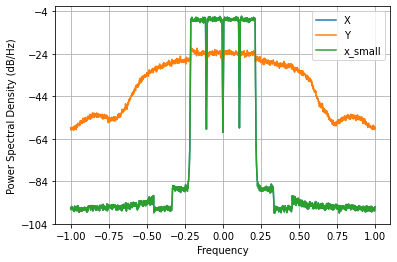

In [17]:
plt.psd(X.detach().cpu()[:,0,0]+1j*X.detach().cpu()[:,1,0],NFFT=2048, label = "X")
plt.psd(d.reshape(-1,),NFFT=2048, label = "Y")
plt.psd(x.reshape(-1,),NFFT=2048, label = "x_small")
plt.legend()
# plt.psd(x.reshape(-1,)*x.reshape(-1,),NFFT=2048)
plt.show()

## Loss function

In [18]:
loss_fn = nn.MSELoss()

# Ensemble of small NN
(as nn.ModuleList with Optuna)

In [19]:
class Cell_try_2(nn.Module):
    def __init__(self,M=15,D=0,Poly_order=8,Passthrough=False):
        super(Cell_try_2,self).__init__()
        self.f = AFIR(M,0)
        self.f1 = AFIR(M,0)
        self.pol = Polynomial(Poly_order,Passthrough)
        self.prod = Prod_cmp()
        self.delay = Delay(D)
    def forward(self,x):
        return self.prod( self.f1(x), self.pol(self.f(self.delay(x))) )



# complex reference model
ref_model = {'k': [ 9, 5, 9, 7, 9 ],'p': [ 9, 8, 6, 9, 6 ]}
# {'z_0': 4, 'z_1': 3, 'z_2': -1, 'z_3': 1, 'z_4': 1} for # {'p0': 4, 'k0': 7, 'p1': 7, 'k1': 7, 'p2': 7, 'k2': 7, 'p3': 9, 'k3': 5, 'p4': 7, 'k4': 9}
# kk = [ 7, 7, 7, 5, 9 ]
# pp = [ 4, 7, 7, 9, 7 ] -34.04

COMP = []
SCR = []


def objective(trial):
  # create and train NN
  net = torch.nn.ModuleList()

  complex_cur = 0
  for i in range(3):
    poly_ord = trial.suggest_int('p_' + str(i), 4, 9)
    conv_ord = trial.suggest_int('k_' + str(i), 3, 9, step=2)
    net.append(Cell_try_2(M=conv_ord, D=(-1 + i), Poly_order=poly_ord))


  net = net.to(torch.device('cpu'))
  optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
  train(train_queue, valid_queue, net, loss_fn, optimizer,20,scheduler,save_flag=False)

  loss_cur, accuracy_cur = eval_model(valid_queue, net, loss_fn)
  score_cur = accuracy_cur.item()
  
  COMP.append(complex_cur)
  SCR.append(score_cur)

  return score_cur

In [ ]:
### Random Sampler + Median Pruner
study_1 = optuna.create_study(sampler=optuna.samplers.RandomSampler(), direction="minimize", pruner=optuna.pruners.MedianPruner())
study_1.optimize(objective, n_trials=100)
print(study_1.best_params)



[I 2022-11-01 06:14:21,156] A new study created in memory with name: no-name-00f00a18-fd8f-41f0-9cf1-ed8c7241edba
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.426288260245313e-05 Accuracy =  -26.96579810593129 dbs
Loss =  4.194142850898448e-05 Accuracy =  -28.81896794853668 dbs
Loss =  3.04060720829948e-05 Accuracy =  -30.215796923979028 dbs
Loss =  2.957945803325677e-05 Accuracy =  -30.33549800723187 dbs
Loss =  2.6894973360544008e-05 Accuracy =  -30.748688946889118 dbs
Loss =  2.3274584864063766e-05 Accuracy =  -31.376580696872832 dbs
Loss =  2.0864538068820553e-05 Accuracy =  -31.85131239062448 dbs
Loss =  1.9137878304241382e-05 Accuracy =  -32.22646224516716 dbs
Loss =  1.9204944784065145e-05 Accuracy =  -32.21126950271058 dbs
Loss =  1.8389325195028718e-05 Accuracy =  -32.3997422024916 dbs
Loss =  1.812428774879979e-05 Accuracy =  -32.4627906453518 dbs
Loss =  1.7446103960719924e-05 Accuracy =  -32.62841557045485 dbs
Loss =  1.735840966656501e-05 Accuracy =  -32.650300794336225 dbs
Loss =  1.7139340215493442e-05 Accuracy =  -32.70545913537695 dbs
Loss =  1.7048454604405447e-05 Accuracy =  -32.728549956280624 dbs
Loss =  1.7385

[I 2022-11-01 06:15:02,925] Trial 0 finished with value: -32.793183791107865 and parameters: {'p_0': 7, 'k_0': 3, 'p_1': 8, 'k_1': 9, 'p_2': 4, 'k_2': 9}. Best is trial 0 with value: -32.793183791107865.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.872592172458643e-05 Accuracy =  -26.67419440000018 dbs
Loss =  3.606440420551928e-05 Accuracy =  -29.474612512247646 dbs
Loss =  2.9937008828384365e-05 Accuracy =  -30.2833160772011 dbs
Loss =  2.3950737257937472e-05 Accuracy =  -31.252211266144432 dbs
Loss =  2.6943590248991003e-05 Accuracy =  -30.74084547904626 dbs
Loss =  2.460052250676282e-05 Accuracy =  -31.135956816695614 dbs
Loss =  1.8781482535453677e-05 Accuracy =  -32.308101423780876 dbs
Loss =  2.166555225938684e-05 Accuracy =  -31.687702493713203 dbs
Loss =  1.800864569725156e-05 Accuracy =  -32.490589593043474 dbs
Loss =  2.0337909817035318e-05 Accuracy =  -31.96233695897564 dbs
Loss =  1.9674057269094345e-05 Accuracy =  -32.106460818985184 dbs
Loss =  1.769941599919168e-05 Accuracy =  -32.565810762972355 dbs
Loss =  1.8629032769551698e-05 Accuracy =  -32.34349706484453 dbs
Loss =  1.7519062473758774e-05 Accuracy =  -32.61029151795504 dbs
Loss =  1.802601411478456e-05 Accuracy =  -32.486403063453665 dbs
Loss =  2

[I 2022-11-01 06:15:45,022] Trial 1 finished with value: -32.52920564211004 and parameters: {'p_0': 7, 'k_0': 5, 'p_1': 6, 'k_1': 9, 'p_2': 9, 'k_2': 3}. Best is trial 0 with value: -32.793183791107865.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.709341651344178e-05 Accuracy =  -26.778601056693525 dbs
Loss =  5.010208934576436e-05 Accuracy =  -28.046841760454335 dbs
Loss =  3.926487129025472e-05 Accuracy =  -29.105358349596244 dbs
Loss =  3.1388357548505206e-05 Accuracy =  -30.07771422073205 dbs
Loss =  2.7067081326476654e-05 Accuracy =  -30.7209858530098 dbs
Loss =  2.3159652606507615e-05 Accuracy =  -31.39807972427205 dbs
Loss =  2.160725635189387e-05 Accuracy =  -31.69940388637539 dbs
Loss =  2.039081315373081e-05 Accuracy =  -31.951054680305102 dbs
Loss =  2.1010541948363164e-05 Accuracy =  -31.8210275834573 dbs
Loss =  2.437606124322951e-05 Accuracy =  -31.175764807866155 dbs
Loss =  1.8562912519074148e-05 Accuracy =  -32.358938951497514 dbs
Loss =  2.3312737715772608e-05 Accuracy =  -31.369467355408766 dbs
Loss =  1.951693893957135e-05 Accuracy =  -32.14128309741276 dbs
Loss =  2.2739396570355697e-05 Accuracy =  -31.477610773972945 dbs
Loss =  1.7937512427692104e-05 Accuracy =  -32.50777798167033 dbs
Loss =  1.8

[I 2022-11-01 06:16:26,166] Trial 2 finished with value: -32.69821134899384 and parameters: {'p_0': 7, 'k_0': 9, 'p_1': 5, 'k_1': 5, 'p_2': 8, 'k_2': 9}. Best is trial 0 with value: -32.793183791107865.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.626991452447798e-05 Accuracy =  -26.83223602703955 dbs
Loss =  4.4194430818259415e-05 Accuracy =  -28.591724681624626 dbs
Loss =  3.5868853395805136e-05 Accuracy =  -29.49822519145431 dbs
Loss =  2.8180481301905823e-05 Accuracy =  -30.54591606871357 dbs
Loss =  2.272830190897604e-05 Accuracy =  -31.479730234808905 dbs
Loss =  1.9212326348832193e-05 Accuracy =  -32.209600579962526 dbs
Loss =  1.782557377453737e-05 Accuracy =  -32.53496495197819 dbs
Loss =  1.6961851591247642e-05 Accuracy =  -32.75066754134751 dbs
Loss =  1.6591025683176286e-05 Accuracy =  -32.84666777519601 dbs
Loss =  1.6328128495726944e-05 Accuracy =  -32.91603603696239 dbs
Loss =  1.6054091914496656e-05 Accuracy =  -32.98954268024366 dbs
Loss =  1.609048976220719e-05 Accuracy =  -32.979707497861384 dbs
Loss =  1.5852753067062278e-05 Accuracy =  -33.04435318319357 dbs
Loss =  1.583934206963716e-05 Accuracy =  -33.04802875118684 dbs
Loss =  1.574016041249663e-05 Accuracy =  -33.0753085907312 dbs
Loss =  1.564

[I 2022-11-01 06:17:08,368] Trial 3 finished with value: -33.08100124870283 and parameters: {'p_0': 6, 'k_0': 9, 'p_1': 9, 'k_1': 5, 'p_2': 6, 'k_2': 5}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.522509486462386e-05 Accuracy =  -26.90125293719641 dbs
Loss =  3.356902110486233e-05 Accuracy =  -29.78601336023843 dbs
Loss =  3.0589266304277195e-05 Accuracy =  -30.189709527548878 dbs
Loss =  2.704396135341652e-05 Accuracy =  -30.72469706493088 dbs
Loss =  2.3468066106904794e-05 Accuracy =  -31.34062710233784 dbs
Loss =  2.2039219716615046e-05 Accuracy =  -31.613437985834434 dbs
Loss =  2.285960694749316e-05 Accuracy =  -31.454712543584783 dbs
Loss =  2.1796395641663968e-05 Accuracy =  -31.661553306512012 dbs
Loss =  1.972601628385165e-05 Accuracy =  -32.09500625840157 dbs
Loss =  1.940509007541306e-05 Accuracy =  -32.1662435013033 dbs
Loss =  2.111006615769746e-05 Accuracy =  -31.80050418775567 dbs
Loss =  2.066043386269648e-05 Accuracy =  -31.89400575809906 dbs
Loss =  2.026073892111427e-05 Accuracy =  -31.978847328492066 dbs
Loss =  1.974679765298401e-05 Accuracy =  -32.0904333719644 dbs
Loss =  1.8935779054620007e-05 Accuracy =  -32.27256835598128 dbs
Loss =  1.9374411

[I 2022-11-01 06:17:49,601] Trial 4 finished with value: -32.46805723179084 and parameters: {'p_0': 9, 'k_0': 5, 'p_1': 5, 'k_1': 9, 'p_2': 6, 'k_2': 7}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.585745552215774e-05 Accuracy =  -26.24541742016957 dbs
Loss =  5.54195008120277e-05 Accuracy =  -27.60877403557334 dbs
Loss =  4.509282548858199e-05 Accuracy =  -28.504325643554967 dbs
Loss =  3.884028406125582e-05 Accuracy =  -29.152576156465365 dbs
Loss =  3.523844584770033e-05 Accuracy =  -29.57523267049269 dbs
Loss =  3.0344401138985147e-05 Accuracy =  -30.224614422331562 dbs
Loss =  2.9609777774033435e-05 Accuracy =  -30.331048651843453 dbs
Loss =  2.635305310628786e-05 Accuracy =  -30.837090759276542 dbs
Loss =  2.4590907593542967e-05 Accuracy =  -31.137654552988305 dbs
Loss =  2.351273745683243e-05 Accuracy =  -31.332368185866514 dbs
Loss =  2.2086531406207017e-05 Accuracy =  -31.60412495973504 dbs
Loss =  2.1051973481442947e-05 Accuracy =  -31.81247198861058 dbs
Loss =  2.0133166185983833e-05 Accuracy =  -32.00627934773812 dbs
Loss =  1.983398882972737e-05 Accuracy =  -32.071299488307076 dbs
Loss =  1.927865915936775e-05 Accuracy =  -32.194631879253436 dbs
Loss =  1.8

[I 2022-11-01 06:18:33,355] Trial 5 finished with value: -32.54511499524915 and parameters: {'p_0': 8, 'k_0': 3, 'p_1': 5, 'k_1': 3, 'p_2': 8, 'k_2': 7}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.066409038845939e-05 Accuracy =  -26.55341240190849 dbs
Loss =  5.485650886095048e-05 Accuracy =  -27.653118480521318 dbs
Loss =  4.4982138352819595e-05 Accuracy =  -28.51499916135068 dbs
Loss =  3.918802154174369e-05 Accuracy =  -29.113866750289787 dbs
Loss =  3.5260733992438475e-05 Accuracy =  -29.572486647456373 dbs
Loss =  3.1328929705759355e-05 Accuracy =  -30.085944548614574 dbs
Loss =  2.925784519174796e-05 Accuracy =  -30.382976754843792 dbs
Loss =  2.8165416868144546e-05 Accuracy =  -30.548238296532766 dbs
Loss =  2.66212762884383e-05 Accuracy =  -30.79311140371832 dbs
Loss =  2.5997109689703344e-05 Accuracy =  -30.896149465365074 dbs
Loss =  2.491878965792083e-05 Accuracy =  -31.080130689576634 dbs
Loss =  2.460728233387658e-05 Accuracy =  -31.13476360938141 dbs
Loss =  2.464207033511006e-05 Accuracy =  -31.128628203059847 dbs
Loss =  2.4615154885498365e-05 Accuracy =  -31.13337440317784 dbs
Loss =  2.4621960129256075e-05 Accuracy =  -31.132173894240665 dbs
Loss =  2

[I 2022-11-01 06:19:10,052] Trial 6 finished with value: -30.80203777873081 and parameters: {'p_0': 5, 'k_0': 5, 'p_1': 5, 'k_1': 3, 'p_2': 5, 'k_2': 7}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.943283344106942e-05 Accuracy =  -26.62975124668506 dbs
Loss =  4.174769717783472e-05 Accuracy =  -28.83907488541485 dbs
Loss =  3.3769431318028746e-05 Accuracy =  -29.760162660216928 dbs
Loss =  2.818908860585673e-05 Accuracy =  -30.544589784108204 dbs
Loss =  2.791783662313859e-05 Accuracy =  -30.58658251731667 dbs
Loss =  2.3288310980021998e-05 Accuracy =  -31.374020213258902 dbs
Loss =  2.0594750097599576e-05 Accuracy =  -31.907834866636406 dbs
Loss =  2.026524559715695e-05 Accuracy =  -31.977881417574217 dbs
Loss =  1.943005864526484e-05 Accuracy =  -32.16065901716508 dbs
Loss =  1.8537081785113325e-05 Accuracy =  -32.36498647104342 dbs
Loss =  1.8200317357737286e-05 Accuracy =  -32.4446105232312 dbs
Loss =  1.765499281208732e-05 Accuracy =  -32.576724680545816 dbs
Loss =  1.748059359502733e-05 Accuracy =  -32.61983837090291 dbs
Loss =  1.7088641365104075e-05 Accuracy =  -32.71832477690691 dbs
Loss =  1.6880837270848255e-05 Accuracy =  -32.77146029788991 dbs
Loss =  1.759

[I 2022-11-01 06:19:53,529] Trial 7 finished with value: -32.85373702581571 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 8, 'k_1': 5, 'p_2': 6, 'k_2': 9}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.59545418834192e-05 Accuracy =  -26.85295305038009 dbs
Loss =  4.664208117584634e-05 Accuracy =  -28.35762092677882 dbs
Loss =  3.837160913291751e-05 Accuracy =  -29.205300011986775 dbs
Loss =  3.1674270461684836e-05 Accuracy =  -30.038333923648644 dbs
Loss =  2.8053520967637926e-05 Accuracy =  -30.565526362860503 dbs
Loss =  2.594129830417189e-05 Accuracy =  -30.90548305375537 dbs
Loss =  2.550352984369954e-05 Accuracy =  -30.97939719545844 dbs
Loss =  2.515800849648207e-05 Accuracy =  -31.038637536793182 dbs
Loss =  2.4889957784479692e-05 Accuracy =  -31.0851585313032 dbs
Loss =  2.4623098643674234e-05 Accuracy =  -31.131973082000094 dbs
Loss =  2.0912898945072094e-05 Accuracy =  -31.841257742671637 dbs
Loss =  2.3796484485101676e-05 Accuracy =  -31.280272107665972 dbs
Loss =  2.3087813896085372e-05 Accuracy =  -31.41157200092046 dbs
Loss =  2.2860459223120103e-05 Accuracy =  -31.454550628420222 dbs
Loss =  2.254061416532988e-05 Accuracy =  -31.515742680220757 dbs
Loss =  2.

[I 2022-11-01 06:20:30,284] Trial 8 finished with value: -31.820128609989556 and parameters: {'p_0': 4, 'k_0': 7, 'p_1': 6, 'k_1': 7, 'p_2': 5, 'k_2': 3}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.129081984245818e-05 Accuracy =  -26.515064040223002 dbs
Loss =  4.151404678152607e-05 Accuracy =  -28.863449427515175 dbs
Loss =  3.396561306785364e-05 Accuracy =  -29.73500555272219 dbs
Loss =  2.9758772850837108e-05 Accuracy =  -30.309249947021456 dbs
Loss =  2.458737759609997e-05 Accuracy =  -31.13827802263852 dbs
Loss =  2.181510945091242e-05 Accuracy =  -31.657826168650768 dbs
Loss =  1.983451935545774e-05 Accuracy =  -32.071183323415696 dbs
Loss =  2.066210864962382e-05 Accuracy =  -31.893653722296285 dbs
Loss =  1.8490942579017063e-05 Accuracy =  -32.37580963178285 dbs
Loss =  1.8460042808622955e-05 Accuracy =  -32.38307309323673 dbs
Loss =  1.9361464454332026e-05 Accuracy =  -32.17601809939838 dbs
Loss =  1.759706897186302e-05 Accuracy =  -32.590996768784926 dbs
Loss =  1.851329436730533e-05 Accuracy =  -32.37056306528349 dbs
Loss =  1.795056512937881e-05 Accuracy =  -32.504618873157256 dbs
Loss =  1.817318189810311e-05 Accuracy =  -32.451090396111404 dbs
Loss =  1.65

[I 2022-11-01 06:21:12,163] Trial 9 finished with value: -33.013469036472905 and parameters: {'p_0': 6, 'k_0': 7, 'p_1': 9, 'k_1': 3, 'p_2': 7, 'k_2': 5}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.4065958345476013e-05 Accuracy =  -27.716161076624743 dbs
Loss =  3.395081011067159e-05 Accuracy =  -29.736898715648312 dbs
Loss =  3.1043803937415385e-05 Accuracy =  -30.12565081228636 dbs
Loss =  2.8644057094151566e-05 Accuracy =  -30.475054824351588 dbs
Loss =  2.7002805903225207e-05 Accuracy =  -30.731311184250217 dbs
Loss =  2.5706928956931694e-05 Accuracy =  -30.944898157925227 dbs
Loss =  2.4345626065387376e-05 Accuracy =  -31.181190659162368 dbs
Loss =  2.3366456212255815e-05 Accuracy =  -31.359471614293955 dbs
Loss =  2.3313929682823274e-05 Accuracy =  -31.369245308781068 dbs
Loss =  2.3741094940096365e-05 Accuracy =  -31.290392683819796 dbs
Loss =  2.2139703621556208e-05 Accuracy =  -31.59368210344003 dbs
Loss =  2.2758562092448905e-05 Accuracy =  -31.473951936862527 dbs
Loss =  2.3131527231913573e-05 Accuracy =  -31.403357056382966 dbs
Loss =  2.3110720493006755e-05 Accuracy =  -31.4072652801169 dbs
Loss =  2.308968640386988e-05 Accuracy =  -31.41121978618675 dbs
Lo

[I 2022-11-01 06:21:51,251] Trial 10 finished with value: -31.546778797200986 and parameters: {'p_0': 4, 'k_0': 5, 'p_1': 4, 'k_1': 9, 'p_2': 7, 'k_2': 7}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.5783150584017936e-05 Accuracy =  -27.580369739397234 dbs
Loss =  3.465490637987435e-05 Accuracy =  -29.64775283199092 dbs
Loss =  2.9410363232977613e-05 Accuracy =  -30.360396248401273 dbs
Loss =  2.6384311932525003e-05 Accuracy =  -30.83194240295446 dbs
Loss =  2.2560539806840612e-05 Accuracy =  -31.511905263233665 dbs
Loss =  1.9784828468399534e-05 Accuracy =  -32.08207723790507 dbs
Loss =  1.9288106431941123e-05 Accuracy =  -32.192504193217644 dbs
Loss =  1.8359857029357036e-05 Accuracy =  -32.40670718168917 dbs
Loss =  1.7800556091493734e-05 Accuracy =  -32.541064432063536 dbs
Loss =  1.764969599591867e-05 Accuracy =  -32.57802783779128 dbs
Loss =  1.779591003218099e-05 Accuracy =  -32.54219811647286 dbs
Loss =  1.760804846316382e-05 Accuracy =  -32.58828788269788 dbs
Loss =  1.7471346531173046e-05 Accuracy =  -32.622136354296636 dbs
Loss =  1.74185212707679e-05 Accuracy =  -32.63528729929856 dbs
Loss =  1.7385158474137334e-05 Accuracy =  -32.64361359296742 dbs
Loss =  1.

[I 2022-11-01 06:22:31,485] Trial 11 finished with value: -32.59426531663428 and parameters: {'p_0': 7, 'k_0': 9, 'p_1': 4, 'k_1': 9, 'p_2': 9, 'k_2': 5}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.987507788690083e-05 Accuracy =  -26.602177081534446 dbs
Loss =  5.065151283203981e-05 Accuracy =  -27.999475919754154 dbs
Loss =  4.247805380128627e-05 Accuracy =  -28.763754024927344 dbs
Loss =  3.5763770903429386e-05 Accuracy =  -29.510967089372034 dbs
Loss =  3.4509936603520744e-05 Accuracy =  -29.665958516670095 dbs
Loss =  3.1133083287484475e-05 Accuracy =  -30.113178796570836 dbs
Loss =  2.9231772253900484e-05 Accuracy =  -30.386848667254473 dbs
Loss =  2.7508535172269278e-05 Accuracy =  -30.650725482864154 dbs
Loss =  2.5563030739134703e-05 Accuracy =  -30.9692767088015 dbs
Loss =  2.4207423396530652e-05 Accuracy =  -31.205914469194227 dbs
Loss =  2.2329216613821463e-05 Accuracy =  -31.556665263529382 dbs
Loss =  2.2032838256109486e-05 Accuracy =  -31.61469566847096 dbs
Loss =  2.1306315099068086e-05 Accuracy =  -31.760316676252312 dbs
Loss =  2.0163010140399513e-05 Accuracy =  -31.99984644602274 dbs
Loss =  1.9329945405283753e-05 Accuracy =  -32.18309385712039 dbs
Los

[I 2022-11-01 06:23:08,977] Trial 12 finished with value: -32.25144863017157 and parameters: {'p_0': 6, 'k_0': 3, 'p_1': 6, 'k_1': 3, 'p_2': 4, 'k_2': 9}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.730785720335237e-05 Accuracy =  -26.76474248455715 dbs
Loss =  4.446723781575606e-05 Accuracy =  -28.564998600474368 dbs
Loss =  3.129014491352573e-05 Accuracy =  -30.09132438646915 dbs
Loss =  2.3721753215125198e-05 Accuracy =  -31.29393229647135 dbs
Loss =  2.2145217267450324e-05 Accuracy =  -31.592600676195147 dbs
Loss =  1.945497732727376e-05 Accuracy =  -32.155092841229525 dbs
Loss =  2.171297762582835e-05 Accuracy =  -31.678206282934017 dbs
Loss =  2.2704864168413337e-05 Accuracy =  -31.484211050554947 dbs
Loss =  1.7600520801243346e-05 Accuracy =  -32.59014494315322 dbs
Loss =  1.8908195215963267e-05 Accuracy =  -32.27889935650153 dbs
Loss =  2.037415190190482e-05 Accuracy =  -31.954604733701522 dbs
Loss =  1.6922524177505138e-05 Accuracy =  -32.76074869884716 dbs
Loss =  1.861023949852113e-05 Accuracy =  -32.34788050957977 dbs
Loss =  1.637550539755167e-05 Accuracy =  -32.90345300628576 dbs
Loss =  1.9464735730385447e-05 Accuracy =  -32.152915013913 dbs
Loss =  1.6091

[I 2022-11-01 06:23:51,987] Trial 13 finished with value: -32.856736749007894 and parameters: {'p_0': 6, 'k_0': 9, 'p_1': 8, 'k_1': 5, 'p_2': 9, 'k_2': 5}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.149153058473543e-05 Accuracy =  -26.502854180253053 dbs
Loss =  4.2373096747263686e-05 Accuracy =  -28.774498084931718 dbs
Loss =  3.43670571232249e-05 Accuracy =  -29.68397668370077 dbs
Loss =  3.161384856336019e-05 Accuracy =  -30.046626445343204 dbs
Loss =  2.56633049807648e-05 Accuracy =  -30.95227428033307 dbs
Loss =  2.3253932351982338e-05 Accuracy =  -31.38043608413213 dbs
Loss =  2.1898316779654326e-05 Accuracy =  -31.641292791843668 dbs
Loss =  2.1012152849543953e-05 Accuracy =  -31.82069461790266 dbs
Loss =  1.8820572251417577e-05 Accuracy =  -32.29907188847811 dbs
Loss =  1.86953886257422e-05 Accuracy =  -32.32805515765928 dbs
Loss =  1.796783835877193e-05 Accuracy =  -32.50044181178488 dbs
Loss =  1.7406017789848878e-05 Accuracy =  -32.638405900806305 dbs
Loss =  1.7893274329882906e-05 Accuracy =  -32.51850192790151 dbs
Loss =  1.6979587080609785e-05 Accuracy =  -32.74612888525852 dbs
Loss =  1.8561534373480545e-05 Accuracy =  -32.35926139187141 dbs
Loss =  1.7015

[I 2022-11-01 06:24:36,384] Trial 14 finished with value: -32.655689846781016 and parameters: {'p_0': 9, 'k_0': 7, 'p_1': 8, 'k_1': 5, 'p_2': 8, 'k_2': 5}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.615555389334256e-05 Accuracy =  -26.839737031791756 dbs
Loss =  3.944023534669976e-05 Accuracy =  -29.08600515351422 dbs
Loss =  2.8788026395717788e-05 Accuracy =  -30.453281209186564 dbs
Loss =  2.5332032110974403e-05 Accuracy =  -31.00869983269682 dbs
Loss =  2.2631669552646803e-05 Accuracy =  -31.498234198220715 dbs
Loss =  2.0458754232810738e-05 Accuracy =  -31.936608278624952 dbs
Loss =  1.9073406650085328e-05 Accuracy =  -32.24111744990176 dbs
Loss =  2.1068665848368994e-05 Accuracy =  -31.80902977911863 dbs
Loss =  2.2077309980185565e-05 Accuracy =  -31.605938576652804 dbs
Loss =  1.9840483736770993e-05 Accuracy =  -32.06987756527584 dbs
Loss =  2.3747278432963112e-05 Accuracy =  -31.289261688312745 dbs
Loss =  2.188382700730432e-05 Accuracy =  -31.644167401381296 dbs
Loss =  2.2305555102108262e-05 Accuracy =  -31.56126977455882 dbs
Loss =  2.1914277749840885e-05 Accuracy =  -31.638128513782103 dbs
Loss =  2.1498214001984983e-05 Accuracy =  -31.721376314229836 dbs
Loss

[I 2022-11-01 06:25:18,876] Trial 15 finished with value: -31.919526210480033 and parameters: {'p_0': 8, 'k_0': 9, 'p_1': 7, 'k_1': 9, 'p_2': 8, 'k_2': 7}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.369132868684139e-05 Accuracy =  -26.37123626025973 dbs
Loss =  5.1457018975158744e-05 Accuracy =  -27.93095390225338 dbs
Loss =  4.0866922544708234e-05 Accuracy =  -28.931680784407355 dbs
Loss =  3.632185403373287e-05 Accuracy =  -29.443720043448806 dbs
Loss =  3.198361126722339e-05 Accuracy =  -29.99612514801406 dbs
Loss =  2.901724196330123e-05 Accuracy =  -30.41883881985203 dbs
Loss =  2.6861647416017775e-05 Accuracy =  -30.754073688510534 dbs
Loss =  2.571626400673247e-05 Accuracy =  -30.94332137498833 dbs
Loss =  2.441870323980365e-05 Accuracy =  -31.16817416214007 dbs
Loss =  2.3187088250713303e-05 Accuracy =  -31.392937981807584 dbs
Loss =  2.252567007243989e-05 Accuracy =  -31.51862294311655 dbs
Loss =  2.2677226125172514e-05 Accuracy =  -31.489500825034874 dbs
Loss =  2.198473343570777e-05 Accuracy =  -31.62418808959627 dbs
Loss =  2.21770296293547e-05 Accuracy =  -31.586366364276778 dbs
Loss =  2.1565080594876555e-05 Accuracy =  -31.707889275708027 dbs
Loss =  2.221

[I 2022-11-01 06:25:59,014] Trial 16 finished with value: -31.45966684589956 and parameters: {'p_0': 6, 'k_0': 5, 'p_1': 6, 'k_1': 3, 'p_2': 6, 'k_2': 7}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.434501497841767e-05 Accuracy =  -26.96025106827853 dbs
Loss =  4.304580973025693e-05 Accuracy =  -28.706091314394317 dbs
Loss =  3.519225029083692e-05 Accuracy =  -29.580929754125588 dbs
Loss =  2.9051084078736496e-05 Accuracy =  -30.413776698501106 dbs
Loss =  2.834855484329563e-05 Accuracy =  -30.52009088871862 dbs
Loss =  2.4817221575717463e-05 Accuracy =  -31.097868549072466 dbs
Loss =  2.2259420097889914e-05 Accuracy =  -31.57026167226427 dbs
Loss =  2.230529419528377e-05 Accuracy =  -31.561320574037403 dbs
Loss =  2.0332269764906324e-05 Accuracy =  -31.963541499284112 dbs
Loss =  1.9035087209964825e-05 Accuracy =  -32.249851422471735 dbs
Loss =  1.7972618714808398e-05 Accuracy =  -32.49928652193636 dbs
Loss =  1.7716460767221562e-05 Accuracy =  -32.561630463091 dbs
Loss =  1.725767633675098e-05 Accuracy =  -32.67557693489525 dbs
Loss =  1.6874467304421028e-05 Accuracy =  -32.7730994128894 dbs
Loss =  1.6530985545252205e-05 Accuracy =  -32.86241267001725 dbs
Loss =  1.65

[I 2022-11-01 06:26:39,548] Trial 17 finished with value: -33.030804911333334 and parameters: {'p_0': 8, 'k_0': 7, 'p_1': 9, 'k_1': 3, 'p_2': 4, 'k_2': 9}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.750109161259055e-05 Accuracy =  -25.625265420777524 dbs
Loss =  5.27823436737047e-05 Accuracy =  -27.820513430188317 dbs
Loss =  3.798082310763374e-05 Accuracy =  -29.249756407515093 dbs
Loss =  3.15614474522201e-05 Accuracy =  -30.05383100790739 dbs
Loss =  2.853621791502771e-05 Accuracy =  -30.491436003331774 dbs
Loss =  2.4541614131331e-05 Accuracy =  -31.146368897403697 dbs
Loss =  2.4103635078257957e-05 Accuracy =  -31.224574695105275 dbs
Loss =  2.1521594225379165e-05 Accuracy =  -31.71665574320739 dbs
Loss =  2.1729903711038397e-05 Accuracy =  -31.674822112477226 dbs
Loss =  2.0717890005822684e-05 Accuracy =  -31.8819449012951 dbs
Loss =  2.2185811723213353e-05 Accuracy =  -31.584646900493162 dbs
Loss =  2.1021972029185225e-05 Accuracy =  -31.818665592378803 dbs
Loss =  2.1077839294106133e-05 Accuracy =  -31.80713924185433 dbs
Loss =  2.0994694438703396e-05 Accuracy =  -31.824304549338542 dbs
Loss =  2.086598483627729e-05 Accuracy =  -31.8510112570275 dbs
Loss =  2.354

[I 2022-11-01 06:27:17,204] Trial 18 finished with value: -31.895184153882667 and parameters: {'p_0': 5, 'k_0': 5, 'p_1': 8, 'k_1': 7, 'p_2': 5, 'k_2': 3}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.227656177739576e-05 Accuracy =  -26.455425283063793 dbs
Loss =  4.381043980013887e-05 Accuracy =  -28.6296240018373 dbs
Loss =  3.420841218793378e-05 Accuracy =  -29.704070966273267 dbs
Loss =  3.111904800174155e-05 Accuracy =  -30.115137106150648 dbs
Loss =  2.971704361995594e-05 Accuracy =  -30.315344113946733 dbs
Loss =  2.7483786167750373e-05 Accuracy =  -30.65463452200231 dbs
Loss =  2.7117379582184588e-05 Accuracy =  -30.71292292839584 dbs
Loss =  2.5264718468826975e-05 Accuracy =  -31.020255499910224 dbs
Loss =  2.3892551675607832e-05 Accuracy =  -31.262774791501453 dbs
Loss =  2.367201791142305e-05 Accuracy =  -31.303047323770986 dbs
Loss =  2.172390776208078e-05 Accuracy =  -31.676020629925667 dbs
Loss =  2.494143457901561e-05 Accuracy =  -31.076185835697096 dbs
Loss =  2.3353605203929453e-05 Accuracy =  -31.361860790153152 dbs
Loss =  2.3325967878919926e-05 Accuracy =  -31.367003398945815 dbs
Loss =  2.292244421975368e-05 Accuracy =  -31.442790885624326 dbs
Loss =  

[I 2022-11-01 06:27:56,786] Trial 19 finished with value: -31.82366360577464 and parameters: {'p_0': 8, 'k_0': 9, 'p_1': 5, 'k_1': 7, 'p_2': 6, 'k_2': 3}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.845069710902659e-05 Accuracy =  -25.5783875306171 dbs
Loss =  5.942195817502573e-05 Accuracy =  -27.30593053813014 dbs
Loss =  4.104806932520353e-05 Accuracy =  -28.912472780199693 dbs
Loss =  3.653730895860177e-05 Accuracy =  -29.418034555480673 dbs
Loss =  3.14255195672265e-05 Accuracy =  -30.072575464046075 dbs
Loss =  2.8973943406386396e-05 Accuracy =  -30.425324056433038 dbs
Loss =  2.5818763245562125e-05 Accuracy =  -30.926045780157352 dbs
Loss =  2.38023786027086e-05 Accuracy =  -31.27919654299934 dbs
Loss =  2.3684983953755786e-05 Accuracy =  -31.3006691830289 dbs
Loss =  2.285256500545586e-05 Accuracy =  -31.456050601463996 dbs
Loss =  2.1711213572634075e-05 Accuracy =  -31.678559136284804 dbs
Loss =  2.2394779174932233e-05 Accuracy =  -31.54393228723604 dbs
Loss =  2.1781492445225416e-05 Accuracy =  -31.664523792927234 dbs
Loss =  2.0640925608473933e-05 Accuracy =  -31.898108445225574 dbs
Loss =  1.9885327901544557e-05 Accuracy =  -32.060072564055716 dbs
Loss =  2.0

[I 2022-11-01 06:28:35,655] Trial 20 finished with value: -32.30536095832343 and parameters: {'p_0': 5, 'k_0': 5, 'p_1': 6, 'k_1': 3, 'p_2': 8, 'k_2': 3}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.080605410789038e-05 Accuracy =  -25.970961131665252 dbs
Loss =  4.668311117949236e-05 Accuracy =  -28.35380221398021 dbs
Loss =  2.7802142280956425e-05 Accuracy =  -30.604617515747133 dbs
Loss =  2.212512217876223e-05 Accuracy =  -31.596543355126073 dbs
Loss =  2.145776874926052e-05 Accuracy =  -31.72955452557224 dbs
Loss =  2.3167505996556653e-05 Accuracy =  -31.396607290348605 dbs
Loss =  2.4275862482971985e-05 Accuracy =  -31.193653444888287 dbs
Loss =  2.3577856999615727e-05 Accuracy =  -31.320356837762496 dbs
Loss =  2.201719372193502e-05 Accuracy =  -31.617780494903315 dbs
Loss =  2.065520936454818e-05 Accuracy =  -31.895104117244113 dbs
Loss =  2.1996662035900165e-05 Accuracy =  -31.621832309243302 dbs
Loss =  2.149150740153531e-05 Accuracy =  -31.722731354223654 dbs
Loss =  2.112714711528002e-05 Accuracy =  -31.796991566797374 dbs
Loss =  2.081733032559158e-05 Accuracy =  -31.86114979568492 dbs
Loss =  2.0435265876211875e-05 Accuracy =  -31.941597205981292 dbs
Loss = 

[I 2022-11-01 06:29:18,301] Trial 21 finished with value: -32.33239219282207 and parameters: {'p_0': 8, 'k_0': 5, 'p_1': 8, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.089421758248033e-05 Accuracy =  -27.19963958457238 dbs
Loss =  5.383858423804051e-05 Accuracy =  -27.734463821620583 dbs
Loss =  4.719338055747108e-05 Accuracy =  -28.306589252876396 dbs
Loss =  3.7322588344771264e-05 Accuracy =  -29.325682584265763 dbs
Loss =  3.247419221182451e-05 Accuracy =  -29.930016562359896 dbs
Loss =  3.047195129653387e-05 Accuracy =  -30.20639747620061 dbs
Loss =  2.799687944968538e-05 Accuracy =  -30.574303858430145 dbs
Loss =  2.6375812375764492e-05 Accuracy =  -30.833341683445184 dbs
Loss =  2.5206409997112997e-05 Accuracy =  -31.030290171037798 dbs
Loss =  2.443013833028034e-05 Accuracy =  -31.1661408706125 dbs
Loss =  2.359385042135467e-05 Accuracy =  -31.31741191358914 dbs
Loss =  2.311227892982317e-05 Accuracy =  -31.406972430012633 dbs
Loss =  2.2937255423540277e-05 Accuracy =  -31.439985623335843 dbs
Loss =  2.2801455850206114e-05 Accuracy =  -31.465774359834576 dbs
Loss =  2.2494785500392407e-05 Accuracy =  -31.524581568434577 dbs
Loss =  2

[I 2022-11-01 06:29:52,200] Trial 22 finished with value: -31.870870245725694 and parameters: {'p_0': 4, 'k_0': 3, 'p_1': 4, 'k_1': 7, 'p_2': 4, 'k_2': 7}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.15802281167034e-05 Accuracy =  -26.497469350433835 dbs
Loss =  5.211218186010682e-05 Accuracy =  -27.876007563224363 dbs
Loss =  3.658900714738836e-05 Accuracy =  -29.41189388190361 dbs
Loss =  2.66551522289207e-05 Accuracy =  -30.78758845992762 dbs
Loss =  2.4968096429035267e-05 Accuracy =  -31.07154580193663 dbs
Loss =  2.6237165062224244e-05 Accuracy =  -30.8562310561884 dbs
Loss =  2.4318902380255252e-05 Accuracy =  -31.18596043728467 dbs
Loss =  2.242632710476924e-05 Accuracy =  -31.537818607658025 dbs
Loss =  2.020897893767908e-05 Accuracy =  -31.989956418762855 dbs
Loss =  2.0974170233056143e-05 Accuracy =  -31.82855224583371 dbs
Loss =  1.9847950512909217e-05 Accuracy =  -32.06824344703762 dbs
Loss =  1.8947492994960945e-05 Accuracy =  -32.26988257962759 dbs
Loss =  1.9773920758212607e-05 Accuracy =  -32.08447223701755 dbs
Loss =  1.8745850180214695e-05 Accuracy =  -32.316348713842906 dbs
Loss =  1.9336452142160293e-05 Accuracy =  -32.18163220559524 dbs
Loss =  1.9430

[I 2022-11-01 06:30:31,474] Trial 23 finished with value: -32.44228079350008 and parameters: {'p_0': 9, 'k_0': 9, 'p_1': 6, 'k_1': 9, 'p_2': 4, 'k_2': 3}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.834950546622428e-05 Accuracy =  -26.69804636503426 dbs
Loss =  3.933026136491044e-05 Accuracy =  -29.098131806631727 dbs
Loss =  3.0887817066403364e-05 Accuracy =  -30.147527966310395 dbs
Loss =  2.617349718174255e-05 Accuracy =  -30.866782581998326 dbs
Loss =  2.3738247624705482e-05 Accuracy =  -31.29091357282001 dbs
Loss =  2.095886527819789e-05 Accuracy =  -31.831722470767264 dbs
Loss =  2.04192548406431e-05 Accuracy =  -31.945001237961623 dbs
Loss =  1.9366146830981968e-05 Accuracy =  -32.174967928585524 dbs
Loss =  1.8755059745125137e-05 Accuracy =  -32.31421561184101 dbs
Loss =  1.8289396840711863e-05 Accuracy =  -32.42340629863874 dbs
Loss =  1.792684349398087e-05 Accuracy =  -32.510361861434056 dbs
Loss =  1.7725595928000608e-05 Accuracy =  -32.55939168217622 dbs
Loss =  1.7621831878782035e-05 Accuracy =  -32.584889596020716 dbs
Loss =  1.7454759303102563e-05 Accuracy =  -32.626261487626344 dbs
Loss =  1.7367993210741307e-05 Accuracy =  -32.647903724606195 dbs
Loss = 

[I 2022-11-01 06:31:14,987] Trial 24 finished with value: -32.66156316720239 and parameters: {'p_0': 7, 'k_0': 3, 'p_1': 9, 'k_1': 9, 'p_2': 9, 'k_2': 9}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.531288104295821e-05 Accuracy =  -26.89541171615399 dbs
Loss =  4.094347808718431e-05 Accuracy =  -28.923552805787462 dbs
Loss =  3.0266251343385803e-05 Accuracy =  -30.235813788254514 dbs
Loss =  2.6464771443011298e-05 Accuracy =  -30.818718654807356 dbs
Loss =  2.4531636402107766e-05 Accuracy =  -31.14813494010769 dbs
Loss =  2.3513075758357954e-05 Accuracy =  -31.332305699978143 dbs
Loss =  2.284593909862925e-05 Accuracy =  -31.457309983953195 dbs
Loss =  2.1821401003258157e-05 Accuracy =  -31.656573829058598 dbs
Loss =  2.1613896970244663e-05 Accuracy =  -31.698069362094017 dbs
Loss =  2.143698034943168e-05 Accuracy =  -31.733764032903466 dbs
Loss =  2.1475060441571053e-05 Accuracy =  -31.72605618311458 dbs
Loss =  2.1268005181836622e-05 Accuracy =  -31.768132556828487 dbs
Loss =  2.128550327552906e-05 Accuracy =  -31.764560900230357 dbs
Loss =  2.123064129378512e-05 Accuracy =  -31.775769004541438 dbs
Loss =  2.115985224549095e-05 Accuracy =  -31.79027382345911 dbs
Loss =

[I 2022-11-01 06:31:55,453] Trial 25 finished with value: -31.966426384999487 and parameters: {'p_0': 5, 'k_0': 5, 'p_1': 9, 'k_1': 7, 'p_2': 7, 'k_2': 7}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.957579191420776e-05 Accuracy =  -26.03759043856702 dbs
Loss =  3.832552609686455e-05 Accuracy =  -29.210518879840336 dbs
Loss =  3.250041477414251e-05 Accuracy =  -29.926511096066935 dbs
Loss =  2.8185365842609454e-05 Accuracy =  -30.54516336856375 dbs
Loss =  2.4814671891459933e-05 Accuracy =  -31.09831475965492 dbs
Loss =  2.2770949044486296e-05 Accuracy =  -31.47158881680442 dbs
Loss =  2.146157582799635e-05 Accuracy =  -31.72878406026912 dbs
Loss =  1.9997414479162684e-05 Accuracy =  -32.03566164975533 dbs
Loss =  1.9853667036112984e-05 Accuracy =  -32.066992790437965 dbs
Loss =  2.01091622314989e-05 Accuracy =  -32.01146035322313 dbs
Loss =  1.9039938674229377e-05 Accuracy =  -32.24874467907671 dbs
Loss =  1.9594572720194118e-05 Accuracy =  -32.12404215458907 dbs
Loss =  1.9461949141536473e-05 Accuracy =  -32.15353679825786 dbs
Loss =  1.9336574753025446e-05 Accuracy =  -32.18160466742384 dbs
Loss =  1.9215328096744643e-05 Accuracy =  -32.20892208809208 dbs
Loss =  1.911

[I 2022-11-01 06:32:38,369] Trial 26 finished with value: -32.26667733624509 and parameters: {'p_0': 7, 'k_0': 3, 'p_1': 9, 'k_1': 9, 'p_2': 7, 'k_2': 7}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.729084820512572e-05 Accuracy =  -25.16468023445165 dbs
Loss =  5.0042771143487715e-05 Accuracy =  -28.051986621770656 dbs
Loss =  3.368588642647529e-05 Accuracy =  -29.770920330674365 dbs
Loss =  2.8519119909216897e-05 Accuracy =  -30.494038939386712 dbs
Loss =  2.5988349682466572e-05 Accuracy =  -30.897613114195465 dbs
Loss =  2.478605278390586e-05 Accuracy =  -31.103326429120784 dbs
Loss =  2.4395860356039012e-05 Accuracy =  -31.172238743839916 dbs
Loss =  2.2632321221488468e-05 Accuracy =  -31.498109146859953 dbs
Loss =  2.523537222778316e-05 Accuracy =  -31.02530298073996 dbs
Loss =  2.119753930734843e-05 Accuracy =  -31.782545638732522 dbs
Loss =  2.161515037009158e-05 Accuracy =  -31.697817520024493 dbs
Loss =  2.2241455446415573e-05 Accuracy =  -31.573768097399963 dbs
Loss =  2.1193949813432205e-05 Accuracy =  -31.7832811153278 dbs
Loss =  2.188121234276818e-05 Accuracy =  -31.644686324429596 dbs
Loss =  2.0918532837212448e-05 Accuracy =  -31.84008791979982 dbs
Loss = 

[I 2022-11-01 06:33:21,659] Trial 27 finished with value: -32.02569286419573 and parameters: {'p_0': 6, 'k_0': 5, 'p_1': 8, 'k_1': 5, 'p_2': 9, 'k_2': 3}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.475492444820322e-05 Accuracy =  -26.932672121326085 dbs
Loss =  4.223275350683564e-05 Accuracy =  -28.7889061549672 dbs
Loss =  2.8273740211872945e-05 Accuracy =  -30.531567498936894 dbs
Loss =  2.5942782340115356e-05 Accuracy =  -30.90523461199313 dbs
Loss =  2.3766579885734326e-05 Accuracy =  -31.2857332377979 dbs
Loss =  2.144624774686584e-05 Accuracy =  -31.73188694490959 dbs
Loss =  2.284907589003025e-05 Accuracy =  -31.456713730204807 dbs
Loss =  2.0756736349876455e-05 Accuracy =  -31.873809441482443 dbs
Loss =  2.0746206921601446e-05 Accuracy =  -31.876013079265736 dbs
Loss =  2.021062577015796e-05 Accuracy =  -31.989602526010188 dbs
Loss =  1.9967686889047073e-05 Accuracy =  -32.042122552035885 dbs
Loss =  2.039793395136067e-05 Accuracy =  -31.94953831936327 dbs
Loss =  1.994466062323514e-05 Accuracy =  -32.04713362350311 dbs
Loss =  2.0235977307935753e-05 Accuracy =  -31.984158294075446 dbs
Loss =  2.005650555087145e-05 Accuracy =  -32.02284745080958 dbs
Loss =  1.87

[I 2022-11-01 06:33:59,472] Trial 28 finished with value: -32.20380458293994 and parameters: {'p_0': 5, 'k_0': 7, 'p_1': 9, 'k_1': 7, 'p_2': 4, 'k_2': 5}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.413048332302857e-05 Accuracy =  -25.30809724513356 dbs
Loss =  4.576756867502853e-05 Accuracy =  -28.43982171261065 dbs
Loss =  3.710363923659429e-05 Accuracy =  -29.35123504524619 dbs
Loss =  3.2635800180843544e-05 Accuracy =  -29.90845747727066 dbs
Loss =  3.0224011063143756e-05 Accuracy =  -30.241879135923746 dbs
Loss =  2.8754598235283386e-05 Accuracy =  -30.458327092075315 dbs
Loss =  2.7946249329297334e-05 Accuracy =  -30.582164837387143 dbs
Loss =  2.6774115624695316e-05 Accuracy =  -30.768248785705264 dbs
Loss =  2.4691766712814312e-05 Accuracy =  -31.119878480273442 dbs
Loss =  2.327674278171327e-05 Accuracy =  -31.376178056700937 dbs
Loss =  2.2426648224335925e-05 Accuracy =  -31.537756422059495 dbs
Loss =  2.1504012544966686e-05 Accuracy =  -31.720205084069203 dbs
Loss =  2.098133087944627e-05 Accuracy =  -31.827069804121976 dbs
Loss =  2.056735753244335e-05 Accuracy =  -31.913615154543727 dbs
Loss =  2.031206111456341e-05 Accuracy =  -31.96786018573507 dbs
Loss = 

[I 2022-11-01 06:34:39,773] Trial 29 finished with value: -32.12902449902588 and parameters: {'p_0': 7, 'k_0': 5, 'p_1': 5, 'k_1': 5, 'p_2': 9, 'k_2': 5}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.726146393143006e-05 Accuracy =  -26.767736977302093 dbs
Loss =  4.061529503585256e-05 Accuracy =  -28.95850400773717 dbs
Loss =  3.17842534836199e-05 Accuracy =  -30.023279975215722 dbs
Loss =  2.6605780453893027e-05 Accuracy =  -30.79564010097776 dbs
Loss =  2.5270963050948694e-05 Accuracy =  -31.01918220377985 dbs
Loss =  2.150527996479408e-05 Accuracy =  -31.71994912383116 dbs
Loss =  1.977015206079273e-05 Accuracy =  -32.085300034652796 dbs
Loss =  2.050249261395793e-05 Accuracy =  -31.927333490252355 dbs
Loss =  1.96329003532921e-05 Accuracy =  -32.11555550808776 dbs
Loss =  1.930789786113849e-05 Accuracy =  -32.188050204054676 dbs
Loss =  1.9119092893869013e-05 Accuracy =  -32.230727298288315 dbs
Loss =  1.7792719919490682e-05 Accuracy =  -32.54297670690674 dbs
Loss =  1.7904562105202455e-05 Accuracy =  -32.515763092717656 dbs
Loss =  1.737375316065698e-05 Accuracy =  -32.646463662002205 dbs
Loss =  1.7264030216988667e-05 Accuracy =  -32.6739782565954 dbs
Loss =  1.8234

[I 2022-11-01 06:35:21,875] Trial 30 finished with value: -32.80743434863815 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 7, 'k_1': 7, 'p_2': 7, 'k_2': 9}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.17846481412842e-05 Accuracy =  -26.485084371469835 dbs
Loss =  4.9741951320560295e-05 Accuracy =  -28.078171949885213 dbs
Loss =  4.070606646861473e-05 Accuracy =  -28.948808757189035 dbs
Loss =  3.546506472282394e-05 Accuracy =  -29.547392563771027 dbs
Loss =  3.113730570493264e-05 Accuracy =  -30.112589825591044 dbs
Loss =  2.9160299543027273e-05 Accuracy =  -30.397480322712237 dbs
Loss =  2.659377196825529e-05 Accuracy =  -30.797600726170874 dbs
Loss =  2.539203384100483e-05 Accuracy =  -30.998425249253238 dbs
Loss =  2.332589251686922e-05 Accuracy =  -31.367017430250247 dbs
Loss =  2.1771294993215946e-05 Accuracy =  -31.666557507634646 dbs
Loss =  2.1183848847234643e-05 Accuracy =  -31.78535144182102 dbs
Loss =  2.1777346261534787e-05 Accuracy =  -31.66535056643943 dbs
Loss =  2.0924408008631653e-05 Accuracy =  -31.838868333177665 dbs
Loss =  2.1084507684344166e-05 Accuracy =  -31.805765482889168 dbs
Loss =  2.09724958435271e-05 Accuracy =  -31.828898961413955 dbs
Loss = 

[I 2022-11-01 06:36:05,038] Trial 31 finished with value: -31.598621727697676 and parameters: {'p_0': 9, 'k_0': 5, 'p_1': 6, 'k_1': 3, 'p_2': 9, 'k_2': 9}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.499872615222157e-05 Accuracy =  -26.916351677338778 dbs
Loss =  4.390492410409291e-05 Accuracy =  -28.6202678238822 dbs
Loss =  3.196820809065427e-05 Accuracy =  -29.99821719630425 dbs
Loss =  2.9598386589560287e-05 Accuracy =  -30.33271974861642 dbs
Loss =  2.570270367210594e-05 Accuracy =  -30.94561203888278 dbs
Loss =  2.3321706044200846e-05 Accuracy =  -31.36779696104689 dbs
Loss =  2.2028723109260404e-05 Accuracy =  -31.615506890551433 dbs
Loss =  2.121115181476557e-05 Accuracy =  -31.779757607834732 dbs
Loss =  2.0661901364861887e-05 Accuracy =  -31.893697291460196 dbs
Loss =  2.020606775236788e-05 Accuracy =  -31.990582082629256 dbs
Loss =  1.9286780302147364e-05 Accuracy =  -32.1928027972581 dbs
Loss =  1.869676078656574e-05 Accuracy =  -32.32773641595356 dbs
Loss =  1.8231810346090708e-05 Accuracy =  -32.437102186315805 dbs
Loss =  1.785256320281271e-05 Accuracy =  -32.528394338712715 dbs
Loss =  1.754685386325053e-05 Accuracy =  -32.60340754007076 dbs
Loss =  1.7194

[I 2022-11-01 06:36:41,044] Trial 32 finished with value: -32.56842931128455 and parameters: {'p_0': 6, 'k_0': 9, 'p_1': 6, 'k_1': 5, 'p_2': 4, 'k_2': 9}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.989120145951888e-05 Accuracy =  -26.6011750689345 dbs
Loss =  4.18264418181796e-05 Accuracy =  -28.830890924847115 dbs
Loss =  3.1765128904269676e-05 Accuracy =  -30.025893910778642 dbs
Loss =  2.7055694745160043e-05 Accuracy =  -30.72281322768103 dbs
Loss =  2.2814454292930492e-05 Accuracy =  -31.463299279502472 dbs
Loss =  2.1240889863219122e-05 Accuracy =  -31.77367306068553 dbs
Loss =  2.2076848841249325e-05 Accuracy =  -31.606029290687793 dbs
Loss =  2.0889814999366394e-05 Accuracy =  -31.846054192621217 dbs
Loss =  1.9601510632281163e-05 Accuracy =  -32.12250470660494 dbs
Loss =  1.8920567270473215e-05 Accuracy =  -32.27605859997561 dbs
Loss =  1.9007232753386947e-05 Accuracy =  -32.25621120229675 dbs
Loss =  1.7476505370467408e-05 Accuracy =  -32.620854183672165 dbs
Loss =  1.6986376007675526e-05 Accuracy =  -32.74439279810899 dbs
Loss =  1.6607259869528835e-05 Accuracy =  -32.84242031603016 dbs
Loss =  1.6366343767791216e-05 Accuracy =  -32.90588344039713 dbs
Loss =  

[I 2022-11-01 06:37:22,030] Trial 33 finished with value: -32.99081538853008 and parameters: {'p_0': 6, 'k_0': 7, 'p_1': 9, 'k_1': 3, 'p_2': 5, 'k_2': 5}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.074022691662171e-05 Accuracy =  -25.46740152154843 dbs
Loss =  5.529044510490381e-05 Accuracy =  -27.618899269830376 dbs
Loss =  4.691729903300325e-05 Accuracy =  -28.33207010735686 dbs
Loss =  3.989231643179495e-05 Accuracy =  -29.036507578681295 dbs
Loss =  3.669082033735999e-05 Accuracy =  -29.399825912706913 dbs
Loss =  3.058885682363038e-05 Accuracy =  -30.189767664404428 dbs
Loss =  2.634288481968666e-05 Accuracy =  -30.838766801487733 dbs
Loss =  2.5083936217547972e-05 Accuracy =  -31.051443253408564 dbs
Loss =  2.5644004419673487e-05 Accuracy =  -30.955541700773914 dbs
Loss =  2.4131554675644797e-05 Accuracy =  -31.21954710902214 dbs
Loss =  2.3431397095801838e-05 Accuracy =  -31.34741828984253 dbs
Loss =  2.3893203602658167e-05 Accuracy =  -31.26265629245548 dbs
Loss =  2.263694068530423e-05 Accuracy =  -31.49722280254286 dbs
Loss =  2.3061838101384627e-05 Accuracy =  -31.416460941575327 dbs
Loss =  2.2052274401880522e-05 Accuracy =  -31.610866252645167 dbs
Loss =  2

[I 2022-11-01 06:38:03,049] Trial 34 finished with value: -31.866144222498725 and parameters: {'p_0': 9, 'k_0': 5, 'p_1': 9, 'k_1': 3, 'p_2': 4, 'k_2': 3}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.941634265459155e-05 Accuracy =  -26.630782849148197 dbs
Loss =  3.347752726817926e-05 Accuracy =  -29.79786640682446 dbs
Loss =  2.8146744014789097e-05 Accuracy =  -30.551118497662944 dbs
Loss =  2.4791014222886073e-05 Accuracy =  -31.102457186259645 dbs
Loss =  2.19147392450276e-05 Accuracy =  -31.63803705619224 dbs
Loss =  2.0186583516672474e-05 Accuracy =  -31.99477190252821 dbs
Loss =  1.9951909743531134e-05 Accuracy =  -32.04555541617907 dbs
Loss =  1.95267592458496e-05 Accuracy =  -32.13909841454951 dbs
Loss =  1.926423370601485e-05 Accuracy =  -32.197882748410834 dbs
Loss =  1.865244267884695e-05 Accuracy =  -32.33804299112952 dbs
Loss =  1.9017531838038508e-05 Accuracy =  -32.25385861140486 dbs
Loss =  1.787446615197559e-05 Accuracy =  -32.5230693333471 dbs
Loss =  1.7835871756562504e-05 Accuracy =  -32.53245672112777 dbs
Loss =  1.7604522602059117e-05 Accuracy =  -32.58915760733344 dbs
Loss =  1.7544812591787634e-05 Accuracy =  -32.6039127956046 dbs
Loss =  1.8865160

[I 2022-11-01 06:38:44,687] Trial 35 finished with value: -32.58887185504896 and parameters: {'p_0': 8, 'k_0': 3, 'p_1': 7, 'k_1': 9, 'p_2': 8, 'k_2': 7}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.27221492693736e-05 Accuracy =  -25.373565232609767 dbs
Loss =  5.790143317161132e-05 Accuracy =  -27.418506996560296 dbs
Loss =  4.291093349356253e-05 Accuracy =  -28.719720507686976 dbs
Loss =  2.939560910968687e-05 Accuracy =  -30.36257549455933 dbs
Loss =  2.6488599803771884e-05 Accuracy =  -30.814810111858737 dbs
Loss =  2.4871377526914335e-05 Accuracy =  -31.088401733543446 dbs
Loss =  2.4623822139690824e-05 Accuracy =  -31.131845475919263 dbs
Loss =  2.4079834386843724e-05 Accuracy =  -31.228865174766508 dbs
Loss =  2.298035786181937e-05 Accuracy =  -31.431832256790887 dbs
Loss =  2.3263415247069783e-05 Accuracy =  -31.378665403180378 dbs
Loss =  2.270563660196517e-05 Accuracy =  -31.48406330339359 dbs
Loss =  2.2106718744206077e-05 Accuracy =  -31.600157272327 dbs
Loss =  2.1560950950100796e-05 Accuracy =  -31.708721015554964 dbs
Loss =  2.1322789048773074e-05 Accuracy =  -31.756960027806983 dbs
Loss =  2.114697230620138e-05 Accuracy =  -31.792918165970182 dbs
Loss =  

[I 2022-11-01 06:39:27,156] Trial 36 finished with value: -32.03217849315921 and parameters: {'p_0': 8, 'k_0': 5, 'p_1': 7, 'k_1': 3, 'p_2': 8, 'k_2': 3}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.48716859969671e-05 Accuracy =  -25.757771835092456 dbs
Loss =  6.259690604733122e-05 Accuracy =  -27.07987145100287 dbs
Loss =  5.259412138391051e-05 Accuracy =  -27.83602808779581 dbs
Loss =  3.948558391309708e-05 Accuracy =  -29.081014483920775 dbs
Loss =  3.565983702029794e-05 Accuracy =  -29.523606591939693 dbs
Loss =  3.419173041166014e-05 Accuracy =  -29.706189325461505 dbs
Loss =  3.280362639736148e-05 Accuracy =  -29.886181560943342 dbs
Loss =  3.128371326606063e-05 Accuracy =  -30.092217164729828 dbs
Loss =  3.011136192994712e-05 Accuracy =  -30.25809614142417 dbs
Loss =  2.9724406277395656e-05 Accuracy =  -30.314268244660205 dbs
Loss =  2.8794147920224317e-05 Accuracy =  -30.45235781775315 dbs
Loss =  2.8283453795839742e-05 Accuracy =  -30.530075714900654 dbs
Loss =  2.8273719246048315e-05 Accuracy =  -30.53157071936166 dbs
Loss =  2.9332859429369698e-05 Accuracy =  -30.371856121468696 dbs
Loss =  2.6971547218594944e-05 Accuracy =  -30.736341527359134 dbs
Loss =  2.

[I 2022-11-01 06:40:03,784] Trial 37 finished with value: -31.75261962811505 and parameters: {'p_0': 5, 'k_0': 5, 'p_1': 4, 'k_1': 3, 'p_2': 8, 'k_2': 5}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.247081158320678e-05 Accuracy =  -26.4437688823348 dbs
Loss =  4.169398769630161e-05 Accuracy =  -28.844665792336812 dbs
Loss =  3.248264088747893e-05 Accuracy =  -29.928886823405044 dbs
Loss =  2.768028805029487e-05 Accuracy =  -30.623694079173163 dbs
Loss =  2.4906458867520568e-05 Accuracy =  -31.082280280194304 dbs
Loss =  2.537388927439932e-05 Accuracy =  -31.00152972761402 dbs
Loss =  2.425001267521731e-05 Accuracy =  -31.19828043199215 dbs
Loss =  2.332011368508008e-05 Accuracy =  -31.36809349869642 dbs
Loss =  2.3108413077439763e-05 Accuracy =  -31.407698909123596 dbs
Loss =  2.263252442947508e-05 Accuracy =  -31.49807015319677 dbs
Loss =  2.1228320713595923e-05 Accuracy =  -31.776243728898482 dbs
Loss =  1.8574211649007624e-05 Accuracy =  -32.356296232093804 dbs
Loss =  2.096130104471078e-05 Accuracy =  -31.831217778133748 dbs
Loss =  1.8532653692096416e-05 Accuracy =  -32.36602402706965 dbs
Loss =  1.978151897517038e-05 Accuracy =  -32.08280376170296 dbs
Loss =  1.895

[I 2022-11-01 06:40:43,230] Trial 38 finished with value: -32.33818016447954 and parameters: {'p_0': 5, 'k_0': 7, 'p_1': 5, 'k_1': 7, 'p_2': 7, 'k_2': 5}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.158345129188941e-05 Accuracy =  -27.15075988931522 dbs
Loss =  4.0333093787361e-05 Accuracy =  -28.98878476892246 dbs
Loss =  2.713749171685134e-05 Accuracy =  -30.7097030923531 dbs
Loss =  2.5117734653859794e-05 Accuracy =  -31.045595449401183 dbs
Loss =  2.4326379743243738e-05 Accuracy =  -31.184625311916335 dbs
Loss =  2.1779929671487917e-05 Accuracy =  -31.664835400757273 dbs
Loss =  2.0280618020499186e-05 Accuracy =  -31.97458827822276 dbs
Loss =  2.014147827397341e-05 Accuracy =  -32.00448670919512 dbs
Loss =  1.9487054015791123e-05 Accuracy =  -32.14793824169223 dbs
Loss =  1.9689378758546215e-05 Accuracy =  -32.103079996917295 dbs
Loss =  1.8256015293107688e-05 Accuracy =  -32.431340222547306 dbs
Loss =  1.9422520342716775e-05 Accuracy =  -32.162344281477466 dbs
Loss =  1.8640419444819014e-05 Accuracy =  -32.34084332560455 dbs
Loss =  1.9263045924112113e-05 Accuracy =  -32.198150531203275 dbs
Loss =  1.850499557291858e-05 Accuracy =  -32.37251027606757 dbs
Loss =  1.7

[I 2022-11-01 06:41:20,070] Trial 39 finished with value: -32.367063797148454 and parameters: {'p_0': 5, 'k_0': 9, 'p_1': 7, 'k_1': 9, 'p_2': 4, 'k_2': 5}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.756538359943539e-05 Accuracy =  -26.748157663429424 dbs
Loss =  5.299370561315952e-05 Accuracy =  -27.803157242888844 dbs
Loss =  4.141762681015063e-05 Accuracy =  -28.87354802520843 dbs
Loss =  3.399114706189839e-05 Accuracy =  -29.7317419264942 dbs
Loss =  2.7990768697821682e-05 Accuracy =  -30.575251876756695 dbs
Loss =  2.7408216019514074e-05 Accuracy =  -30.6665924458537 dbs
Loss =  2.4362409913317013e-05 Accuracy =  -31.178197669326924 dbs
Loss =  2.773369453326583e-05 Accuracy =  -30.61532285337342 dbs
Loss =  2.653569440307145e-05 Accuracy =  -30.807095561278757 dbs
Loss =  2.4995705606111724e-05 Accuracy =  -31.066746121373413 dbs
Loss =  2.1734151724600723e-05 Accuracy =  -31.6739731862385 dbs
Loss =  2.5038476651223835e-05 Accuracy =  -31.059321104089634 dbs
Loss =  2.4443387390621094e-05 Accuracy =  -31.163786224062054 dbs
Loss =  2.3805893495634156e-05 Accuracy =  -31.27855526847391 dbs
Loss =  2.2360257190969303e-05 Accuracy =  -31.55063218576382 dbs
Loss =  2.2

[I 2022-11-01 06:41:59,481] Trial 40 finished with value: -32.93974688736688 and parameters: {'p_0': 9, 'k_0': 7, 'p_1': 5, 'k_1': 5, 'p_2': 6, 'k_2': 7}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.21206727748405e-05 Accuracy =  -27.113038625917092 dbs
Loss =  3.938818046358732e-05 Accuracy =  -29.091740940931885 dbs
Loss =  2.8448105076833982e-05 Accuracy =  -30.504866697214293 dbs
Loss =  2.587408645873128e-05 Accuracy =  -30.916749881203728 dbs
Loss =  2.5215497574560603e-05 Accuracy =  -31.02872470674969 dbs
Loss =  2.2378252592625786e-05 Accuracy =  -31.547138415364078 dbs
Loss =  2.0833733227891684e-05 Accuracy =  -31.857729143381405 dbs
Loss =  2.30038562294044e-05 Accuracy =  -31.42739368478704 dbs
Loss =  2.320353060491621e-05 Accuracy =  -31.38985941800525 dbs
Loss =  2.0563057991295637e-05 Accuracy =  -31.914523128352496 dbs
Loss =  2.012645721070592e-05 Accuracy =  -32.00772678848573 dbs
Loss =  1.850868273903127e-05 Accuracy =  -32.371645019775876 dbs
Loss =  1.7776986149282853e-05 Accuracy =  -32.54681879096177 dbs
Loss =  1.738410736341831e-05 Accuracy =  -32.64387617635782 dbs
Loss =  1.7103315098283188e-05 Accuracy =  -32.714597162345484 dbs
Loss =  1.8

[I 2022-11-01 06:42:39,822] Trial 41 finished with value: -32.89910723646514 and parameters: {'p_0': 9, 'k_0': 7, 'p_1': 7, 'k_1': 9, 'p_2': 4, 'k_2': 9}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.995668677877589e-05 Accuracy =  -26.597107804818336 dbs
Loss =  4.1518702276791636e-05 Accuracy =  -28.862962425475764 dbs
Loss =  3.2227843718584264e-05 Accuracy =  -29.963087641712868 dbs
Loss =  2.803160665249354e-05 Accuracy =  -30.56892022751949 dbs
Loss =  2.5453861512351047e-05 Accuracy =  -30.987863362382228 dbs
Loss =  2.3341687509919253e-05 Accuracy =  -31.364077625537284 dbs
Loss =  2.2799920379706008e-05 Accuracy =  -31.466066827483893 dbs
Loss =  2.1862291485824503e-05 Accuracy =  -31.64844332766746 dbs
Loss =  2.1106976954014903e-05 Accuracy =  -31.801139771878248 dbs
Loss =  2.0690307600170738e-05 Accuracy =  -31.887730658240105 dbs
Loss =  2.0982907413941608e-05 Accuracy =  -31.82674348806811 dbs
Loss =  2.005240749851161e-05 Accuracy =  -32.02373491516465 dbs
Loss =  2.0004776027577454e-05 Accuracy =  -32.03406319734541 dbs
Loss =  1.994613613180509e-05 Accuracy =  -32.04681234376826 dbs
Loss =  1.9886047209961735e-05 Accuracy =  -32.05991547032912 dbs
Loss =

[I 2022-11-01 06:43:20,176] Trial 42 finished with value: -32.23983006070921 and parameters: {'p_0': 6, 'k_0': 5, 'p_1': 8, 'k_1': 5, 'p_2': 7, 'k_2': 7}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.172876566019497e-05 Accuracy =  -26.488466557671927 dbs
Loss =  5.497588278109244e-05 Accuracy =  -27.64367801319836 dbs
Loss =  3.945791710516398e-05 Accuracy =  -29.08405857047741 dbs
Loss =  3.148577097129404e-05 Accuracy =  -30.064256810879115 dbs
Loss =  3.145186037448231e-05 Accuracy =  -30.068936741211285 dbs
Loss =  2.7840964974428134e-05 Accuracy =  -30.598557291897347 dbs
Loss =  2.9513358762023084e-05 Accuracy =  -30.34521376027392 dbs
Loss =  2.5826824682734824e-05 Accuracy =  -30.924689986623314 dbs
Loss =  2.6686749544216253e-05 Accuracy =  -30.782443333554287 dbs
Loss =  2.3853800627081376e-05 Accuracy =  -31.26982428090809 dbs
Loss =  2.1686657943931916e-05 Accuracy =  -31.683473835928098 dbs
Loss =  2.0766127872434457e-05 Accuracy =  -31.8718448917966 dbs
Loss =  1.9203679214401887e-05 Accuracy =  -32.21155570401862 dbs
Loss =  1.9360811266251156e-05 Accuracy =  -32.1761646176357 dbs
Loss =  1.8561712583221915e-05 Accuracy =  -32.35921969535311 dbs
Loss =  1.

[I 2022-11-01 06:43:58,129] Trial 43 finished with value: -32.48135572159942 and parameters: {'p_0': 9, 'k_0': 9, 'p_1': 5, 'k_1': 7, 'p_2': 4, 'k_2': 3}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.482814015524484e-05 Accuracy =  -26.30475062120407 dbs
Loss =  3.745367629737857e-05 Accuracy =  -29.31045560467411 dbs
Loss =  3.142253069482347e-05 Accuracy =  -30.07298853996086 dbs
Loss =  2.6831025132211543e-05 Accuracy =  -30.759027470727396 dbs
Loss =  2.3079451161433595e-05 Accuracy =  -31.41314536228293 dbs
Loss =  2.2485654245908736e-05 Accuracy =  -31.52634484754521 dbs
Loss =  2.5614997165198655e-05 Accuracy =  -30.960457009893805 dbs
Loss =  2.4069297545315602e-05 Accuracy =  -31.230765974229246 dbs
Loss =  2.5256987748799104e-05 Accuracy =  -31.021584595590795 dbs
Loss =  2.4731633010094335e-05 Accuracy =  -31.112872197106057 dbs
Loss =  2.2082965523197384e-05 Accuracy =  -31.604826187245074 dbs
Loss =  2.2864353212932908e-05 Accuracy =  -31.45381092575015 dbs
Loss =  2.1251530812204735e-05 Accuracy =  -31.77149794077011 dbs
Loss =  1.9334074542675497e-05 Accuracy =  -32.182166244526826 dbs
Loss =  1.9846479969215163e-05 Accuracy =  -32.06856522971809 dbs
Loss =

[I 2022-11-01 06:44:39,841] Trial 44 finished with value: -32.27431073108652 and parameters: {'p_0': 6, 'k_0': 5, 'p_1': 5, 'k_1': 7, 'p_2': 9, 'k_2': 3}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.82944431274217e-05 Accuracy =  -26.108090736187517 dbs
Loss =  4.807938908780022e-05 Accuracy =  -28.225810723943418 dbs
Loss =  3.5608388437767244e-05 Accuracy =  -29.52987694292224 dbs
Loss =  3.0079637625120517e-05 Accuracy =  -30.26267413212246 dbs
Loss =  2.705612153804672e-05 Accuracy =  -30.722744719984068 dbs
Loss =  2.558992851639291e-05 Accuracy =  -30.964709404197677 dbs
Loss =  2.5507438224036372e-05 Accuracy =  -30.97873169622129 dbs
Loss =  2.5321822569306106e-05 Accuracy =  -31.010450517890405 dbs
Loss =  2.4695066827938904e-05 Accuracy =  -31.11929807384216 dbs
Loss =  2.4071329899654605e-05 Accuracy =  -31.230399281760917 dbs
Loss =  2.294041222112219e-05 Accuracy =  -31.439387955737267 dbs
Loss =  2.3270247009143715e-05 Accuracy =  -31.37739019875938 dbs
Loss =  2.314273806663365e-05 Accuracy =  -31.401252731778214 dbs
Loss =  2.2847921890479818e-05 Accuracy =  -31.456933077497332 dbs
Loss =  2.2242765090005813e-05 Accuracy =  -31.57351237931485 dbs
Loss =  

[I 2022-11-01 06:45:17,465] Trial 45 finished with value: -31.88231726310405 and parameters: {'p_0': 4, 'k_0': 5, 'p_1': 9, 'k_1': 5, 'p_2': 4, 'k_2': 5}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.838084210425503e-05 Accuracy =  -27.382696580365106 dbs
Loss =  3.49306400744775e-05 Accuracy =  -29.613334693484063 dbs
Loss =  2.964093961445949e-05 Accuracy =  -30.32648046526706 dbs
Loss =  2.6015165980923027e-05 Accuracy =  -30.89313412029345 dbs
Loss =  2.426073541151625e-05 Accuracy =  -31.19636051714233 dbs
Loss =  2.1737791122010433e-05 Accuracy =  -31.67324601827098 dbs
Loss =  1.9409594268728377e-05 Accuracy =  -32.165235559930544 dbs
Loss =  2.1028122495757897e-05 Accuracy =  -31.817395148760134 dbs
Loss =  1.9733232237406496e-05 Accuracy =  -32.09341786076962 dbs
Loss =  1.8176805986465753e-05 Accuracy =  -32.450224414208996 dbs
Loss =  1.8383786461583046e-05 Accuracy =  -32.40105046349102 dbs
Loss =  1.755533740100838e-05 Accuracy =  -32.6013083242815 dbs
Loss =  1.7289947871027707e-05 Accuracy =  -32.667463292549755 dbs
Loss =  1.729366996272219e-05 Accuracy =  -32.66652846618309 dbs
Loss =  1.725386214046516e-05 Accuracy =  -32.67653689465344 dbs
Loss =  1.732

[I 2022-11-01 06:45:57,695] Trial 46 finished with value: -32.73669171654313 and parameters: {'p_0': 8, 'k_0': 9, 'p_1': 4, 'k_1': 9, 'p_2': 8, 'k_2': 9}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.587894333279643e-05 Accuracy =  -26.85793388463783 dbs
Loss =  3.791221057749107e-05 Accuracy =  -29.25760905219192 dbs
Loss =  2.7973556404833362e-05 Accuracy =  -30.57792329433842 dbs
Loss =  2.5054208838025758e-05 Accuracy =  -31.056593199975794 dbs
Loss =  2.450105925785137e-05 Accuracy =  -31.15355152451757 dbs
Loss =  2.299750106254637e-05 Accuracy =  -31.42859365543054 dbs
Loss =  2.169637734196485e-05 Accuracy =  -31.681527876648886 dbs
Loss =  2.1988719109068167e-05 Accuracy =  -31.6234008164341 dbs
Loss =  2.2349123226204345e-05 Accuracy =  -31.55279523052712 dbs
Loss =  2.2633529501394423e-05 Accuracy =  -31.497877294685527 dbs
Loss =  2.285254598861347e-05 Accuracy =  -31.456054215462316 dbs
Loss =  2.331170262370716e-05 Accuracy =  -31.369660187652578 dbs
Loss =  2.274796755299889e-05 Accuracy =  -31.475974130222653 dbs
Loss =  2.1970246242869697e-05 Accuracy =  -31.627050886112926 dbs
Loss =  2.143485602921854e-05 Accuracy =  -31.734194422933403 dbs
Loss =  2.27

[I 2022-11-01 06:46:39,397] Trial 47 finished with value: -32.3947479468945 and parameters: {'p_0': 7, 'k_0': 7, 'p_1': 7, 'k_1': 7, 'p_2': 7, 'k_2': 7}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.378931144442026e-05 Accuracy =  -26.997920988310526 dbs
Loss =  3.852307750027582e-05 Accuracy =  -29.18819038735892 dbs
Loss =  2.8594655754268104e-05 Accuracy =  -30.482551406147213 dbs
Loss =  2.6213347838141355e-05 Accuracy =  -30.860175227229796 dbs
Loss =  2.4727535118528145e-05 Accuracy =  -31.113591858097557 dbs
Loss =  2.3379182815658405e-05 Accuracy =  -31.357106861610017 dbs
Loss =  2.137406308540768e-05 Accuracy =  -31.746529262649034 dbs
Loss =  2.0863704156834353e-05 Accuracy =  -31.851485972522365 dbs
Loss =  2.0358798117838085e-05 Accuracy =  -31.957878773027957 dbs
Loss =  1.9868013871666176e-05 Accuracy =  -32.06385558594809 dbs
Loss =  1.945187517809708e-05 Accuracy =  -32.15578539083741 dbs
Loss =  1.902262424780207e-05 Accuracy =  -32.25269583727316 dbs
Loss =  1.870617966168952e-05 Accuracy =  -32.325549119698536 dbs
Loss =  1.8505810634149128e-05 Accuracy =  -32.37231899323363 dbs
Loss =  1.8341958841254668e-05 Accuracy =  -32.4109429857009 dbs
Loss =  

[I 2022-11-01 06:47:16,866] Trial 48 finished with value: -32.42871701932663 and parameters: {'p_0': 5, 'k_0': 9, 'p_1': 6, 'k_1': 7, 'p_2': 5, 'k_2': 9}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.569727810554809e-05 Accuracy =  -26.869926363980717 dbs
Loss =  3.923623046886592e-05 Accuracy =  -29.10852736275899 dbs
Loss =  3.261324583170584e-05 Accuracy =  -29.911459890443616 dbs
Loss =  2.806016562516057e-05 Accuracy =  -30.564497830149527 dbs
Loss =  2.460604617983064e-05 Accuracy =  -31.134981783968357 dbs
Loss =  2.302000319416446e-05 Accuracy =  -31.424346335837896 dbs
Loss =  2.145776603811568e-05 Accuracy =  -31.729555074294403 dbs
Loss =  2.0511767555127835e-05 Accuracy =  -31.925369268139306 dbs
Loss =  2.208537129552556e-05 Accuracy =  -31.604353081974136 dbs
Loss =  2.1489355538616696e-05 Accuracy =  -31.723166218546158 dbs
Loss =  1.9076588608996384e-05 Accuracy =  -32.24039298994283 dbs
Loss =  2.187777409547153e-05 Accuracy =  -31.645368795370068 dbs
Loss =  2.149917329829749e-05 Accuracy =  -31.721182527062165 dbs
Loss =  2.1170549019280493e-05 Accuracy =  -31.788078923438768 dbs
Loss =  2.1055734621943708e-05 Accuracy =  -31.811696148441136 dbs
Loss = 

[I 2022-11-01 06:47:55,585] Trial 49 finished with value: -32.045206153554865 and parameters: {'p_0': 7, 'k_0': 3, 'p_1': 4, 'k_1': 9, 'p_2': 7, 'k_2': 3}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.697808743378408e-05 Accuracy =  -26.78607271081504 dbs
Loss =  3.3859394574799655e-05 Accuracy =  -29.748608247281364 dbs
Loss =  3.0388487039560647e-05 Accuracy =  -30.218309348660014 dbs
Loss =  2.2216606061045312e-05 Accuracy =  -31.578622988370427 dbs
Loss =  2.468395644442834e-05 Accuracy =  -31.121252417209902 dbs
Loss =  2.197077941471741e-05 Accuracy =  -31.62694549321965 dbs
Loss =  2.2902576071155024e-05 Accuracy =  -31.446556788088923 dbs
Loss =  2.1920474528718996e-05 Accuracy =  -31.636900617307106 dbs
Loss =  2.2479799044382333e-05 Accuracy =  -31.52747588550509 dbs
Loss =  2.2105773501489296e-05 Accuracy =  -31.600342972646146 dbs
Loss =  2.0624150591364985e-05 Accuracy =  -31.901639420295282 dbs
Loss =  2.168933155102723e-05 Accuracy =  -31.682938455491474 dbs
Loss =  2.163253283899262e-05 Accuracy =  -31.694326414757377 dbs
Loss =  2.113512385783254e-05 Accuracy =  -31.795352158769607 dbs
Loss =  2.068896093896648e-05 Accuracy =  -31.88801333483196 dbs
Loss =

[I 2022-11-01 06:48:39,229] Trial 50 finished with value: -32.11686408473557 and parameters: {'p_0': 7, 'k_0': 9, 'p_1': 9, 'k_1': 7, 'p_2': 6, 'k_2': 3}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.910920794005349e-05 Accuracy =  -26.650040975858047 dbs
Loss =  4.367547804683355e-05 Accuracy =  -28.643023459182526 dbs
Loss =  3.2254178891515994e-05 Accuracy =  -29.95954022788893 dbs
Loss =  2.7365437318502767e-05 Accuracy =  -30.6733762028016 dbs
Loss =  2.460654111405569e-05 Accuracy =  -31.134894429405364 dbs
Loss =  2.2544214427515724e-05 Accuracy =  -31.515049065959445 dbs
Loss =  2.1055877762345353e-05 Accuracy =  -31.811666624477052 dbs
Loss =  1.936003874605665e-05 Accuracy =  -32.176337909935626 dbs
Loss =  1.8935771120604366e-05 Accuracy =  -32.27257017565816 dbs
Loss =  1.9069796659598367e-05 Accuracy =  -32.24193950930781 dbs
Loss =  1.9436419864067157e-05 Accuracy =  -32.15923741049802 dbs
Loss =  1.904142355933836e-05 Accuracy =  -32.24840599507404 dbs
Loss =  1.8725074321376745e-05 Accuracy =  -32.321164630127186 dbs
Loss =  1.8483305683496754e-05 Accuracy =  -32.37760367049161 dbs
Loss =  1.8296142712269017e-05 Accuracy =  -32.42180473973765 dbs
Loss =  1

[I 2022-11-01 06:49:21,070] Trial 51 finished with value: -32.52808893977192 and parameters: {'p_0': 9, 'k_0': 5, 'p_1': 9, 'k_1': 5, 'p_2': 4, 'k_2': 7}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.928751673727792e-05 Accuracy =  -26.638850166286815 dbs
Loss =  5.3379412819236564e-05 Accuracy =  -27.77166220958847 dbs
Loss =  4.3196913941632143e-05 Accuracy =  -28.690872919253493 dbs
Loss =  3.873789699134173e-05 Accuracy =  -29.164039731583117 dbs
Loss =  3.4271390285861285e-05 Accuracy =  -29.69608290347707 dbs
Loss =  3.173220758032703e-05 Accuracy =  -30.030397265217708 dbs
Loss =  2.8947036334492983e-05 Accuracy =  -30.42935906887253 dbs
Loss =  2.7142179755333704e-05 Accuracy =  -30.70895290754406 dbs
Loss =  2.5702777109635196e-05 Accuracy =  -30.94559963027839 dbs
Loss =  2.4886007917433038e-05 Accuracy =  -31.08584778180473 dbs
Loss =  2.364511549840746e-05 Accuracy =  -31.307985733999807 dbs
Loss =  2.3058948812015448e-05 Accuracy =  -31.417005079052277 dbs
Loss =  2.1941691348368916e-05 Accuracy =  -31.632699115519905 dbs
Loss =  2.141962545426077e-05 Accuracy =  -31.73728140693596 dbs
Loss =  2.297274986087324e-05 Accuracy =  -31.433270293530143 dbs
Loss =  

[I 2022-11-01 06:50:01,727] Trial 52 finished with value: -31.63596495578712 and parameters: {'p_0': 8, 'k_0': 7, 'p_1': 5, 'k_1': 3, 'p_2': 8, 'k_2': 7}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.555048300139887e-05 Accuracy =  -26.26302767968842 dbs
Loss =  5.016589946440524e-05 Accuracy =  -28.041314096743246 dbs
Loss =  4.1262436378968156e-05 Accuracy =  -28.889851454223408 dbs
Loss =  3.580669826273829e-05 Accuracy =  -29.50575736594186 dbs
Loss =  3.170569334650038e-05 Accuracy =  -30.034027582723514 dbs
Loss =  2.7842546676047887e-05 Accuracy =  -30.598310567412735 dbs
Loss =  2.6837856762011215e-05 Accuracy =  -30.757921824760604 dbs
Loss =  2.4621994702784042e-05 Accuracy =  -31.132167795992682 dbs
Loss =  2.2235635695354795e-05 Accuracy =  -31.57490463116208 dbs
Loss =  2.084570650446514e-05 Accuracy =  -31.85523394281125 dbs
Loss =  1.9994471149677895e-05 Accuracy =  -32.03630091531428 dbs
Loss =  1.935231463618754e-05 Accuracy =  -32.17807096827241 dbs
Loss =  1.8940548191236608e-05 Accuracy =  -32.271474686199866 dbs
Loss =  1.858311153219643e-05 Accuracy =  -32.35421579685172 dbs
Loss =  1.8383725119357683e-05 Accuracy =  -32.40106495486606 dbs
Loss =  1.

[I 2022-11-01 06:50:41,205] Trial 53 finished with value: -32.48077444121145 and parameters: {'p_0': 5, 'k_0': 3, 'p_1': 7, 'k_1': 3, 'p_2': 8, 'k_2': 7}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.724285090639099e-05 Accuracy =  -26.768938951250266 dbs
Loss =  4.60947388355908e-05 Accuracy =  -28.408886544530887 dbs
Loss =  3.335670601413323e-05 Accuracy =  -29.81356855780678 dbs
Loss =  2.788478363900045e-05 Accuracy =  -30.59172734034933 dbs
Loss =  2.7305374477575207e-05 Accuracy =  -30.68291876126013 dbs
Loss =  2.3172010225805735e-05 Accuracy =  -31.395763016573767 dbs
Loss =  2.0531971713726865e-05 Accuracy =  -31.921093558637143 dbs
Loss =  2.0381345639601613e-05 Accuracy =  -31.953071590539555 dbs
Loss =  2.1059294810988585e-05 Accuracy =  -31.810961887783495 dbs
Loss =  1.9855150031886338e-05 Accuracy =  -32.06666840057752 dbs
Loss =  1.998982291445663e-05 Accuracy =  -32.03731066324832 dbs
Loss =  1.8401084319524384e-05 Accuracy =  -32.39696597731674 dbs
Loss =  1.8556587762542714e-05 Accuracy =  -32.360418932028885 dbs
Loss =  1.7837080918926855e-05 Accuracy =  -32.53216230617001 dbs
Loss =  1.7570968952194792e-05 Accuracy =  -32.59744301786202 dbs
Loss =  1

[I 2022-11-01 06:51:21,049] Trial 54 finished with value: -32.88664626295858 and parameters: {'p_0': 8, 'k_0': 3, 'p_1': 6, 'k_1': 7, 'p_2': 6, 'k_2': 9}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.53792094335006e-05 Accuracy =  -26.891003483586235 dbs
Loss =  3.88961967921584e-05 Accuracy =  -29.14632874355962 dbs
Loss =  3.219434980110229e-05 Accuracy =  -29.96760354657598 dbs
Loss =  2.8950223786218905e-05 Accuracy =  -30.428880879509364 dbs
Loss =  2.6980797765167944e-05 Accuracy =  -30.73485226442837 dbs
Loss =  2.520506964355935e-05 Accuracy =  -31.03052111373436 dbs
Loss =  2.3906954525679517e-05 Accuracy =  -31.26015757680774 dbs
Loss =  2.3042712673256527e-05 Accuracy =  -31.420064086270138 dbs
Loss =  2.1276453480202914e-05 Accuracy =  -31.766407749638287 dbs
Loss =  2.0426723593655355e-05 Accuracy =  -31.943413009019434 dbs
Loss =  1.9906019288066613e-05 Accuracy =  -32.055555925925034 dbs
Loss =  2.0472848262759262e-05 Accuracy =  -31.933617455249788 dbs
Loss =  2.0492643345666714e-05 Accuracy =  -31.929420314872807 dbs
Loss =  2.053835703998558e-05 Accuracy =  -31.919743137510356 dbs
Loss =  2.0589577331313577e-05 Accuracy =  -31.908925817493806 dbs
Loss = 

[I 2022-11-01 06:51:58,822] Trial 55 finished with value: -32.042311944925096 and parameters: {'p_0': 4, 'k_0': 3, 'p_1': 4, 'k_1': 7, 'p_2': 7, 'k_2': 3}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.899534189027155e-05 Accuracy =  -26.657202421062088 dbs
Loss =  3.7874480550518435e-05 Accuracy =  -29.26193327947408 dbs
Loss =  3.249185270014805e-05 Accuracy =  -29.927655374195847 dbs
Loss =  2.9021199672632495e-05 Accuracy =  -30.418246518860563 dbs
Loss =  2.593773196204391e-05 Accuracy =  -30.90608015154276 dbs
Loss =  2.4671803421870643e-05 Accuracy =  -31.123391170926276 dbs
Loss =  2.4108239510155788e-05 Accuracy =  -31.223745156993065 dbs
Loss =  2.3579736975073696e-05 Accuracy =  -31.32001056777748 dbs
Loss =  2.3044167878014202e-05 Accuracy =  -31.41978982713654 dbs
Loss =  2.2802925969174075e-05 Accuracy =  -31.465494358426696 dbs
Loss =  2.0006039930915238e-05 Accuracy =  -32.03378881841447 dbs
Loss =  2.1639274289748816e-05 Accuracy =  -31.69297321271596 dbs
Loss =  2.144348146123154e-05 Accuracy =  -31.732447164155637 dbs
Loss =  2.1047864699154338e-05 Accuracy =  -31.813319698035635 dbs
Loss =  2.078558228020257e-05 Accuracy =  -31.86777817948622 dbs
Loss = 

[I 2022-11-01 06:52:35,089] Trial 56 finished with value: -32.11340067500403 and parameters: {'p_0': 5, 'k_0': 7, 'p_1': 4, 'k_1': 7, 'p_2': 7, 'k_2': 3}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.014954414750376e-05 Accuracy =  -26.585151599390585 dbs
Loss =  4.8634187620205466e-05 Accuracy =  -28.175983472708054 dbs
Loss =  3.942774210184962e-05 Accuracy =  -29.08738105981241 dbs
Loss =  3.587076397363186e-05 Accuracy =  -29.497993867832015 dbs
Loss =  3.186535895567858e-05 Accuracy =  -30.012211980712156 dbs
Loss =  2.8786467783928165e-05 Accuracy =  -30.4535163468146 dbs
Loss =  2.7221366669307522e-05 Accuracy =  -30.696300876408472 dbs
Loss =  2.584241145012887e-05 Accuracy =  -30.92206976314725 dbs
Loss =  2.4554928694354612e-05 Accuracy =  -31.144013358272396 dbs
Loss =  2.3089233670774315e-05 Accuracy =  -31.411304941701374 dbs
Loss =  2.2050680129908455e-05 Accuracy =  -31.611180237741074 dbs
Loss =  2.278620608451677e-05 Accuracy =  -31.46867992202187 dbs
Loss =  2.1246017608854492e-05 Accuracy =  -31.77262476050208 dbs
Loss =  2.026989561829926e-05 Accuracy =  -31.97688500879352 dbs
Loss =  1.9468783211869194e-05 Accuracy =  -32.152012039340924 dbs
Loss =  1

[I 2022-11-01 06:53:14,556] Trial 57 finished with value: -32.523695145541886 and parameters: {'p_0': 8, 'k_0': 7, 'p_1': 6, 'k_1': 3, 'p_2': 6, 'k_2': 7}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.254659008656443e-05 Accuracy =  -26.439230090648888 dbs
Loss =  4.8683061060482484e-05 Accuracy =  -28.17162135448212 dbs
Loss =  3.6555040128804866e-05 Accuracy =  -29.415927481450602 dbs
Loss =  3.0355498208093456e-05 Accuracy =  -30.223026480346626 dbs
Loss =  2.7430090206169e-05 Accuracy =  -30.66312777317577 dbs
Loss =  2.485736048148821e-05 Accuracy =  -31.090850026376195 dbs
Loss =  2.355139051019266e-05 Accuracy =  -31.325234595048002 dbs
Loss =  2.3055942684176486e-05 Accuracy =  -31.417571292998293 dbs
Loss =  2.4111121009217803e-05 Accuracy =  -31.223226104425695 dbs
Loss =  2.3274087389223375e-05 Accuracy =  -31.37667352468837 dbs
Loss =  2.3267548285126952e-05 Accuracy =  -31.377893892990087 dbs
Loss =  2.2744686572377765e-05 Accuracy =  -31.476600566208358 dbs
Loss =  2.211090930499313e-05 Accuracy =  -31.59933409952844 dbs
Loss =  2.1849584397701994e-05 Accuracy =  -31.650968324957816 dbs
Loss =  2.1237253207834362e-05 Accuracy =  -31.774416680465425 dbs
Loss =

[I 2022-11-01 06:53:54,748] Trial 58 finished with value: -32.23931117294316 and parameters: {'p_0': 6, 'k_0': 5, 'p_1': 6, 'k_1': 5, 'p_2': 8, 'k_2': 7}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.025023303829278e-05 Accuracy =  -26.578922438912997 dbs
Loss =  5.0631260449670115e-05 Accuracy =  -28.001212739894594 dbs
Loss =  3.389829560346411e-05 Accuracy =  -29.743621505879435 dbs
Loss =  2.859593509931606e-05 Accuracy =  -30.482357104082283 dbs
Loss =  2.7060225175746588e-05 Accuracy =  -30.722086069753438 dbs
Loss =  2.5042324719418338e-05 Accuracy =  -31.058653704710867 dbs
Loss =  2.4883061537948964e-05 Accuracy =  -31.08636199529798 dbs
Loss =  2.088426860861961e-05 Accuracy =  -31.847207427690392 dbs
Loss =  2.0681283970395437e-05 Accuracy =  -31.889625152762324 dbs
Loss =  2.041775672146636e-05 Accuracy =  -31.945319882674887 dbs
Loss =  2.021958385801132e-05 Accuracy =  -31.98767800065028 dbs
Loss =  2.028190778631299e-05 Accuracy =  -31.974312093165285 dbs
Loss =  2.0185884085265212e-05 Accuracy =  -31.9949223809204 dbs
Loss =  2.0213802476286696e-05 Accuracy =  -31.988919955591744 dbs
Loss =  2.02122028632598e-05 Accuracy =  -31.98926364679016 dbs
Loss =  1

[I 2022-11-01 06:54:35,023] Trial 59 finished with value: -32.164153820948 and parameters: {'p_0': 8, 'k_0': 9, 'p_1': 5, 'k_1': 3, 'p_2': 8, 'k_2': 5}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.862765605831196e-05 Accuracy =  -26.6804084709539 dbs
Loss =  4.330425121297753e-05 Accuracy =  -28.680094796556396 dbs
Loss =  3.628429687436572e-05 Accuracy =  -29.44821301500008 dbs
Loss =  3.188526611040766e-05 Accuracy =  -30.009499672332034 dbs
Loss =  2.8128324111937693e-05 Accuracy =  -30.55396155506564 dbs
Loss =  2.5332506768515194e-05 Accuracy =  -31.00861845777253 dbs
Loss =  2.3361887000583926e-05 Accuracy =  -31.36032094182651 dbs
Loss =  2.1936993327426706e-05 Accuracy =  -31.63362909990478 dbs
Loss =  2.10102679729483e-05 Accuracy =  -31.8210842154028 dbs
Loss =  2.014706354922955e-05 Accuracy =  -32.00328256820147 dbs
Loss =  1.994146767074141e-05 Accuracy =  -32.0478289437617 dbs
Loss =  1.923546173217492e-05 Accuracy =  -32.204373974721165 dbs
Loss =  1.9297541605792097e-05 Accuracy =  -32.19038027190009 dbs
Loss =  1.932795568727939e-05 Accuracy =  -32.18354091892466 dbs
Loss =  1.938511568536372e-05 Accuracy =  -32.17071616030286 dbs
Loss =  2.06361484399

[I 2022-11-01 06:55:18,163] Trial 60 finished with value: -31.94563980168155 and parameters: {'p_0': 7, 'k_0': 5, 'p_1': 9, 'k_1': 3, 'p_2': 6, 'k_2': 9}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.367288308308398e-05 Accuracy =  -27.005854981462893 dbs
Loss =  4.382015203582877e-05 Accuracy =  -28.628661331085922 dbs
Loss =  3.1530765444977785e-05 Accuracy =  -30.058054992731375 dbs
Loss =  2.6892399001506754e-05 Accuracy =  -30.7491046689726 dbs
Loss =  2.5048154219149957e-05 Accuracy =  -31.057642846108283 dbs
Loss =  2.3658889158197323e-05 Accuracy =  -31.30545663539396 dbs
Loss =  2.3085142325642737e-05 Accuracy =  -31.412074567096635 dbs
Loss =  2.193277705669583e-05 Accuracy =  -31.634463890286504 dbs
Loss =  2.1668208996264498e-05 Accuracy =  -31.68716997304855 dbs
Loss =  2.148699431156283e-05 Accuracy =  -31.723643442826308 dbs
Loss =  2.155217435805236e-05 Accuracy =  -31.710489212836865 dbs
Loss =  2.133579376378458e-05 Accuracy =  -31.754312084171346 dbs
Loss =  2.1290892569729117e-05 Accuracy =  -31.763461445615434 dbs
Loss =  2.1256168397872992e-05 Accuracy =  -31.77055031108867 dbs
Loss =  2.1223739606101413e-05 Accuracy =  -31.777181044872602 dbs
Loss =

[I 2022-11-01 06:55:59,232] Trial 61 finished with value: -31.843713048412503 and parameters: {'p_0': 4, 'k_0': 5, 'p_1': 9, 'k_1': 7, 'p_2': 8, 'k_2': 7}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.801723145678955e-05 Accuracy =  -26.71921062511988 dbs
Loss =  4.188302421388231e-05 Accuracy =  -28.82501980246781 dbs
Loss =  2.8963147900383147e-05 Accuracy =  -30.42694251142796 dbs
Loss =  2.2102640830826324e-05 Accuracy =  -31.600958467051626 dbs
Loss =  2.1188774018098172e-05 Accuracy =  -31.78434183968008 dbs
Loss =  1.9717094198586825e-05 Accuracy =  -32.09697101849086 dbs
Loss =  2.000032387648453e-05 Accuracy =  -32.03502984643009 dbs
Loss =  1.8859746937200815e-05 Accuracy =  -32.290041521240155 dbs
Loss =  1.9532066335652505e-05 Accuracy =  -32.137918225541654 dbs
Loss =  1.871984819672975e-05 Accuracy =  -32.32237690509428 dbs
Loss =  1.8758828338017565e-05 Accuracy =  -32.313343039475484 dbs
Loss =  1.8005057419507413e-05 Accuracy =  -32.49145502430664 dbs
Loss =  1.7869131461302786e-05 Accuracy =  -32.524365692356135 dbs
Loss =  1.7604015829111516e-05 Accuracy =  -32.58928262740217 dbs
Loss =  1.745289702154435e-05 Accuracy =  -32.62672486941155 dbs
Loss =  1.

[I 2022-11-01 06:56:40,910] Trial 62 finished with value: -32.79836164047455 and parameters: {'p_0': 6, 'k_0': 9, 'p_1': 8, 'k_1': 3, 'p_2': 8, 'k_2': 3}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.630340518542284e-05 Accuracy =  -26.830041798278458 dbs
Loss =  4.368675418655347e-05 Accuracy =  -28.64190234193093 dbs
Loss =  3.145432398308341e-05 Accuracy =  -30.06859657382313 dbs
Loss =  2.8652262622301706e-05 Accuracy =  -30.47381089956245 dbs
Loss =  2.6132738175657315e-05 Accuracy =  -30.873550958614445 dbs
Loss =  2.4680260915786183e-05 Accuracy =  -31.121902664610076 dbs
Loss =  2.1914169981969432e-05 Accuracy =  -31.638149871139856 dbs
Loss =  2.1069211955383408e-05 Accuracy =  -31.808917209964577 dbs
Loss =  2.029238268889186e-05 Accuracy =  -31.97206969166608 dbs
Loss =  2.1056963804555533e-05 Accuracy =  -31.811442625277977 dbs
Loss =  1.9209394006984478e-05 Accuracy =  -32.21026348619067 dbs
Loss =  2.0625244348003423e-05 Accuracy =  -31.901409107839342 dbs
Loss =  1.8915018157206364e-05 Accuracy =  -32.2773325061469 dbs
Loss =  1.769793184806367e-05 Accuracy =  -32.5661749476838 dbs
Loss =  1.726507804736431e-05 Accuracy =  -32.673714672058686 dbs
Loss =  1.

[I 2022-11-01 06:57:19,254] Trial 63 finished with value: -32.93083081932333 and parameters: {'p_0': 8, 'k_0': 9, 'p_1': 6, 'k_1': 5, 'p_2': 4, 'k_2': 5}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.629411427184589e-05 Accuracy =  -25.209402703273724 dbs
Loss =  5.1255503649584775e-05 Accuracy =  -27.947995077753582 dbs
Loss =  3.980099969588458e-05 Accuracy =  -29.046460325986878 dbs
Loss =  3.407113598203858e-05 Accuracy =  -29.7215339930926 dbs
Loss =  2.9899029654857884e-05 Accuracy =  -30.28882919208066 dbs
Loss =  2.726078394793745e-05 Accuracy =  -30.690016723013812 dbs
Loss =  2.6579165914677865e-05 Accuracy =  -30.799986649869343 dbs
Loss =  2.329248710515209e-05 Accuracy =  -31.37324149405307 dbs
Loss =  2.125913821608395e-05 Accuracy =  -31.769943576354244 dbs
Loss =  2.1059633272930774e-05 Accuracy =  -31.81089208916301 dbs
Loss =  2.0063577008371714e-05 Accuracy =  -32.021316499322296 dbs
Loss =  1.9478767219612753e-05 Accuracy =  -32.149785455374925 dbs
Loss =  1.9100895833536787e-05 Accuracy =  -32.23486276967354 dbs
Loss =  1.8815390208220907e-05 Accuracy =  -32.300267836519524 dbs
Loss =  1.8636790884319338e-05 Accuracy =  -32.34168880936974 dbs
Loss =  

[I 2022-11-01 06:57:58,262] Trial 64 finished with value: -32.47281126747023 and parameters: {'p_0': 7, 'k_0': 3, 'p_1': 7, 'k_1': 5, 'p_2': 5, 'k_2': 5}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.736457391303842e-05 Accuracy =  -26.761084459629487 dbs
Loss =  4.439760377644592e-05 Accuracy =  -28.571804820948714 dbs
Loss =  3.362352222535851e-05 Accuracy =  -29.778968072202957 dbs
Loss =  2.918890831839563e-05 Accuracy =  -30.393221607049256 dbs
Loss =  2.7385632687444376e-05 Accuracy =  -30.67017234297268 dbs
Loss =  2.4720275113279543e-05 Accuracy =  -31.114867134080836 dbs
Loss =  2.2895349081013946e-05 Accuracy =  -31.447927436193467 dbs
Loss =  2.1804799896753963e-05 Accuracy =  -31.659879076431746 dbs
Loss =  2.2182252338386096e-05 Accuracy =  -31.585343717550867 dbs
Loss =  2.2887323351681523e-05 Accuracy =  -31.44945007775754 dbs
Loss =  2.319733002503165e-05 Accuracy =  -31.391020119599116 dbs
Loss =  2.370276891649217e-05 Accuracy =  -31.29740930634259 dbs
Loss =  2.414662451434926e-05 Accuracy =  -31.21683584355402 dbs
Loss =  2.4052120046652228e-05 Accuracy =  -31.23386650350397 dbs
Loss =  2.3398167506142585e-05 Accuracy =  -31.35358167400795 dbs
Loss =  

[I 2022-11-01 06:58:38,808] Trial 65 finished with value: -31.939707530343803 and parameters: {'p_0': 5, 'k_0': 5, 'p_1': 7, 'k_1': 5, 'p_2': 9, 'k_2': 9}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.790982092187109e-05 Accuracy =  -25.137137568996813 dbs
Loss =  5.603711148137042e-05 Accuracy =  -27.560642723212588 dbs
Loss =  4.062837341332353e-05 Accuracy =  -28.957105777616505 dbs
Loss =  3.399923798062337e-05 Accuracy =  -29.730708297586176 dbs
Loss =  2.7604474255671734e-05 Accuracy =  -30.63560532991317 dbs
Loss =  2.5201636383747407e-05 Accuracy =  -31.031112719856274 dbs
Loss =  2.38779202137994e-05 Accuracy =  -31.265435164352276 dbs
Loss =  2.3039202924178218e-05 Accuracy =  -31.42072563197229 dbs
Loss =  2.3006754843112237e-05 Accuracy =  -31.426846484082333 dbs
Loss =  2.1828619330294303e-05 Accuracy =  -31.655137458763697 dbs
Loss =  2.1143134958335744e-05 Accuracy =  -31.79370631200033 dbs
Loss =  2.2265815522646424e-05 Accuracy =  -31.569014066199273 dbs
Loss =  2.13719336545469e-05 Accuracy =  -31.746961958173166 dbs
Loss =  2.1270062747169458e-05 Accuracy =  -31.76771242055319 dbs
Loss =  2.1197162057927838e-05 Accuracy =  -31.7826229301564 dbs
Loss =  1

[I 2022-11-01 06:59:18,067] Trial 66 finished with value: -31.943957173096052 and parameters: {'p_0': 6, 'k_0': 5, 'p_1': 7, 'k_1': 5, 'p_2': 4, 'k_2': 3}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.143579570571731e-05 Accuracy =  -25.937246689334327 dbs
Loss =  4.229232417402618e-05 Accuracy =  -28.78278460689238 dbs
Loss =  2.9017020387453587e-05 Accuracy =  -30.41887198273342 dbs
Loss =  2.607956355159509e-05 Accuracy =  -30.882396940510567 dbs
Loss =  2.314918176762345e-05 Accuracy =  -31.400043681122725 dbs
Loss =  2.1191794087035532e-05 Accuracy =  -31.783722877105806 dbs
Loss =  1.9684676242119187e-05 Accuracy =  -32.1041173688339 dbs
Loss =  1.901677267752262e-05 Accuracy =  -32.25403198080239 dbs
Loss =  1.8864488070441604e-05 Accuracy =  -32.28894988981815 dbs
Loss =  1.8427014882629656e-05 Accuracy =  -32.390850265360804 dbs
Loss =  1.8078440361771172e-05 Accuracy =  -32.473790522366535 dbs
Loss =  1.7809989327538707e-05 Accuracy =  -32.538763539219325 dbs
Loss =  1.771752528155603e-05 Accuracy =  -32.561369519994805 dbs
Loss =  1.754922746891297e-05 Accuracy =  -32.602820099078 dbs
Loss =  1.747606685011429e-05 Accuracy =  -32.62096315818103 dbs
Loss =  1.786

[I 2022-11-01 07:00:00,114] Trial 67 finished with value: -32.68114784928605 and parameters: {'p_0': 6, 'k_0': 3, 'p_1': 9, 'k_1': 7, 'p_2': 7, 'k_2': 5}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.655158435755888e-05 Accuracy =  -26.813816141910436 dbs
Loss =  3.777201455275279e-05 Accuracy =  -29.27369864799978 dbs
Loss =  2.851162296363215e-05 Accuracy =  -30.49518073833701 dbs
Loss =  2.5101772760218644e-05 Accuracy =  -31.048356194346518 dbs
Loss =  2.3942680895285466e-05 Accuracy =  -31.253672357881833 dbs
Loss =  2.2534951669204024e-05 Accuracy =  -31.516833821635693 dbs
Loss =  2.218764371242494e-05 Accuracy =  -31.584288297450808 dbs
Loss =  2.327936310514337e-05 Accuracy =  -31.375689187631668 dbs
Loss =  2.3617755631446518e-05 Accuracy =  -31.31301388412695 dbs
Loss =  2.4071390271905837e-05 Accuracy =  -31.230388389424352 dbs
Loss =  2.4700214407265458e-05 Accuracy =  -31.118392900210644 dbs
Loss =  2.3731722320896828e-05 Accuracy =  -31.292107550173668 dbs
Loss =  2.3011822387405588e-05 Accuracy =  -31.425889997956624 dbs
Loss =  2.181672701766985e-05 Accuracy =  -31.65750415593068 dbs
Loss =  2.1206038021625622e-05 Accuracy =  -31.780804773930175 dbs
Loss 

[I 2022-11-01 07:00:44,696] Trial 68 finished with value: -32.32765569404285 and parameters: {'p_0': 9, 'k_0': 7, 'p_1': 7, 'k_1': 7, 'p_2': 9, 'k_2': 7}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.279793058739321e-05 Accuracy =  -27.065946806956838 dbs
Loss =  3.122016337134041e-05 Accuracy =  -30.10104841795686 dbs
Loss =  2.5553030701716178e-05 Accuracy =  -30.97097596379207 dbs
Loss =  2.310311578542609e-05 Accuracy =  -31.408694584773052 dbs
Loss =  2.136419265652196e-05 Accuracy =  -31.74853527473394 dbs
Loss =  2.1418452779288872e-05 Accuracy =  -31.737519179632816 dbs
Loss =  1.926217281212223e-05 Accuracy =  -32.19834738289253 dbs
Loss =  2.1708340004715073e-05 Accuracy =  -31.679133980837364 dbs
Loss =  2.0851092481469783e-05 Accuracy =  -31.85411198613224 dbs
Loss =  2.462920188307129e-05 Accuracy =  -31.130896745188576 dbs
Loss =  2.0744390366738243e-05 Accuracy =  -31.876393367719132 dbs
Loss =  2.26148104316147e-05 Accuracy =  -31.501470615097947 dbs
Loss =  2.2668129673014745e-05 Accuracy =  -31.49124324780804 dbs
Loss =  2.2476647068444917e-05 Accuracy =  -31.528084868588635 dbs
Loss =  2.217000510011983e-05 Accuracy =  -31.587742201163636 dbs
Loss =  1.

[I 2022-11-01 07:01:28,096] Trial 69 finished with value: -32.01685586217839 and parameters: {'p_0': 8, 'k_0': 9, 'p_1': 9, 'k_1': 7, 'p_2': 6, 'k_2': 7}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.317824707590605e-05 Accuracy =  -26.401580110267563 dbs
Loss =  3.6220601433303546e-05 Accuracy =  -29.45584355758069 dbs
Loss =  2.9084649720269296e-05 Accuracy =  -30.40876175379621 dbs
Loss =  2.50864764286225e-05 Accuracy =  -31.051003472431976 dbs
Loss =  2.3831266633578622e-05 Accuracy =  -31.273928873949117 dbs
Loss =  2.3464999438926863e-05 Accuracy =  -31.34119464974479 dbs
Loss =  2.1217311498656232e-05 Accuracy =  -31.77849660683028 dbs
Loss =  2.1539537814011887e-05 Accuracy =  -31.71303632977782 dbs
Loss =  2.098617348487395e-05 Accuracy =  -31.826067544465865 dbs
Loss =  2.1124387166033103e-05 Accuracy =  -31.79755894535551 dbs
Loss =  2.0421349327854417e-05 Accuracy =  -31.944555787039626 dbs
Loss =  2.0512221049363993e-05 Accuracy =  -31.925273251125333 dbs
Loss =  2.0454815361590864e-05 Accuracy =  -31.937444495096877 dbs
Loss =  2.052174831701207e-05 Accuracy =  -31.923256561097332 dbs
Loss =  2.047287123451875e-05 Accuracy =  -31.93361258220884 dbs
Loss =  

[I 2022-11-01 07:02:09,899] Trial 70 finished with value: -32.05497596007702 and parameters: {'p_0': 6, 'k_0': 7, 'p_1': 9, 'k_1': 7, 'p_2': 7, 'k_2': 3}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.65602915104608e-05 Accuracy =  -25.67221302793206 dbs
Loss =  5.302415307372715e-05 Accuracy =  -27.800662726466836 dbs
Loss =  3.8948813303733605e-05 Accuracy =  -29.140457830552897 dbs
Loss =  3.206352000207919e-05 Accuracy =  -29.98528814722317 dbs
Loss =  2.924796649594549e-05 Accuracy =  -30.384443365764117 dbs
Loss =  2.469018956442497e-05 Accuracy =  -31.120155888012828 dbs
Loss =  2.3935415753170467e-05 Accuracy =  -31.254990376506584 dbs
Loss =  2.1447213660026635e-05 Accuracy =  -31.73169134831186 dbs
Loss =  2.174489073721079e-05 Accuracy =  -31.671827833558947 dbs
Loss =  2.0757824133171403e-05 Accuracy =  -31.8735818498726 dbs
Loss =  2.2262371489057165e-05 Accuracy =  -31.569685876522875 dbs
Loss =  2.1211675143845453e-05 Accuracy =  -31.77965045847769 dbs
Loss =  2.1150738205326734e-05 Accuracy =  -31.79214483370511 dbs
Loss =  2.1112607475920506e-05 Accuracy =  -31.79998139732703 dbs
Loss =  2.095431843949878e-05 Accuracy =  -31.8326647360832 dbs
Loss =  2.368

[I 2022-11-01 07:02:51,317] Trial 71 finished with value: -31.937297317925886 and parameters: {'p_0': 5, 'k_0': 5, 'p_1': 9, 'k_1': 7, 'p_2': 5, 'k_2': 3}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.700974638421672e-05 Accuracy =  -26.784020388997483 dbs
Loss =  3.598149156623984e-05 Accuracy =  -29.48460850639279 dbs
Loss =  3.0109324662146823e-05 Accuracy =  -30.258389985355297 dbs
Loss =  2.7727585221188947e-05 Accuracy =  -30.616279643604617 dbs
Loss =  2.7901905608511568e-05 Accuracy =  -30.589061479653246 dbs
Loss =  2.627954519367531e-05 Accuracy =  -30.849221682929034 dbs
Loss =  2.5932722869788047e-05 Accuracy =  -30.90691894161695 dbs
Loss =  2.443643113703946e-05 Accuracy =  -31.165022342630664 dbs
Loss =  2.3882370917605657e-05 Accuracy =  -31.264625740429835 dbs
Loss =  2.2769733813579554e-05 Accuracy =  -31.47182059553238 dbs
Loss =  2.0511790280110487e-05 Accuracy =  -31.925364456594384 dbs
Loss =  2.2168383860791937e-05 Accuracy =  -31.588059801920345 dbs
Loss =  2.0936000631062044e-05 Accuracy =  -31.836462904160307 dbs
Loss =  2.0688282716655766e-05 Accuracy =  -31.888155706909483 dbs
Loss =  2.0372761042274854e-05 Accuracy =  -31.95490121881855 dbs
Los

[I 2022-11-01 07:03:31,591] Trial 72 finished with value: -32.34252516992176 and parameters: {'p_0': 7, 'k_0': 7, 'p_1': 5, 'k_1': 9, 'p_2': 8, 'k_2': 3}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.72423978014272e-05 Accuracy =  -26.768968215572922 dbs
Loss =  4.261872455198061e-05 Accuracy =  -28.7493956467086 dbs
Loss =  2.9736367086514487e-05 Accuracy =  -30.312521037829345 dbs
Loss =  2.6080736446270914e-05 Accuracy =  -30.882201626570396 dbs
Loss =  2.4644492697655708e-05 Accuracy =  -31.128201304277358 dbs
Loss =  2.286243570894378e-05 Accuracy =  -31.45417515924287 dbs
Loss =  2.1636998377384926e-05 Accuracy =  -31.693430006298648 dbs
Loss =  2.2174373683528922e-05 Accuracy =  -31.586886511343874 dbs
Loss =  2.2324051123928433e-05 Accuracy =  -31.557670047224068 dbs
Loss =  2.7715620489406286e-05 Accuracy =  -30.618154072402422 dbs
Loss =  1.8954955622288165e-05 Accuracy =  -32.26817241153618 dbs
Loss =  2.1142518514588716e-05 Accuracy =  -31.79383293561651 dbs
Loss =  1.7541259623279378e-05 Accuracy =  -32.6047923666283 dbs
Loss =  1.72856049091239e-05 Accuracy =  -32.66855430874369 dbs
Loss =  1.701828404229648e-05 Accuracy =  -32.73624245200289 dbs
Loss =  1.6

[I 2022-11-01 07:04:10,061] Trial 73 finished with value: -33.07133868620336 and parameters: {'p_0': 6, 'k_0': 7, 'p_1': 7, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 3 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.4849372735748e-05 Accuracy =  -26.926342334697352 dbs
Loss =  3.870743071722655e-05 Accuracy =  -29.167456680237454 dbs
Loss =  2.8136079277820517e-05 Accuracy =  -30.552764341350553 dbs
Loss =  2.688357459032132e-05 Accuracy =  -30.750529986958423 dbs
Loss =  2.2563213456256523e-05 Accuracy =  -31.511390611368398 dbs
Loss =  2.133136629272695e-05 Accuracy =  -31.75521339855621 dbs
Loss =  2.182767958686728e-05 Accuracy =  -31.65532443081353 dbs
Loss =  1.994315129128615e-05 Accuracy =  -32.047462292590566 dbs
Loss =  2.044447272020731e-05 Accuracy =  -31.93964098916198 dbs
Loss =  1.9055125541057018e-05 Accuracy =  -32.2452819875465 dbs
Loss =  1.8745496075145562e-05 Accuracy =  -32.31643075190923 dbs
Loss =  1.7794285889707818e-05 Accuracy =  -32.54259449311319 dbs
Loss =  1.7858126673094747e-05 Accuracy =  -32.527041139168446 dbs
Loss =  1.6268749469417775e-05 Accuracy =  -32.93185841849137 dbs
Loss =  1.6535744582295858e-05 Accuracy =  -32.861162577532426 dbs
Loss =  1.61

[I 2022-11-01 07:04:47,537] Trial 74 finished with value: -33.14752056826804 and parameters: {'p_0': 6, 'k_0': 9, 'p_1': 7, 'k_1': 5, 'p_2': 4, 'k_2': 5}. Best is trial 74 with value: -33.14752056826804.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.972846242323437e-05 Accuracy =  -25.05720889839288 dbs
Loss =  6.46060559201039e-05 Accuracy =  -26.942667841618135 dbs
Loss =  3.895099877169242e-05 Accuracy =  -29.140214149175534 dbs
Loss =  3.3998662238963986e-05 Accuracy =  -29.730781841452934 dbs
Loss =  3.165085024389529e-05 Accuracy =  -30.041546320783112 dbs
Loss =  2.9599253203307404e-05 Accuracy =  -30.33259259301709 dbs
Loss =  2.817525199266584e-05 Accuracy =  -30.54672204177819 dbs
Loss =  2.687698522717697e-05 Accuracy =  -30.751594605361543 dbs
Loss =  2.574517872313614e-05 Accuracy =  -30.93844102090759 dbs
Loss =  2.4879793656773267e-05 Accuracy =  -31.086932389725153 dbs
Loss =  2.3731713837856545e-05 Accuracy =  -31.292109102584487 dbs
Loss =  2.313269326984976e-05 Accuracy =  -31.403138138248824 dbs
Loss =  2.2561991981661093e-05 Accuracy =  -31.511625725944192 dbs
Loss =  2.2362698374308088e-05 Accuracy =  -31.5501580702046 dbs
Loss =  2.2084342094616222e-05 Accuracy =  -31.604555472364048 dbs
Loss =  2.

[I 2022-11-01 07:05:21,999] Trial 75 finished with value: -32.235897143375254 and parameters: {'p_0': 4, 'k_0': 3, 'p_1': 5, 'k_1': 5, 'p_2': 5, 'k_2': 3}. Best is trial 74 with value: -33.14752056826804.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001083052213882669 Accuracy =  -24.698906186974355 dbs
Loss =  7.321255782675404e-05 Accuracy =  -26.399544330759962 dbs
Loss =  5.200838317842795e-05 Accuracy =  -27.884666603750873 dbs
Loss =  4.390249647195907e-05 Accuracy =  -28.62050796468879 dbs
Loss =  3.753612008494204e-05 Accuracy =  -29.30090633313081 dbs
Loss =  3.1903835252273076e-05 Accuracy =  -30.006971191478296 dbs
Loss =  2.9673481274848396e-05 Accuracy =  -30.32171512667151 dbs
Loss =  2.81422741043227e-05 Accuracy =  -30.551808244089194 dbs
Loss =  2.7175995530118306e-05 Accuracy =  -30.703545507089114 dbs
Loss =  2.645646420210897e-05 Accuracy =  -30.820082110845135 dbs
Loss =  2.5528504752931885e-05 Accuracy =  -30.975146349409556 dbs
Loss =  2.5179608196548328e-05 Accuracy =  -31.03491045087154 dbs
Loss =  2.495391626313965e-05 Accuracy =  -31.074012997321773 dbs
Loss =  2.4695738912598128e-05 Accuracy =  -31.119179880727263 dbs
Loss =  2.446060085642111e-05 Accuracy =  -31.160728921871343 dbs
Loss =  2

[I 2022-11-01 07:06:04,146] Trial 76 finished with value: -31.340923263637134 and parameters: {'p_0': 8, 'k_0': 3, 'p_1': 8, 'k_1': 3, 'p_2': 7, 'k_2': 3}. Best is trial 74 with value: -33.14752056826804.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.741027639128114e-05 Accuracy =  -26.758139053297953 dbs
Loss =  3.439396175568814e-05 Accuracy =  -29.68057809124149 dbs
Loss =  3.081397953937121e-05 Accuracy =  -30.15792223280466 dbs
Loss =  2.8697591998295674e-05 Accuracy =  -30.466945563253546 dbs
Loss =  2.5553368599956846e-05 Accuracy =  -30.970918535625202 dbs
Loss =  2.211491690725768e-05 Accuracy =  -31.598547012116857 dbs
Loss =  2.0820802029859468e-05 Accuracy =  -31.86042558356274 dbs
Loss =  2.1047638237991087e-05 Accuracy =  -31.81336642551325 dbs
Loss =  1.9203067914219606e-05 Accuracy =  -32.211693952798235 dbs
Loss =  1.6695163314728262e-05 Accuracy =  -32.819493413900645 dbs
Loss =  1.6764948150108652e-05 Accuracy =  -32.80137798538429 dbs
Loss =  1.960443222235343e-05 Accuracy =  -32.1218574422584 dbs
Loss =  1.9064409487544044e-05 Accuracy =  -32.24316655418337 dbs
Loss =  1.9045938729459835e-05 Accuracy =  -32.24737630261966 dbs
Loss =  1.7978127875908152e-05 Accuracy =  -32.49795547960141 dbs
Loss =  1.

[I 2022-11-01 07:06:45,528] Trial 77 finished with value: -33.1089202147652 and parameters: {'p_0': 9, 'k_0': 9, 'p_1': 5, 'k_1': 9, 'p_2': 7, 'k_2': 9}. Best is trial 74 with value: -33.14752056826804.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.719686591806406e-05 Accuracy =  -27.471677807053293 dbs
Loss =  5.018618179100975e-05 Accuracy =  -28.03955857707006 dbs
Loss =  4.6381228988235724e-05 Accuracy =  -28.381977609509054 dbs
Loss =  3.780186124213916e-05 Accuracy =  -29.2702682951057 dbs
Loss =  3.148273711680382e-05 Accuracy =  -30.06467530142464 dbs
Loss =  2.893156069328084e-05 Accuracy =  -30.431681511394512 dbs
Loss =  2.6116412362867592e-05 Accuracy =  -30.876264958962715 dbs
Loss =  2.479399827247027e-05 Accuracy =  -31.101934465298413 dbs
Loss =  2.3982653773955988e-05 Accuracy =  -31.246427753424587 dbs
Loss =  2.3652729263191064e-05 Accuracy =  -31.306587523964126 dbs
Loss =  2.301152937142948e-05 Accuracy =  -31.42594529824079 dbs
Loss =  2.302704936907459e-05 Accuracy =  -31.423017210634203 dbs
Loss =  2.3148045769870362e-05 Accuracy =  -31.400256807299805 dbs
Loss =  2.3210835450017912e-05 Accuracy =  -31.38849240420557 dbs
Loss =  2.311961464424587e-05 Accuracy =  -31.405594221129093 dbs
Loss =  2.

[I 2022-11-01 07:07:21,699] Trial 78 finished with value: -31.800331511626602 and parameters: {'p_0': 4, 'k_0': 5, 'p_1': 4, 'k_1': 7, 'p_2': 4, 'k_2': 9}. Best is trial 74 with value: -33.14752056826804.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.852066822743596e-05 Accuracy =  -26.68718423496667 dbs
Loss =  3.622515303712991e-05 Accuracy =  -29.45529784266816 dbs
Loss =  3.0270539192597793e-05 Accuracy =  -30.235198562624404 dbs
Loss =  2.5004136939246617e-05 Accuracy =  -31.065281444164896 dbs
Loss =  2.2471751049165665e-05 Accuracy =  -31.529030982022586 dbs
Loss =  2.202144247988369e-05 Accuracy =  -31.61694249795476 dbs
Loss =  2.1650197553114446e-05 Accuracy =  -31.69078149592996 dbs
Loss =  2.1070575988672536e-05 Accuracy =  -31.808636054239923 dbs
Loss =  2.5359108912281448e-05 Accuracy =  -31.004060242316235 dbs
Loss =  2.4115763751081163e-05 Accuracy =  -31.222389924693825 dbs
Loss =  2.343265499866471e-05 Accuracy =  -31.34718514727468 dbs
Loss =  2.1402854527583052e-05 Accuracy =  -31.740683134854567 dbs
Loss =  2.011294339076929e-05 Accuracy =  -32.010643818839476 dbs
Loss =  1.9613070481320748e-05 Accuracy =  -32.1199442412615 dbs
Loss =  1.939573375943173e-05 Accuracy =  -32.16833799109954 dbs
Loss =  2

[I 2022-11-01 07:08:04,275] Trial 79 finished with value: -32.19762848689329 and parameters: {'p_0': 9, 'k_0': 7, 'p_1': 5, 'k_1': 9, 'p_2': 8, 'k_2': 7}. Best is trial 74 with value: -33.14752056826804.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.632304777799241e-05 Accuracy =  -27.538538656310728 dbs
Loss =  3.492964107671795e-05 Accuracy =  -29.613458901176124 dbs
Loss =  2.930145280107971e-05 Accuracy =  -30.376508594107023 dbs
Loss =  2.6169277345019156e-05 Accuracy =  -30.867482832156654 dbs
Loss =  2.4151621222286546e-05 Accuracy =  -31.215937242513967 dbs
Loss =  2.183021521852272e-05 Accuracy =  -31.654819958097995 dbs
Loss =  2.093134049558864e-05 Accuracy =  -31.8374297060039 dbs
Loss =  1.99851444088554e-05 Accuracy =  -32.03832722401697 dbs
Loss =  1.9069511900342227e-05 Accuracy =  -32.242004360705636 dbs
Loss =  1.8580535984714092e-05 Accuracy =  -32.35481775394473 dbs
Loss =  1.9448137869734835e-05 Accuracy =  -32.1566198853667 dbs
Loss =  1.8037874255101e-05 Accuracy =  -32.48354658074338 dbs
Loss =  1.799622512266721e-05 Accuracy =  -32.49358595831028 dbs
Loss =  1.8024841552152118e-05 Accuracy =  -32.486685574074684 dbs
Loss =  1.794283933841661e-05 Accuracy =  -32.506488446960454 dbs
Loss =  1.89200

[I 2022-11-01 07:08:47,237] Trial 80 finished with value: -32.53818708216744 and parameters: {'p_0': 9, 'k_0': 5, 'p_1': 4, 'k_1': 9, 'p_2': 9, 'k_2': 9}. Best is trial 74 with value: -33.14752056826804.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.180705186668343e-05 Accuracy =  -27.13501984456393 dbs
Loss =  4.857612727684974e-05 Accuracy =  -28.18117125340022 dbs
Loss =  3.671732801380277e-05 Accuracy =  -29.39668943852356 dbs
Loss =  3.2272973404091474e-05 Accuracy =  -29.957010330615603 dbs
Loss =  3.0744674525755186e-05 Accuracy =  -30.167701133320147 dbs
Loss =  2.644568966532898e-05 Accuracy =  -30.821851158640445 dbs
Loss =  2.530901435787928e-05 Accuracy =  -31.012647809502386 dbs
Loss =  2.4606228601426984e-05 Accuracy =  -31.134949586841515 dbs
Loss =  2.4124364499527666e-05 Accuracy =  -31.220841314536436 dbs
Loss =  2.3489826989447627e-05 Accuracy =  -31.33660195075499 dbs
Loss =  2.3017376425124015e-05 Accuracy =  -31.42484192933612 dbs
Loss =  2.2620811491146453e-05 Accuracy =  -31.50031832540026 dbs
Loss =  2.2043367935016346e-05 Accuracy =  -31.61262063437541 dbs
Loss =  2.1581205132045836e-05 Accuracy =  -31.7046432035496 dbs
Loss =  2.1259262015802617e-05 Accuracy =  -31.769918285875587 dbs
Loss =  2

[I 2022-11-01 07:09:21,482] Trial 81 finished with value: -31.990151943166897 and parameters: {'p_0': 4, 'k_0': 9, 'p_1': 5, 'k_1': 3, 'p_2': 4, 'k_2': 9}. Best is trial 74 with value: -33.14752056826804.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.858900831981675e-05 Accuracy =  -25.107115149533836 dbs
Loss =  5.2963846652899184e-05 Accuracy =  -27.805604936657218 dbs
Loss =  3.347062649744369e-05 Accuracy =  -29.798761716550985 dbs
Loss =  2.7768627245583567e-05 Accuracy =  -30.60985602398159 dbs
Loss =  2.5500059062189113e-05 Accuracy =  -30.97998826808393 dbs
Loss =  2.4383595341044322e-05 Accuracy =  -31.17442270771109 dbs
Loss =  2.5454856464783108e-05 Accuracy =  -30.98769360664363 dbs
Loss =  2.2488306214619175e-05 Accuracy =  -31.525832668779245 dbs
Loss =  2.6743078327313993e-05 Accuracy =  -30.77328616808716 dbs
Loss =  2.195966818176206e-05 Accuracy =  -31.629142396518645 dbs
Loss =  2.1759285855439267e-05 Accuracy =  -31.668953755191865 dbs
Loss =  2.33141757465995e-05 Accuracy =  -31.369199471988335 dbs
Loss =  2.166419156045874e-05 Accuracy =  -31.687975259709077 dbs
Loss =  2.2463207047137717e-05 Accuracy =  -31.530682530454378 dbs
Loss =  2.1775384589223502e-05 Accuracy =  -31.6657417903393 dbs
Loss =  

[I 2022-11-01 07:10:03,172] Trial 82 finished with value: -31.832158216603524 and parameters: {'p_0': 7, 'k_0': 5, 'p_1': 8, 'k_1': 5, 'p_2': 7, 'k_2': 3}. Best is trial 74 with value: -33.14752056826804.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.780227547725394e-05 Accuracy =  -26.732957438934296 dbs
Loss =  4.206982712959109e-05 Accuracy =  -28.805692856905782 dbs
Loss =  2.8547918895151535e-05 Accuracy =  -30.489655588857364 dbs
Loss =  2.4520869908750637e-05 Accuracy =  -31.15004139875015 dbs
Loss =  2.3057155845468268e-05 Accuracy =  -31.417342781242805 dbs
Loss =  2.1896780185845665e-05 Accuracy =  -31.641597544776552 dbs
Loss =  2.5764566417291684e-05 Accuracy =  -30.93517174867056 dbs
Loss =  2.100236500646809e-05 Accuracy =  -31.822718111938244 dbs
Loss =  1.852493268202055e-05 Accuracy =  -32.36783374672345 dbs
Loss =  1.780029434307711e-05 Accuracy =  -32.54112829339921 dbs
Loss =  1.8341809670415443e-05 Accuracy =  -32.41097830599375 dbs
Loss =  1.7440192533683125e-05 Accuracy =  -32.62988738054924 dbs
Loss =  1.7285027341983808e-05 Accuracy =  -32.66869942279313 dbs
Loss =  1.6638564489441328e-05 Accuracy =  -32.834241588044755 dbs
Loss =  1.636644064478344e-05 Accuracy =  -32.90585773336127 dbs
Loss =  1

[I 2022-11-01 07:10:45,744] Trial 83 finished with value: -32.927027351187974 and parameters: {'p_0': 7, 'k_0': 7, 'p_1': 9, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 74 with value: -33.14752056826804.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.767484928164102e-05 Accuracy =  -26.741127159102575 dbs
Loss =  3.234978741995901e-05 Accuracy =  -29.946685820022097 dbs
Loss =  2.6389052833792155e-05 Accuracy =  -30.831162105062056 dbs
Loss =  2.1535636584089183e-05 Accuracy =  -31.71382299293421 dbs
Loss =  2.1137549436859963e-05 Accuracy =  -31.794853767962454 dbs
Loss =  1.7608851045758315e-05 Accuracy =  -32.58808993387388 dbs
Loss =  2.1195313922593696e-05 Accuracy =  -31.783001598757075 dbs
Loss =  1.6663599259148187e-05 Accuracy =  -32.82771200367926 dbs
Loss =  1.820968860737612e-05 Accuracy =  -32.44237493881495 dbs
Loss =  1.5992403032139023e-05 Accuracy =  -33.00626287029212 dbs
Loss =  1.727399881205032e-05 Accuracy =  -32.67147127743676 dbs
Loss =  1.5665191749781624e-05 Accuracy =  -33.09604297906628 dbs
Loss =  1.6760509606768302e-05 Accuracy =  -32.80252793829807 dbs
Loss =  1.5735947892606476e-05 Accuracy =  -33.07647104330404 dbs
Loss =  1.6520488084201803e-05 Accuracy =  -32.86517139092185 dbs
Loss =  1

[I 2022-11-01 07:11:28,875] Trial 84 finished with value: -32.89938093685545 and parameters: {'p_0': 8, 'k_0': 9, 'p_1': 7, 'k_1': 7, 'p_2': 9, 'k_2': 5}. Best is trial 74 with value: -33.14752056826804.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.121713211487075e-05 Accuracy =  -26.519555323114634 dbs
Loss =  3.7096729334376454e-05 Accuracy =  -29.352043917889326 dbs
Loss =  2.9831607051615633e-05 Accuracy =  -30.29863363368529 dbs
Loss =  2.5160089459510505e-05 Accuracy =  -31.038278321799957 dbs
Loss =  2.2985118716478398e-05 Accuracy =  -31.430932619467896 dbs
Loss =  2.2116069989020343e-05 Accuracy =  -31.59832057491436 dbs
Loss =  2.0159839642726926e-05 Accuracy =  -32.000529398569164 dbs
Loss =  2.055923072236764e-05 Accuracy =  -31.915331527803495 dbs
Loss =  2.0118598944248218e-05 Accuracy =  -32.00942279894234 dbs
Loss =  2.0856010196596773e-05 Accuracy =  -31.853087826497077 dbs
Loss =  1.841581074731952e-05 Accuracy =  -32.39349169918489 dbs
Loss =  1.9354214604562167e-05 Accuracy =  -32.17764460827696 dbs
Loss =  1.820429619318985e-05 Accuracy =  -32.44366120053839 dbs
Loss =  1.7164682297613197e-05 Accuracy =  -32.699042436913956 dbs
Loss =  1.7141714214212234e-05 Accuracy =  -32.704857628473256 dbs
Loss 

[I 2022-11-01 07:12:11,022] Trial 85 finished with value: -32.91737383889268 and parameters: {'p_0': 8, 'k_0': 9, 'p_1': 6, 'k_1': 7, 'p_2': 7, 'k_2': 3}. Best is trial 74 with value: -33.14752056826804.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.21934099113376e-05 Accuracy =  -25.897030149886966 dbs
Loss =  4.672444177275661e-05 Accuracy =  -28.349958916689456 dbs
Loss =  3.427907018325041e-05 Accuracy =  -29.69510979927067 dbs
Loss =  3.0077721571883397e-05 Accuracy =  -30.262950783677415 dbs
Loss =  2.681531391174569e-05 Accuracy =  -30.761571277693154 dbs
Loss =  2.40272057397624e-05 Accuracy =  -31.238367459702587 dbs
Loss =  2.246879403095032e-05 Accuracy =  -31.5296025000998 dbs
Loss =  2.1153655340619125e-05 Accuracy =  -31.791545890826477 dbs
Loss =  2.0691589633524744e-05 Accuracy =  -31.88746156472402 dbs
Loss =  1.9937220802194263e-05 Accuracy =  -32.04875394488535 dbs
Loss =  1.9681019379097614e-05 Accuracy =  -32.104924241625476 dbs
Loss =  1.9169763423667567e-05 Accuracy =  -32.21923259907315 dbs
Loss =  1.9132474609676686e-05 Accuracy =  -32.227688674801726 dbs
Loss =  1.888391103452154e-05 Accuracy =  -32.284480674134024 dbs
Loss =  1.882409684562228e-05 Accuracy =  -32.29825864620225 dbs
Loss =  1.89

[I 2022-11-01 07:12:49,243] Trial 86 finished with value: -32.35881335802595 and parameters: {'p_0': 4, 'k_0': 3, 'p_1': 8, 'k_1': 7, 'p_2': 6, 'k_2': 3}. Best is trial 74 with value: -33.14752056826804.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.688043701924402e-05 Accuracy =  -26.79240910872271 dbs
Loss =  5.076980730348308e-05 Accuracy =  -27.98934498093069 dbs
Loss =  4.2420660612872474e-05 Accuracy =  -28.769625856790988 dbs
Loss =  3.802295566212679e-05 Accuracy =  -29.244941400131164 dbs
Loss =  3.4413813049516416e-05 Accuracy =  -29.678072180352242 dbs
Loss =  3.1541176260179976e-05 Accuracy =  -30.056621277671 dbs
Loss =  2.892147686898586e-05 Accuracy =  -30.433195467956406 dbs
Loss =  2.670908183943722e-05 Accuracy =  -30.77881054316714 dbs
Loss =  2.45579684028499e-05 Accuracy =  -31.143475768879057 dbs
Loss =  2.2554354927838575e-05 Accuracy =  -31.51309602688476 dbs
Loss =  2.2127322238022866e-05 Accuracy =  -31.59611152650728 dbs
Loss =  2.1207682519261244e-05 Accuracy =  -31.780467997886998 dbs
Loss =  2.1084046245258687e-05 Accuracy =  -31.805860530231268 dbs
Loss =  2.077222463092733e-05 Accuracy =  -31.870570027277235 dbs
Loss =  2.080284699045741e-05 Accuracy =  -31.86417238385626 dbs
Loss =  2.099

[I 2022-11-01 07:13:28,385] Trial 87 finished with value: -31.886718926231804 and parameters: {'p_0': 9, 'k_0': 7, 'p_1': 6, 'k_1': 3, 'p_2': 4, 'k_2': 9}. Best is trial 74 with value: -33.14752056826804.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.551219552068825e-05 Accuracy =  -26.88217858882274 dbs
Loss =  4.071509265533134e-05 Accuracy =  -28.94784585684669 dbs
Loss =  3.4740024117903796e-05 Accuracy =  -29.63709897522895 dbs
Loss =  3.073284279314782e-05 Accuracy =  -30.169372787111737 dbs
Loss =  2.776278809913052e-05 Accuracy =  -30.61076934811611 dbs
Loss =  2.4904875997579658e-05 Accuracy =  -31.082556294351722 dbs
Loss =  2.3375141988722028e-05 Accuracy =  -31.35785755530627 dbs
Loss =  2.1957227911094026e-05 Accuracy =  -31.629625033581302 dbs
Loss =  2.1222154864660803e-05 Accuracy =  -31.777505337467584 dbs
Loss =  2.0571740899809542e-05 Accuracy =  -31.912689673753412 dbs
Loss =  1.9886270412389995e-05 Accuracy =  -32.05986672507678 dbs
Loss =  1.903385374093052e-05 Accuracy =  -32.250132853361066 dbs
Loss =  1.8152411751949975e-05 Accuracy =  -32.45605679029207 dbs
Loss =  1.7584230142541702e-05 Accuracy =  -32.594166539723595 dbs
Loss =  1.7219349742566003e-05 Accuracy =  -32.685232660527106 dbs
Loss = 

[I 2022-11-01 07:14:11,511] Trial 88 finished with value: -32.882212053093745 and parameters: {'p_0': 8, 'k_0': 7, 'p_1': 9, 'k_1': 3, 'p_2': 7, 'k_2': 9}. Best is trial 74 with value: -33.14752056826804.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.859977818291073e-05 Accuracy =  -26.68217301718876 dbs
Loss =  5.3758930451677236e-05 Accuracy =  -27.740893934118898 dbs
Loss =  4.943206510286073e-05 Accuracy =  -28.105312589585168 dbs
Loss =  3.966586053107028e-05 Accuracy =  -29.06123132611867 dbs
Loss =  3.39307484406565e-05 Accuracy =  -29.739465737686377 dbs
Loss =  2.8422850273390724e-05 Accuracy =  -30.508723858547484 dbs
Loss =  2.552601053926621e-05 Accuracy =  -30.975570689245654 dbs
Loss =  2.6411656105579776e-05 Accuracy =  -30.82744379255938 dbs
Loss =  2.71956294699782e-05 Accuracy =  -30.700408976919277 dbs
Loss =  2.633593668476173e-05 Accuracy =  -30.83991243709185 dbs
Loss =  2.2555764152998026e-05 Accuracy =  -31.51282468257303 dbs
Loss =  2.5520764102622825e-05 Accuracy =  -30.976463399317105 dbs
Loss =  2.397904410877396e-05 Accuracy =  -31.247081465758487 dbs
Loss =  2.447162246629459e-05 Accuracy =  -31.15877249148431 dbs
Loss =  2.4042187427258285e-05 Accuracy =  -31.23566034651016 dbs
Loss =  2.169

[I 2022-11-01 07:14:53,238] Trial 89 finished with value: -31.93322225061882 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 4, 'k_1': 5, 'p_2': 7, 'k_2': 9}. Best is trial 74 with value: -33.14752056826804.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.326517192565173e-05 Accuracy =  -26.396424400673265 dbs
Loss =  5.150317355840464e-05 Accuracy =  -27.92706022613105 dbs
Loss =  3.464192727860739e-05 Accuracy =  -29.649379674612327 dbs
Loss =  2.9903944332116456e-05 Accuracy =  -30.288115375667783 dbs
Loss =  2.7102375629292034e-05 Accuracy =  -30.7153265298466 dbs
Loss =  2.452805355465944e-05 Accuracy =  -31.14876927386742 dbs
Loss =  2.3349816412082012e-05 Accuracy =  -31.362565428631058 dbs
Loss =  2.295621505528974e-05 Accuracy =  -31.436397285461094 dbs
Loss =  2.2464239741786523e-05 Accuracy =  -31.530482878072768 dbs
Loss =  2.2067284502039654e-05 Accuracy =  -31.607911189591324 dbs
Loss =  2.1605410046341304e-05 Accuracy =  -31.699774999931073 dbs
Loss =  2.138496090362415e-05 Accuracy =  -31.744315525300916 dbs
Loss =  2.1344303747387873e-05 Accuracy =  -31.752580204825005 dbs
Loss =  2.1179718902154974e-05 Accuracy =  -31.786198212978228 dbs
Loss =  2.1014281020695784e-05 Accuracy =  -31.82025477425976 dbs
Loss =

[I 2022-11-01 07:15:32,387] Trial 90 finished with value: -32.07301876245382 and parameters: {'p_0': 6, 'k_0': 5, 'p_1': 5, 'k_1': 7, 'p_2': 8, 'k_2': 7}. Best is trial 74 with value: -33.14752056826804.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.315515116169671e-05 Accuracy =  -26.402951011005158 dbs
Loss =  4.504965023997558e-05 Accuracy =  -28.50848589620099 dbs
Loss =  3.715556597584465e-05 Accuracy =  -29.345161320128664 dbs
Loss =  3.2968095239280025e-05 Accuracy =  -29.864461570165197 dbs
Loss =  2.92665755766098e-05 Accuracy =  -30.38168103659533 dbs
Loss =  2.641978789436887e-05 Accuracy =  -30.826106864866468 dbs
Loss =  2.4432781167904176e-05 Accuracy =  -31.165671078872876 dbs
Loss =  2.2784488809667047e-05 Accuracy =  -31.469007238949224 dbs
Loss =  2.160531189435192e-05 Accuracy =  -31.699794729695103 dbs
Loss =  2.0709289749303643e-05 Accuracy =  -31.883748086558935 dbs
Loss =  2.014719537794827e-05 Accuracy =  -32.00325415100923 dbs
Loss =  2.0129819141808505e-05 Accuracy =  -32.00700140190651 dbs
Loss =  2.02547009704854e-05 Accuracy =  -31.980141772618328 dbs
Loss =  2.0401116169012113e-05 Accuracy =  -31.94886084301764 dbs
Loss =  2.056886044078509e-05 Accuracy =  -31.913297816279748 dbs
Loss =  2.1

[I 2022-11-01 07:16:15,571] Trial 91 finished with value: -31.75374053936163 and parameters: {'p_0': 7, 'k_0': 5, 'p_1': 8, 'k_1': 3, 'p_2': 9, 'k_2': 7}. Best is trial 74 with value: -33.14752056826804.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010377997368716762 Accuracy =  -24.884264568925655 dbs
Loss =  6.24816016480458e-05 Accuracy =  -27.0878785945892 dbs
Loss =  3.755866137866416e-05 Accuracy =  -29.298299078783252 dbs
Loss =  3.233299411903057e-05 Accuracy =  -29.948940898705022 dbs
Loss =  2.874611551226204e-05 Accuracy =  -30.459608467413574 dbs
Loss =  2.5956840315878577e-05 Accuracy =  -30.902881877565566 dbs
Loss =  2.4200511602479644e-05 Accuracy =  -31.20715466009965 dbs
Loss =  2.3621233602868365e-05 Accuracy =  -31.312374385346835 dbs
Loss =  2.257563822341825e-05 Accuracy =  -31.508999762796602 dbs
Loss =  2.2713601900210423e-05 Accuracy =  -31.48254003474173 dbs
Loss =  2.11499332455608e-05 Accuracy =  -31.79231012166511 dbs
Loss =  2.1452484747506496e-05 Accuracy =  -31.73062411273556 dbs
Loss =  2.0955424144986858e-05 Accuracy =  -31.832435576101492 dbs
Loss =  2.0392275996236977e-05 Accuracy =  -31.950743127432656 dbs
Loss =  1.997915946477507e-05 Accuracy =  -32.03962799893662 dbs
Loss =  1.9

[I 2022-11-01 07:16:54,537] Trial 92 finished with value: -32.2824876330317 and parameters: {'p_0': 7, 'k_0': 3, 'p_1': 6, 'k_1': 5, 'p_2': 6, 'k_2': 3}. Best is trial 74 with value: -33.14752056826804.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.382188206919276e-05 Accuracy =  -26.995704060072722 dbs
Loss =  4.1138159088305245e-05 Accuracy =  -28.90295159802182 dbs
Loss =  2.928891540213834e-05 Accuracy =  -30.37836723518669 dbs
Loss =  2.968570395755322e-05 Accuracy =  -30.31992661030054 dbs
Loss =  2.5964427437948694e-05 Accuracy =  -30.90161263071757 dbs
Loss =  2.2146368202567642e-05 Accuracy =  -31.59237496977019 dbs
Loss =  1.94950802485076e-05 Accuracy =  -32.14614985904244 dbs
Loss =  1.8230036806704538e-05 Accuracy =  -32.43752467635929 dbs
Loss =  1.8387175383845724e-05 Accuracy =  -32.40024994581697 dbs
Loss =  1.7933312776423277e-05 Accuracy =  -32.50879490022178 dbs
Loss =  1.763516077407562e-05 Accuracy =  -32.581605897942076 dbs
Loss =  1.6907036674412635e-05 Accuracy =  -32.764725184164774 dbs
Loss =  1.6754223511224996e-05 Accuracy =  -32.804157082489425 dbs
Loss =  1.6581462618284652e-05 Accuracy =  -32.84917176970485 dbs
Loss =  1.6470417712177222e-05 Accuracy =  -32.878353995308366 dbs
Loss =  1.6

[I 2022-11-01 07:17:35,813] Trial 93 finished with value: -32.935876185517124 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 8, 'k_1': 9, 'p_2': 4, 'k_2': 9}. Best is trial 74 with value: -33.14752056826804.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.611287762178581e-05 Accuracy =  -25.6947191090805 dbs
Loss =  5.173089094885124e-05 Accuracy =  -27.907900549143164 dbs
Loss =  4.2700650135533694e-05 Accuracy =  -28.741055257452505 dbs
Loss =  3.767378965516067e-05 Accuracy =  -29.28500704495039 dbs
Loss =  3.3336856855401574e-05 Accuracy =  -29.816153628986424 dbs
Loss =  2.9080103413412795e-05 Accuracy =  -30.409440665294483 dbs
Loss =  2.7350244071876022e-05 Accuracy =  -30.67578806834877 dbs
Loss =  2.4095109630479234e-05 Accuracy =  -31.22611106497841 dbs
Loss =  2.1643490789469516e-05 Accuracy =  -31.692127054868102 dbs
Loss =  2.0277480091649218e-05 Accuracy =  -31.975260294540245 dbs
Loss =  1.9404304065224465e-05 Accuracy =  -32.166419417416 dbs
Loss =  1.8958879469940762e-05 Accuracy =  -32.267273475627796 dbs
Loss =  1.8666564026442868e-05 Accuracy =  -32.33475628863013 dbs
Loss =  1.8456174158522443e-05 Accuracy =  -32.383983334607734 dbs
Loss =  1.83306566896561e-05 Accuracy =  -32.41361989442815 dbs
Loss =  1.

[I 2022-11-01 07:18:17,470] Trial 94 finished with value: -32.44950270048557 and parameters: {'p_0': 6, 'k_0': 3, 'p_1': 8, 'k_1': 3, 'p_2': 6, 'k_2': 5}. Best is trial 74 with value: -33.14752056826804.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.722794295033091e-05 Accuracy =  -26.769901902816805 dbs
Loss =  4.3610046704097035e-05 Accuracy =  -28.649534613580194 dbs
Loss =  3.49822023487367e-05 Accuracy =  -29.606928655775057 dbs
Loss =  3.0272813555962867e-05 Accuracy =  -30.23487226967401 dbs
Loss =  2.7426388953276103e-05 Accuracy =  -30.663713823806283 dbs
Loss =  2.5077402996466473e-05 Accuracy =  -31.052574539743922 dbs
Loss =  2.2455429731275413e-05 Accuracy =  -31.532186425335883 dbs
Loss =  2.1304878521852435e-05 Accuracy =  -31.760609508958844 dbs
Loss =  2.1643413940714682e-05 Accuracy =  -31.692142475231545 dbs
Loss =  1.9428200337037118e-05 Accuracy =  -32.161074400165106 dbs
Loss =  1.876971770200077e-05 Accuracy =  -32.31082272290526 dbs
Loss =  1.879299747254033e-05 Accuracy =  -32.30543957787286 dbs
Loss =  1.7916488301307242e-05 Accuracy =  -32.51287122813468 dbs
Loss =  1.789514403325305e-05 Accuracy =  -32.51804814877724 dbs
Loss =  1.7377749246215095e-05 Accuracy =  -32.64546486897482 dbs
Loss = 

[I 2022-11-01 07:18:57,376] Trial 95 finished with value: -32.98739138961021 and parameters: {'p_0': 5, 'k_0': 7, 'p_1': 8, 'k_1': 3, 'p_2': 6, 'k_2': 7}. Best is trial 74 with value: -33.14752056826804.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.405492506862287e-05 Accuracy =  -26.349860662975416 dbs
Loss =  4.810393671934752e-05 Accuracy =  -28.223593936144326 dbs
Loss =  3.875186212070798e-05 Accuracy =  -29.162474368944757 dbs
Loss =  3.173499770515865e-05 Accuracy =  -30.030015418935516 dbs
Loss =  3.497952537963382e-05 Accuracy =  -29.607261006889853 dbs
Loss =  2.7955023965904594e-05 Accuracy =  -30.580801442220668 dbs
Loss =  2.58904751373358e-05 Accuracy =  -30.91399992536445 dbs
Loss =  2.3672197680029247e-05 Accuracy =  -31.303014342967437 dbs
Loss =  2.176688718152708e-05 Accuracy =  -31.667436868326647 dbs
Loss =  2.028313822372063e-05 Accuracy =  -31.974048628813986 dbs
Loss =  1.9400977773464415e-05 Accuracy =  -32.167163950166014 dbs
Loss =  1.9319254930603214e-05 Accuracy =  -32.18549639804788 dbs
Loss =  1.858721713089902e-05 Accuracy =  -32.35325640858004 dbs
Loss =  1.8099754648205614e-05 Accuracy =  -32.46867325321996 dbs
Loss =  1.7614258832995507e-05 Accuracy =  -32.58675639337564 dbs
Loss =  1.

[I 2022-11-01 07:19:40,985] Trial 96 finished with value: -32.76052042927016 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 7, 'k_1': 3, 'p_2': 8, 'k_2': 9}. Best is trial 74 with value: -33.14752056826804.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010357037684624877 Accuracy =  -24.893044566857128 dbs
Loss =  6.745879435320308e-05 Accuracy =  -26.755014380765022 dbs
Loss =  5.393062789790455e-05 Accuracy =  -27.727045364623333 dbs
Loss =  4.511990616306024e-05 Accuracy =  -28.501718253748656 dbs
Loss =  3.1708390521957886e-05 Accuracy =  -30.033658147939576 dbs
Loss =  2.702555493526294e-05 Accuracy =  -30.72765392738987 dbs
Loss =  2.4342501939897905e-05 Accuracy =  -31.18174799850496 dbs
Loss =  2.339567085431445e-05 Accuracy =  -31.354045103447042 dbs
Loss =  2.3353174525899075e-05 Accuracy =  -31.361940881777176 dbs
Loss =  2.33802131517468e-05 Accuracy =  -31.35691546936959 dbs
Loss =  2.229861096476816e-05 Accuracy =  -31.562622025175155 dbs
Loss =  2.305908226816366e-05 Accuracy =  -31.41697994386442 dbs
Loss =  2.2976213636044624e-05 Accuracy =  -31.432615524267966 dbs
Loss =  2.2309845974903817e-05 Accuracy =  -31.560434411729656 dbs
Loss =  2.098428388513427e-05 Accuracy =  -31.826458601791387 dbs
Loss =  2

[I 2022-11-01 07:20:20,345] Trial 97 finished with value: -32.07375631269508 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 7, 'k_1': 5, 'p_2': 4, 'k_2': 3}. Best is trial 74 with value: -33.14752056826804.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.200113060629584e-05 Accuracy =  -26.472006970931087 dbs
Loss =  4.2730781472239e-05 Accuracy =  -28.737991777522506 dbs
Loss =  3.414194477729837e-05 Accuracy =  -29.7125175757853 dbs
Loss =  3.013695568251893e-05 Accuracy =  -30.254406336755018 dbs
Loss =  2.6082553514567414e-05 Accuracy =  -30.881899060250166 dbs
Loss =  2.346848210730007e-05 Accuracy =  -31.340550118970715 dbs
Loss =  2.194126271982983e-05 Accuracy =  -31.6327839553003 dbs
Loss =  1.9473895743410148e-05 Accuracy =  -32.15087172526438 dbs
Loss =  1.882573532309984e-05 Accuracy =  -32.297880646255535 dbs
Loss =  2.0286939639723775e-05 Accuracy =  -31.97323476101517 dbs
Loss =  1.751710249496618e-05 Accuracy =  -32.61077742043662 dbs
Loss =  2.0679368188344945e-05 Accuracy =  -31.89002747406541 dbs
Loss =  1.70656951534861e-05 Accuracy =  -32.72416029625902 dbs
Loss =  1.965323304204422e-05 Accuracy =  -32.11106009224885 dbs
Loss =  1.6882110986373624e-05 Accuracy =  -32.771132620567286 dbs
Loss =  1.72242609

[I 2022-11-01 07:21:04,614] Trial 98 finished with value: -32.550803251653086 and parameters: {'p_0': 8, 'k_0': 7, 'p_1': 8, 'k_1': 5, 'p_2': 9, 'k_2': 5}. Best is trial 74 with value: -33.14752056826804.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.768799623983422e-05 Accuracy =  -26.740283552218706 dbs
Loss =  4.273231211611436e-05 Accuracy =  -28.737836213252365 dbs
Loss =  3.136317455364205e-05 Accuracy =  -30.081199979860994 dbs
Loss =  3.0834668478230307e-05 Accuracy =  -30.155007297081276 dbs
Loss =  2.638134482417677e-05 Accuracy =  -30.832430826244686 dbs
Loss =  2.3804765457502746e-05 Accuracy =  -31.278761063036185 dbs
Loss =  1.9827828881828983e-05 Accuracy =  -32.072648509384244 dbs
Loss =  1.9716347347836172e-05 Accuracy =  -32.09713552513656 dbs
Loss =  1.9260507081700348e-05 Accuracy =  -32.198722962957575 dbs
Loss =  1.7815235121298128e-05 Accuracy =  -32.53748454696896 dbs
Loss =  1.873827036353928e-05 Accuracy =  -32.31810512298528 dbs
Loss =  2.006460214010525e-05 Accuracy =  -32.02109460584762 dbs
Loss =  1.773665843161512e-05 Accuracy =  -32.556682105744365 dbs
Loss =  1.8359302722698822e-05 Accuracy =  -32.40683830251252 dbs
Loss =  2.166772829074993e-05 Accuracy =  -31.687266321606113 dbs
Loss =  

[I 2022-11-01 07:21:50,471] Trial 99 finished with value: -32.097715566912626 and parameters: {'p_0': 9, 'k_0': 9, 'p_1': 7, 'k_1': 5, 'p_2': 8, 'k_2': 5}. Best is trial 74 with value: -33.14752056826804.


{'p_0': 6, 'k_0': 9, 'p_1': 7, 'k_1': 5, 'p_2': 4, 'k_2': 5}


In [ ]:
### TPE Sampler + Hyperband
study_2 = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction="minimize", pruner=optuna.pruners.HyperbandPruner())
study_2.optimize(objective, n_trials=100)
print(study_2.best_params)


[I 2022-11-01 07:21:50,495] A new study created in memory with name: no-name-e8e51a95-47ef-4630-a793-583eb0af2083
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.689043345483145e-05 Accuracy =  -26.79176002917243 dbs
Loss =  4.628147195973992e-05 Accuracy =  -28.391328501140922 dbs
Loss =  3.240632864352854e-05 Accuracy =  -29.93910181124294 dbs
Loss =  2.845113499859457e-05 Accuracy =  -30.504404167907847 dbs
Loss =  2.5654269484522613e-05 Accuracy =  -30.95380360678339 dbs
Loss =  2.4733919393742174e-05 Accuracy =  -31.112470720217914 dbs
Loss =  2.3789172593810665e-05 Accuracy =  -31.281606759432865 dbs
Loss =  2.2929718677188927e-05 Accuracy =  -31.44141286698796 dbs
Loss =  2.3023079328188264e-05 Accuracy =  -31.423766032365176 dbs
Loss =  2.2964128439072107e-05 Accuracy =  -31.43490045913866 dbs
Loss =  2.241964798985162e-05 Accuracy =  -31.539112236692986 dbs
Loss =  2.28281849351578e-05 Accuracy =  -31.460686309510795 dbs
Loss =  2.2958164107908367e-05 Accuracy =  -31.436028571862806 dbs
Loss =  2.3004309715849076e-05 Accuracy =  -31.4273080710024 dbs
Loss =  2.2801393064310142e-05 Accuracy =  -31.465786318547163 dbs
Loss =  2

[I 2022-11-01 07:22:27,515] Trial 0 finished with value: -32.2605589825945 and parameters: {'p_0': 5, 'k_0': 5, 'p_1': 6, 'k_1': 7, 'p_2': 6, 'k_2': 7}. Best is trial 0 with value: -32.2605589825945.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.19264868689194e-05 Accuracy =  -26.47651164720188 dbs
Loss =  4.590373513965504e-05 Accuracy =  -28.42691988068757 dbs
Loss =  3.76542732863713e-05 Accuracy =  -29.287257428441134 dbs
Loss =  3.2822680337534314e-05 Accuracy =  -29.88365969990322 dbs
Loss =  2.9187547371532937e-05 Accuracy =  -30.393424103657093 dbs
Loss =  2.6427977679389994e-05 Accuracy =  -30.824760817996747 dbs
Loss =  2.414856367775347e-05 Accuracy =  -31.216487085013913 dbs
Loss =  2.2451590455746456e-05 Accuracy =  -31.532929015770005 dbs
Loss =  2.1439442356464788e-05 Accuracy =  -31.733265280441117 dbs
Loss =  2.0234833194515995e-05 Accuracy =  -31.984403844949686 dbs
Loss =  1.9974513534631786e-05 Accuracy =  -32.04063801963418 dbs
Loss =  1.9928182259711117e-05 Accuracy =  -32.05072326609655 dbs
Loss =  2.020166293855846e-05 Accuracy =  -31.991528924387556 dbs
Loss =  2.0268966509757285e-05 Accuracy =  -31.977084080346966 dbs
Loss =  2.033534908796373e-05 Accuracy =  -31.962883809922356 dbs
Loss =  

[I 2022-11-01 07:23:08,507] Trial 1 finished with value: -31.953083936285402 and parameters: {'p_0': 8, 'k_0': 5, 'p_1': 8, 'k_1': 3, 'p_2': 5, 'k_2': 7}. Best is trial 0 with value: -32.2605589825945.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.740313616133472e-05 Accuracy =  -26.75859909097661 dbs
Loss =  4.396834956945529e-05 Accuracy =  -28.613998492320754 dbs
Loss =  3.045356263178242e-05 Accuracy =  -30.209019069473673 dbs
Loss =  2.5965838748143614e-05 Accuracy =  -30.901376574068884 dbs
Loss =  2.4357958974053664e-05 Accuracy =  -31.17899118481578 dbs
Loss =  2.298690518327776e-05 Accuracy =  -31.43059508693935 dbs
Loss =  2.2675684686044012e-05 Accuracy =  -31.48979603806353 dbs
Loss =  2.421867054724772e-05 Accuracy =  -31.20389713713889 dbs
Loss =  2.4181459167351166e-05 Accuracy =  -31.210575094504932 dbs
Loss =  2.4581351966554064e-05 Accuracy =  -31.13934247872602 dbs
Loss =  2.3638769018803718e-05 Accuracy =  -31.30915156084171 dbs
Loss =  2.1595874889104914e-05 Accuracy =  -31.701692103204863 dbs
Loss =  2.0478583359596444e-05 Accuracy =  -31.932401028459722 dbs
Loss =  1.9368372897403506e-05 Accuracy =  -32.17446875194873 dbs
Loss =  1.8574048768114403e-05 Accuracy =  -32.35633431639296 dbs
Loss =  2

[I 2022-11-01 07:23:49,437] Trial 2 finished with value: -32.725876838832114 and parameters: {'p_0': 8, 'k_0': 7, 'p_1': 6, 'k_1': 7, 'p_2': 7, 'k_2': 7}. Best is trial 2 with value: -32.725876838832114.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.966448092942405e-05 Accuracy =  -26.615286076110046 dbs
Loss =  5.037795723382512e-05 Accuracy =  -28.02299459743505 dbs
Loss =  4.088068184573547e-05 Accuracy =  -28.930218823873595 dbs
Loss =  3.3573438994618935e-05 Accuracy =  -29.78544183958135 dbs
Loss =  2.7504629180096105e-05 Accuracy =  -30.65134219010868 dbs
Loss =  2.4938275126165296e-05 Accuracy =  -31.076736012491896 dbs
Loss =  2.1986013895994794e-05 Accuracy =  -31.623935150144092 dbs
Loss =  2.1410455752346517e-05 Accuracy =  -31.73914101163 dbs
Loss =  2.1107767378001474e-05 Accuracy =  -31.80097713828603 dbs
Loss =  2.387782194992311e-05 Accuracy =  -31.26545303674094 dbs
Loss =  1.8739271859621076e-05 Accuracy =  -32.3178730137293 dbs
Loss =  2.1644070010443702e-05 Accuracy =  -31.692010830960697 dbs
Loss =  2.176857038444117e-05 Accuracy =  -31.66710104746763 dbs
Loss =  2.0701710556963373e-05 Accuracy =  -31.885337809783717 dbs
Loss =  1.845084878431766e-05 Accuracy =  -32.3852366357211 dbs
Loss =  1.83083

[I 2022-11-01 07:24:29,309] Trial 3 finished with value: -32.11021829598042 and parameters: {'p_0': 4, 'k_0': 7, 'p_1': 7, 'k_1': 5, 'p_2': 9, 'k_2': 5}. Best is trial 2 with value: -32.725876838832114.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.502990849315349e-05 Accuracy =  -26.914268702477724 dbs
Loss =  5.1050605953934356e-05 Accuracy =  -27.96539111752091 dbs
Loss =  3.722555117584944e-05 Accuracy =  -29.336988763353467 dbs
Loss =  2.7735506776318383e-05 Accuracy =  -30.615039075298633 dbs
Loss =  2.541453170724761e-05 Accuracy =  -30.9945790141468 dbs
Loss =  2.5244252821522145e-05 Accuracy =  -31.02377492149115 dbs
Loss =  2.308618324392985e-05 Accuracy =  -31.41187874639506 dbs
Loss =  2.22613583147478e-05 Accuracy =  -31.569883531128085 dbs
Loss =  2.1766660278344815e-05 Accuracy =  -31.667482140446992 dbs
Loss =  2.136124539023515e-05 Accuracy =  -31.74913444073228 dbs
Loss =  2.1129257719752664e-05 Accuracy =  -31.796557727770942 dbs
Loss =  2.069476515208308e-05 Accuracy =  -31.886795108256948 dbs
Loss =  2.0439094128672398e-05 Accuracy =  -31.940783694076224 dbs
Loss =  2.017073202328822e-05 Accuracy =  -31.998183535025873 dbs
Loss =  1.9919714822204487e-05 Accuracy =  -32.05256896522229 dbs
Loss =  1.9

[I 2022-11-01 07:25:05,652] Trial 4 finished with value: -32.31898084666868 and parameters: {'p_0': 5, 'k_0': 7, 'p_1': 5, 'k_1': 7, 'p_2': 6, 'k_2': 7}. Best is trial 2 with value: -32.725876838832114.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.358710761307923e-05 Accuracy =  -27.01170942459826 dbs
Loss =  3.5777703771943276e-05 Accuracy =  -29.509275492150525 dbs
Loss =  2.7437396094718336e-05 Accuracy =  -30.66197120220267 dbs
Loss =  2.587623700301955e-05 Accuracy =  -30.916388929056748 dbs
Loss =  2.2918713218466796e-05 Accuracy =  -31.443497828190786 dbs
Loss =  2.0839237827573832e-05 Accuracy =  -31.85658182068259 dbs
Loss =  1.9881104524522702e-05 Accuracy =  -32.060995045269436 dbs
Loss =  1.8836685885878903e-05 Accuracy =  -32.29535517446162 dbs
Loss =  1.9453857214548613e-05 Accuracy =  -32.15534289178051 dbs
Loss =  1.7809686079570263e-05 Accuracy =  -32.538837486507084 dbs
Loss =  1.8785029558564767e-05 Accuracy =  -32.30728130368825 dbs
Loss =  1.773007238727294e-05 Accuracy =  -32.55829504422627 dbs
Loss =  1.9869482650094715e-05 Accuracy =  -32.063534537858615 dbs
Loss =  1.7647054825116735e-05 Accuracy =  -32.5786777819819 dbs
Loss =  1.9458265298004108e-05 Accuracy =  -32.154358927809874 dbs
Loss = 

[I 2022-11-01 07:25:48,572] Trial 5 finished with value: -32.52327235157749 and parameters: {'p_0': 6, 'k_0': 7, 'p_1': 9, 'k_1': 9, 'p_2': 7, 'k_2': 7}. Best is trial 2 with value: -32.725876838832114.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.110073926201896e-05 Accuracy =  -26.526658968567936 dbs
Loss =  4.3686847039093686e-05 Accuracy =  -28.64189311137496 dbs
Loss =  3.529330505274434e-05 Accuracy =  -29.56847683229713 dbs
Loss =  3.0145584428076283e-05 Accuracy =  -30.253163052513834 dbs
Loss =  2.7567884836968668e-05 Accuracy =  -30.641365672675285 dbs
Loss =  2.5398802271038942e-05 Accuracy =  -30.997267760203094 dbs
Loss =  2.1285115779555557e-05 Accuracy =  -31.764639962911048 dbs
Loss =  2.0705422805523464e-05 Accuracy =  -31.884559098997194 dbs
Loss =  2.03080205378104e-05 Accuracy =  -31.96872419197137 dbs
Loss =  1.9686132832687728e-05 Accuracy =  -32.10379601945782 dbs
Loss =  1.916826875924063e-05 Accuracy =  -32.21957123122315 dbs
Loss =  1.8511783230531314e-05 Accuracy =  -32.370917570070674 dbs
Loss =  1.8155181066738315e-05 Accuracy =  -32.45539428526753 dbs
Loss =  1.7775510472558353e-05 Accuracy =  -32.54717931599928 dbs
Loss =  1.759153271401554e-05 Accuracy =  -32.5923633284879 dbs
Loss =  1.

[I 2022-11-01 07:26:29,407] Trial 6 finished with value: -32.719241349106305 and parameters: {'p_0': 8, 'k_0': 3, 'p_1': 7, 'k_1': 5, 'p_2': 7, 'k_2': 9}. Best is trial 2 with value: -32.725876838832114.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.465286422146549e-05 Accuracy =  -26.939522435814816 dbs
Loss =  4.7955648704313815e-05 Accuracy =  -28.237002429952405 dbs
Loss =  3.900321055987373e-05 Accuracy =  -29.134396555723537 dbs
Loss =  3.5331992037275214e-05 Accuracy =  -29.563718892500482 dbs
Loss =  3.334458151002016e-05 Accuracy =  -29.815147419470645 dbs
Loss =  2.8940697367716336e-05 Accuracy =  -30.430310212794392 dbs
Loss =  2.772763333447819e-05 Accuracy =  -30.61627210767326 dbs
Loss =  2.5234506858854458e-05 Accuracy =  -31.025451911134635 dbs
Loss =  2.4005351976250844e-05 Accuracy =  -31.24231934984048 dbs
Loss =  2.3280965875765095e-05 Accuracy =  -31.375390188697473 dbs
Loss =  2.2662135633081275e-05 Accuracy =  -31.492391786633043 dbs
Loss =  2.2235029559178903e-05 Accuracy =  -31.575023020034827 dbs
Loss =  2.1641541115956772e-05 Accuracy =  -31.692518290549998 dbs
Loss =  2.132203194452103e-05 Accuracy =  -31.757114234667867 dbs
Loss =  2.1104558793747043e-05 Accuracy =  -31.801637357973252 dbs
Lo

[I 2022-11-01 07:27:09,265] Trial 7 finished with value: -31.648372194155154 and parameters: {'p_0': 4, 'k_0': 5, 'p_1': 9, 'k_1': 3, 'p_2': 7, 'k_2': 9}. Best is trial 2 with value: -32.725876838832114.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.443789967742812e-05 Accuracy =  -26.953986367819446 dbs
Loss =  4.682672745797474e-05 Accuracy =  -28.340462054868336 dbs
Loss =  3.294707101792979e-05 Accuracy =  -29.867232011065774 dbs
Loss =  2.8768542358338006e-05 Accuracy =  -30.456221554806756 dbs
Loss =  2.6107932901115298e-05 Accuracy =  -30.877675252748983 dbs
Loss =  2.5481389872942546e-05 Accuracy =  -30.983169003980287 dbs
Loss =  2.3205306872884758e-05 Accuracy =  -31.38952697124751 dbs
Loss =  2.2532153842717635e-05 Accuracy =  -31.517373053340116 dbs
Loss =  2.2710669474110115e-05 Accuracy =  -31.483100764253592 dbs
Loss =  2.291918136123674e-05 Accuracy =  -31.443409119133094 dbs
Loss =  2.1620233122129222e-05 Accuracy =  -31.696796406762758 dbs
Loss =  2.2897134845200772e-05 Accuracy =  -31.44758871356206 dbs
Loss =  2.3549063736416214e-05 Accuracy =  -31.32566368008709 dbs
Loss =  2.441743229082008e-05 Accuracy =  -31.168400210382615 dbs
Loss =  2.5339514569486883e-05 Accuracy =  -31.007417223153773 dbs
Los

[I 2022-11-01 07:27:47,049] Trial 8 finished with value: -31.708560659020627 and parameters: {'p_0': 5, 'k_0': 5, 'p_1': 6, 'k_1': 7, 'p_2': 6, 'k_2': 9}. Best is trial 2 with value: -32.725876838832114.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.999860133870618e-05 Accuracy =  -26.59450650795014 dbs
Loss =  5.515505494780466e-05 Accuracy =  -27.6295469155121 dbs
Loss =  3.5561972690774673e-05 Accuracy =  -29.535541690249815 dbs
Loss =  3.2186873158678695e-05 Accuracy =  -29.96861224582494 dbs
Loss =  3.0045431386675982e-05 Accuracy =  -30.26761569225704 dbs
Loss =  2.624815223494834e-05 Accuracy =  -30.854412769169777 dbs
Loss =  2.642896360594423e-05 Accuracy =  -30.824598802393233 dbs
Loss =  2.5464124313905495e-05 Accuracy =  -30.986112673280136 dbs
Loss =  2.517771655014612e-05 Accuracy =  -31.035236731744767 dbs
Loss =  2.5335382042361746e-05 Accuracy =  -31.00812555562241 dbs
Loss =  2.3210309918807146e-05 Accuracy =  -31.38859073668018 dbs
Loss =  2.364748864666283e-05 Accuracy =  -31.307549875069416 dbs
Loss =  2.388199432351758e-05 Accuracy =  -31.264694223590258 dbs
Loss =  2.2965421095595823e-05 Accuracy =  -31.434656000570662 dbs
Loss =  2.1015794559396587e-05 Accuracy =  -31.81994198800034 dbs
Loss =  2.

[I 2022-11-01 07:28:25,616] Trial 9 finished with value: -32.237392128893006 and parameters: {'p_0': 9, 'k_0': 9, 'p_1': 4, 'k_1': 3, 'p_2': 5, 'k_2': 3}. Best is trial 2 with value: -32.725876838832114.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.213064415583397e-05 Accuracy =  -27.1123415683955 dbs
Loss =  3.842803461421946e-05 Accuracy =  -29.198918399161027 dbs
Loss =  3.184891060059502e-05 Accuracy =  -30.014454313570276 dbs
Loss =  2.7749061747148205e-05 Accuracy =  -30.612917098212925 dbs
Loss =  2.4685488322686288e-05 Accuracy =  -31.120982903838733 dbs
Loss =  2.458094893945694e-05 Accuracy =  -31.13941368468714 dbs
Loss =  2.3025671902343853e-05 Accuracy =  -31.423277011220932 dbs
Loss =  2.2756458806852564e-05 Accuracy =  -31.474353318784786 dbs
Loss =  2.171518132766515e-05 Accuracy =  -31.67776552948217 dbs
Loss =  2.1459766521886382e-05 Accuracy =  -31.72915020522968 dbs
Loss =  1.9088652481595244e-05 Accuracy =  -32.237647416575626 dbs
Loss =  2.1166272822218125e-05 Accuracy =  -31.78895623482553 dbs
Loss =  1.846439506693239e-05 Accuracy =  -32.382049293344245 dbs
Loss =  1.9628693936328107e-05 Accuracy =  -32.116486098766046 dbs
Loss =  1.7976618533784923e-05 Accuracy =  -32.49832010403699 dbs
Loss =  

[I 2022-11-01 07:29:07,312] Trial 10 finished with value: -32.662584388979326 and parameters: {'p_0': 7, 'k_0': 9, 'p_1': 4, 'k_1': 9, 'p_2': 9, 'k_2': 3}. Best is trial 2 with value: -32.725876838832114.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.135831233751817e-05 Accuracy =  -26.51095442947197 dbs
Loss =  4.350630567738237e-05 Accuracy =  -28.659878062430927 dbs
Loss =  3.565570253913367e-05 Accuracy =  -29.52411015185617 dbs
Loss =  3.010577542146116e-05 Accuracy =  -30.258901955158343 dbs
Loss =  2.7195786596994872e-05 Accuracy =  -30.700383884946593 dbs
Loss =  2.481687987112151e-05 Accuracy =  -31.097928346838977 dbs
Loss =  2.0963472917983558e-05 Accuracy =  -31.83076781383367 dbs
Loss =  2.0504615294052303e-05 Accuracy =  -31.92688387636848 dbs
Loss =  2.012212113243784e-05 Accuracy =  -32.00866254072829 dbs
Loss =  1.942955343976654e-05 Accuracy =  -32.16077194055694 dbs
Loss =  1.886942674146966e-05 Accuracy =  -32.28781306762604 dbs
Loss =  1.8255538380183463e-05 Accuracy =  -32.43145367740228 dbs
Loss =  1.7890941801302293e-05 Accuracy =  -32.51906810170795 dbs
Loss =  1.7513156253403252e-05 Accuracy =  -32.611755906467565 dbs
Loss =  1.732526436283957e-05 Accuracy =  -32.65860142989106 dbs
Loss =  1.8039

[I 2022-11-01 07:29:51,692] Trial 11 finished with value: -32.77953371282144 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 7, 'k_1': 5, 'p_2': 8, 'k_2': 9}. Best is trial 11 with value: -32.77953371282144.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001052511270774263 Accuracy =  -24.823132579810938 dbs
Loss =  5.171417538917583e-05 Accuracy =  -27.90930409126443 dbs
Loss =  4.109604887702749e-05 Accuracy =  -28.90739943899718 dbs
Loss =  3.47466818275193e-05 Accuracy =  -29.636266756600183 dbs
Loss =  2.935675760968468e-05 Accuracy =  -30.36831926130992 dbs
Loss =  2.6255072439010497e-05 Accuracy =  -30.853267922744088 dbs
Loss =  2.4508788206854694e-05 Accuracy =  -31.152181742686157 dbs
Loss =  2.1573655417373964e-05 Accuracy =  -31.70616275403066 dbs
Loss =  2.0644960318192498e-05 Accuracy =  -31.897259606871685 dbs
Loss =  2.0742292785483973e-05 Accuracy =  -31.876832529346736 dbs
Loss =  2.0159659560188578e-05 Accuracy =  -32.00056819312478 dbs
Loss =  1.9466095490599023e-05 Accuracy =  -32.15261163669799 dbs
Loss =  1.900939427701672e-05 Accuracy =  -32.255717345866415 dbs
Loss =  1.8595156055779926e-05 Accuracy =  -32.35140185706817 dbs
Loss =  1.8372567241947125e-05 Accuracy =  -32.403701676051305 dbs
Loss =  1

[I 2022-11-01 07:30:34,923] Trial 12 finished with value: -32.567540015684614 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 7, 'k_1': 5, 'p_2': 8, 'k_2': 5}. Best is trial 11 with value: -32.77953371282144.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.757425933628061e-05 Accuracy =  -26.74758718929519 dbs
Loss =  5.213293934233688e-05 Accuracy =  -27.874278012717653 dbs
Loss =  4.521560857382789e-05 Accuracy =  -28.492516325897416 dbs
Loss =  3.223288797752571e-05 Accuracy =  -29.96240794299695 dbs
Loss =  2.5787773200723793e-05 Accuracy =  -30.93126171132104 dbs
Loss =  2.2526884757582218e-05 Accuracy =  -31.518388758370897 dbs
Loss =  2.061090971451056e-05 Accuracy =  -31.90442852253421 dbs
Loss =  2.0010932457268872e-05 Accuracy =  -32.03272687040505 dbs
Loss =  2.0827498171523767e-05 Accuracy =  -31.859029081239314 dbs
Loss =  2.038821197498979e-05 Accuracy =  -31.951608728653063 dbs
Loss =  2.028745445458949e-05 Accuracy =  -31.973124552958893 dbs
Loss =  1.899645859851952e-05 Accuracy =  -32.2586736768433 dbs
Loss =  1.904336498019292e-05 Accuracy =  -32.24796322072908 dbs
Loss =  1.8374692295498343e-05 Accuracy =  -32.40319938061829 dbs
Loss =  1.8126097572575368e-05 Accuracy =  -32.46235699673117 dbs
Loss =  1.9198

[I 2022-11-01 07:31:15,739] Trial 13 finished with value: -32.82463105100466 and parameters: {'p_0': 8, 'k_0': 3, 'p_1': 5, 'k_1': 7, 'p_2': 8, 'k_2': 9}. Best is trial 13 with value: -32.82463105100466.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.056330045421754e-05 Accuracy =  -26.559611273025908 dbs
Loss =  5.287441078542476e-05 Accuracy =  -27.81294472359506 dbs
Loss =  4.194299844353797e-05 Accuracy =  -28.818805388228796 dbs
Loss =  3.560469049194648e-05 Accuracy =  -29.530327982953068 dbs
Loss =  3.1266571813069003e-05 Accuracy =  -30.09459746999079 dbs
Loss =  2.8126960400607984e-05 Accuracy =  -30.554172113881815 dbs
Loss =  2.4746233607761987e-05 Accuracy =  -31.11030904731119 dbs
Loss =  2.1891058194349805e-05 Accuracy =  -31.642732576528843 dbs
Loss =  2.2693463752045223e-05 Accuracy =  -31.486392248960676 dbs
Loss =  2.2970889883524055e-05 Accuracy =  -31.433621932148306 dbs
Loss =  2.2175911968078318e-05 Accuracy =  -31.58658524226213 dbs
Loss =  2.119021079984374e-05 Accuracy =  -31.7840473605241 dbs
Loss =  2.006375180381862e-05 Accuracy =  -32.021278663413305 dbs
Loss =  1.887358302375098e-05 Accuracy =  -32.28685657238174 dbs
Loss =  1.8235554679579378e-05 Accuracy =  -32.4362103514508 dbs
Loss =  1.8

[I 2022-11-01 07:31:57,975] Trial 14 finished with value: -32.81973635991908 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 5, 'k_1': 5, 'p_2': 8, 'k_2': 9}. Best is trial 13 with value: -32.82463105100466.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.525526259822e-05 Accuracy =  -26.89924471454581 dbs
Loss =  3.970335510857479e-05 Accuracy =  -29.057128050259987 dbs
Loss =  3.059610099947949e-05 Accuracy =  -30.188739272550013 dbs
Loss =  2.7362866025295272e-05 Accuracy =  -30.673784290896407 dbs
Loss =  2.4663040194560487e-05 Accuracy =  -31.124934024222448 dbs
Loss =  2.2201132311284318e-05 Accuracy =  -31.581648880571905 dbs
Loss =  2.155634043205975e-05 Accuracy =  -31.709649794932048 dbs
Loss =  2.051586355940779e-05 Accuracy =  -31.924502110073277 dbs
Loss =  1.974074234304698e-05 Accuracy =  -32.09176533020375 dbs
Loss =  1.8986054443569676e-05 Accuracy =  -32.261052912357066 dbs
Loss =  1.866514759451197e-05 Accuracy =  -32.3350858468235 dbs
Loss =  1.7753266447254344e-05 Accuracy =  -32.5526174197251 dbs
Loss =  1.7588458693063233e-05 Accuracy =  -32.59312229987296 dbs
Loss =  1.724348545501581e-05 Accuracy =  -32.67914958095029 dbs
Loss =  1.70721091150312e-05 Accuracy =  -32.72252835290552 dbs
Loss =  1.7266948

[I 2022-11-01 07:32:38,136] Trial 15 finished with value: -32.784382651506434 and parameters: {'p_0': 7, 'k_0': 3, 'p_1': 5, 'k_1': 9, 'p_2': 8, 'k_2': 9}. Best is trial 13 with value: -32.82463105100466.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.734730496165839e-05 Accuracy =  -26.76219791902094 dbs
Loss =  5.2766013779444446e-05 Accuracy =  -27.821857265979798 dbs
Loss =  4.22431013419921e-05 Accuracy =  -28.78784218047683 dbs
Loss =  3.5990698327220824e-05 Accuracy =  -29.483497397916594 dbs
Loss =  3.335630391734752e-05 Accuracy =  -29.813620909938816 dbs
Loss =  2.8623654622473006e-05 Accuracy =  -30.47814930149288 dbs
Loss =  2.4918126029147666e-05 Accuracy =  -31.080246350953452 dbs
Loss =  2.2907670503780752e-05 Accuracy =  -31.44559085397928 dbs
Loss =  2.33290451254845e-05 Accuracy =  -31.366430499650185 dbs
Loss =  2.341041433916891e-05 Accuracy =  -31.351309128284143 dbs
Loss =  2.0418386213944272e-05 Accuracy =  -31.94518598897684 dbs
Loss =  2.237837375361157e-05 Accuracy =  -31.54711490172963 dbs
Loss =  2.041494569338503e-05 Accuracy =  -31.945917841621476 dbs
Loss =  1.8962003437030516e-05 Accuracy =  -32.26655792178633 dbs
Loss =  1.8367567956483946e-05 Accuracy =  -32.404883578127496 dbs
Loss =  1.8

[I 2022-11-01 07:33:17,548] Trial 16 finished with value: -32.836767487945934 and parameters: {'p_0': 8, 'k_0': 3, 'p_1': 5, 'k_1': 5, 'p_2': 4, 'k_2': 9}. Best is trial 16 with value: -32.836767487945934.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.183617790703763e-05 Accuracy =  -26.48196795799464 dbs
Loss =  5.1402573722031377e-05 Accuracy =  -27.935551485150082 dbs
Loss =  3.409348425347692e-05 Accuracy =  -29.718686260271685 dbs
Loss =  3.107718963620562e-05 Accuracy =  -30.12098275232114 dbs
Loss =  2.8967149147253767e-05 Accuracy =  -30.426342576841748 dbs
Loss =  2.6362131832157203e-05 Accuracy =  -30.835594856116437 dbs
Loss =  2.445055580359533e-05 Accuracy =  -31.16251277298913 dbs
Loss =  2.635234875530682e-05 Accuracy =  -30.837206836844913 dbs
Loss =  2.5095959233664257e-05 Accuracy =  -31.049362129241963 dbs
Loss =  2.476989931480863e-05 Accuracy =  -31.10615771878182 dbs
Loss =  2.2053694572288252e-05 Accuracy =  -31.610586575229163 dbs
Loss =  2.24332523063558e-05 Accuracy =  -31.536477722657104 dbs
Loss =  2.1426186882213776e-05 Accuracy =  -31.73595124568085 dbs
Loss =  2.0204264419036215e-05 Accuracy =  -31.99096969523891 dbs
Loss =  1.9598550638318197e-05 Accuracy =  -32.12316057754257 dbs
Loss =  2.

[I 2022-11-01 07:33:54,545] Trial 17 finished with value: -32.481521061830954 and parameters: {'p_0': 7, 'k_0': 3, 'p_1': 4, 'k_1': 7, 'p_2': 4, 'k_2': 5}. Best is trial 16 with value: -32.836767487945934.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.578281553731867e-05 Accuracy =  -26.86427555573654 dbs
Loss =  5.2362701263452605e-05 Accuracy =  -27.855179704937626 dbs
Loss =  4.1540135815339036e-05 Accuracy =  -28.860721010127502 dbs
Loss =  3.5143183001924174e-05 Accuracy =  -29.58698919110524 dbs
Loss =  2.9647832773275865e-05 Accuracy =  -30.325470607673537 dbs
Loss =  2.6031410483093773e-05 Accuracy =  -30.8904231262714 dbs
Loss =  2.334779279184441e-05 Accuracy =  -31.362941827816453 dbs
Loss =  2.474216405619932e-05 Accuracy =  -31.111023309188678 dbs
Loss =  2.5861947568192316e-05 Accuracy =  -30.918787862418714 dbs
Loss =  2.3316810440926064e-05 Accuracy =  -31.368708711100652 dbs
Loss =  2.385337162379816e-05 Accuracy =  -31.269902388140117 dbs
Loss =  2.3178557993898548e-05 Accuracy =  -31.394535994045402 dbs
Loss =  2.0334785322403826e-05 Accuracy =  -31.963004212903712 dbs
Loss =  1.9250829927944683e-05 Accuracy =  -32.20090555898847 dbs
Loss =  1.9106927381136273e-05 Accuracy =  -32.23349160134143 dbs
Loss 

[I 2022-11-01 07:34:32,611] Trial 18 finished with value: -32.617201855123966 and parameters: {'p_0': 8, 'k_0': 5, 'p_1': 5, 'k_1': 5, 'p_2': 4, 'k_2': 9}. Best is trial 16 with value: -32.836767487945934.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.923092206752764e-05 Accuracy =  -26.64239897240352 dbs
Loss =  5.261943911982776e-05 Accuracy =  -27.83393798588067 dbs
Loss =  3.640968643194778e-05 Accuracy =  -29.433230744260058 dbs
Loss =  3.0444509073727887e-05 Accuracy =  -30.210310378122216 dbs
Loss =  2.8905595777098834e-05 Accuracy =  -30.435580880335394 dbs
Loss =  2.6920489953895085e-05 Accuracy =  -30.744570533393336 dbs
Loss =  2.414797928863542e-05 Accuracy =  -31.21659218444906 dbs
Loss =  2.2224099386984044e-05 Accuracy =  -31.577158425598828 dbs
Loss =  2.269820418460266e-05 Accuracy =  -31.48548514692958 dbs
Loss =  2.273637325369812e-05 Accuracy =  -31.478188228625584 dbs
Loss =  2.0853668758838287e-05 Accuracy =  -31.853575422433927 dbs
Loss =  2.1632730746688216e-05 Accuracy =  -31.694286683012788 dbs
Loss =  2.1505717486130307e-05 Accuracy =  -31.719860768241514 dbs
Loss =  2.145127479434346e-05 Accuracy =  -31.730869068416748 dbs
Loss =  2.130690407363962e-05 Accuracy =  -31.76019662505159 dbs
Loss =  

[I 2022-11-01 07:35:09,781] Trial 19 finished with value: -32.08906679014211 and parameters: {'p_0': 6, 'k_0': 3, 'p_1': 5, 'k_1': 7, 'p_2': 5, 'k_2': 7}. Best is trial 16 with value: -32.836767487945934.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.398005516844126e-05 Accuracy =  -26.984954029087586 dbs
Loss =  5.480064773154318e-05 Accuracy =  -27.657543213590618 dbs
Loss =  4.939239966197021e-05 Accuracy =  -28.10879886862894 dbs
Loss =  4.4173600164706966e-05 Accuracy =  -28.593772172772542 dbs
Loss =  4.119083863439664e-05 Accuracy =  -28.89739378973267 dbs
Loss =  3.508637996581304e-05 Accuracy =  -29.594014509069755 dbs
Loss =  3.289551152399601e-05 Accuracy =  -29.87403369089595 dbs
Loss =  3.357285948624021e-05 Accuracy =  -29.785516803442885 dbs
Loss =  3.553153616390289e-05 Accuracy =  -29.539260290355294 dbs
Loss =  3.235550568656197e-05 Accuracy =  -29.945918213070968 dbs
Loss =  2.688523894993316e-05 Accuracy =  -30.750261123969654 dbs
Loss =  2.0256743182110088e-05 Accuracy =  -31.979703910548096 dbs
Loss =  1.8991058825017328e-05 Accuracy =  -32.25990834128593 dbs
Loss =  1.922993693184191e-05 Accuracy =  -32.205621532473366 dbs
Loss =  1.840108612193743e-05 Accuracy =  -32.39696555191898 dbs
Loss =  1.84

[I 2022-11-01 07:35:47,108] Trial 20 finished with value: -32.51674030676657 and parameters: {'p_0': 8, 'k_0': 5, 'p_1': 4, 'k_1': 3, 'p_2': 4, 'k_2': 9}. Best is trial 16 with value: -32.836767487945934.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.056330045421754e-05 Accuracy =  -26.559611273025908 dbs
Loss =  5.287441078542476e-05 Accuracy =  -27.81294472359506 dbs
Loss =  4.194299844353797e-05 Accuracy =  -28.818805388228796 dbs
Loss =  3.560469049194648e-05 Accuracy =  -29.530327982953068 dbs
Loss =  3.1266571813069003e-05 Accuracy =  -30.09459746999079 dbs
Loss =  2.8126960400607984e-05 Accuracy =  -30.554172113881815 dbs
Loss =  2.4746233607761987e-05 Accuracy =  -31.11030904731119 dbs
Loss =  2.1891058194349805e-05 Accuracy =  -31.642732576528843 dbs
Loss =  2.2693463752045223e-05 Accuracy =  -31.486392248960676 dbs
Loss =  2.2970889883524055e-05 Accuracy =  -31.433621932148306 dbs
Loss =  2.2175911968078318e-05 Accuracy =  -31.58658524226213 dbs
Loss =  2.119021079984374e-05 Accuracy =  -31.7840473605241 dbs
Loss =  2.006375180381862e-05 Accuracy =  -32.021278663413305 dbs
Loss =  1.887358302375098e-05 Accuracy =  -32.28685657238174 dbs
Loss =  1.8235554679579378e-05 Accuracy =  -32.4362103514508 dbs
Loss =  1.8

[I 2022-11-01 07:36:30,566] Trial 21 finished with value: -32.81973635991908 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 5, 'k_1': 5, 'p_2': 8, 'k_2': 9}. Best is trial 16 with value: -32.836767487945934.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.217583881289785e-05 Accuracy =  -26.461481732744502 dbs
Loss =  4.9121196876916624e-05 Accuracy =  -28.13271072947056 dbs
Loss =  3.8034862061073786e-05 Accuracy =  -29.243581675763824 dbs
Loss =  3.2317240046673235e-05 Accuracy =  -29.951057490211923 dbs
Loss =  2.8066378020811636e-05 Accuracy =  -30.563536427937166 dbs
Loss =  2.631936088003125e-05 Accuracy =  -30.84264674155817 dbs
Loss =  2.2378705171121347e-05 Accuracy =  -31.547050584397418 dbs
Loss =  2.057437358257735e-05 Accuracy =  -31.91213391794774 dbs
Loss =  2.1327465954441905e-05 Accuracy =  -31.756007557847617 dbs
Loss =  2.039402828580251e-05 Accuracy =  -31.950369958202018 dbs
Loss =  1.982158965871687e-05 Accuracy =  -32.074015318932055 dbs
Loss =  1.883053556790218e-05 Accuracy =  -32.29677340977598 dbs
Loss =  1.8270281051415166e-05 Accuracy =  -32.427947849901756 dbs
Loss =  1.780817325049792e-05 Accuracy =  -32.539206410036414 dbs
Loss =  1.7552813807793273e-05 Accuracy =  -32.60193267080619 dbs
Loss = 

[I 2022-11-01 07:37:14,504] Trial 22 finished with value: -32.786393484890745 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 6, 'k_1': 5, 'p_2': 9, 'k_2': 9}. Best is trial 16 with value: -32.836767487945934.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.073797104397739e-05 Accuracy =  -26.54887414219635 dbs
Loss =  5.279752796798992e-05 Accuracy =  -27.81926424222046 dbs
Loss =  4.227090889656715e-05 Accuracy =  -28.784984271377763 dbs
Loss =  3.5518011768709855e-05 Accuracy =  -29.540913663373214 dbs
Loss =  3.122887188606037e-05 Accuracy =  -30.099837171090556 dbs
Loss =  2.8127554204042162e-05 Accuracy =  -30.554080428598734 dbs
Loss =  2.492661816006218e-05 Accuracy =  -31.078766521658928 dbs
Loss =  2.2092798551663378e-05 Accuracy =  -31.602892805825128 dbs
Loss =  2.272288973012848e-05 Accuracy =  -31.480764522067346 dbs
Loss =  2.327950965875497e-05 Accuracy =  -31.375661847010626 dbs
Loss =  2.250330227055426e-05 Accuracy =  -31.522937593540384 dbs
Loss =  2.1964441979321152e-05 Accuracy =  -31.628198389257847 dbs
Loss =  2.078136516817076e-05 Accuracy =  -31.86865939333698 dbs
Loss =  1.971590432967804e-05 Accuracy =  -32.09723311040409 dbs
Loss =  1.8927886057944e-05 Accuracy =  -32.274379002120014 dbs
Loss =  1.94

[I 2022-11-01 07:37:55,561] Trial 23 finished with value: -32.678449939678174 and parameters: {'p_0': 8, 'k_0': 3, 'p_1': 5, 'k_1': 5, 'p_2': 8, 'k_2': 9}. Best is trial 16 with value: -32.836767487945934.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.75144019753636e-05 Accuracy =  -26.151576123439867 dbs
Loss =  5.088459469536366e-05 Accuracy =  -27.979536935023432 dbs
Loss =  3.675943519824437e-05 Accuracy =  -29.391711832256245 dbs
Loss =  2.8614090579119787e-05 Accuracy =  -30.479600655412227 dbs
Loss =  2.4794815754470728e-05 Accuracy =  -31.10179127658586 dbs
Loss =  2.330955547644662e-05 Accuracy =  -31.370060217272435 dbs
Loss =  2.063148619636268e-05 Accuracy =  -31.90009499482834 dbs
Loss =  1.9484005637800453e-05 Accuracy =  -32.148617665733845 dbs
Loss =  1.9385659256145546e-05 Accuracy =  -32.170594383118136 dbs
Loss =  2.005661741355031e-05 Accuracy =  -32.02282322863959 dbs
Loss =  1.980447632681266e-05 Accuracy =  -32.077766499318095 dbs
Loss =  1.985494332247198e-05 Accuracy =  -32.066713614653054 dbs
Loss =  1.9784016532252088e-05 Accuracy =  -32.08225546872709 dbs
Loss =  1.9552439354741748e-05 Accuracy =  -32.13339065615567 dbs
Loss =  1.932852299998872e-05 Accuracy =  -32.183413447004014 dbs
Loss =  2.

[I 2022-11-01 07:38:37,007] Trial 24 finished with value: -32.43217965008748 and parameters: {'p_0': 7, 'k_0': 3, 'p_1': 6, 'k_1': 7, 'p_2': 9, 'k_2': 7}. Best is trial 16 with value: -32.836767487945934.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.373460275609902e-05 Accuracy =  -27.001647298478574 dbs
Loss =  5.1864109148698635e-05 Accuracy =  -27.896730905643004 dbs
Loss =  4.788109221670507e-05 Accuracy =  -28.243759645896837 dbs
Loss =  3.518122269802585e-05 Accuracy =  -29.58229084163266 dbs
Loss =  2.825662099462811e-05 Accuracy =  -30.534197866637555 dbs
Loss =  2.5881268143556626e-05 Accuracy =  -30.9155446083834 dbs
Loss =  2.3949957344217576e-05 Accuracy =  -31.252352688822228 dbs
Loss =  2.1929851327252322e-05 Accuracy =  -31.635043257370313 dbs
Loss =  2.0463189580227934e-05 Accuracy =  -31.93566685368925 dbs
Loss =  1.79084501775105e-05 Accuracy =  -32.5148201011916 dbs
Loss =  1.788300103291057e-05 Accuracy =  -32.5209961150484 dbs
Loss =  1.8326185209866673e-05 Accuracy =  -32.4146794177845 dbs
Loss =  1.839357039718858e-05 Accuracy =  -32.398739743141356 dbs
Loss =  1.8482223637140036e-05 Accuracy =  -32.37785792182827 dbs
Loss =  1.846608409357362e-05 Accuracy =  -32.381652041552634 dbs
Loss =  1.94534

[I 2022-11-01 07:39:17,672] Trial 25 finished with value: -32.2773655508363 and parameters: {'p_0': 9, 'k_0': 5, 'p_1': 4, 'k_1': 5, 'p_2': 8, 'k_2': 9}. Best is trial 16 with value: -32.836767487945934.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.554418955411762e-05 Accuracy =  -26.263389467351978 dbs
Loss =  5.481507038399389e-05 Accuracy =  -27.6564003704806 dbs
Loss =  4.4862975409967184e-05 Accuracy =  -28.526519395831222 dbs
Loss =  3.8891130001416185e-05 Accuracy =  -29.146894511623422 dbs
Loss =  3.5082354797509013e-05 Accuracy =  -29.594512767557948 dbs
Loss =  3.0388039620457707e-05 Accuracy =  -30.21837329165189 dbs
Loss =  2.954257337780818e-05 Accuracy =  -30.34091690236256 dbs
Loss =  2.6591157989809535e-05 Accuracy =  -30.79802762770731 dbs
Loss =  2.4665116120235974e-05 Accuracy =  -31.124568487322797 dbs
Loss =  2.354533348108165e-05 Accuracy =  -31.326351672462827 dbs
Loss =  2.210995214675131e-05 Accuracy =  -31.59952210515707 dbs
Loss =  2.1075780319617828e-05 Accuracy =  -31.807563500206307 dbs
Loss =  2.011288916421974e-05 Accuracy =  -32.01065552787804 dbs
Loss =  1.979844848996996e-05 Accuracy =  -32.07908855131851 dbs
Loss =  1.9227915103137043e-05 Accuracy =  -32.20607817214731 dbs
Loss =  1.8

[I 2022-11-01 07:39:57,725] Trial 26 finished with value: -32.56271103680811 and parameters: {'p_0': 8, 'k_0': 3, 'p_1': 5, 'k_1': 3, 'p_2': 7, 'k_2': 7}. Best is trial 16 with value: -32.836767487945934.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.437026446344859e-05 Accuracy =  -26.958547197190647 dbs
Loss =  4.930931090881994e-05 Accuracy =  -28.11611079773668 dbs
Loss =  3.720753948042116e-05 Accuracy =  -29.339090618863683 dbs
Loss =  3.0122896928663543e-05 Accuracy =  -30.256432773617384 dbs
Loss =  2.7010523994882248e-05 Accuracy =  -30.730070037056883 dbs
Loss =  2.3439974805610103e-05 Accuracy =  -31.34582872592427 dbs
Loss =  2.590273999141387e-05 Accuracy =  -30.91194306964164 dbs
Loss =  2.50840935675119e-05 Accuracy =  -31.051416010472636 dbs
Loss =  2.1686464575334476e-05 Accuracy =  -31.683512559870472 dbs
Loss =  2.2512301088320035e-05 Accuracy =  -31.52120124584769 dbs
Loss =  2.318323977251533e-05 Accuracy =  -31.393658862129197 dbs
Loss =  2.2639239317084167e-05 Accuracy =  -31.496781827576 dbs
Loss =  2.2193771706326397e-05 Accuracy =  -31.583088987366466 dbs
Loss =  2.1865664389636197e-05 Accuracy =  -31.64777335191077 dbs
Loss =  2.168238469718323e-05 Accuracy =  -31.684329675658812 dbs
Loss =  1.8

[I 2022-11-01 07:40:38,812] Trial 27 finished with value: -32.23825219127695 and parameters: {'p_0': 7, 'k_0': 5, 'p_1': 5, 'k_1': 7, 'p_2': 6, 'k_2': 9}. Best is trial 16 with value: -32.836767487945934.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.097061589752914e-05 Accuracy =  -26.534614389969143 dbs
Loss =  4.100032877243656e-05 Accuracy =  -28.917526738948496 dbs
Loss =  2.9448113872609794e-05 Accuracy =  -30.354825293278097 dbs
Loss =  2.5412330260669198e-05 Accuracy =  -30.994955223129526 dbs
Loss =  2.2392548710236378e-05 Accuracy =  -31.544364855355653 dbs
Loss =  2.066509490313415e-05 Accuracy =  -31.89302609046453 dbs
Loss =  2.054902770313554e-05 Accuracy =  -31.917487354983702 dbs
Loss =  2.0771355510728012e-05 Accuracy =  -31.87075174204782 dbs
Loss =  1.9543880255365675e-05 Accuracy =  -32.13529220071308 dbs
Loss =  1.852817269357525e-05 Accuracy =  -32.367074231897995 dbs
Loss =  1.8192887129826374e-05 Accuracy =  -32.44638388013739 dbs
Loss =  1.727362833367896e-05 Accuracy =  -32.671564422306986 dbs
Loss =  1.7239717924295068e-05 Accuracy =  -32.680098575039345 dbs
Loss =  1.6721410326976896e-05 Accuracy =  -32.81267108971364 dbs
Loss =  1.6670166286624306e-05 Accuracy =  -32.826000811567845 dbs
Loss =

[I 2022-11-01 07:41:20,035] Trial 28 finished with value: -32.97049938308596 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 6, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 28 with value: -32.97049938308596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.654865387809338e-05 Accuracy =  -25.67279695610699 dbs
Loss =  4.599974221931971e-05 Accuracy =  -28.417846152187288 dbs
Loss =  2.8515793606046747e-05 Accuracy =  -30.494545504584952 dbs
Loss =  2.4378357224427406e-05 Accuracy =  -31.175355765159107 dbs
Loss =  2.202782509187711e-05 Accuracy =  -31.61568393755588 dbs
Loss =  2.158319095854321e-05 Accuracy =  -31.70424359944597 dbs
Loss =  2.2455743564558217e-05 Accuracy =  -31.532125729498762 dbs
Loss =  2.380353013357832e-05 Accuracy =  -31.278986441557805 dbs
Loss =  2.2841717697446236e-05 Accuracy =  -31.45811253386425 dbs
Loss =  2.2393198620520015e-05 Accuracy =  -31.544238809697482 dbs
Loss =  1.923574082911125e-05 Accuracy =  -32.204310961219484 dbs
Loss =  2.1589949795073858e-05 Accuracy =  -31.7028838070463 dbs
Loss =  1.985958217703403e-05 Accuracy =  -32.06569905943807 dbs
Loss =  2.0542920408154942e-05 Accuracy =  -31.918778296226876 dbs
Loss =  1.9233443002432755e-05 Accuracy =  -32.204829783481166 dbs
Loss =  1

[I 2022-11-01 07:41:57,509] Trial 29 finished with value: -32.431069202307114 and parameters: {'p_0': 6, 'k_0': 5, 'p_1': 6, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 28 with value: -32.97049938308596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.523079991532565e-05 Accuracy =  -26.28144333521076 dbs
Loss =  5.2111960033210694e-05 Accuracy =  -27.876026049957886 dbs
Loss =  3.503613730289367e-05 Accuracy =  -29.600237935109163 dbs
Loss =  3.0937825866172696e-05 Accuracy =  -30.140502224403694 dbs
Loss =  2.5299852884751084e-05 Accuracy =  -31.014220173195124 dbs
Loss =  2.4221597976634867e-05 Accuracy =  -31.20337221584126 dbs
Loss =  2.2667142068501784e-05 Accuracy =  -31.491432465242447 dbs
Loss =  2.2623703803619954e-05 Accuracy =  -31.499763068993726 dbs
Loss =  2.092582430757206e-05 Accuracy =  -31.838574384599248 dbs
Loss =  2.1145323127231367e-05 Accuracy =  -31.79325687036982 dbs
Loss =  2.0615004769527626e-05 Accuracy =  -31.90356573521943 dbs
Loss =  2.0157302283188078e-05 Accuracy =  -32.00107604507988 dbs
Loss =  2.0119036651015734e-05 Accuracy =  -32.00932831345331 dbs
Loss =  1.990165349716065e-05 Accuracy =  -32.05650852564993 dbs
Loss =  1.9850207067197727e-05 Accuracy =  -32.067749716780895 dbs
Loss =

[I 2022-11-01 07:42:37,044] Trial 30 finished with value: -32.09885294211819 and parameters: {'p_0': 8, 'k_0': 3, 'p_1': 8, 'k_1': 9, 'p_2': 4, 'k_2': 3}. Best is trial 28 with value: -32.97049938308596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.097061589752914e-05 Accuracy =  -26.534614389969143 dbs
Loss =  4.100032877243656e-05 Accuracy =  -28.917526738948496 dbs
Loss =  2.9448113872609794e-05 Accuracy =  -30.354825293278097 dbs
Loss =  2.5412330260669198e-05 Accuracy =  -30.994955223129526 dbs
Loss =  2.2392548710236378e-05 Accuracy =  -31.544364855355653 dbs
Loss =  2.066509490313415e-05 Accuracy =  -31.89302609046453 dbs
Loss =  2.054902770313554e-05 Accuracy =  -31.917487354983702 dbs
Loss =  2.0771355510728012e-05 Accuracy =  -31.87075174204782 dbs
Loss =  1.9543880255365675e-05 Accuracy =  -32.13529220071308 dbs
Loss =  1.852817269357525e-05 Accuracy =  -32.367074231897995 dbs
Loss =  1.8192887129826374e-05 Accuracy =  -32.44638388013739 dbs
Loss =  1.727362833367896e-05 Accuracy =  -32.671564422306986 dbs
Loss =  1.7239717924295068e-05 Accuracy =  -32.680098575039345 dbs
Loss =  1.6721410326976896e-05 Accuracy =  -32.81267108971364 dbs
Loss =  1.6670166286624306e-05 Accuracy =  -32.826000811567845 dbs
Loss =

[I 2022-11-01 07:43:17,697] Trial 31 finished with value: -32.97049938308596 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 6, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 28 with value: -32.97049938308596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.097061589752914e-05 Accuracy =  -26.534614389969143 dbs
Loss =  4.100032877243656e-05 Accuracy =  -28.917526738948496 dbs
Loss =  2.9448113872609794e-05 Accuracy =  -30.354825293278097 dbs
Loss =  2.5412330260669198e-05 Accuracy =  -30.994955223129526 dbs
Loss =  2.2392548710236378e-05 Accuracy =  -31.544364855355653 dbs
Loss =  2.066509490313415e-05 Accuracy =  -31.89302609046453 dbs
Loss =  2.054902770313554e-05 Accuracy =  -31.917487354983702 dbs
Loss =  2.0771355510728012e-05 Accuracy =  -31.87075174204782 dbs
Loss =  1.9543880255365675e-05 Accuracy =  -32.13529220071308 dbs
Loss =  1.852817269357525e-05 Accuracy =  -32.367074231897995 dbs
Loss =  1.8192887129826374e-05 Accuracy =  -32.44638388013739 dbs
Loss =  1.727362833367896e-05 Accuracy =  -32.671564422306986 dbs
Loss =  1.7239717924295068e-05 Accuracy =  -32.680098575039345 dbs
Loss =  1.6721410326976896e-05 Accuracy =  -32.81267108971364 dbs
Loss =  1.6670166286624306e-05 Accuracy =  -32.826000811567845 dbs
Loss =

[I 2022-11-01 07:43:59,340] Trial 32 finished with value: -32.97049938308596 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 6, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 28 with value: -32.97049938308596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.097061589752914e-05 Accuracy =  -26.534614389969143 dbs
Loss =  4.100032877243656e-05 Accuracy =  -28.917526738948496 dbs
Loss =  2.9448113872609794e-05 Accuracy =  -30.354825293278097 dbs
Loss =  2.5412330260669198e-05 Accuracy =  -30.994955223129526 dbs
Loss =  2.2392548710236378e-05 Accuracy =  -31.544364855355653 dbs
Loss =  2.066509490313415e-05 Accuracy =  -31.89302609046453 dbs
Loss =  2.054902770313554e-05 Accuracy =  -31.917487354983702 dbs
Loss =  2.0771355510728012e-05 Accuracy =  -31.87075174204782 dbs
Loss =  1.9543880255365675e-05 Accuracy =  -32.13529220071308 dbs
Loss =  1.852817269357525e-05 Accuracy =  -32.367074231897995 dbs
Loss =  1.8192887129826374e-05 Accuracy =  -32.44638388013739 dbs
Loss =  1.727362833367896e-05 Accuracy =  -32.671564422306986 dbs
Loss =  1.7239717924295068e-05 Accuracy =  -32.680098575039345 dbs
Loss =  1.6721410326976896e-05 Accuracy =  -32.81267108971364 dbs
Loss =  1.6670166286624306e-05 Accuracy =  -32.826000811567845 dbs
Loss =

[I 2022-11-01 07:44:38,895] Trial 33 finished with value: -32.97049938308596 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 6, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 28 with value: -32.97049938308596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.027798960509556e-05 Accuracy =  -26.577206837060352 dbs
Loss =  3.8392218334255e-05 Accuracy =  -29.202968064003546 dbs
Loss =  2.8891966272564476e-05 Accuracy =  -30.437629139296554 dbs
Loss =  2.436931196014215e-05 Accuracy =  -31.176967455923908 dbs
Loss =  2.268568218820619e-05 Accuracy =  -31.487881695356805 dbs
Loss =  2.371729677162202e-05 Accuracy =  -31.294748252452163 dbs
Loss =  2.212397836815005e-05 Accuracy =  -31.59676787975197 dbs
Loss =  2.2472662287676826e-05 Accuracy =  -31.52885487744016 dbs
Loss =  1.9096112027723047e-05 Accuracy =  -32.235950593351156 dbs
Loss =  2.038382763612281e-05 Accuracy =  -31.952542748242085 dbs
Loss =  2.1286752718594675e-05 Accuracy =  -31.764305980110983 dbs
Loss =  2.0146291799273773e-05 Accuracy =  -32.00344893148611 dbs
Loss =  1.8574762758659303e-05 Accuracy =  -32.35616737584166 dbs
Loss =  1.726588529572424e-05 Accuracy =  -32.67351161748137 dbs
Loss =  1.709268674496346e-05 Accuracy =  -32.717296796863145 dbs
Loss =  1.9

[I 2022-11-01 07:45:18,566] Trial 34 finished with value: -32.95408563677157 and parameters: {'p_0': 9, 'k_0': 5, 'p_1': 6, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 28 with value: -32.97049938308596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.097061589752914e-05 Accuracy =  -26.534614389969143 dbs
Loss =  4.100032877243656e-05 Accuracy =  -28.917526738948496 dbs
Loss =  2.9448113872609794e-05 Accuracy =  -30.354825293278097 dbs
Loss =  2.5412330260669198e-05 Accuracy =  -30.994955223129526 dbs
Loss =  2.2392548710236378e-05 Accuracy =  -31.544364855355653 dbs
Loss =  2.066509490313415e-05 Accuracy =  -31.89302609046453 dbs
Loss =  2.054902770313554e-05 Accuracy =  -31.917487354983702 dbs
Loss =  2.0771355510728012e-05 Accuracy =  -31.87075174204782 dbs
Loss =  1.9543880255365675e-05 Accuracy =  -32.13529220071308 dbs
Loss =  1.852817269357525e-05 Accuracy =  -32.367074231897995 dbs
Loss =  1.8192887129826374e-05 Accuracy =  -32.44638388013739 dbs
Loss =  1.727362833367896e-05 Accuracy =  -32.671564422306986 dbs
Loss =  1.7239717924295068e-05 Accuracy =  -32.680098575039345 dbs
Loss =  1.6721410326976896e-05 Accuracy =  -32.81267108971364 dbs
Loss =  1.6670166286624306e-05 Accuracy =  -32.826000811567845 dbs
Loss =

[I 2022-11-01 07:45:59,093] Trial 35 finished with value: -32.97049938308596 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 6, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 28 with value: -32.97049938308596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.02615116255967e-05 Accuracy =  -26.578225240504135 dbs
Loss =  3.245422013090857e-05 Accuracy =  -29.93268835564561 dbs
Loss =  2.6135005697415714e-05 Accuracy =  -30.8731741402883 dbs
Loss =  2.189492127162495e-05 Accuracy =  -31.641966252162653 dbs
Loss =  2.3491447380300394e-05 Accuracy =  -31.336302373182605 dbs
Loss =  2.0730092245592705e-05 Accuracy =  -31.879387784994513 dbs
Loss =  2.2930908524124082e-05 Accuracy =  -31.44118751291415 dbs
Loss =  2.0097265415677633e-05 Accuracy =  -32.0140304505516 dbs
Loss =  1.9367204653247232e-05 Accuracy =  -32.17473071370215 dbs
Loss =  1.8193890458032248e-05 Accuracy =  -32.44614437560726 dbs
Loss =  2.0180589453169895e-05 Accuracy =  -31.99606165780754 dbs
Loss =  1.808440228016025e-05 Accuracy =  -32.47235853965044 dbs
Loss =  1.7411209608160195e-05 Accuracy =  -32.637110692526456 dbs
Loss =  1.722462336202953e-05 Accuracy =  -32.68390278848034 dbs
Loss =  1.6902543096023708e-05 Accuracy =  -32.765879612183724 dbs
Loss =  1.92

[I 2022-11-01 07:46:40,556] Trial 36 finished with value: -32.94613445756431 and parameters: {'p_0': 9, 'k_0': 5, 'p_1': 7, 'k_1': 9, 'p_2': 6, 'k_2': 5}. Best is trial 28 with value: -32.97049938308596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.910636540894109e-05 Accuracy =  -26.650219609212748 dbs
Loss =  3.573208738251744e-05 Accuracy =  -29.51481625757001 dbs
Loss =  3.1270026172692815e-05 Accuracy =  -30.09411768395414 dbs
Loss =  2.9185175654796297e-05 Accuracy =  -30.39377701626371 dbs
Loss =  2.7277455521903333e-05 Accuracy =  -30.68736156843826 dbs
Loss =  2.401597910718401e-05 Accuracy =  -31.240397160557528 dbs
Loss =  2.1794234658061284e-05 Accuracy =  -31.66198390512848 dbs
Loss =  2.4408747780681337e-05 Accuracy =  -31.16994513356339 dbs
Loss =  2.3140433260572996e-05 Accuracy =  -31.40168527109051 dbs
Loss =  2.2548801679517104e-05 Accuracy =  -31.51416546206236 dbs
Loss =  2.090714677351489e-05 Accuracy =  -31.84245245030004 dbs
Loss =  1.9260088103621016e-05 Accuracy =  -32.19881743702633 dbs
Loss =  1.7233732997447654e-05 Accuracy =  -32.681606530095216 dbs
Loss =  1.8633646707313497e-05 Accuracy =  -32.34242156101702 dbs
Loss =  1.6996884998274552e-05 Accuracy =  -32.741706771731344 dbs
Loss =  1.

[I 2022-11-01 07:47:23,619] Trial 37 finished with value: -32.734290001768926 and parameters: {'p_0': 9, 'k_0': 7, 'p_1': 8, 'k_1': 9, 'p_2': 6, 'k_2': 5}. Best is trial 28 with value: -32.97049938308596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.463694610769247e-05 Accuracy =  -26.315861519031966 dbs
Loss =  4.330295123659322e-05 Accuracy =  -28.680225171988084 dbs
Loss =  3.0496402251373382e-05 Accuracy =  -30.202914057438115 dbs
Loss =  2.534305246947411e-05 Accuracy =  -31.006810904044762 dbs
Loss =  2.3414317954503495e-05 Accuracy =  -31.3505850158247 dbs
Loss =  2.264280779488883e-05 Accuracy =  -31.49609733103867 dbs
Loss =  2.2463401216525997e-05 Accuracy =  -31.530644990699138 dbs
Loss =  2.138501985309731e-05 Accuracy =  -31.744303553618703 dbs
Loss =  2.0798210620486292e-05 Accuracy =  -31.865140412083658 dbs
Loss =  1.989369004484128e-05 Accuracy =  -32.05824666038508 dbs
Loss =  1.9712586243851865e-05 Accuracy =  -32.09796406730719 dbs
Loss =  1.911202882711611e-05 Accuracy =  -32.23233221339799 dbs
Loss =  1.9203173256351383e-05 Accuracy =  -32.21167012880237 dbs
Loss =  1.8917719078813792e-05 Accuracy =  -32.27671241072804 dbs
Loss =  1.897768304407257e-05 Accuracy =  -32.26296824151427 dbs
Loss =  1.95

[I 2022-11-01 07:48:05,433] Trial 38 finished with value: -32.273254117383125 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 7, 'k_1': 9, 'p_2': 5, 'k_2': 3}. Best is trial 28 with value: -32.97049938308596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.899143694563747e-05 Accuracy =  -26.657448226627153 dbs
Loss =  3.5614921576144764e-05 Accuracy =  -29.52908020770893 dbs
Loss =  2.795756353299064e-05 Accuracy =  -30.580406926415908 dbs
Loss =  2.4227514347913985e-05 Accuracy =  -31.202311537001584 dbs
Loss =  2.1713581225226934e-05 Accuracy =  -31.678085555022328 dbs
Loss =  2.014903368655933e-05 Accuracy =  -32.00285790187878 dbs
Loss =  2.0928600567761632e-05 Accuracy =  -31.837998237878317 dbs
Loss =  2.0503996038110053e-05 Accuracy =  -31.927015038790167 dbs
Loss =  1.9474579369351204e-05 Accuracy =  -32.1507192700152 dbs
Loss =  1.8580253290555686e-05 Accuracy =  -32.3548838303201 dbs
Loss =  1.8549058507442992e-05 Accuracy =  -32.362181420661344 dbs
Loss =  1.7370492648518837e-05 Accuracy =  -32.64727877391553 dbs
Loss =  1.7553422420095606e-05 Accuracy =  -32.60178208960299 dbs
Loss =  1.6982309286889598e-05 Accuracy =  -32.74543267020877 dbs
Loss =  1.7029096174748384e-05 Accuracy =  -32.73348414896202 dbs
Loss =  

[I 2022-11-01 07:48:47,146] Trial 39 finished with value: -32.820963145989296 and parameters: {'p_0': 8, 'k_0': 3, 'p_1': 6, 'k_1': 9, 'p_2': 6, 'k_2': 5}. Best is trial 28 with value: -32.97049938308596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.084245277551264e-05 Accuracy =  -26.542464237990885 dbs
Loss =  4.9649223070041434e-05 Accuracy =  -28.086275562594917 dbs
Loss =  3.2101393191988886e-05 Accuracy =  -29.980161320588113 dbs
Loss =  2.9905327658815623e-05 Accuracy =  -30.287914480009896 dbs
Loss =  2.7450178088222517e-05 Accuracy =  -30.659948467757005 dbs
Loss =  2.6693014010479012e-05 Accuracy =  -30.781423987284732 dbs
Loss =  2.5354639441294387e-05 Accuracy =  -31.004825741477603 dbs
Loss =  2.4406766286412626e-05 Accuracy =  -31.170297706733518 dbs
Loss =  2.3415589751650146e-05 Accuracy =  -31.350349126193443 dbs
Loss =  2.6040880297524767e-05 Accuracy =  -30.888843519100018 dbs
Loss =  2.3284154780971978e-05 Accuracy =  -31.374795355518778 dbs
Loss =  2.5878725087736644e-05 Accuracy =  -30.915971360800366 dbs
Loss =  2.2907653400109727e-05 Accuracy =  -31.44559409657556 dbs
Loss =  2.334220612991257e-05 Accuracy =  -31.363981132385685 dbs
Loss =  2.226996051175488e-05 Accuracy =  -31.568205661782493 dbs

[I 2022-11-01 07:49:27,432] Trial 40 finished with value: -31.992914803111553 and parameters: {'p_0': 9, 'k_0': 7, 'p_1': 6, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 28 with value: -32.97049938308596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.097061589752914e-05 Accuracy =  -26.534614389969143 dbs
Loss =  4.100032877243656e-05 Accuracy =  -28.917526738948496 dbs
Loss =  2.9448113872609794e-05 Accuracy =  -30.354825293278097 dbs
Loss =  2.5412330260669198e-05 Accuracy =  -30.994955223129526 dbs
Loss =  2.2392548710236378e-05 Accuracy =  -31.544364855355653 dbs
Loss =  2.066509490313415e-05 Accuracy =  -31.89302609046453 dbs
Loss =  2.054902770313554e-05 Accuracy =  -31.917487354983702 dbs
Loss =  2.0771355510728012e-05 Accuracy =  -31.87075174204782 dbs
Loss =  1.9543880255365675e-05 Accuracy =  -32.13529220071308 dbs
Loss =  1.852817269357525e-05 Accuracy =  -32.367074231897995 dbs
Loss =  1.8192887129826374e-05 Accuracy =  -32.44638388013739 dbs
Loss =  1.727362833367896e-05 Accuracy =  -32.671564422306986 dbs
Loss =  1.7239717924295068e-05 Accuracy =  -32.680098575039345 dbs
Loss =  1.6721410326976896e-05 Accuracy =  -32.81267108971364 dbs
Loss =  1.6670166286624306e-05 Accuracy =  -32.826000811567845 dbs
Loss =

[I 2022-11-01 07:50:07,651] Trial 41 finished with value: -32.97049938308596 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 6, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 28 with value: -32.97049938308596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.097061589752914e-05 Accuracy =  -26.534614389969143 dbs
Loss =  4.100032877243656e-05 Accuracy =  -28.917526738948496 dbs
Loss =  2.9448113872609794e-05 Accuracy =  -30.354825293278097 dbs
Loss =  2.5412330260669198e-05 Accuracy =  -30.994955223129526 dbs
Loss =  2.2392548710236378e-05 Accuracy =  -31.544364855355653 dbs
Loss =  2.066509490313415e-05 Accuracy =  -31.89302609046453 dbs
Loss =  2.054902770313554e-05 Accuracy =  -31.917487354983702 dbs
Loss =  2.0771355510728012e-05 Accuracy =  -31.87075174204782 dbs
Loss =  1.9543880255365675e-05 Accuracy =  -32.13529220071308 dbs
Loss =  1.852817269357525e-05 Accuracy =  -32.367074231897995 dbs
Loss =  1.8192887129826374e-05 Accuracy =  -32.44638388013739 dbs
Loss =  1.727362833367896e-05 Accuracy =  -32.671564422306986 dbs
Loss =  1.7239717924295068e-05 Accuracy =  -32.680098575039345 dbs
Loss =  1.6721410326976896e-05 Accuracy =  -32.81267108971364 dbs
Loss =  1.6670166286624306e-05 Accuracy =  -32.826000811567845 dbs
Loss =

[I 2022-11-01 07:50:47,662] Trial 42 finished with value: -32.97049938308596 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 6, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 28 with value: -32.97049938308596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.2534277899912e-05 Accuracy =  -26.43996721261547 dbs
Loss =  4.205715271558771e-05 Accuracy =  -28.80700145686143 dbs
Loss =  2.9000143464947855e-05 Accuracy =  -30.421398667609346 dbs
Loss =  2.5075506902633285e-05 Accuracy =  -31.052902920725593 dbs
Loss =  2.2058589830459364e-05 Accuracy =  -31.609622678823108 dbs
Loss =  2.0348473718155915e-05 Accuracy =  -31.960081735646106 dbs
Loss =  1.9905948630612085e-05 Accuracy =  -32.05557134146172 dbs
Loss =  2.0059936264540366e-05 Accuracy =  -32.022104643146875 dbs
Loss =  1.9313688784447853e-05 Accuracy =  -32.18674784116611 dbs
Loss =  1.8252910455277306e-05 Accuracy =  -32.43207889886415 dbs
Loss =  1.8004368857424797e-05 Accuracy =  -32.491621113436004 dbs
Loss =  1.7401818299875023e-05 Accuracy =  -32.639453834568464 dbs
Loss =  1.720494668618988e-05 Accuracy =  -32.688866819490755 dbs
Loss =  1.6844024573402693e-05 Accuracy =  -32.780941468065286 dbs
Loss =  1.6709787886863674e-05 Accuracy =  -32.815690761206405 dbs
Loss 

[I 2022-11-01 07:51:28,283] Trial 43 finished with value: -32.95823249509282 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 7, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 28 with value: -32.97049938308596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.070752922249903e-05 Accuracy =  -26.55074351453642 dbs
Loss =  3.8966900224050116e-05 Accuracy =  -29.138441536413108 dbs
Loss =  3.204730193518022e-05 Accuracy =  -29.987485410305684 dbs
Loss =  2.8584935561204495e-05 Accuracy =  -30.4840279561379 dbs
Loss =  2.5842979608300488e-05 Accuracy =  -30.921974282411306 dbs
Loss =  2.360191882900774e-05 Accuracy =  -31.31592700720398 dbs
Loss =  2.221083939674733e-05 Accuracy =  -31.579750413308712 dbs
Loss =  2.207670118417007e-05 Accuracy =  -31.606058337799382 dbs
Loss =  2.2210652512861603e-05 Accuracy =  -31.57978695536835 dbs
Loss =  2.106490386290677e-05 Accuracy =  -31.80980531726685 dbs
Loss =  2.060637152457284e-05 Accuracy =  -31.905384874237427 dbs
Loss =  1.9833900514384708e-05 Accuracy =  -32.07131882629889 dbs
Loss =  1.9714197818294604e-05 Accuracy =  -32.0976090305449 dbs
Loss =  1.942443757940993e-05 Accuracy =  -32.16191560167263 dbs
Loss =  1.928100186921127e-05 Accuracy =  -32.19410416405478 dbs
Loss =  1.91288

[I 2022-11-01 07:52:06,291] Trial 44 finished with value: -32.33144152486296 and parameters: {'p_0': 4, 'k_0': 3, 'p_1': 6, 'k_1': 9, 'p_2': 6, 'k_2': 3}. Best is trial 28 with value: -32.97049938308596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.609132865830897e-05 Accuracy =  -26.8439553039852 dbs
Loss =  4.269867667626173e-05 Accuracy =  -28.741255976241334 dbs
Loss =  3.115209753842949e-05 Accuracy =  -30.110527191675427 dbs
Loss =  2.7670343924948546e-05 Accuracy =  -30.62525455957153 dbs
Loss =  2.794119377735629e-05 Accuracy =  -30.582950558899853 dbs
Loss =  2.402146341818123e-05 Accuracy =  -31.239405514921014 dbs
Loss =  2.1424123455403093e-05 Accuracy =  -31.736369508639196 dbs
Loss =  2.165727418942515e-05 Accuracy =  -31.68936218235479 dbs
Loss =  2.1115585259122822e-05 Accuracy =  -31.799368899026035 dbs
Loss =  2.1517061952335227e-05 Accuracy =  -31.71757042844877 dbs
Loss =  2.10992333071471e-05 Accuracy =  -31.80273338718814 dbs
Loss =  1.9580128204075284e-05 Accuracy =  -32.12724482048336 dbs
Loss =  1.9245790269739357e-05 Accuracy =  -32.20204264362109 dbs
Loss =  1.8635044496614015e-05 Accuracy =  -32.34209579042473 dbs
Loss =  1.8059651833923823e-05 Accuracy =  -32.47830639700552 dbs
Loss =  1.940

[I 2022-11-01 07:52:46,042] Trial 45 finished with value: -32.94664898547209 and parameters: {'p_0': 9, 'k_0': 5, 'p_1': 6, 'k_1': 9, 'p_2': 5, 'k_2': 7}. Best is trial 28 with value: -32.97049938308596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.331234096719356e-05 Accuracy =  -25.838306753935022 dbs
Loss =  5.671820015205519e-05 Accuracy =  -27.508175722828774 dbs
Loss =  4.827007416204681e-05 Accuracy =  -28.208620470701582 dbs
Loss =  4.287607947599849e-05 Accuracy =  -28.723249458703947 dbs
Loss =  4.400772905405816e-05 Accuracy =  -28.610110550445413 dbs
Loss =  3.833886779594586e-05 Accuracy =  -29.209007297721307 dbs
Loss =  3.0775128983732775e-05 Accuracy =  -30.16340131330288 dbs
Loss =  2.8239511777232926e-05 Accuracy =  -30.536828290550485 dbs
Loss =  2.4692137951149344e-05 Accuracy =  -31.11981318500711 dbs
Loss =  2.2455947409273088e-05 Accuracy =  -31.53208630607341 dbs
Loss =  2.140291278908578e-05 Accuracy =  -31.740671312779774 dbs
Loss =  2.0078630565195006e-05 Accuracy =  -32.018059241008416 dbs
Loss =  1.9576645845966493e-05 Accuracy =  -32.12801728907984 dbs
Loss =  1.9120985412395247e-05 Accuracy =  -32.23029742973682 dbs
Loss =  1.8865264803377552e-05 Accuracy =  -32.28877107559205 dbs
Loss =  

[I 2022-11-01 07:53:25,589] Trial 46 finished with value: -32.429690649795674 and parameters: {'p_0': 8, 'k_0': 3, 'p_1': 7, 'k_1': 7, 'p_2': 4, 'k_2': 5}. Best is trial 28 with value: -32.97049938308596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.517672066516501e-05 Accuracy =  -26.904475077742504 dbs
Loss =  4.2701331882896975e-05 Accuracy =  -28.740985919689862 dbs
Loss =  2.8583576505803007e-05 Accuracy =  -30.484234444024413 dbs
Loss =  2.4798942072336233e-05 Accuracy =  -31.101068590037293 dbs
Loss =  2.322755596790047e-05 Accuracy =  -31.385364979355984 dbs
Loss =  2.0761242173782557e-05 Accuracy =  -31.87286678746309 dbs
Loss =  2.0048755174061903e-05 Accuracy =  -32.02452600662102 dbs
Loss =  1.9892185956677474e-05 Accuracy =  -32.05857502675817 dbs
Loss =  1.9412856930891162e-05 Accuracy =  -32.16450559253633 dbs
Loss =  1.9547886422456288e-05 Accuracy =  -32.13440206122081 dbs
Loss =  1.905515077794139e-05 Accuracy =  -32.24527623569126 dbs
Loss =  1.9150896484897488e-05 Accuracy =  -32.223509043205304 dbs
Loss =  1.899283075583512e-05 Accuracy =  -32.259503148565784 dbs
Loss =  1.9102678701931052e-05 Accuracy =  -32.234457420218384 dbs
Loss =  1.8912098216820752e-05 Accuracy =  -32.278002984957354 dbs
Loss 

[I 2022-11-01 07:54:04,543] Trial 47 finished with value: -32.417235644018504 and parameters: {'p_0': 5, 'k_0': 9, 'p_1': 8, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 28 with value: -32.97049938308596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.480159167524605e-05 Accuracy =  -26.30629173985026 dbs
Loss =  4.345164363046511e-05 Accuracy =  -28.665338041342917 dbs
Loss =  3.1039624744541045e-05 Accuracy =  -30.12623550950602 dbs
Loss =  2.5636673291679852e-05 Accuracy =  -30.956783442731137 dbs
Loss =  2.3814745003353384e-05 Accuracy =  -31.27694077479032 dbs
Loss =  2.2942692280797996e-05 Accuracy =  -31.438956329609447 dbs
Loss =  2.2992933662331218e-05 Accuracy =  -31.429456268157935 dbs
Loss =  2.1889243485171214e-05 Accuracy =  -31.64309260976422 dbs
Loss =  2.146224033917795e-05 Accuracy =  -31.728649592477048 dbs
Loss =  2.0417451784876617e-05 Accuracy =  -31.945384744485615 dbs
Loss =  2.0244484633585336e-05 Accuracy =  -31.982332877831382 dbs
Loss =  1.9557380058547428e-05 Accuracy =  -32.13229337652456 dbs
Loss =  1.9621626461445846e-05 Accuracy =  -32.118050093833816 dbs
Loss =  1.929488968633496e-05 Accuracy =  -32.19097713193194 dbs
Loss =  1.933461706871369e-05 Accuracy =  -32.18204438053046 dbs
Loss = 

[I 2022-11-01 07:54:44,319] Trial 48 finished with value: -32.183902216025686 and parameters: {'p_0': 8, 'k_0': 3, 'p_1': 7, 'k_1': 9, 'p_2': 5, 'k_2': 3}. Best is trial 28 with value: -32.97049938308596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.418420622642682e-05 Accuracy =  -25.793093918537735 dbs
Loss =  5.674720423139425e-05 Accuracy =  -27.505955431639148 dbs
Loss =  4.6083008558619565e-05 Accuracy =  -28.40999188605448 dbs
Loss =  3.052131897354105e-05 Accuracy =  -30.199367154889543 dbs
Loss =  2.408674776375099e-05 Accuracy =  -31.227618484082342 dbs
Loss =  2.1867461041733358e-05 Accuracy =  -31.647416516635705 dbs
Loss =  2.0885694302450643e-05 Accuracy =  -31.846910960602184 dbs
Loss =  2.0614406645485727e-05 Accuracy =  -31.903691743310254 dbs
Loss =  2.0468546590662547e-05 Accuracy =  -31.934530073135974 dbs
Loss =  1.8846574159115494e-05 Accuracy =  -32.2930759541417 dbs
Loss =  1.8853777692495695e-05 Accuracy =  -32.29141631189347 dbs
Loss =  1.8115379026310665e-05 Accuracy =  -32.46492587971793 dbs
Loss =  1.812105234108257e-05 Accuracy =  -32.46356598348826 dbs
Loss =  1.775630584888282e-05 Accuracy =  -32.551873960835906 dbs
Loss =  1.778096133532548e-05 Accuracy =  -32.545847755515595 dbs
Loss =  

[I 2022-11-01 07:55:22,991] Trial 49 finished with value: -32.62278151206391 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 6, 'k_1': 7, 'p_2': 4, 'k_2': 5}. Best is trial 28 with value: -32.97049938308596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.389054318734832e-05 Accuracy =  -26.3595115396372 dbs
Loss =  3.4787910034225105e-05 Accuracy =  -29.631116748729312 dbs
Loss =  3.017626909083627e-05 Accuracy =  -30.248744693299802 dbs
Loss =  2.548948059978677e-05 Accuracy =  -30.98179027215956 dbs
Loss =  2.2663360786992394e-05 Accuracy =  -31.49215700593554 dbs
Loss =  2.0641741093281832e-05 Accuracy =  -31.897936866894767 dbs
Loss =  1.964466163824279e-05 Accuracy =  -32.112954602609996 dbs
Loss =  1.8887284055507876e-05 Accuracy =  -32.28370501193847 dbs
Loss =  1.948737386149746e-05 Accuracy =  -32.147866960478936 dbs
Loss =  1.8989082415133743e-05 Accuracy =  -32.2603603374498 dbs
Loss =  1.9122159880813122e-05 Accuracy =  -32.23003068119964 dbs
Loss =  1.8586454822839155e-05 Accuracy =  -32.353434527214304 dbs
Loss =  1.8223229002223473e-05 Accuracy =  -32.43914680369892 dbs
Loss =  1.800935823564237e-05 Accuracy =  -32.49041776148285 dbs
Loss =  1.784602514031234e-05 Accuracy =  -32.52998512682495 dbs
Loss =  1.899

[I 2022-11-01 07:56:05,655] Trial 50 finished with value: -32.55730052844741 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 6, 'k_1': 9, 'p_2': 6, 'k_2': 7}. Best is trial 28 with value: -32.97049938308596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.097061589752914e-05 Accuracy =  -26.534614389969143 dbs
Loss =  4.100032877243656e-05 Accuracy =  -28.917526738948496 dbs
Loss =  2.9448113872609794e-05 Accuracy =  -30.354825293278097 dbs
Loss =  2.5412330260669198e-05 Accuracy =  -30.994955223129526 dbs
Loss =  2.2392548710236378e-05 Accuracy =  -31.544364855355653 dbs
Loss =  2.066509490313415e-05 Accuracy =  -31.89302609046453 dbs
Loss =  2.054902770313554e-05 Accuracy =  -31.917487354983702 dbs
Loss =  2.0771355510728012e-05 Accuracy =  -31.87075174204782 dbs
Loss =  1.9543880255365675e-05 Accuracy =  -32.13529220071308 dbs
Loss =  1.852817269357525e-05 Accuracy =  -32.367074231897995 dbs
Loss =  1.8192887129826374e-05 Accuracy =  -32.44638388013739 dbs
Loss =  1.727362833367896e-05 Accuracy =  -32.671564422306986 dbs
Loss =  1.7239717924295068e-05 Accuracy =  -32.680098575039345 dbs
Loss =  1.6721410326976896e-05 Accuracy =  -32.81267108971364 dbs
Loss =  1.6670166286624306e-05 Accuracy =  -32.826000811567845 dbs
Loss =

[I 2022-11-01 07:56:45,044] Trial 51 finished with value: -32.97049938308596 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 6, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 28 with value: -32.97049938308596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.097061589752914e-05 Accuracy =  -26.534614389969143 dbs
Loss =  4.100032877243656e-05 Accuracy =  -28.917526738948496 dbs
Loss =  2.9448113872609794e-05 Accuracy =  -30.354825293278097 dbs
Loss =  2.5412330260669198e-05 Accuracy =  -30.994955223129526 dbs
Loss =  2.2392548710236378e-05 Accuracy =  -31.544364855355653 dbs
Loss =  2.066509490313415e-05 Accuracy =  -31.89302609046453 dbs
Loss =  2.054902770313554e-05 Accuracy =  -31.917487354983702 dbs
Loss =  2.0771355510728012e-05 Accuracy =  -31.87075174204782 dbs
Loss =  1.9543880255365675e-05 Accuracy =  -32.13529220071308 dbs
Loss =  1.852817269357525e-05 Accuracy =  -32.367074231897995 dbs
Loss =  1.8192887129826374e-05 Accuracy =  -32.44638388013739 dbs
Loss =  1.727362833367896e-05 Accuracy =  -32.671564422306986 dbs
Loss =  1.7239717924295068e-05 Accuracy =  -32.680098575039345 dbs
Loss =  1.6721410326976896e-05 Accuracy =  -32.81267108971364 dbs
Loss =  1.6670166286624306e-05 Accuracy =  -32.826000811567845 dbs
Loss =

[I 2022-11-01 07:57:25,109] Trial 52 finished with value: -32.97049938308596 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 6, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 28 with value: -32.97049938308596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.097061589752914e-05 Accuracy =  -26.534614389969143 dbs
Loss =  4.100032877243656e-05 Accuracy =  -28.917526738948496 dbs
Loss =  2.9448113872609794e-05 Accuracy =  -30.354825293278097 dbs
Loss =  2.5412330260669198e-05 Accuracy =  -30.994955223129526 dbs
Loss =  2.2392548710236378e-05 Accuracy =  -31.544364855355653 dbs
Loss =  2.066509490313415e-05 Accuracy =  -31.89302609046453 dbs
Loss =  2.054902770313554e-05 Accuracy =  -31.917487354983702 dbs
Loss =  2.0771355510728012e-05 Accuracy =  -31.87075174204782 dbs
Loss =  1.9543880255365675e-05 Accuracy =  -32.13529220071308 dbs
Loss =  1.852817269357525e-05 Accuracy =  -32.367074231897995 dbs
Loss =  1.8192887129826374e-05 Accuracy =  -32.44638388013739 dbs
Loss =  1.727362833367896e-05 Accuracy =  -32.671564422306986 dbs
Loss =  1.7239717924295068e-05 Accuracy =  -32.680098575039345 dbs
Loss =  1.6721410326976896e-05 Accuracy =  -32.81267108971364 dbs
Loss =  1.6670166286624306e-05 Accuracy =  -32.826000811567845 dbs
Loss =

[I 2022-11-01 07:58:04,720] Trial 53 finished with value: -32.97049938308596 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 6, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 28 with value: -32.97049938308596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.418419391630872e-05 Accuracy =  -26.342286311232527 dbs
Loss =  5.1605904824968496e-05 Accuracy =  -27.918406160427 dbs
Loss =  3.502053861520808e-05 Accuracy =  -29.602171918990052 dbs
Loss =  2.7995666934124154e-05 Accuracy =  -30.574491950900146 dbs
Loss =  2.4401687261981824e-05 Accuracy =  -31.17120156339414 dbs
Loss =  2.278124001291687e-05 Accuracy =  -31.469626535310887 dbs
Loss =  2.2803904985867073e-05 Accuracy =  -31.465307903223113 dbs
Loss =  2.1882235564527094e-05 Accuracy =  -31.644483241909825 dbs
Loss =  2.089211966472577e-05 Accuracy =  -31.845575084385914 dbs
Loss =  1.9793052153409973e-05 Accuracy =  -32.08027244137922 dbs
Loss =  1.8997530408946183e-05 Accuracy =  -32.25842864789728 dbs
Loss =  1.8881014407055184e-05 Accuracy =  -32.28514689513805 dbs
Loss =  1.829803168834655e-05 Accuracy =  -32.42135637772316 dbs
Loss =  1.8256244753676716e-05 Accuracy =  -32.43128563624735 dbs
Loss =  1.7939036237235847e-05 Accuracy =  -32.50740905985296 dbs
Loss =  1.

[I 2022-11-01 07:58:44,158] Trial 54 finished with value: -32.661421681592586 and parameters: {'p_0': 8, 'k_0': 3, 'p_1': 7, 'k_1': 9, 'p_2': 4, 'k_2': 5}. Best is trial 28 with value: -32.97049938308596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.941900258622235e-05 Accuracy =  -26.04615584629016 dbs
Loss =  3.998515595800833e-05 Accuracy =  -29.026412188607868 dbs
Loss =  2.8867902266548394e-05 Accuracy =  -30.44124786831872 dbs
Loss =  2.5534675181143637e-05 Accuracy =  -30.97409675440202 dbs
Loss =  2.2378692085205017e-05 Accuracy =  -31.547053123929025 dbs
Loss =  2.0431027836959186e-05 Accuracy =  -31.94249797622537 dbs
Loss =  1.942253230453443e-05 Accuracy =  -32.1623416067732 dbs
Loss =  1.8467994497632684e-05 Accuracy =  -32.38120276653431 dbs
Loss =  1.8701188761345895e-05 Accuracy =  -32.326707993248434 dbs
Loss =  1.796583945330687e-05 Accuracy =  -32.5009249872721 dbs
Loss =  1.7878806139417664e-05 Accuracy =  -32.52201497804697 dbs
Loss =  1.7167720519304204e-05 Accuracy =  -32.69827378525524 dbs
Loss =  1.7274575544796945e-05 Accuracy =  -32.6713262805134 dbs
Loss =  1.6875128254646185e-05 Accuracy =  -32.77292930890393 dbs
Loss =  1.688893399228075e-05 Accuracy =  -32.7693777480973 dbs
Loss =  1.756540

[I 2022-11-01 07:59:26,675] Trial 55 finished with value: -32.87694798330166 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 6, 'k_1': 7, 'p_2': 6, 'k_2': 5}. Best is trial 28 with value: -32.97049938308596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.804734719144596e-05 Accuracy =  -26.717288141292975 dbs
Loss =  3.950352498682222e-05 Accuracy =  -29.079041627267305 dbs
Loss =  3.0319877652219243e-05 Accuracy =  -30.22812568654564 dbs
Loss =  2.6406694626097755e-05 Accuracy =  -30.82825969958321 dbs
Loss =  2.332019825047178e-05 Accuracy =  -31.368077749966858 dbs
Loss =  2.1429331893758513e-05 Accuracy =  -31.735313819649917 dbs
Loss =  2.1440655104917333e-05 Accuracy =  -31.7330196233684 dbs
Loss =  2.2730063931012974e-05 Accuracy =  -31.479393559068857 dbs
Loss =  2.2113503744561167e-05 Accuracy =  -31.598824538988627 dbs
Loss =  1.9855146182934656e-05 Accuracy =  -32.06666924246421 dbs
Loss =  2.004698878422239e-05 Accuracy =  -32.02490865738888 dbs
Loss =  1.8279990912338422e-05 Accuracy =  -32.4256403764458 dbs
Loss =  1.830574011723898e-05 Accuracy =  -32.41952720656594 dbs
Loss =  1.7467212437031136e-05 Accuracy =  -32.623164109495995 dbs
Loss =  1.735057680193778e-05 Accuracy =  -32.65226096101867 dbs
Loss =  1.8

[I 2022-11-01 08:00:05,145] Trial 56 finished with value: -32.85636609968471 and parameters: {'p_0': 8, 'k_0': 3, 'p_1': 5, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 28 with value: -32.97049938308596.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.434391885997772e-05 Accuracy =  -26.332945629916196 dbs
Loss =  3.851992441967026e-05 Accuracy =  -29.188545868187713 dbs
Loss =  2.7957505827058265e-05 Accuracy =  -30.58041589049958 dbs
Loss =  2.243297589735116e-05 Accuracy =  -31.536531234133452 dbs
Loss =  2.2451571029965462e-05 Accuracy =  -31.53293277341611 dbs
Loss =  2.3947365677404193e-05 Accuracy =  -31.252822671913588 dbs
Loss =  2.1338303484556372e-05 Accuracy =  -31.753801255376434 dbs
Loss =  2.3108846221068942e-05 Accuracy =  -31.40761750581631 dbs
Loss =  1.9318297037438615e-05 Accuracy =  -32.185711736595245 dbs
Loss =  2.0243710040341877e-05 Accuracy =  -31.98249905050176 dbs
Loss =  2.0816555701275145e-05 Accuracy =  -31.86131140205815 dbs
Loss =  1.8713831878680082e-05 Accuracy =  -32.32377289594935 dbs
Loss =  1.7563363019581878e-05 Accuracy =  -32.59932335224138 dbs
Loss =  1.7555257440681617e-05 Accuracy =  -32.6013281053925 dbs
Loss =  1.689824603073467e-05 Accuracy =  -32.766983841878755 dbs
Loss =  

[I 2022-11-01 08:00:46,895] Trial 57 finished with value: -32.97551124905051 and parameters: {'p_0': 9, 'k_0': 5, 'p_1': 7, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 57 with value: -32.97551124905051.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.519076504423135e-05 Accuracy =  -26.28375509470019 dbs
Loss =  4.9754550907922435e-05 Accuracy =  -28.077072025531624 dbs
Loss =  3.17718364169909e-05 Accuracy =  -30.024976952986204 dbs
Loss =  3.216827929253827e-05 Accuracy =  -29.971121823808726 dbs
Loss =  2.8588323565921823e-05 Accuracy =  -30.48351324286894 dbs
Loss =  2.432446791646645e-05 Accuracy =  -31.184966640324816 dbs
Loss =  2.0092489504768513e-05 Accuracy =  -32.01506262990566 dbs
Loss =  2.0012416057443964e-05 Accuracy =  -32.03240489865926 dbs
Loss =  1.9152670302301378e-05 Accuracy =  -32.223106804366694 dbs
Loss =  1.9065064514275034e-05 Accuracy =  -32.24301733917202 dbs
Loss =  1.9017272513631437e-05 Accuracy =  -32.25391783251086 dbs
Loss =  1.8828406972885425e-05 Accuracy =  -32.29726436199534 dbs
Loss =  1.8977064132015455e-05 Accuracy =  -32.26310987865387 dbs
Loss =  1.892776508866078e-05 Accuracy =  -32.274406758236 dbs
Loss =  1.901982100588645e-05 Accuracy =  -32.25333587630823 dbs
Loss =  2.0389

[I 2022-11-01 08:01:27,553] Trial 58 finished with value: -32.21776082040855 and parameters: {'p_0': 9, 'k_0': 5, 'p_1': 7, 'k_1': 9, 'p_2': 4, 'k_2': 3}. Best is trial 57 with value: -32.97551124905051.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.347458252446228e-05 Accuracy =  -27.019401599601554 dbs
Loss =  3.692356200848475e-05 Accuracy =  -29.37236422463723 dbs
Loss =  2.8672281155101922e-05 Accuracy =  -30.470777665240313 dbs
Loss =  2.5671547875237513e-05 Accuracy =  -30.95087957735215 dbs
Loss =  2.4945296160391322e-05 Accuracy =  -31.0755134871742 dbs
Loss =  2.213697376589874e-05 Accuracy =  -31.594217627476567 dbs
Loss =  2.112473825801955e-05 Accuracy =  -31.797486765251982 dbs
Loss =  2.0224259606242704e-05 Accuracy =  -31.986673817323098 dbs
Loss =  2.0027799786423968e-05 Accuracy =  -32.02906771937835 dbs
Loss =  1.9844666051629288e-05 Accuracy =  -32.06896218192416 dbs
Loss =  2.0416593148900794e-05 Accuracy =  -31.945567386624994 dbs
Loss =  1.902000491092178e-05 Accuracy =  -32.25329388403297 dbs
Loss =  1.8737172162488798e-05 Accuracy =  -32.31835965908905 dbs
Loss =  1.8642817290190127e-05 Accuracy =  -32.340284698668825 dbs
Loss =  1.854565238720916e-05 Accuracy =  -32.3629789786909 dbs
Loss =  1.9

[I 2022-11-01 08:02:10,638] Trial 59 finished with value: -32.43438998798637 and parameters: {'p_0': 9, 'k_0': 5, 'p_1': 9, 'k_1': 9, 'p_2': 5, 'k_2': 7}. Best is trial 57 with value: -32.97551124905051.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.436284131016233e-05 Accuracy =  -26.33184037878515 dbs
Loss =  4.178868729873758e-05 Accuracy =  -28.834812842028384 dbs
Loss =  3.03389070565133e-05 Accuracy =  -30.225400816408655 dbs
Loss =  2.7864409627450537e-05 Accuracy =  -30.59490167191033 dbs
Loss =  2.5392063236168096e-05 Accuracy =  -30.998420221633197 dbs
Loss =  2.3021166018625783e-05 Accuracy =  -31.42412696336942 dbs
Loss =  2.010276184516843e-05 Accuracy =  -32.01284285483312 dbs
Loss =  2.1856011404412762e-05 Accuracy =  -31.649691045232636 dbs
Loss =  2.0868421567308698e-05 Accuracy =  -31.850504117267665 dbs
Loss =  2.1468774153643393e-05 Accuracy =  -31.727327657915964 dbs
Loss =  1.9612365529586106e-05 Accuracy =  -32.1201003423426 dbs
Loss =  1.9673638938931158e-05 Accuracy =  -32.10655316415352 dbs
Loss =  1.8445210024239852e-05 Accuracy =  -32.38656408503938 dbs
Loss =  1.8533082460059882e-05 Accuracy =  -32.365923550683696 dbs
Loss =  1.7929623231093924e-05 Accuracy =  -32.50968849643074 dbs
Loss =  1

[I 2022-11-01 08:02:53,571] Trial 60 finished with value: -32.48716910187866 and parameters: {'p_0': 8, 'k_0': 7, 'p_1': 7, 'k_1': 7, 'p_2': 6, 'k_2': 5}. Best is trial 57 with value: -32.97551124905051.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.097061589752914e-05 Accuracy =  -26.534614389969143 dbs
Loss =  4.100032877243656e-05 Accuracy =  -28.917526738948496 dbs
Loss =  2.9448113872609794e-05 Accuracy =  -30.354825293278097 dbs
Loss =  2.5412330260669198e-05 Accuracy =  -30.994955223129526 dbs
Loss =  2.2392548710236378e-05 Accuracy =  -31.544364855355653 dbs
Loss =  2.066509490313415e-05 Accuracy =  -31.89302609046453 dbs
Loss =  2.054902770313554e-05 Accuracy =  -31.917487354983702 dbs
Loss =  2.0771355510728012e-05 Accuracy =  -31.87075174204782 dbs
Loss =  1.9543880255365675e-05 Accuracy =  -32.13529220071308 dbs
Loss =  1.852817269357525e-05 Accuracy =  -32.367074231897995 dbs
Loss =  1.8192887129826374e-05 Accuracy =  -32.44638388013739 dbs
Loss =  1.727362833367896e-05 Accuracy =  -32.671564422306986 dbs
Loss =  1.7239717924295068e-05 Accuracy =  -32.680098575039345 dbs
Loss =  1.6721410326976896e-05 Accuracy =  -32.81267108971364 dbs
Loss =  1.6670166286624306e-05 Accuracy =  -32.826000811567845 dbs
Loss =

[I 2022-11-01 08:03:34,508] Trial 61 finished with value: -32.97049938308596 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 6, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 57 with value: -32.97551124905051.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.097061589752914e-05 Accuracy =  -26.534614389969143 dbs
Loss =  4.100032877243656e-05 Accuracy =  -28.917526738948496 dbs
Loss =  2.9448113872609794e-05 Accuracy =  -30.354825293278097 dbs
Loss =  2.5412330260669198e-05 Accuracy =  -30.994955223129526 dbs
Loss =  2.2392548710236378e-05 Accuracy =  -31.544364855355653 dbs
Loss =  2.066509490313415e-05 Accuracy =  -31.89302609046453 dbs
Loss =  2.054902770313554e-05 Accuracy =  -31.917487354983702 dbs
Loss =  2.0771355510728012e-05 Accuracy =  -31.87075174204782 dbs
Loss =  1.9543880255365675e-05 Accuracy =  -32.13529220071308 dbs
Loss =  1.852817269357525e-05 Accuracy =  -32.367074231897995 dbs
Loss =  1.8192887129826374e-05 Accuracy =  -32.44638388013739 dbs
Loss =  1.727362833367896e-05 Accuracy =  -32.671564422306986 dbs
Loss =  1.7239717924295068e-05 Accuracy =  -32.680098575039345 dbs
Loss =  1.6721410326976896e-05 Accuracy =  -32.81267108971364 dbs
Loss =  1.6670166286624306e-05 Accuracy =  -32.826000811567845 dbs
Loss =

[I 2022-11-01 08:04:15,181] Trial 62 finished with value: -32.97049938308596 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 6, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 57 with value: -32.97551124905051.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.2534277899912e-05 Accuracy =  -26.43996721261547 dbs
Loss =  4.205715271558771e-05 Accuracy =  -28.80700145686143 dbs
Loss =  2.9000143464947855e-05 Accuracy =  -30.421398667609346 dbs
Loss =  2.5075506902633285e-05 Accuracy =  -31.052902920725593 dbs
Loss =  2.2058589830459364e-05 Accuracy =  -31.609622678823108 dbs
Loss =  2.0348473718155915e-05 Accuracy =  -31.960081735646106 dbs
Loss =  1.9905948630612085e-05 Accuracy =  -32.05557134146172 dbs
Loss =  2.0059936264540366e-05 Accuracy =  -32.022104643146875 dbs
Loss =  1.9313688784447853e-05 Accuracy =  -32.18674784116611 dbs
Loss =  1.8252910455277306e-05 Accuracy =  -32.43207889886415 dbs
Loss =  1.8004368857424797e-05 Accuracy =  -32.491621113436004 dbs
Loss =  1.7401818299875023e-05 Accuracy =  -32.639453834568464 dbs
Loss =  1.720494668618988e-05 Accuracy =  -32.688866819490755 dbs
Loss =  1.6844024573402693e-05 Accuracy =  -32.780941468065286 dbs
Loss =  1.6709787886863674e-05 Accuracy =  -32.815690761206405 dbs
Loss 

[I 2022-11-01 08:04:56,253] Trial 63 finished with value: -32.95823249509282 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 7, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 57 with value: -32.97551124905051.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.285326312094136e-05 Accuracy =  -26.420910044082333 dbs
Loss =  5.0439417618059074e-05 Accuracy =  -28.01769949645186 dbs
Loss =  3.416467185403209e-05 Accuracy =  -29.709627593857853 dbs
Loss =  2.8462487480228123e-05 Accuracy =  -30.50267160548078 dbs
Loss =  2.4673431212492114e-05 Accuracy =  -31.12310464255526 dbs
Loss =  2.2811365979971483e-05 Accuracy =  -31.463887208561285 dbs
Loss =  2.3682046841547196e-05 Accuracy =  -31.30120777352323 dbs
Loss =  2.1941562016988777e-05 Accuracy =  -31.63272471430779 dbs
Loss =  2.1345115473312457e-05 Accuracy =  -31.75241504535629 dbs
Loss =  1.9319564275806422e-05 Accuracy =  -32.18542685818227 dbs
Loss =  1.887377464961937e-05 Accuracy =  -32.28681247813919 dbs
Loss =  1.84770955269812e-05 Accuracy =  -32.37906309011017 dbs
Loss =  1.796258519030895e-05 Accuracy =  -32.50171172283345 dbs
Loss =  1.777497328168093e-05 Accuracy =  -32.54731056542779 dbs
Loss =  1.7469707602144974e-05 Accuracy =  -32.62254377064471 dbs
Loss =  1.8647

[I 2022-11-01 08:05:35,428] Trial 64 finished with value: -32.80653352587461 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 6, 'k_1': 9, 'p_2': 4, 'k_2': 5}. Best is trial 57 with value: -32.97551124905051.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.097061589752914e-05 Accuracy =  -26.534614389969143 dbs
Loss =  4.100032877243656e-05 Accuracy =  -28.917526738948496 dbs
Loss =  2.9448113872609794e-05 Accuracy =  -30.354825293278097 dbs
Loss =  2.5412330260669198e-05 Accuracy =  -30.994955223129526 dbs
Loss =  2.2392548710236378e-05 Accuracy =  -31.544364855355653 dbs
Loss =  2.066509490313415e-05 Accuracy =  -31.89302609046453 dbs
Loss =  2.054902770313554e-05 Accuracy =  -31.917487354983702 dbs
Loss =  2.0771355510728012e-05 Accuracy =  -31.87075174204782 dbs
Loss =  1.9543880255365675e-05 Accuracy =  -32.13529220071308 dbs
Loss =  1.852817269357525e-05 Accuracy =  -32.367074231897995 dbs
Loss =  1.8192887129826374e-05 Accuracy =  -32.44638388013739 dbs
Loss =  1.727362833367896e-05 Accuracy =  -32.671564422306986 dbs
Loss =  1.7239717924295068e-05 Accuracy =  -32.680098575039345 dbs
Loss =  1.6721410326976896e-05 Accuracy =  -32.81267108971364 dbs
Loss =  1.6670166286624306e-05 Accuracy =  -32.826000811567845 dbs
Loss =

[I 2022-11-01 08:06:15,893] Trial 65 finished with value: -32.97049938308596 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 6, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 57 with value: -32.97551124905051.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.571765313561752e-05 Accuracy =  -26.868579673294185 dbs
Loss =  3.3466879756921515e-05 Accuracy =  -29.79924789801386 dbs
Loss =  2.781203943108883e-05 Accuracy =  -30.60307176694633 dbs
Loss =  2.44973630995142e-05 Accuracy =  -31.1542067379289 dbs
Loss =  2.130716107721922e-05 Accuracy =  -31.76014424082772 dbs
Loss =  2.376157625247294e-05 Accuracy =  -31.286647664318718 dbs
Loss =  2.2971029997243395e-05 Accuracy =  -31.43359544191224 dbs
Loss =  2.1049445594213977e-05 Accuracy =  -31.81299351377521 dbs
Loss =  2.0794768271633405e-05 Accuracy =  -31.865859280101688 dbs
Loss =  1.9749678758611657e-05 Accuracy =  -32.08979977201232 dbs
Loss =  2.1460359811773778e-05 Accuracy =  -31.72903013916917 dbs
Loss =  2.111761703529405e-05 Accuracy =  -31.798951033871433 dbs
Loss =  2.0424098999498665e-05 Accuracy =  -31.943971062291652 dbs
Loss =  1.9869716496370063e-05 Accuracy =  -32.06348342553165 dbs
Loss =  1.957392391844514e-05 Accuracy =  -32.128621172043324 dbs
Loss =  1.753

[I 2022-11-01 08:06:57,700] Trial 66 finished with value: -32.40876668509818 and parameters: {'p_0': 8, 'k_0': 5, 'p_1': 5, 'k_1': 9, 'p_2': 6, 'k_2': 5}. Best is trial 57 with value: -32.97551124905051.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.285326312094136e-05 Accuracy =  -26.420910044082333 dbs
Loss =  5.0439417618059074e-05 Accuracy =  -28.01769949645186 dbs
Loss =  3.416467185403209e-05 Accuracy =  -29.709627593857853 dbs
Loss =  2.8462487480228123e-05 Accuracy =  -30.50267160548078 dbs
Loss =  2.4673431212492114e-05 Accuracy =  -31.12310464255526 dbs
Loss =  2.2811365979971483e-05 Accuracy =  -31.463887208561285 dbs
Loss =  2.3682046841547196e-05 Accuracy =  -31.30120777352323 dbs
Loss =  2.1941562016988777e-05 Accuracy =  -31.63272471430779 dbs
Loss =  2.1345115473312457e-05 Accuracy =  -31.75241504535629 dbs
Loss =  1.9319564275806422e-05 Accuracy =  -32.18542685818227 dbs
Loss =  1.887377464961937e-05 Accuracy =  -32.28681247813919 dbs
Loss =  1.84770955269812e-05 Accuracy =  -32.37906309011017 dbs
Loss =  1.796258519030895e-05 Accuracy =  -32.50171172283345 dbs
Loss =  1.777497328168093e-05 Accuracy =  -32.54731056542779 dbs
Loss =  1.7469707602144974e-05 Accuracy =  -32.62254377064471 dbs
Loss =  1.8647

[I 2022-11-01 08:07:37,308] Trial 67 finished with value: -32.80653352587461 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 6, 'k_1': 9, 'p_2': 4, 'k_2': 5}. Best is trial 57 with value: -32.97551124905051.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.450194456896812e-05 Accuracy =  -26.949672054359567 dbs
Loss =  3.94429106254298e-05 Accuracy =  -29.08571057632003 dbs
Loss =  2.9554603336831625e-05 Accuracy =  -30.33914878240015 dbs
Loss =  2.6522951479420302e-05 Accuracy =  -30.809181623385836 dbs
Loss =  2.703285921524211e-05 Accuracy =  -30.726480304908197 dbs
Loss =  2.3438431897690343e-05 Accuracy =  -31.346114604409912 dbs
Loss =  2.1332007849965115e-05 Accuracy =  -31.755082783116634 dbs
Loss =  2.1536355623025458e-05 Accuracy =  -31.713677991681042 dbs
Loss =  2.1171714424286427e-05 Accuracy =  -31.787839857823368 dbs
Loss =  2.0902398847420607e-05 Accuracy =  -31.843438827014484 dbs
Loss =  2.065511610456351e-05 Accuracy =  -31.895123726044705 dbs
Loss =  1.9665419950044414e-05 Accuracy =  -32.108367880454864 dbs
Loss =  1.9370525634559786e-05 Accuracy =  -32.17398607334693 dbs
Loss =  1.8955465632994778e-05 Accuracy =  -32.26805555984829 dbs
Loss =  1.8552917711667138e-05 Accuracy =  -32.36127794797555 dbs
Loss 

[I 2022-11-01 08:08:18,511] Trial 68 finished with value: -32.72905944334656 and parameters: {'p_0': 9, 'k_0': 5, 'p_1': 7, 'k_1': 9, 'p_2': 5, 'k_2': 7}. Best is trial 57 with value: -32.97551124905051.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.216054777826445e-05 Accuracy =  -25.898766870249297 dbs
Loss =  5.5282903649395516e-05 Accuracy =  -27.619491675243566 dbs
Loss =  3.597729887832818e-05 Accuracy =  -29.485114590837842 dbs
Loss =  2.457336896498425e-05 Accuracy =  -31.1407531157902 dbs
Loss =  2.180182689846054e-05 Accuracy =  -31.660471260166393 dbs
Loss =  2.0174866692471053e-05 Accuracy =  -31.997293393808963 dbs
Loss =  1.9009181973262123e-05 Accuracy =  -32.25576584970754 dbs
Loss =  1.8220485875306445e-05 Accuracy =  -32.43980059263865 dbs
Loss =  1.811798362494537e-05 Accuracy =  -32.46430150332347 dbs
Loss =  1.7947470649434277e-05 Accuracy =  -32.50536761360416 dbs
Loss =  1.8111763420782685e-05 Accuracy =  -32.46579276428497 dbs
Loss =  1.7417473369820965e-05 Accuracy =  -32.63554857939328 dbs
Loss =  1.7644959320982237e-05 Accuracy =  -32.57919351671992 dbs
Loss =  1.7116849712677106e-05 Accuracy =  -32.711161755949895 dbs
Loss =  1.725663848256734e-05 Accuracy =  -32.67583812179551 dbs
Loss =  1.7

[I 2022-11-01 08:09:00,176] Trial 69 finished with value: -32.82866460669463 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 8, 'k_1': 7, 'p_2': 5, 'k_2': 5}. Best is trial 57 with value: -32.97551124905051.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.814138323790099e-05 Accuracy =  -26.711290678443152 dbs
Loss =  4.3454144911376675e-05 Accuracy =  -28.665088048214468 dbs
Loss =  3.333748278606881e-05 Accuracy =  -29.81607208690103 dbs
Loss =  2.943065798266273e-05 Accuracy =  -30.35740041387384 dbs
Loss =  2.7164389681274004e-05 Accuracy =  -30.705400612152474 dbs
Loss =  2.6089632305249626e-05 Accuracy =  -30.880720547330917 dbs
Loss =  2.454846526948399e-05 Accuracy =  -31.14515667222491 dbs
Loss =  2.2549989717626455e-05 Accuracy =  -31.513936649546853 dbs
Loss =  2.262007972347566e-05 Accuracy =  -31.500458818946235 dbs
Loss =  2.3383273919302435e-05 Accuracy =  -31.356346959814395 dbs
Loss =  1.9963943288731337e-05 Accuracy =  -32.04293685636411 dbs
Loss =  2.099077233060757e-05 Accuracy =  -31.82511594911064 dbs
Loss =  2.0090006776367478e-05 Accuracy =  -32.015599299025695 dbs
Loss =  1.986352684285709e-05 Accuracy =  -32.06483651536848 dbs
Loss =  1.939247136745788e-05 Accuracy =  -32.169068542477596 dbs
Loss =  1

[I 2022-11-01 08:09:39,923] Trial 70 finished with value: -32.450737689607465 and parameters: {'p_0': 8, 'k_0': 9, 'p_1': 5, 'k_1': 9, 'p_2': 6, 'k_2': 3}. Best is trial 57 with value: -32.97551124905051.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.097061589752914e-05 Accuracy =  -26.534614389969143 dbs
Loss =  4.100032877243656e-05 Accuracy =  -28.917526738948496 dbs
Loss =  2.9448113872609794e-05 Accuracy =  -30.354825293278097 dbs
Loss =  2.5412330260669198e-05 Accuracy =  -30.994955223129526 dbs
Loss =  2.2392548710236378e-05 Accuracy =  -31.544364855355653 dbs
Loss =  2.066509490313415e-05 Accuracy =  -31.89302609046453 dbs
Loss =  2.054902770313554e-05 Accuracy =  -31.917487354983702 dbs
Loss =  2.0771355510728012e-05 Accuracy =  -31.87075174204782 dbs
Loss =  1.9543880255365675e-05 Accuracy =  -32.13529220071308 dbs
Loss =  1.852817269357525e-05 Accuracy =  -32.367074231897995 dbs
Loss =  1.8192887129826374e-05 Accuracy =  -32.44638388013739 dbs
Loss =  1.727362833367896e-05 Accuracy =  -32.671564422306986 dbs
Loss =  1.7239717924295068e-05 Accuracy =  -32.680098575039345 dbs
Loss =  1.6721410326976896e-05 Accuracy =  -32.81267108971364 dbs
Loss =  1.6670166286624306e-05 Accuracy =  -32.826000811567845 dbs
Loss =

[I 2022-11-01 08:10:22,114] Trial 71 finished with value: -32.97049938308596 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 6, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 57 with value: -32.97551124905051.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.097061589752914e-05 Accuracy =  -26.534614389969143 dbs
Loss =  4.100032877243656e-05 Accuracy =  -28.917526738948496 dbs
Loss =  2.9448113872609794e-05 Accuracy =  -30.354825293278097 dbs
Loss =  2.5412330260669198e-05 Accuracy =  -30.994955223129526 dbs
Loss =  2.2392548710236378e-05 Accuracy =  -31.544364855355653 dbs
Loss =  2.066509490313415e-05 Accuracy =  -31.89302609046453 dbs
Loss =  2.054902770313554e-05 Accuracy =  -31.917487354983702 dbs
Loss =  2.0771355510728012e-05 Accuracy =  -31.87075174204782 dbs
Loss =  1.9543880255365675e-05 Accuracy =  -32.13529220071308 dbs
Loss =  1.852817269357525e-05 Accuracy =  -32.367074231897995 dbs
Loss =  1.8192887129826374e-05 Accuracy =  -32.44638388013739 dbs
Loss =  1.727362833367896e-05 Accuracy =  -32.671564422306986 dbs
Loss =  1.7239717924295068e-05 Accuracy =  -32.680098575039345 dbs
Loss =  1.6721410326976896e-05 Accuracy =  -32.81267108971364 dbs
Loss =  1.6670166286624306e-05 Accuracy =  -32.826000811567845 dbs
Loss =

[I 2022-11-01 08:11:02,263] Trial 72 finished with value: -32.97049938308596 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 6, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 57 with value: -32.97551124905051.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.097061589752914e-05 Accuracy =  -26.534614389969143 dbs
Loss =  4.100032877243656e-05 Accuracy =  -28.917526738948496 dbs
Loss =  2.9448113872609794e-05 Accuracy =  -30.354825293278097 dbs
Loss =  2.5412330260669198e-05 Accuracy =  -30.994955223129526 dbs
Loss =  2.2392548710236378e-05 Accuracy =  -31.544364855355653 dbs
Loss =  2.066509490313415e-05 Accuracy =  -31.89302609046453 dbs
Loss =  2.054902770313554e-05 Accuracy =  -31.917487354983702 dbs
Loss =  2.0771355510728012e-05 Accuracy =  -31.87075174204782 dbs
Loss =  1.9543880255365675e-05 Accuracy =  -32.13529220071308 dbs
Loss =  1.852817269357525e-05 Accuracy =  -32.367074231897995 dbs
Loss =  1.8192887129826374e-05 Accuracy =  -32.44638388013739 dbs
Loss =  1.727362833367896e-05 Accuracy =  -32.671564422306986 dbs
Loss =  1.7239717924295068e-05 Accuracy =  -32.680098575039345 dbs
Loss =  1.6721410326976896e-05 Accuracy =  -32.81267108971364 dbs
Loss =  1.6670166286624306e-05 Accuracy =  -32.826000811567845 dbs
Loss =

[I 2022-11-01 08:11:43,224] Trial 73 finished with value: -32.97049938308596 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 6, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 57 with value: -32.97551124905051.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.097061589752914e-05 Accuracy =  -26.534614389969143 dbs
Loss =  4.100032877243656e-05 Accuracy =  -28.917526738948496 dbs
Loss =  2.9448113872609794e-05 Accuracy =  -30.354825293278097 dbs
Loss =  2.5412330260669198e-05 Accuracy =  -30.994955223129526 dbs
Loss =  2.2392548710236378e-05 Accuracy =  -31.544364855355653 dbs
Loss =  2.066509490313415e-05 Accuracy =  -31.89302609046453 dbs
Loss =  2.054902770313554e-05 Accuracy =  -31.917487354983702 dbs
Loss =  2.0771355510728012e-05 Accuracy =  -31.87075174204782 dbs
Loss =  1.9543880255365675e-05 Accuracy =  -32.13529220071308 dbs
Loss =  1.852817269357525e-05 Accuracy =  -32.367074231897995 dbs
Loss =  1.8192887129826374e-05 Accuracy =  -32.44638388013739 dbs
Loss =  1.727362833367896e-05 Accuracy =  -32.671564422306986 dbs
Loss =  1.7239717924295068e-05 Accuracy =  -32.680098575039345 dbs
Loss =  1.6721410326976896e-05 Accuracy =  -32.81267108971364 dbs
Loss =  1.6670166286624306e-05 Accuracy =  -32.826000811567845 dbs
Loss =

[I 2022-11-01 08:12:23,057] Trial 74 finished with value: -32.97049938308596 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 6, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 57 with value: -32.97551124905051.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.097061589752914e-05 Accuracy =  -26.534614389969143 dbs
Loss =  4.100032877243656e-05 Accuracy =  -28.917526738948496 dbs
Loss =  2.9448113872609794e-05 Accuracy =  -30.354825293278097 dbs
Loss =  2.5412330260669198e-05 Accuracy =  -30.994955223129526 dbs
Loss =  2.2392548710236378e-05 Accuracy =  -31.544364855355653 dbs
Loss =  2.066509490313415e-05 Accuracy =  -31.89302609046453 dbs
Loss =  2.054902770313554e-05 Accuracy =  -31.917487354983702 dbs
Loss =  2.0771355510728012e-05 Accuracy =  -31.87075174204782 dbs
Loss =  1.9543880255365675e-05 Accuracy =  -32.13529220071308 dbs
Loss =  1.852817269357525e-05 Accuracy =  -32.367074231897995 dbs
Loss =  1.8192887129826374e-05 Accuracy =  -32.44638388013739 dbs
Loss =  1.727362833367896e-05 Accuracy =  -32.671564422306986 dbs
Loss =  1.7239717924295068e-05 Accuracy =  -32.680098575039345 dbs
Loss =  1.6721410326976896e-05 Accuracy =  -32.81267108971364 dbs
Loss =  1.6670166286624306e-05 Accuracy =  -32.826000811567845 dbs
Loss =

[I 2022-11-01 08:13:03,051] Trial 75 finished with value: -32.97049938308596 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 6, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 57 with value: -32.97551124905051.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.667138384564327e-05 Accuracy =  -26.80600543609364 dbs
Loss =  5.245654278695571e-05 Accuracy =  -27.847403486536425 dbs
Loss =  3.493316630651639e-05 Accuracy =  -29.61302061708548 dbs
Loss =  2.764087163901592e-05 Accuracy =  -30.629882789933305 dbs
Loss =  2.511165179201921e-05 Accuracy =  -31.04664732501878 dbs
Loss =  2.395710566799358e-05 Accuracy =  -31.251056647112037 dbs
Loss =  2.3677940402472518e-05 Accuracy =  -31.301960900345538 dbs
Loss =  2.4302557766187412e-05 Accuracy =  -31.188880290347292 dbs
Loss =  2.3107765292573474e-05 Accuracy =  -31.407820654106775 dbs
Loss =  2.146228509764801e-05 Accuracy =  -31.72864053548394 dbs
Loss =  2.064381361977287e-05 Accuracy =  -31.897500836992464 dbs
Loss =  1.9779250364852722e-05 Accuracy =  -32.083301853605654 dbs
Loss =  2.0713541798813835e-05 Accuracy =  -31.88285648085429 dbs
Loss =  2.0362837620201358e-05 Accuracy =  -31.957017150669248 dbs
Loss =  2.0640504584525037e-05 Accuracy =  -31.89819703148671 dbs
Loss =  1

[I 2022-11-01 08:13:42,559] Trial 76 finished with value: -32.16947483232579 and parameters: {'p_0': 9, 'k_0': 7, 'p_1': 6, 'k_1': 9, 'p_2': 4, 'k_2': 5}. Best is trial 57 with value: -32.97551124905051.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.094438160595745e-05 Accuracy =  -26.53622005651552 dbs
Loss =  3.586253980596982e-05 Accuracy =  -29.498989698349032 dbs
Loss =  2.7602087554418625e-05 Accuracy =  -30.63598084005212 dbs
Loss =  2.398086888105889e-05 Accuracy =  -31.24675098620377 dbs
Loss =  2.149932869761812e-05 Accuracy =  -31.72115113570465 dbs
Loss =  2.0012507010476576e-05 Accuracy =  -32.03238516075739 dbs
Loss =  2.0559221181863383e-05 Accuracy =  -31.915333543146073 dbs
Loss =  2.0006601720119004e-05 Accuracy =  -32.03366686598087 dbs
Loss =  1.9239995909723562e-05 Accuracy =  -32.203350377644405 dbs
Loss =  1.838459986427885e-05 Accuracy =  -32.40085831129849 dbs
Loss =  1.8309055899873042e-05 Accuracy =  -32.41874062504057 dbs
Loss =  1.7417598652726756e-05 Accuracy =  -32.63551734094794 dbs
Loss =  1.7490418850096984e-05 Accuracy =  -32.61739803310657 dbs
Loss =  1.7027412732684592e-05 Accuracy =  -32.7339134998397 dbs
Loss =  1.7033080338074393e-05 Accuracy =  -32.732468183258995 dbs
Loss =  1.78

[I 2022-11-01 08:14:25,132] Trial 77 finished with value: -32.82658746605159 and parameters: {'p_0': 8, 'k_0': 3, 'p_1': 7, 'k_1': 9, 'p_2': 6, 'k_2': 5}. Best is trial 57 with value: -32.97551124905051.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.80038959475476e-05 Accuracy =  -26.720062189609344 dbs
Loss =  3.966081955370074e-05 Accuracy =  -29.061783288877123 dbs
Loss =  3.024689332111822e-05 Accuracy =  -30.2385923853956 dbs
Loss =  2.5890502724583582e-05 Accuracy =  -30.91399529780044 dbs
Loss =  2.2935067820667756e-05 Accuracy =  -31.44039984428201 dbs
Loss =  2.1164074921236227e-05 Accuracy =  -31.789407228649086 dbs
Loss =  2.09663717360749e-05 Accuracy =  -31.830167315208648 dbs
Loss =  2.2447640464542116e-05 Accuracy =  -31.533693153307723 dbs
Loss =  2.088357748427777e-05 Accuracy =  -31.84735115139945 dbs
Loss =  1.895409370884733e-05 Accuracy =  -32.26836989696928 dbs
Loss =  1.9187373379024247e-05 Accuracy =  -32.215244862963104 dbs
Loss =  1.743350403853933e-05 Accuracy =  -32.63155326449865 dbs
Loss =  1.7707366377737463e-05 Accuracy =  -32.5638603990264 dbs
Loss =  1.680388268695332e-05 Accuracy =  -32.79130372204675 dbs
Loss =  1.6856691888060685e-05 Accuracy =  -32.77767664423172 dbs
Loss =  1.809070

[I 2022-11-01 08:15:04,374] Trial 78 finished with value: -32.94728209254466 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 5, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 57 with value: -32.97551124905051.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.213609337398078e-05 Accuracy =  -26.46387394314282 dbs
Loss =  4.008824953850466e-05 Accuracy =  -29.015229200300944 dbs
Loss =  2.983545889381653e-05 Accuracy =  -30.298072911019002 dbs
Loss =  2.7290910356662095e-05 Accuracy =  -30.685219902469342 dbs
Loss =  2.4394461232887448e-05 Accuracy =  -31.172487822527902 dbs
Loss =  2.229816137454691e-05 Accuracy =  -31.562709589607273 dbs
Loss =  2.1363055324681175e-05 Accuracy =  -31.7487664793942 dbs
Loss =  2.179645724588753e-05 Accuracy =  -31.661541031851105 dbs
Loss =  2.16685995424068e-05 Accuracy =  -31.687091696848594 dbs
Loss =  2.0859497116689303e-05 Accuracy =  -31.852361789463806 dbs
Loss =  1.9705528851274817e-05 Accuracy =  -32.09951918311027 dbs
Loss =  1.972591530923562e-05 Accuracy =  -32.09502848936304 dbs
Loss =  1.9513665069935506e-05 Accuracy =  -32.14201166595877 dbs
Loss =  1.921548580698065e-05 Accuracy =  -32.20888644342142 dbs
Loss =  1.8976998935825286e-05 Accuracy =  -32.26312479897773 dbs
Loss =  1.88

[I 2022-11-01 08:15:42,673] Trial 79 finished with value: -32.438874187157005 and parameters: {'p_0': 6, 'k_0': 3, 'p_1': 6, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 57 with value: -32.97551124905051.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.158034364702134e-05 Accuracy =  -26.497462340936885 dbs
Loss =  4.0619881836382594e-05 Accuracy =  -28.958013574346463 dbs
Loss =  2.974846651578727e-05 Accuracy =  -30.310754296587387 dbs
Loss =  2.6752171690997486e-05 Accuracy =  -30.771809701407836 dbs
Loss =  2.3562889304466597e-05 Accuracy =  -31.323114701452894 dbs
Loss =  2.146036833741979e-05 Accuracy =  -31.729028413829838 dbs
Loss =  2.1377088820505217e-05 Accuracy =  -31.745914514273764 dbs
Loss =  2.2009707191079238e-05 Accuracy =  -31.619257482382864 dbs
Loss =  2.102669025148428e-05 Accuracy =  -31.817690960699068 dbs
Loss =  2.0144622747248824e-05 Accuracy =  -32.00380874465641 dbs
Loss =  1.9594993098108444e-05 Accuracy =  -32.123948982947745 dbs
Loss =  1.87800986480193e-05 Accuracy =  -32.30842143942327 dbs
Loss =  1.8661357251408025e-05 Accuracy =  -32.335967860881354 dbs
Loss =  1.8146335645770138e-05 Accuracy =  -32.45751073545502 dbs
Loss =  1.7948413577305034e-05 Accuracy =  -32.50513944907777 dbs
Loss 

[I 2022-11-01 08:16:21,895] Trial 80 finished with value: -32.70446751486637 and parameters: {'p_0': 7, 'k_0': 3, 'p_1': 6, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 57 with value: -32.97551124905051.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.097061589752914e-05 Accuracy =  -26.534614389969143 dbs
Loss =  4.100032877243656e-05 Accuracy =  -28.917526738948496 dbs
Loss =  2.9448113872609794e-05 Accuracy =  -30.354825293278097 dbs
Loss =  2.5412330260669198e-05 Accuracy =  -30.994955223129526 dbs
Loss =  2.2392548710236378e-05 Accuracy =  -31.544364855355653 dbs
Loss =  2.066509490313415e-05 Accuracy =  -31.89302609046453 dbs
Loss =  2.054902770313554e-05 Accuracy =  -31.917487354983702 dbs
Loss =  2.0771355510728012e-05 Accuracy =  -31.87075174204782 dbs
Loss =  1.9543880255365675e-05 Accuracy =  -32.13529220071308 dbs
Loss =  1.852817269357525e-05 Accuracy =  -32.367074231897995 dbs
Loss =  1.8192887129826374e-05 Accuracy =  -32.44638388013739 dbs
Loss =  1.727362833367896e-05 Accuracy =  -32.671564422306986 dbs
Loss =  1.7239717924295068e-05 Accuracy =  -32.680098575039345 dbs
Loss =  1.6721410326976896e-05 Accuracy =  -32.81267108971364 dbs
Loss =  1.6670166286624306e-05 Accuracy =  -32.826000811567845 dbs
Loss =

[I 2022-11-01 08:17:02,815] Trial 81 finished with value: -32.97049938308596 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 6, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 57 with value: -32.97551124905051.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.097061589752914e-05 Accuracy =  -26.534614389969143 dbs
Loss =  4.100032877243656e-05 Accuracy =  -28.917526738948496 dbs
Loss =  2.9448113872609794e-05 Accuracy =  -30.354825293278097 dbs
Loss =  2.5412330260669198e-05 Accuracy =  -30.994955223129526 dbs
Loss =  2.2392548710236378e-05 Accuracy =  -31.544364855355653 dbs
Loss =  2.066509490313415e-05 Accuracy =  -31.89302609046453 dbs
Loss =  2.054902770313554e-05 Accuracy =  -31.917487354983702 dbs
Loss =  2.0771355510728012e-05 Accuracy =  -31.87075174204782 dbs
Loss =  1.9543880255365675e-05 Accuracy =  -32.13529220071308 dbs
Loss =  1.852817269357525e-05 Accuracy =  -32.367074231897995 dbs
Loss =  1.8192887129826374e-05 Accuracy =  -32.44638388013739 dbs
Loss =  1.727362833367896e-05 Accuracy =  -32.671564422306986 dbs
Loss =  1.7239717924295068e-05 Accuracy =  -32.680098575039345 dbs
Loss =  1.6721410326976896e-05 Accuracy =  -32.81267108971364 dbs
Loss =  1.6670166286624306e-05 Accuracy =  -32.826000811567845 dbs
Loss =

[I 2022-11-01 08:17:44,586] Trial 82 finished with value: -32.97049938308596 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 6, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 57 with value: -32.97551124905051.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.097061589752914e-05 Accuracy =  -26.534614389969143 dbs
Loss =  4.100032877243656e-05 Accuracy =  -28.917526738948496 dbs
Loss =  2.9448113872609794e-05 Accuracy =  -30.354825293278097 dbs
Loss =  2.5412330260669198e-05 Accuracy =  -30.994955223129526 dbs
Loss =  2.2392548710236378e-05 Accuracy =  -31.544364855355653 dbs
Loss =  2.066509490313415e-05 Accuracy =  -31.89302609046453 dbs
Loss =  2.054902770313554e-05 Accuracy =  -31.917487354983702 dbs
Loss =  2.0771355510728012e-05 Accuracy =  -31.87075174204782 dbs
Loss =  1.9543880255365675e-05 Accuracy =  -32.13529220071308 dbs
Loss =  1.852817269357525e-05 Accuracy =  -32.367074231897995 dbs
Loss =  1.8192887129826374e-05 Accuracy =  -32.44638388013739 dbs
Loss =  1.727362833367896e-05 Accuracy =  -32.671564422306986 dbs
Loss =  1.7239717924295068e-05 Accuracy =  -32.680098575039345 dbs
Loss =  1.6721410326976896e-05 Accuracy =  -32.81267108971364 dbs
Loss =  1.6670166286624306e-05 Accuracy =  -32.826000811567845 dbs
Loss =

[I 2022-11-01 08:18:23,907] Trial 83 finished with value: -32.97049938308596 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 6, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 57 with value: -32.97551124905051.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.097061589752914e-05 Accuracy =  -26.534614389969143 dbs
Loss =  4.100032877243656e-05 Accuracy =  -28.917526738948496 dbs
Loss =  2.9448113872609794e-05 Accuracy =  -30.354825293278097 dbs
Loss =  2.5412330260669198e-05 Accuracy =  -30.994955223129526 dbs
Loss =  2.2392548710236378e-05 Accuracy =  -31.544364855355653 dbs
Loss =  2.066509490313415e-05 Accuracy =  -31.89302609046453 dbs
Loss =  2.054902770313554e-05 Accuracy =  -31.917487354983702 dbs
Loss =  2.0771355510728012e-05 Accuracy =  -31.87075174204782 dbs
Loss =  1.9543880255365675e-05 Accuracy =  -32.13529220071308 dbs
Loss =  1.852817269357525e-05 Accuracy =  -32.367074231897995 dbs
Loss =  1.8192887129826374e-05 Accuracy =  -32.44638388013739 dbs
Loss =  1.727362833367896e-05 Accuracy =  -32.671564422306986 dbs
Loss =  1.7239717924295068e-05 Accuracy =  -32.680098575039345 dbs
Loss =  1.6721410326976896e-05 Accuracy =  -32.81267108971364 dbs
Loss =  1.6670166286624306e-05 Accuracy =  -32.826000811567845 dbs
Loss =

[I 2022-11-01 08:19:03,605] Trial 84 finished with value: -32.97049938308596 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 6, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 57 with value: -32.97551124905051.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.2534277899912e-05 Accuracy =  -26.43996721261547 dbs
Loss =  4.205715271558771e-05 Accuracy =  -28.80700145686143 dbs
Loss =  2.9000143464947855e-05 Accuracy =  -30.421398667609346 dbs
Loss =  2.5075506902633285e-05 Accuracy =  -31.052902920725593 dbs
Loss =  2.2058589830459364e-05 Accuracy =  -31.609622678823108 dbs
Loss =  2.0348473718155915e-05 Accuracy =  -31.960081735646106 dbs
Loss =  1.9905948630612085e-05 Accuracy =  -32.05557134146172 dbs
Loss =  2.0059936264540366e-05 Accuracy =  -32.022104643146875 dbs
Loss =  1.9313688784447853e-05 Accuracy =  -32.18674784116611 dbs
Loss =  1.8252910455277306e-05 Accuracy =  -32.43207889886415 dbs
Loss =  1.8004368857424797e-05 Accuracy =  -32.491621113436004 dbs
Loss =  1.7401818299875023e-05 Accuracy =  -32.639453834568464 dbs
Loss =  1.720494668618988e-05 Accuracy =  -32.688866819490755 dbs
Loss =  1.6844024573402693e-05 Accuracy =  -32.780941468065286 dbs
Loss =  1.6709787886863674e-05 Accuracy =  -32.815690761206405 dbs
Loss 

[I 2022-11-01 08:19:44,861] Trial 85 finished with value: -32.95823249509282 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 7, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 57 with value: -32.97551124905051.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.285326312094136e-05 Accuracy =  -26.420910044082333 dbs
Loss =  5.0439417618059074e-05 Accuracy =  -28.01769949645186 dbs
Loss =  3.416467185403209e-05 Accuracy =  -29.709627593857853 dbs
Loss =  2.8462487480228123e-05 Accuracy =  -30.50267160548078 dbs
Loss =  2.4673431212492114e-05 Accuracy =  -31.12310464255526 dbs
Loss =  2.2811365979971483e-05 Accuracy =  -31.463887208561285 dbs
Loss =  2.3682046841547196e-05 Accuracy =  -31.30120777352323 dbs
Loss =  2.1941562016988777e-05 Accuracy =  -31.63272471430779 dbs
Loss =  2.1345115473312457e-05 Accuracy =  -31.75241504535629 dbs
Loss =  1.9319564275806422e-05 Accuracy =  -32.18542685818227 dbs
Loss =  1.887377464961937e-05 Accuracy =  -32.28681247813919 dbs
Loss =  1.84770955269812e-05 Accuracy =  -32.37906309011017 dbs
Loss =  1.796258519030895e-05 Accuracy =  -32.50171172283345 dbs
Loss =  1.777497328168093e-05 Accuracy =  -32.54731056542779 dbs
Loss =  1.7469707602144974e-05 Accuracy =  -32.62254377064471 dbs
Loss =  1.8647

[I 2022-11-01 08:20:24,508] Trial 86 finished with value: -32.80653352587461 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 6, 'k_1': 9, 'p_2': 4, 'k_2': 5}. Best is trial 57 with value: -32.97551124905051.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.02615116255967e-05 Accuracy =  -26.578225240504135 dbs
Loss =  3.245422013090857e-05 Accuracy =  -29.93268835564561 dbs
Loss =  2.6135005697415714e-05 Accuracy =  -30.8731741402883 dbs
Loss =  2.189492127162495e-05 Accuracy =  -31.641966252162653 dbs
Loss =  2.3491447380300394e-05 Accuracy =  -31.336302373182605 dbs
Loss =  2.0730092245592705e-05 Accuracy =  -31.879387784994513 dbs
Loss =  2.2930908524124082e-05 Accuracy =  -31.44118751291415 dbs
Loss =  2.0097265415677633e-05 Accuracy =  -32.0140304505516 dbs
Loss =  1.9367204653247232e-05 Accuracy =  -32.17473071370215 dbs
Loss =  1.8193890458032248e-05 Accuracy =  -32.44614437560726 dbs
Loss =  2.0180589453169895e-05 Accuracy =  -31.99606165780754 dbs
Loss =  1.808440228016025e-05 Accuracy =  -32.47235853965044 dbs
Loss =  1.7411209608160195e-05 Accuracy =  -32.637110692526456 dbs
Loss =  1.722462336202953e-05 Accuracy =  -32.68390278848034 dbs
Loss =  1.6902543096023708e-05 Accuracy =  -32.765879612183724 dbs
Loss =  1.92

[I 2022-11-01 08:21:05,747] Trial 87 finished with value: -32.94613445756431 and parameters: {'p_0': 9, 'k_0': 5, 'p_1': 7, 'k_1': 9, 'p_2': 6, 'k_2': 5}. Best is trial 57 with value: -32.97551124905051.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010583794705282528 Accuracy =  -24.798986059224134 dbs
Loss =  8.329282155929824e-05 Accuracy =  -25.83932439000934 dbs
Loss =  5.6592378518414694e-05 Accuracy =  -27.51782065877283 dbs
Loss =  4.958131849355088e-05 Accuracy =  -28.092219415566888 dbs
Loss =  4.3338640689176867e-05 Accuracy =  -28.676647275310202 dbs
Loss =  3.652968531735525e-05 Accuracy =  -29.418940821126384 dbs
Loss =  3.271482929947015e-05 Accuracy =  -29.8979535457452 dbs
Loss =  3.067767859200083e-05 Accuracy =  -30.17717520078948 dbs
Loss =  2.9464278243165695e-05 Accuracy =  -30.35244206052861 dbs
Loss =  2.8506607051188127e-05 Accuracy =  -30.49594483890667 dbs
Loss =  2.745503357449254e-05 Accuracy =  -30.659180339983465 dbs
Loss =  2.6969109175981764e-05 Accuracy =  -30.736734117485042 dbs
Loss =  2.6476844086713515e-05 Accuracy =  -30.816737951128303 dbs
Loss =  2.6095202476022002e-05 Accuracy =  -30.879793421874247 dbs
Loss =  2.5786264579123306e-05 Accuracy =  -30.93151578723395 dbs
Loss =  2

[I 2022-11-01 08:21:44,890] Trial 88 finished with value: -31.121787118547047 and parameters: {'p_0': 5, 'k_0': 3, 'p_1': 6, 'k_1': 3, 'p_2': 5, 'k_2': 3}. Best is trial 57 with value: -32.97551124905051.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.80038959475476e-05 Accuracy =  -26.720062189609344 dbs
Loss =  3.966081955370074e-05 Accuracy =  -29.061783288877123 dbs
Loss =  3.024689332111822e-05 Accuracy =  -30.2385923853956 dbs
Loss =  2.5890502724583582e-05 Accuracy =  -30.91399529780044 dbs
Loss =  2.2935067820667756e-05 Accuracy =  -31.44039984428201 dbs
Loss =  2.1164074921236227e-05 Accuracy =  -31.789407228649086 dbs
Loss =  2.09663717360749e-05 Accuracy =  -31.830167315208648 dbs
Loss =  2.2447640464542116e-05 Accuracy =  -31.533693153307723 dbs
Loss =  2.088357748427777e-05 Accuracy =  -31.84735115139945 dbs
Loss =  1.895409370884733e-05 Accuracy =  -32.26836989696928 dbs
Loss =  1.9187373379024247e-05 Accuracy =  -32.215244862963104 dbs
Loss =  1.743350403853933e-05 Accuracy =  -32.63155326449865 dbs
Loss =  1.7707366377737463e-05 Accuracy =  -32.5638603990264 dbs
Loss =  1.680388268695332e-05 Accuracy =  -32.79130372204675 dbs
Loss =  1.6856691888060685e-05 Accuracy =  -32.77767664423172 dbs
Loss =  1.809070

[I 2022-11-01 08:22:24,626] Trial 89 finished with value: -32.94728209254466 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 5, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 57 with value: -32.97551124905051.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.824185580792317e-05 Accuracy =  -26.7048918436681 dbs
Loss =  4.845149665629659e-05 Accuracy =  -28.192328162815524 dbs
Loss =  3.326360889176128e-05 Accuracy =  -29.82570647486787 dbs
Loss =  2.8118690861471107e-05 Accuracy =  -30.555449160252625 dbs
Loss =  2.7004107579304834e-05 Accuracy =  -30.731101836704777 dbs
Loss =  2.335922563603021e-05 Accuracy =  -31.36081571426494 dbs
Loss =  2.0738534887427695e-05 Accuracy =  -31.87761941547482 dbs
Loss =  1.936801185393973e-05 Accuracy =  -32.17454970900502 dbs
Loss =  1.982508353914567e-05 Accuracy =  -32.073249871103926 dbs
Loss =  1.90296824947059e-05 Accuracy =  -32.251084708813515 dbs
Loss =  1.9203398889695172e-05 Accuracy =  -32.21161910039204 dbs
Loss =  1.8074319275755417e-05 Accuracy =  -32.47478063484579 dbs
Loss =  1.7744290731027775e-05 Accuracy =  -32.554813685846646 dbs
Loss =  1.7266872012213703e-05 Accuracy =  -32.673263432534604 dbs
Loss =  1.693153286140069e-05 Accuracy =  -32.75843735294679 dbs
Loss =  1.807

[I 2022-11-01 08:23:04,245] Trial 90 finished with value: -33.035336642093995 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 6, 'k_1': 7, 'p_2': 4, 'k_2': 7}. Best is trial 90 with value: -33.035336642093995.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.824185580792317e-05 Accuracy =  -26.7048918436681 dbs
Loss =  4.845149665629659e-05 Accuracy =  -28.192328162815524 dbs
Loss =  3.326360889176128e-05 Accuracy =  -29.82570647486787 dbs
Loss =  2.8118690861471107e-05 Accuracy =  -30.555449160252625 dbs
Loss =  2.7004107579304834e-05 Accuracy =  -30.731101836704777 dbs
Loss =  2.335922563603021e-05 Accuracy =  -31.36081571426494 dbs
Loss =  2.0738534887427695e-05 Accuracy =  -31.87761941547482 dbs
Loss =  1.936801185393973e-05 Accuracy =  -32.17454970900502 dbs
Loss =  1.982508353914567e-05 Accuracy =  -32.073249871103926 dbs
Loss =  1.90296824947059e-05 Accuracy =  -32.251084708813515 dbs
Loss =  1.9203398889695172e-05 Accuracy =  -32.21161910039204 dbs
Loss =  1.8074319275755417e-05 Accuracy =  -32.47478063484579 dbs
Loss =  1.7744290731027775e-05 Accuracy =  -32.554813685846646 dbs
Loss =  1.7266872012213703e-05 Accuracy =  -32.673263432534604 dbs
Loss =  1.693153286140069e-05 Accuracy =  -32.75843735294679 dbs
Loss =  1.807

[I 2022-11-01 08:23:44,224] Trial 91 finished with value: -33.035336642093995 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 6, 'k_1': 7, 'p_2': 4, 'k_2': 7}. Best is trial 90 with value: -33.035336642093995.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.824185580792317e-05 Accuracy =  -26.7048918436681 dbs
Loss =  4.845149665629659e-05 Accuracy =  -28.192328162815524 dbs
Loss =  3.326360889176128e-05 Accuracy =  -29.82570647486787 dbs
Loss =  2.8118690861471107e-05 Accuracy =  -30.555449160252625 dbs
Loss =  2.7004107579304834e-05 Accuracy =  -30.731101836704777 dbs
Loss =  2.335922563603021e-05 Accuracy =  -31.36081571426494 dbs
Loss =  2.0738534887427695e-05 Accuracy =  -31.87761941547482 dbs
Loss =  1.936801185393973e-05 Accuracy =  -32.17454970900502 dbs
Loss =  1.982508353914567e-05 Accuracy =  -32.073249871103926 dbs
Loss =  1.90296824947059e-05 Accuracy =  -32.251084708813515 dbs
Loss =  1.9203398889695172e-05 Accuracy =  -32.21161910039204 dbs
Loss =  1.8074319275755417e-05 Accuracy =  -32.47478063484579 dbs
Loss =  1.7744290731027775e-05 Accuracy =  -32.554813685846646 dbs
Loss =  1.7266872012213703e-05 Accuracy =  -32.673263432534604 dbs
Loss =  1.693153286140069e-05 Accuracy =  -32.75843735294679 dbs
Loss =  1.807

[I 2022-11-01 08:24:23,772] Trial 92 finished with value: -33.035336642093995 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 6, 'k_1': 7, 'p_2': 4, 'k_2': 7}. Best is trial 90 with value: -33.035336642093995.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.824185580792317e-05 Accuracy =  -26.7048918436681 dbs
Loss =  4.845149665629659e-05 Accuracy =  -28.192328162815524 dbs
Loss =  3.326360889176128e-05 Accuracy =  -29.82570647486787 dbs
Loss =  2.8118690861471107e-05 Accuracy =  -30.555449160252625 dbs
Loss =  2.7004107579304834e-05 Accuracy =  -30.731101836704777 dbs
Loss =  2.335922563603021e-05 Accuracy =  -31.36081571426494 dbs
Loss =  2.0738534887427695e-05 Accuracy =  -31.87761941547482 dbs
Loss =  1.936801185393973e-05 Accuracy =  -32.17454970900502 dbs
Loss =  1.982508353914567e-05 Accuracy =  -32.073249871103926 dbs
Loss =  1.90296824947059e-05 Accuracy =  -32.251084708813515 dbs
Loss =  1.9203398889695172e-05 Accuracy =  -32.21161910039204 dbs
Loss =  1.8074319275755417e-05 Accuracy =  -32.47478063484579 dbs
Loss =  1.7744290731027775e-05 Accuracy =  -32.554813685846646 dbs
Loss =  1.7266872012213703e-05 Accuracy =  -32.673263432534604 dbs
Loss =  1.693153286140069e-05 Accuracy =  -32.75843735294679 dbs
Loss =  1.807

[I 2022-11-01 08:25:03,993] Trial 93 finished with value: -33.035336642093995 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 6, 'k_1': 7, 'p_2': 4, 'k_2': 7}. Best is trial 90 with value: -33.035336642093995.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.414728926399846e-05 Accuracy =  -26.973617044550572 dbs
Loss =  4.6730572972042745e-05 Accuracy =  -28.34938907118068 dbs
Loss =  3.6224356588582715e-05 Accuracy =  -29.455393327982268 dbs
Loss =  3.19476136755588e-05 Accuracy =  -30.00101589024148 dbs
Loss =  3.0181583963293548e-05 Accuracy =  -30.247979848405762 dbs
Loss =  2.86073147425273e-05 Accuracy =  -30.480629189555913 dbs
Loss =  2.7191090487353234e-05 Accuracy =  -30.701133880025623 dbs
Loss =  2.470634447398542e-05 Accuracy =  -31.117315207602974 dbs
Loss =  2.286956187369036e-05 Accuracy =  -31.452821684994987 dbs
Loss =  2.1502613910951394e-05 Accuracy =  -31.72048756102 dbs
Loss =  2.043910936203174e-05 Accuracy =  -31.940780457258878 dbs
Loss =  1.9793691290360142e-05 Accuracy =  -32.08013220572126 dbs
Loss =  1.9470182793689814e-05 Accuracy =  -32.15169984272952 dbs
Loss =  1.937852580694793e-05 Accuracy =  -32.17219277485701 dbs
Loss =  1.9370519203119645e-05 Accuracy =  -32.17398751530028 dbs
Loss =  1.8058

[I 2022-11-01 08:25:41,502] Trial 94 finished with value: -32.3321049556963 and parameters: {'p_0': 4, 'k_0': 3, 'p_1': 6, 'k_1': 7, 'p_2': 4, 'k_2': 7}. Best is trial 90 with value: -33.035336642093995.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.824185580792317e-05 Accuracy =  -26.7048918436681 dbs
Loss =  4.845149665629659e-05 Accuracy =  -28.192328162815524 dbs
Loss =  3.326360889176128e-05 Accuracy =  -29.82570647486787 dbs
Loss =  2.8118690861471107e-05 Accuracy =  -30.555449160252625 dbs
Loss =  2.7004107579304834e-05 Accuracy =  -30.731101836704777 dbs
Loss =  2.335922563603021e-05 Accuracy =  -31.36081571426494 dbs
Loss =  2.0738534887427695e-05 Accuracy =  -31.87761941547482 dbs
Loss =  1.936801185393973e-05 Accuracy =  -32.17454970900502 dbs
Loss =  1.982508353914567e-05 Accuracy =  -32.073249871103926 dbs
Loss =  1.90296824947059e-05 Accuracy =  -32.251084708813515 dbs
Loss =  1.9203398889695172e-05 Accuracy =  -32.21161910039204 dbs
Loss =  1.8074319275755417e-05 Accuracy =  -32.47478063484579 dbs
Loss =  1.7744290731027775e-05 Accuracy =  -32.554813685846646 dbs
Loss =  1.7266872012213703e-05 Accuracy =  -32.673263432534604 dbs
Loss =  1.693153286140069e-05 Accuracy =  -32.75843735294679 dbs
Loss =  1.807

[I 2022-11-01 08:26:20,714] Trial 95 finished with value: -33.035336642093995 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 6, 'k_1': 7, 'p_2': 4, 'k_2': 7}. Best is trial 90 with value: -33.035336642093995.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.824185580792317e-05 Accuracy =  -26.7048918436681 dbs
Loss =  4.845149665629659e-05 Accuracy =  -28.192328162815524 dbs
Loss =  3.326360889176128e-05 Accuracy =  -29.82570647486787 dbs
Loss =  2.8118690861471107e-05 Accuracy =  -30.555449160252625 dbs
Loss =  2.7004107579304834e-05 Accuracy =  -30.731101836704777 dbs
Loss =  2.335922563603021e-05 Accuracy =  -31.36081571426494 dbs
Loss =  2.0738534887427695e-05 Accuracy =  -31.87761941547482 dbs
Loss =  1.936801185393973e-05 Accuracy =  -32.17454970900502 dbs
Loss =  1.982508353914567e-05 Accuracy =  -32.073249871103926 dbs
Loss =  1.90296824947059e-05 Accuracy =  -32.251084708813515 dbs
Loss =  1.9203398889695172e-05 Accuracy =  -32.21161910039204 dbs
Loss =  1.8074319275755417e-05 Accuracy =  -32.47478063484579 dbs
Loss =  1.7744290731027775e-05 Accuracy =  -32.554813685846646 dbs
Loss =  1.7266872012213703e-05 Accuracy =  -32.673263432534604 dbs
Loss =  1.693153286140069e-05 Accuracy =  -32.75843735294679 dbs
Loss =  1.807

[I 2022-11-01 08:27:01,199] Trial 96 finished with value: -33.035336642093995 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 6, 'k_1': 7, 'p_2': 4, 'k_2': 7}. Best is trial 90 with value: -33.035336642093995.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.818974514543473e-05 Accuracy =  -26.708209458371655 dbs
Loss =  4.833913730540013e-05 Accuracy =  -28.20241117725741 dbs
Loss =  3.334408648842274e-05 Accuracy =  -29.815211893737303 dbs
Loss =  2.847436614825787e-05 Accuracy =  -30.500859478633664 dbs
Loss =  2.747335536298835e-05 Accuracy =  -30.656283094281793 dbs
Loss =  2.4133633770880124e-05 Accuracy =  -31.219172951324772 dbs
Loss =  2.109244168174557e-05 Accuracy =  -31.804131561335666 dbs
Loss =  1.9555324315203546e-05 Accuracy =  -32.1327499023545 dbs
Loss =  2.0053908810965064e-05 Accuracy =  -32.023409773503964 dbs
Loss =  1.9650852196911156e-05 Accuracy =  -32.11158624005182 dbs
Loss =  1.9585182223549787e-05 Accuracy =  -32.12612396493164 dbs
Loss =  1.8932072623119515e-05 Accuracy =  -32.273418513929 dbs
Loss =  1.8465037166090796e-05 Accuracy =  -32.38189827010642 dbs
Loss =  1.800525221036203e-05 Accuracy =  -32.49140803965466 dbs
Loss =  1.7612433188806095e-05 Accuracy =  -32.587206544753805 dbs
Loss =  1.86

[I 2022-11-01 08:27:40,046] Trial 97 finished with value: -32.93765851087463 and parameters: {'p_0': 8, 'k_0': 3, 'p_1': 6, 'k_1': 7, 'p_2': 4, 'k_2': 7}. Best is trial 90 with value: -33.035336642093995.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.854941625780533e-05 Accuracy =  -26.685362522930088 dbs
Loss =  4.564913028334981e-05 Accuracy =  -28.451075054574993 dbs
Loss =  3.1624308722438056e-05 Accuracy =  -30.04518972118685 dbs
Loss =  2.703359161168111e-05 Accuracy =  -30.72636264387176 dbs
Loss =  2.6041462330077834e-05 Accuracy =  -30.888746452219635 dbs
Loss =  2.274253543215038e-05 Accuracy =  -31.477011331381554 dbs
Loss =  2.029899591357911e-05 Accuracy =  -31.970654569975927 dbs
Loss =  1.9081678846058016e-05 Accuracy =  -32.239234309516284 dbs
Loss =  1.944975895743485e-05 Accuracy =  -32.156257896929986 dbs
Loss =  1.8766206274930706e-05 Accuracy =  -32.311635274318945 dbs
Loss =  1.873521451557823e-05 Accuracy =  -32.318813430693645 dbs
Loss =  1.7861056407268197e-05 Accuracy =  -32.52632871112385 dbs
Loss =  1.765948445564607e-05 Accuracy =  -32.57561992341861 dbs
Loss =  1.7295548675841163e-05 Accuracy =  -32.6660566921601 dbs
Loss =  1.7054367830677927e-05 Accuracy =  -32.727043874740886 dbs
Loss =  1

[I 2022-11-01 08:28:20,313] Trial 98 finished with value: -32.91096146850646 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 7, 'k_1': 7, 'p_2': 4, 'k_2': 7}. Best is trial 90 with value: -33.035336642093995.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.824185580792317e-05 Accuracy =  -26.7048918436681 dbs
Loss =  4.845149665629659e-05 Accuracy =  -28.192328162815524 dbs
Loss =  3.326360889176128e-05 Accuracy =  -29.82570647486787 dbs
Loss =  2.8118690861471107e-05 Accuracy =  -30.555449160252625 dbs
Loss =  2.7004107579304834e-05 Accuracy =  -30.731101836704777 dbs
Loss =  2.335922563603021e-05 Accuracy =  -31.36081571426494 dbs
Loss =  2.0738534887427695e-05 Accuracy =  -31.87761941547482 dbs
Loss =  1.936801185393973e-05 Accuracy =  -32.17454970900502 dbs
Loss =  1.982508353914567e-05 Accuracy =  -32.073249871103926 dbs
Loss =  1.90296824947059e-05 Accuracy =  -32.251084708813515 dbs
Loss =  1.9203398889695172e-05 Accuracy =  -32.21161910039204 dbs
Loss =  1.8074319275755417e-05 Accuracy =  -32.47478063484579 dbs
Loss =  1.7744290731027775e-05 Accuracy =  -32.554813685846646 dbs
Loss =  1.7266872012213703e-05 Accuracy =  -32.673263432534604 dbs
Loss =  1.693153286140069e-05 Accuracy =  -32.75843735294679 dbs
Loss =  1.807

[I 2022-11-01 08:29:00,554] Trial 99 finished with value: -33.035336642093995 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 6, 'k_1': 7, 'p_2': 4, 'k_2': 7}. Best is trial 90 with value: -33.035336642093995.


{'p_0': 9, 'k_0': 3, 'p_1': 6, 'k_1': 7, 'p_2': 4, 'k_2': 7}


In [ ]:
### GA
study_3 = optuna.create_study(sampler=optuna.samplers.NSGAIISampler(), direction="minimize")
study_3.optimize(objective, n_trials=100)
print(study_3.best_params)

[I 2022-11-01 08:29:00,584] A new study created in memory with name: no-name-a544b24a-50fb-48b4-91a3-9225c073f278
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.789205859294818e-05 Accuracy =  -26.727210357794696 dbs
Loss =  4.544666401096398e-05 Accuracy =  -28.47038003574028 dbs
Loss =  3.282582144285578e-05 Accuracy =  -29.883244103302463 dbs
Loss =  2.9084604837521997e-05 Accuracy =  -30.408768455731668 dbs
Loss =  2.724044685231943e-05 Accuracy =  -30.693257856722205 dbs
Loss =  2.5986862078876636e-05 Accuracy =  -30.897861716561344 dbs
Loss =  2.2964203093804756e-05 Accuracy =  -31.43488634055984 dbs
Loss =  2.0652080266782602e-05 Accuracy =  -31.895762088225823 dbs
Loss =  2.010641641946754e-05 Accuracy =  -32.0120534025117 dbs
Loss =  2.011010482769607e-05 Accuracy =  -32.011256786944024 dbs
Loss =  1.8970016384510037e-05 Accuracy =  -32.26472307147133 dbs
Loss =  1.936985538606343e-05 Accuracy =  -32.174136348184625 dbs
Loss =  1.910223946581597e-05 Accuracy =  -32.234557280566314 dbs
Loss =  1.8981982230975263e-05 Accuracy =  -32.26198450620314 dbs
Loss =  1.8788578448490283e-05 Accuracy =  -32.306460906926866 dbs
Loss =  1

[I 2022-11-01 08:29:40,341] Trial 0 finished with value: -32.41499672751755 and parameters: {'p_0': 6, 'k_0': 3, 'p_1': 7, 'k_1': 7, 'p_2': 4, 'k_2': 7}. Best is trial 0 with value: -32.41499672751755.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.53895450583536e-05 Accuracy =  -26.890316973285287 dbs
Loss =  3.751907253657999e-05 Accuracy =  -29.30287918965208 dbs
Loss =  2.888415777884092e-05 Accuracy =  -30.438803044889028 dbs
Loss =  2.6831221228925734e-05 Accuracy =  -30.758995730080414 dbs
Loss =  2.3892530299676653e-05 Accuracy =  -31.262778677002355 dbs
Loss =  2.0659704466980562e-05 Accuracy =  -31.89415908407878 dbs
Loss =  1.942576475068234e-05 Accuracy =  -32.16161888087027 dbs
Loss =  1.8710622308152592e-05 Accuracy =  -32.32451780929709 dbs
Loss =  1.7883237186070973e-05 Accuracy =  -32.5209387648659 dbs
Loss =  1.7343190501129746e-05 Accuracy =  -32.654110186387044 dbs
Loss =  1.7125864571670762e-05 Accuracy =  -32.70887507763695 dbs
Loss =  1.6672481171706455e-05 Accuracy =  -32.82539777497917 dbs
Loss =  1.6554865358532808e-05 Accuracy =  -32.85614360172722 dbs
Loss =  1.6414072252860117e-05 Accuracy =  -32.893236723327036 dbs
Loss =  1.6360707429367723e-05 Accuracy =  -32.90737934706157 dbs
Loss =  1.

[I 2022-11-01 08:30:24,705] Trial 1 finished with value: -32.890836208990855 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 9, 'k_1': 9, 'p_2': 6, 'k_2': 9}. Best is trial 1 with value: -32.890836208990855.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.959270868631027e-05 Accuracy =  -27.29346887140135 dbs
Loss =  3.935480203011252e-05 Accuracy =  -29.09542281070157 dbs
Loss =  2.7685158257049057e-05 Accuracy =  -30.622930027200105 dbs
Loss =  2.591045601941692e-05 Accuracy =  -30.91064956579833 dbs
Loss =  2.5318022311889726e-05 Accuracy =  -31.011102348808418 dbs
Loss =  2.4800406329541858e-05 Accuracy =  -31.100812167787744 dbs
Loss =  2.3287276213425195e-05 Accuracy =  -31.3742131870678 dbs
Loss =  2.2191794226993924e-05 Accuracy =  -31.583475963783094 dbs
Loss =  2.152382653876106e-05 Accuracy =  -31.716205297437643 dbs
Loss =  2.1135162958228722e-05 Accuracy =  -31.795344124243424 dbs
Loss =  2.211664909572889e-05 Accuracy =  -31.59820685690056 dbs
Loss =  2.1304221425976565e-05 Accuracy =  -31.76074345833273 dbs
Loss =  2.080264084132174e-05 Accuracy =  -31.864215421175007 dbs
Loss =  2.041804485082075e-05 Accuracy =  -31.945258596752304 dbs
Loss =  2.0153368763934985e-05 Accuracy =  -32.00192361504938 dbs
Loss =  2.

[I 2022-11-01 08:30:59,863] Trial 2 finished with value: -32.15076780291871 and parameters: {'p_0': 4, 'k_0': 9, 'p_1': 5, 'k_1': 9, 'p_2': 4, 'k_2': 7}. Best is trial 1 with value: -32.890836208990855.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.637270478434713e-05 Accuracy =  -26.825504970034885 dbs
Loss =  4.681439471973776e-05 Accuracy =  -28.341606005318628 dbs
Loss =  3.86869667190017e-05 Accuracy =  -29.169753332710563 dbs
Loss =  3.431670030118406e-05 Accuracy =  -29.690344912428262 dbs
Loss =  3.0290670161996975e-05 Accuracy =  -30.232311312075545 dbs
Loss =  2.7037366927852393e-05 Accuracy =  -30.7257561819086 dbs
Loss =  2.483757233698031e-05 Accuracy =  -31.09430868178981 dbs
Loss =  2.3774346152645145e-05 Accuracy =  -31.28431431428276 dbs
Loss =  2.223944447613483e-05 Accuracy =  -31.57416078428279 dbs
Loss =  2.1632691222920656e-05 Accuracy =  -31.6942946177345 dbs
Loss =  2.1382380926855776e-05 Accuracy =  -31.74483950908263 dbs
Loss =  2.0901472054339982e-05 Accuracy =  -31.84363139345016 dbs
Loss =  2.0615482619769776e-05 Accuracy =  -31.90346506809833 dbs
Loss =  2.037348134829214e-05 Accuracy =  -31.9547476709524 dbs
Loss =  2.0132764121296195e-05 Accuracy =  -32.006366078368146 dbs
Loss =  2.07491

[I 2022-11-01 08:31:39,495] Trial 3 finished with value: -32.13289169380859 and parameters: {'p_0': 5, 'k_0': 5, 'p_1': 9, 'k_1': 3, 'p_2': 5, 'k_2': 9}. Best is trial 1 with value: -32.890836208990855.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.221456146214247e-05 Accuracy =  -27.106479689215224 dbs
Loss =  5.331880513463307e-05 Accuracy =  -27.77659604753252 dbs
Loss =  4.8404091823539874e-05 Accuracy =  -28.196579370050717 dbs
Loss =  3.742996809755593e-05 Accuracy =  -29.313205561833932 dbs
Loss =  3.063614877910256e-05 Accuracy =  -30.18305843206299 dbs
Loss =  2.7366007984661847e-05 Accuracy =  -30.673285637985508 dbs
Loss =  2.4431268229385924e-05 Accuracy =  -31.165940013133646 dbs
Loss =  2.235738538039005e-05 Accuracy =  -31.55119000206076 dbs
Loss =  2.136700263637584e-05 Accuracy =  -31.747964095417196 dbs
Loss =  2.0774822901235937e-05 Accuracy =  -31.87002682889082 dbs
Loss =  1.925945617567292e-05 Accuracy =  -32.198959932388604 dbs
Loss =  2.005909973746637e-05 Accuracy =  -32.022285753726024 dbs
Loss =  1.977462117185055e-05 Accuracy =  -32.08431840794412 dbs
Loss =  1.9728968966436146e-05 Accuracy =  -32.09435623471127 dbs
Loss =  1.9822718253160592e-05 Accuracy =  -32.07376804896309 dbs
Loss =  1.8

[I 2022-11-01 08:32:18,945] Trial 4 finished with value: -32.092979993891845 and parameters: {'p_0': 8, 'k_0': 7, 'p_1': 4, 'k_1': 5, 'p_2': 6, 'k_2': 9}. Best is trial 1 with value: -32.890836208990855.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.441724302627012e-05 Accuracy =  -25.781088486656856 dbs
Loss =  4.882674530011735e-05 Accuracy =  -28.158822371507352 dbs
Loss =  3.0099906858146375e-05 Accuracy =  -30.259748614335976 dbs
Loss =  2.729197972825927e-05 Accuracy =  -30.68504973112697 dbs
Loss =  2.4791264720648868e-05 Accuracy =  -31.10241330372805 dbs
Loss =  2.240193787182468e-05 Accuracy =  -31.54254424686637 dbs
Loss =  2.1957226909707397e-05 Accuracy =  -31.629625231646692 dbs
Loss =  2.3557058142865575e-05 Accuracy =  -31.324189592855166 dbs
Loss =  2.2073095947334693e-05 Accuracy =  -31.60676762054529 dbs
Loss =  2.2095920205238188e-05 Accuracy =  -31.60227920264208 dbs
Loss =  1.9242369646685754e-05 Accuracy =  -32.20281459932071 dbs
Loss =  2.19376113002758e-05 Accuracy =  -31.633506759338687 dbs
Loss =  2.0769343119741184e-05 Accuracy =  -31.87117251990207 dbs
Loss =  2.1130425031323975e-05 Accuracy =  -31.79631780312352 dbs
Loss =  2.0394936336342786e-05 Accuracy =  -31.950176591519313 dbs
Loss =  1

[I 2022-11-01 08:32:57,985] Trial 5 finished with value: -32.28428860335507 and parameters: {'p_0': 6, 'k_0': 5, 'p_1': 5, 'k_1': 7, 'p_2': 5, 'k_2': 5}. Best is trial 1 with value: -32.890836208990855.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.094671896813613e-05 Accuracy =  -26.536076974462816 dbs
Loss =  4.406521937665306e-05 Accuracy =  -28.604440765600717 dbs
Loss =  3.551972724126911e-05 Accuracy =  -29.540703910000747 dbs
Loss =  3.131605862292297e-05 Accuracy =  -30.087729157560872 dbs
Loss =  3.2110176911709284e-05 Accuracy =  -29.978973148106796 dbs
Loss =  2.7946759981075704e-05 Accuracy =  -30.582085481041062 dbs
Loss =  2.5259417481298358e-05 Accuracy =  -31.021166822626576 dbs
Loss =  2.303654272498483e-05 Accuracy =  -31.42122711483077 dbs
Loss =  2.1421293260054258e-05 Accuracy =  -31.736943263462333 dbs
Loss =  2.078263141682185e-05 Accuracy =  -31.86839477739663 dbs
Loss =  2.0245781862093833e-05 Accuracy =  -31.982054599009352 dbs
Loss =  1.9660279282958232e-05 Accuracy =  -32.10950330253513 dbs
Loss =  1.907337883909383e-05 Accuracy =  -32.241123782367254 dbs
Loss =  1.858549082272471e-05 Accuracy =  -32.35365978307492 dbs
Loss =  1.8214465310228762e-05 Accuracy =  -32.441235861867725 dbs
Loss = 

[I 2022-11-01 08:33:40,745] Trial 6 finished with value: -32.69641224925521 and parameters: {'p_0': 8, 'k_0': 3, 'p_1': 9, 'k_1': 3, 'p_2': 6, 'k_2': 9}. Best is trial 1 with value: -32.890836208990855.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.868792473825512e-05 Accuracy =  -26.676596178618276 dbs
Loss =  4.560380720403151e-05 Accuracy =  -28.455389121696854 dbs
Loss =  3.111497319942175e-05 Accuracy =  -30.11570581893208 dbs
Loss =  2.714081202370065e-05 Accuracy =  -30.70917175999917 dbs
Loss =  2.5965814523774484e-05 Accuracy =  -30.901380625744185 dbs
Loss =  2.2731621423773713e-05 Accuracy =  -31.479095985185896 dbs
Loss =  2.2379415304610838e-05 Accuracy =  -31.546912773849233 dbs
Loss =  2.032444673039305e-05 Accuracy =  -31.965212810228852 dbs
Loss =  2.2468177413351292e-05 Accuracy =  -31.529721686423272 dbs
Loss =  1.8891564514438178e-05 Accuracy =  -32.282720874109096 dbs
Loss =  2.0447145571584656e-05 Accuracy =  -31.939073242198532 dbs
Loss =  1.809549142469042e-05 Accuracy =  -32.46969631268617 dbs
Loss =  1.782204742895613e-05 Accuracy =  -32.535824180381375 dbs
Loss =  1.710903357862019e-05 Accuracy =  -32.71314534475656 dbs
Loss =  1.6716170535225854e-05 Accuracy =  -32.81403220053789 dbs
Loss =  

[I 2022-11-01 08:34:22,077] Trial 7 finished with value: -33.10784775331926 and parameters: {'p_0': 9, 'k_0': 5, 'p_1': 6, 'k_1': 7, 'p_2': 6, 'k_2': 7}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010621769074169156 Accuracy =  -24.783431578652824 dbs
Loss =  7.60448229537763e-05 Accuracy =  -26.23470360024203 dbs
Loss =  5.3953282139790585e-05 Accuracy =  -27.72522143881568 dbs
Loss =  4.466232587767082e-05 Accuracy =  -28.545986770825813 dbs
Loss =  3.8570743916397435e-05 Accuracy =  -29.182819979263634 dbs
Loss =  3.207162221184192e-05 Accuracy =  -29.984190856443604 dbs
Loss =  2.97514735828726e-05 Accuracy =  -30.31031532046714 dbs
Loss =  2.779516202566433e-05 Accuracy =  -30.60570803134294 dbs
Loss =  2.7021189812772353e-05 Accuracy =  -30.72835544923858 dbs
Loss =  2.632876278930403e-05 Accuracy =  -30.841095614157858 dbs
Loss =  2.5620033721766064e-05 Accuracy =  -30.959603160996206 dbs
Loss =  2.5410424196547892e-05 Accuracy =  -30.995280980022972 dbs
Loss =  2.5224778649347942e-05 Accuracy =  -31.027126492023875 dbs
Loss =  2.5039141083434047e-05 Accuracy =  -31.05920585929343 dbs
Loss =  2.485805113701422e-05 Accuracy =  -31.090729360420063 dbs
Loss =  2.

[I 2022-11-01 08:35:01,760] Trial 8 finished with value: -31.258295192907028 and parameters: {'p_0': 8, 'k_0': 3, 'p_1': 8, 'k_1': 3, 'p_2': 4, 'k_2': 3}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.765946404553827e-05 Accuracy =  -26.74211459872623 dbs
Loss =  4.5809058047967015e-05 Accuracy =  -28.43588651482003 dbs
Loss =  3.7093338501489634e-05 Accuracy =  -29.352440903646524 dbs
Loss =  3.080438240416115e-05 Accuracy =  -30.159275070746485 dbs
Loss =  2.9622596481059222e-05 Accuracy =  -30.329168904869487 dbs
Loss =  2.723008306243483e-05 Accuracy =  -30.69491047028034 dbs
Loss =  2.499297281035245e-05 Accuracy =  -31.067220964140695 dbs
Loss =  2.33308833671945e-05 Accuracy =  -31.36608830528459 dbs
Loss =  2.2859117006025046e-05 Accuracy =  -31.454805625306083 dbs
Loss =  2.1720156282358184e-05 Accuracy =  -31.676770673450548 dbs
Loss =  2.106184619410918e-05 Accuracy =  -31.810435761669428 dbs
Loss =  1.9421550438632797e-05 Accuracy =  -32.162561160905014 dbs
Loss =  1.867532131688513e-05 Accuracy =  -32.332719303646506 dbs
Loss =  1.8553758655472665e-05 Accuracy =  -32.361081100782464 dbs
Loss =  1.800188858246033e-05 Accuracy =  -32.49221943706581 dbs
Loss =  1

[I 2022-11-01 08:35:41,848] Trial 9 finished with value: -32.96668897609503 and parameters: {'p_0': 8, 'k_0': 7, 'p_1': 8, 'k_1': 3, 'p_2': 4, 'k_2': 7}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.404825798404832e-05 Accuracy =  -26.350251671187852 dbs
Loss =  5.119971479034827e-05 Accuracy =  -27.952724714073067 dbs
Loss =  3.5415549050424794e-05 Accuracy =  -29.553460340457498 dbs
Loss =  3.329663969985541e-05 Accuracy =  -29.821396064624757 dbs
Loss =  2.9717193309152408e-05 Accuracy =  -30.315322237938766 dbs
Loss =  2.6819966123393755e-05 Accuracy =  -30.76081788184954 dbs
Loss =  2.619280293817754e-05 Accuracy =  -30.863580376056973 dbs
Loss =  2.4021415242871005e-05 Accuracy =  -31.239414224753553 dbs
Loss =  2.3178664462963174e-05 Accuracy =  -31.39451604508176 dbs
Loss =  2.1737047272700198e-05 Accuracy =  -31.673394632808844 dbs
Loss =  2.031716748817466e-05 Accuracy =  -31.966768523417155 dbs
Loss =  2.0703070229520246e-05 Accuracy =  -31.885052577847866 dbs
Loss =  2.108455889114361e-05 Accuracy =  -31.805754935427608 dbs
Loss =  2.0834422612444474e-05 Accuracy =  -31.85758543848198 dbs
Loss =  2.0740971550256788e-05 Accuracy =  -31.87710917352016 dbs
Loss 

[I 2022-11-01 08:36:19,471] Trial 10 finished with value: -32.26205484955468 and parameters: {'p_0': 6, 'k_0': 7, 'p_1': 4, 'k_1': 3, 'p_2': 7, 'k_2': 3}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010256275362701096 Accuracy =  -24.935503407750176 dbs
Loss =  6.755209155938549e-05 Accuracy =  -26.74901212872472 dbs
Loss =  5.136040579806465e-05 Accuracy =  -27.93911566707736 dbs
Loss =  4.1967367143136016e-05 Accuracy =  -28.816282888895103 dbs
Loss =  3.331365979436611e-05 Accuracy =  -29.819176668121678 dbs
Loss =  2.6524974314409953e-05 Accuracy =  -30.80885041116176 dbs
Loss =  2.3563937574434893e-05 Accuracy =  -31.322921496056733 dbs
Loss =  2.3753825102507315e-05 Accuracy =  -31.288064586660667 dbs
Loss =  2.3632248013748092e-05 Accuracy =  -31.310349773492025 dbs
Loss =  2.3292797347652866e-05 Accuracy =  -31.373183648916893 dbs
Loss =  2.1620657807510183e-05 Accuracy =  -31.696711099307926 dbs
Loss =  2.2145372273570385e-05 Accuracy =  -31.592570277727525 dbs
Loss =  2.2251339599606585e-05 Accuracy =  -31.571838511607332 dbs
Loss =  2.2146529959501736e-05 Accuracy =  -31.59234324904439 dbs
Loss =  2.187844673288221e-05 Accuracy =  -31.645235272542788 dbs
Los

[I 2022-11-01 08:36:59,746] Trial 11 finished with value: -31.67499720571854 and parameters: {'p_0': 5, 'k_0': 3, 'p_1': 8, 'k_1': 5, 'p_2': 4, 'k_2': 3}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.18324257344901e-05 Accuracy =  -27.13323728592789 dbs
Loss =  3.747819016530548e-05 Accuracy =  -29.307614026463625 dbs
Loss =  2.9114736033989677e-05 Accuracy =  -30.404271561666455 dbs
Loss =  2.6497301468588453e-05 Accuracy =  -30.81338366257452 dbs
Loss =  2.404302833271603e-05 Accuracy =  -31.23550844926092 dbs
Loss =  2.2015490050941997e-05 Accuracy =  -31.618116561137857 dbs
Loss =  2.1746765993604007e-05 Accuracy =  -31.67145331873682 dbs
Loss =  2.1023312477719913e-05 Accuracy =  -31.818388676948732 dbs
Loss =  2.0402882290703278e-05 Accuracy =  -31.948484891182392 dbs
Loss =  1.986992076152828e-05 Accuracy =  -32.063438779310815 dbs
Loss =  2.0241551143729716e-05 Accuracy =  -31.982962229870814 dbs
Loss =  1.9000137203829208e-05 Accuracy =  -32.25783276046205 dbs
Loss =  1.879465940903756e-05 Accuracy =  -32.30505553166707 dbs
Loss =  1.8870406962299885e-05 Accuracy =  -32.28758746806402 dbs
Loss =  1.8935252929750438e-05 Accuracy =  -32.27268902506035 dbs
Loss =  2

[I 2022-11-01 08:37:45,520] Trial 12 finished with value: -32.17396014923103 and parameters: {'p_0': 8, 'k_0': 5, 'p_1': 9, 'k_1': 9, 'p_2': 9, 'k_2': 9}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.062433418956366e-05 Accuracy =  -26.555856466000662 dbs
Loss =  4.884537382722857e-05 Accuracy =  -28.157165754101943 dbs
Loss =  3.5382345150468476e-05 Accuracy =  -29.557533984666478 dbs
Loss =  2.6830982831622083e-05 Accuracy =  -30.75903431762459 dbs
Loss =  2.544831814446803e-05 Accuracy =  -30.98880927633267 dbs
Loss =  2.4177504995346195e-05 Accuracy =  -31.211285314467588 dbs
Loss =  2.3424164712627216e-05 Accuracy =  -31.348758999037965 dbs
Loss =  2.3689551543335088e-05 Accuracy =  -31.29983173779161 dbs
Loss =  2.2511534795894457e-05 Accuracy =  -31.521349077131028 dbs
Loss =  2.1288415582134752e-05 Accuracy =  -31.76396673426003 dbs
Loss =  2.0719605556009504e-05 Accuracy =  -31.88158529752567 dbs
Loss =  1.9877148856712902e-05 Accuracy =  -32.061859230469544 dbs
Loss =  1.954005473690045e-05 Accuracy =  -32.13614237179514 dbs
Loss =  1.9177864864357034e-05 Accuracy =  -32.21739759065343 dbs
Loss =  1.885103012123284e-05 Accuracy =  -32.292049257721544 dbs
Loss = 

[I 2022-11-01 08:38:25,665] Trial 13 finished with value: -32.400710684307164 and parameters: {'p_0': 9, 'k_0': 9, 'p_1': 6, 'k_1': 3, 'p_2': 4, 'k_2': 3}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.851930013598086e-05 Accuracy =  -26.68727094756253 dbs
Loss =  5.3973939880716915e-05 Accuracy =  -27.723558921642628 dbs
Loss =  4.41259917527964e-05 Accuracy =  -28.598455336565145 dbs
Loss =  3.9442221199861846e-05 Accuracy =  -29.085786487638913 dbs
Loss =  3.6928364003928944e-05 Accuracy =  -29.371799451248343 dbs
Loss =  3.146445454059658e-05 Accuracy =  -30.06719805803251 dbs
Loss =  2.8805640962158067e-05 Accuracy =  -30.450624698637544 dbs
Loss =  2.7191729559802437e-05 Accuracy =  -30.70103180895318 dbs
Loss =  2.521973638123572e-05 Accuracy =  -31.027994705039053 dbs
Loss =  2.3524849321368637e-05 Accuracy =  -31.33013162722898 dbs
Loss =  2.2751767286718174e-05 Accuracy =  -31.475248761867594 dbs
Loss =  2.247088300631261e-05 Accuracy =  -31.529198745318666 dbs
Loss =  2.2168116300537284e-05 Accuracy =  -31.588112219202607 dbs
Loss =  2.1631321113650593e-05 Accuracy =  -31.694569687411885 dbs
Loss =  2.1077492995401153e-05 Accuracy =  -31.807210594923326 dbs
Loss 

[I 2022-11-01 08:39:07,314] Trial 14 finished with value: -32.416573901574175 and parameters: {'p_0': 7, 'k_0': 7, 'p_1': 5, 'k_1': 3, 'p_2': 8, 'k_2': 9}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.474904259579133e-05 Accuracy =  -26.933066619827702 dbs
Loss =  4.130980673355956e-05 Accuracy =  -28.884868499882753 dbs
Loss =  2.7814812141783445e-05 Accuracy =  -30.602638820295013 dbs
Loss =  2.4612021768505778e-05 Accuracy =  -31.133927226035198 dbs
Loss =  2.3670872178623047e-05 Accuracy =  -31.30325752869592 dbs
Loss =  2.2277964941211024e-05 Accuracy =  -31.566644969765683 dbs
Loss =  2.098504855883728e-05 Accuracy =  -31.82630034644141 dbs
Loss =  1.9501133617259132e-05 Accuracy =  -32.14480155139602 dbs
Loss =  2.267540530215803e-05 Accuracy =  -31.489849547198613 dbs
Loss =  1.8600434322363425e-05 Accuracy =  -32.350169279742026 dbs
Loss =  1.7311054167805726e-05 Accuracy =  -32.662164978153704 dbs
Loss =  1.7213097669143985e-05 Accuracy =  -32.68680980140531 dbs
Loss =  1.668260593433233e-05 Accuracy =  -32.8227612184263 dbs
Loss =  1.6523418502657406e-05 Accuracy =  -32.864401103931165 dbs
Loss =  1.625595254324564e-05 Accuracy =  -32.935275903888474 dbs
Loss = 

[I 2022-11-01 08:39:48,185] Trial 15 finished with value: -32.382440770548925 and parameters: {'p_0': 7, 'k_0': 7, 'p_1': 8, 'k_1': 9, 'p_2': 4, 'k_2': 5}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.351779561201242e-05 Accuracy =  -27.016445956677344 dbs
Loss =  4.9496212696477464e-05 Accuracy =  -28.09968043860482 dbs
Loss =  4.077600607205816e-05 Accuracy =  -28.94135327886003 dbs
Loss =  3.056263524184334e-05 Accuracy =  -30.19349214882507 dbs
Loss =  2.729200543301485e-05 Accuracy =  -30.685045640757433 dbs
Loss =  2.5880976161875568e-05 Accuracy =  -30.91559360395328 dbs
Loss =  2.4496951671112375e-05 Accuracy =  -31.154279677446656 dbs
Loss =  2.4270667644403894e-05 Accuracy =  -31.19458289946607 dbs
Loss =  2.3597165893521174e-05 Accuracy =  -31.316801674021683 dbs
Loss =  2.313828047613413e-05 Accuracy =  -31.402089319659584 dbs
Loss =  2.2202103705500146e-05 Accuracy =  -31.581458862372514 dbs
Loss =  2.2129760232099797e-05 Accuracy =  -31.595633046084938 dbs
Loss =  2.201750635664663e-05 Accuracy =  -31.61771882738662 dbs
Loss =  2.1896210867776753e-05 Accuracy =  -31.641710463163648 dbs
Loss =  2.1774371237425612e-05 Accuracy =  -31.665943900815364 dbs
Loss = 

[I 2022-11-01 08:40:25,606] Trial 16 finished with value: -31.791899110474237 and parameters: {'p_0': 4, 'k_0': 5, 'p_1': 5, 'k_1': 7, 'p_2': 5, 'k_2': 7}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.093191563939105e-05 Accuracy =  -26.53698324256004 dbs
Loss =  4.330328584225261e-05 Accuracy =  -28.680191613806507 dbs
Loss =  3.54252491525652e-05 Accuracy =  -29.552270997320022 dbs
Loss =  3.019422839794783e-05 Accuracy =  -30.246160772831402 dbs
Loss =  2.7664627696743488e-05 Accuracy =  -30.62615183169541 dbs
Loss =  2.4876543222357854e-05 Accuracy =  -31.08749981322172 dbs
Loss =  2.107164550437877e-05 Accuracy =  -31.808415617465037 dbs
Loss =  2.0528916323159356e-05 Accuracy =  -31.921739886239596 dbs
Loss =  2.0073496328936506e-05 Accuracy =  -32.01916990221642 dbs
Loss =  1.9356163318342708e-05 Accuracy =  -32.17720735310776 dbs
Loss =  1.8810108417770517e-05 Accuracy =  -32.3014871439286 dbs
Loss =  1.8131055872271978e-05 Accuracy =  -32.46116916922311 dbs
Loss =  1.7784758043331527e-05 Accuracy =  -32.5449205203175 dbs
Loss =  1.7396244096701867e-05 Accuracy =  -32.640845202669496 dbs
Loss =  1.722234392718297e-05 Accuracy =  -32.68447755372388 dbs
Loss =  1.797

[I 2022-11-01 08:41:09,173] Trial 17 finished with value: -32.802047386231855 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 7, 'k_1': 5, 'p_2': 7, 'k_2': 9}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.679995371688722e-05 Accuracy =  -25.66020519534705 dbs
Loss =  5.16522650650313e-05 Accuracy =  -27.91450642100429 dbs
Loss =  4.370491991348381e-05 Accuracy =  -28.64009684383046 dbs
Loss =  3.886991217132041e-05 Accuracy =  -29.149264538181647 dbs
Loss =  3.8515164850999204e-05 Accuracy =  -29.18908252088255 dbs
Loss =  3.452422092355737e-05 Accuracy =  -29.664161261027267 dbs
Loss =  3.0824896480359804e-05 Accuracy =  -30.15638386364989 dbs
Loss =  2.8449830417010212e-05 Accuracy =  -30.504603311306994 dbs
Loss =  2.6361714988338958e-05 Accuracy =  -30.835663528256653 dbs
Loss =  2.496027746224127e-05 Accuracy =  -31.072906044178033 dbs
Loss =  2.3861977457848278e-05 Accuracy =  -31.268335820420255 dbs
Loss =  2.3058522424311556e-05 Accuracy =  -31.417085386069115 dbs
Loss =  2.2312092783033605e-05 Accuracy =  -31.559997058983157 dbs
Loss =  2.1435474382298445e-05 Accuracy =  -31.734069139396787 dbs
Loss =  2.079380394378503e-05 Accuracy =  -31.86606068267026 dbs
Loss =  2

[I 2022-11-01 08:41:53,393] Trial 18 finished with value: -32.009402928056964 and parameters: {'p_0': 9, 'k_0': 5, 'p_1': 6, 'k_1': 3, 'p_2': 8, 'k_2': 5}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.428049699168912e-05 Accuracy =  -26.336652123084733 dbs
Loss =  4.0394389084960214e-05 Accuracy =  -28.98218968787138 dbs
Loss =  3.49427543947774e-05 Accuracy =  -29.611828774800436 dbs
Loss =  3.4057738917861254e-05 Accuracy =  -29.72324201223411 dbs
Loss =  3.1296958004117644e-05 Accuracy =  -30.09037886014742 dbs
Loss =  2.6139255331951598e-05 Accuracy =  -30.872468021140268 dbs
Loss =  2.2396265029890812e-05 Accuracy =  -31.54364414989916 dbs
Loss =  2.1467824667194477e-05 Accuracy =  -31.727519734948984 dbs
Loss =  2.1422633889951355e-05 Accuracy =  -31.736671473173487 dbs
Loss =  2.1736294766049958e-05 Accuracy =  -31.673544982181816 dbs
Loss =  2.066647482863238e-05 Accuracy =  -31.892736097109122 dbs
Loss =  2.1658364754989876e-05 Accuracy =  -31.68914349616266 dbs
Loss =  2.0975374798488596e-05 Accuracy =  -31.82830283377446 dbs
Loss =  2.0910157806114755e-05 Accuracy =  -31.841827027471687 dbs
Loss =  2.0579775875039147e-05 Accuracy =  -31.910993723896752 dbs
Loss 

[I 2022-11-01 08:42:34,211] Trial 19 finished with value: -32.54587314040729 and parameters: {'p_0': 6, 'k_0': 7, 'p_1': 4, 'k_1': 5, 'p_2': 9, 'k_2': 3}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.531777932716078e-05 Accuracy =  -25.735004701411768 dbs
Loss =  5.577195742556688e-05 Accuracy =  -27.581241259680507 dbs
Loss =  3.7424973511051136e-05 Accuracy =  -29.31378511511793 dbs
Loss =  3.1172046783196877e-05 Accuracy =  -30.107746937791223 dbs
Loss =  2.9199703937135805e-05 Accuracy =  -30.39161565084653 dbs
Loss =  2.7914167731415136e-05 Accuracy =  -30.587153293684423 dbs
Loss =  2.714906487627431e-05 Accuracy =  -30.70785137816559 dbs
Loss =  2.7681211366060344e-05 Accuracy =  -30.623549216426934 dbs
Loss =  2.7725258829391964e-05 Accuracy =  -30.616644039385598 dbs
Loss =  2.744346015752248e-05 Accuracy =  -30.66101145441289 dbs
Loss =  2.7423114073569355e-05 Accuracy =  -30.664232429120368 dbs
Loss =  2.6858233085040743e-05 Accuracy =  -30.754625746739585 dbs
Loss =  2.657674985453123e-05 Accuracy =  -30.80038144377898 dbs
Loss =  2.5905825690343904e-05 Accuracy =  -30.91142574128017 dbs
Loss =  2.475473477902569e-05 Accuracy =  -31.108817354551974 dbs
Loss = 

[I 2022-11-01 08:43:09,997] Trial 20 finished with value: -31.455983110605835 and parameters: {'p_0': 4, 'k_0': 5, 'p_1': 4, 'k_1': 5, 'p_2': 5, 'k_2': 5}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.022923381684446e-05 Accuracy =  -26.5802208273923 dbs
Loss =  5.045928974063325e-05 Accuracy =  -28.01598879994937 dbs
Loss =  4.1157464588461254e-05 Accuracy =  -28.900913999430948 dbs
Loss =  3.4434297595741814e-05 Accuracy =  -29.675487846354077 dbs
Loss =  3.240924185626525e-05 Accuracy =  -29.938711413624823 dbs
Loss =  2.9272234491315136e-05 Accuracy =  -30.380841376398994 dbs
Loss =  2.7936641326538382e-05 Accuracy =  -30.583658211324128 dbs
Loss =  2.6267155255867086e-05 Accuracy =  -30.851269720836235 dbs
Loss =  2.5293232494117596e-05 Accuracy =  -31.015356770860613 dbs
Loss =  2.4854636912314443e-05 Accuracy =  -31.09132589985802 dbs
Loss =  2.3856801629871282e-05 Accuracy =  -31.26927793737357 dbs
Loss =  2.2870969038788593e-05 Accuracy =  -31.452554471639438 dbs
Loss =  2.2001402700485522e-05 Accuracy =  -31.6208964296812 dbs
Loss =  2.173342920163248e-05 Accuracy =  -31.674117564062843 dbs
Loss =  2.211741507982481e-05 Accuracy =  -31.598056446725813 dbs
Loss = 

[I 2022-11-01 08:43:51,313] Trial 21 finished with value: -31.134027803454742 and parameters: {'p_0': 5, 'k_0': 5, 'p_1': 6, 'k_1': 3, 'p_2': 7, 'k_2': 9}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.15450045569526e-05 Accuracy =  -27.15347204959658 dbs
Loss =  4.985861340405682e-05 Accuracy =  -28.06799816775453 dbs
Loss =  3.224206991035298e-05 Accuracy =  -29.96117097816047 dbs
Loss =  2.7230040803443335e-05 Accuracy =  -30.69491721020141 dbs
Loss =  2.5413488396788732e-05 Accuracy =  -30.994757303198522 dbs
Loss =  2.4663415140220676e-05 Accuracy =  -31.124868000085854 dbs
Loss =  2.1699365239730906e-05 Accuracy =  -31.680929832952827 dbs
Loss =  2.1527080367731424e-05 Accuracy =  -31.71554880953942 dbs
Loss =  2.2036859222992513e-05 Accuracy =  -31.61390315849974 dbs
Loss =  2.1506593789713607e-05 Accuracy =  -31.71968380783206 dbs
Loss =  2.026684219756805e-05 Accuracy =  -31.977539271493704 dbs
Loss =  2.072729777187307e-05 Accuracy =  -31.87997326542036 dbs
Loss =  2.022513832596407e-05 Accuracy =  -31.98648512570063 dbs
Loss =  2.003598840001725e-05 Accuracy =  -32.02729241558982 dbs
Loss =  1.9868215344172297e-05 Accuracy =  -32.06381154634021 dbs
Loss =  1.8710

[I 2022-11-01 08:44:33,357] Trial 22 finished with value: -32.43561643824905 and parameters: {'p_0': 4, 'k_0': 7, 'p_1': 8, 'k_1': 7, 'p_2': 9, 'k_2': 9}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.272311629692587e-05 Accuracy =  -25.373519938950903 dbs
Loss =  4.739217718639216e-05 Accuracy =  -28.288333525860793 dbs
Loss =  3.114943115074203e-05 Accuracy =  -30.11089893133715 dbs
Loss =  2.7758361731466677e-05 Accuracy =  -30.61146182190717 dbs
Loss =  2.6049106517309744e-05 Accuracy =  -30.887471815205394 dbs
Loss =  2.7625245719788908e-05 Accuracy =  -30.632338634852438 dbs
Loss =  2.7464846496927295e-05 Accuracy =  -30.657628370785943 dbs
Loss =  2.5654865920820035e-05 Accuracy =  -30.95370263880147 dbs
Loss =  2.756421199177843e-05 Accuracy =  -30.641944317962917 dbs
Loss =  2.60380279151793e-05 Accuracy =  -30.889319248702144 dbs
Loss =  2.3313823577744822e-05 Accuracy =  -31.36926507419838 dbs
Loss =  2.2709502070018e-05 Accuracy =  -31.483324011827627 dbs
Loss =  2.06428832395403e-05 Accuracy =  -31.897696570258564 dbs
Loss =  2.029627924006476e-05 Accuracy =  -31.97123583777801 dbs
Loss =  2.02864382995235e-05 Accuracy =  -31.97334208719485 dbs
Loss =  2.32547

[I 2022-11-01 08:45:12,520] Trial 23 finished with value: -31.64187136367545 and parameters: {'p_0': 9, 'k_0': 5, 'p_1': 5, 'k_1': 7, 'p_2': 4, 'k_2': 5}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.772013992841558e-05 Accuracy =  -26.738221663289995 dbs
Loss =  5.046453250307868e-05 Accuracy =  -28.01553758778728 dbs
Loss =  3.9222894674101024e-05 Accuracy =  -29.110003714202726 dbs
Loss =  3.137455206472049e-05 Accuracy =  -30.079624790385804 dbs
Loss =  2.7488385045118343e-05 Accuracy =  -30.653907875401153 dbs
Loss =  2.489822328873643e-05 Accuracy =  -31.08371655738712 dbs
Loss =  2.4377498604304082e-05 Accuracy =  -31.17550872893148 dbs
Loss =  2.4383215900624042e-05 Accuracy =  -31.174490290100238 dbs
Loss =  2.479344344780274e-05 Accuracy =  -31.102031650102944 dbs
Loss =  2.5285407855504865e-05 Accuracy =  -31.0167004991127 dbs
Loss =  2.4237340700537764e-05 Accuracy =  -31.200550454346555 dbs
Loss =  2.353111091559518e-05 Accuracy =  -31.328975822173526 dbs
Loss =  2.2730158161747026e-05 Accuracy =  -31.479375554806698 dbs
Loss =  2.1791146696591132e-05 Accuracy =  -31.662599287895535 dbs
Loss =  2.0955150319437048e-05 Accuracy =  -31.83249232594413 dbs
Loss = 

[I 2022-11-01 08:45:55,997] Trial 24 finished with value: -32.44785473520161 and parameters: {'p_0': 9, 'k_0': 9, 'p_1': 5, 'k_1': 5, 'p_2': 9, 'k_2': 7}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.469685777594773e-05 Accuracy =  -26.936568249537082 dbs
Loss =  3.703580141857882e-05 Accuracy =  -29.35918266340737 dbs
Loss =  2.802741857060253e-05 Accuracy =  -30.569569136718737 dbs
Loss =  2.547486629639565e-05 Accuracy =  -30.984280998276986 dbs
Loss =  2.3387119824775006e-05 Accuracy =  -31.3556327235659 dbs
Loss =  2.0325043405275802e-05 Accuracy =  -31.96508531411108 dbs
Loss =  2.62424247416708e-05 Accuracy =  -30.855360527368948 dbs
Loss =  2.1623572154475253e-05 Accuracy =  -31.6961257334414 dbs
Loss =  2.2930298034244225e-05 Accuracy =  -31.44130313673044 dbs
Loss =  2.514710467626172e-05 Accuracy =  -31.04052023567958 dbs
Loss =  1.74987206209887e-05 Accuracy =  -32.61533715741174 dbs
Loss =  2.521827242657947e-05 Accuracy =  -31.028246811513583 dbs
Loss =  1.7598570250383304e-05 Accuracy =  -32.590626270057264 dbs
Loss =  2.4033970984036612e-05 Accuracy =  -31.237144806211056 dbs
Loss =  2.1249453093503396e-05 Accuracy =  -31.77192256235989 dbs
Loss =  2.00111

[I 2022-11-01 08:46:37,408] Trial 25 finished with value: -31.857600733346366 and parameters: {'p_0': 8, 'k_0': 9, 'p_1': 8, 'k_1': 7, 'p_2': 5, 'k_2': 5}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.929260506837175e-05 Accuracy =  -26.053073268014437 dbs
Loss =  5.337476768110668e-05 Accuracy =  -27.772040154105362 dbs
Loss =  4.430311996811636e-05 Accuracy =  -28.58105701425088 dbs
Loss =  3.917487836058673e-05 Accuracy =  -29.115323564958913 dbs
Loss =  3.505640496368206e-05 Accuracy =  -29.597726360210554 dbs
Loss =  3.085186777825643e-05 Accuracy =  -30.152585516984416 dbs
Loss =  2.8399872534174375e-05 Accuracy =  -30.512236223108395 dbs
Loss =  2.707859921355725e-05 Accuracy =  -30.719138187664072 dbs
Loss =  2.5984522194247245e-05 Accuracy =  -30.89825277752604 dbs
Loss =  2.4631483664345454e-05 Accuracy =  -31.130494410139452 dbs
Loss =  2.390138188604304e-05 Accuracy =  -31.26117002226657 dbs
Loss =  2.309257981212652e-05 Accuracy =  -31.410675598408908 dbs
Loss =  2.2967802343766373e-05 Accuracy =  -31.434205710839613 dbs
Loss =  2.281305138438717e-05 Accuracy =  -31.463566344480107 dbs
Loss =  2.2585036643619987e-05 Accuracy =  -31.507192136093426 dbs
Loss =  

[I 2022-11-01 08:47:14,359] Trial 26 finished with value: -31.69774993049895 and parameters: {'p_0': 6, 'k_0': 5, 'p_1': 6, 'k_1': 3, 'p_2': 4, 'k_2': 5}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.7597059793106e-05 Accuracy =  -26.74612206892175 dbs
Loss =  4.7242589277881997e-05 Accuracy =  -28.30206320677182 dbs
Loss =  3.638381555108539e-05 Accuracy =  -29.436317717950693 dbs
Loss =  3.069774963866556e-05 Accuracy =  -30.17433473339902 dbs
Loss =  2.747892310220687e-05 Accuracy =  -30.655403043992674 dbs
Loss =  2.65516636963981e-05 Accuracy =  -30.80448274480827 dbs
Loss =  2.3579625043282844e-05 Accuracy =  -31.320031183560666 dbs
Loss =  2.2057980756100274e-05 Accuracy =  -31.6097425964095 dbs
Loss =  2.2237528477803444e-05 Accuracy =  -31.574534958804076 dbs
Loss =  2.2178420976716784e-05 Accuracy =  -31.586093904196353 dbs
Loss =  2.1136138044447854e-05 Accuracy =  -31.795143763925964 dbs
Loss =  2.054564685687567e-05 Accuracy =  -31.918201940459245 dbs
Loss =  2.0081031081741862e-05 Accuracy =  -32.01754004784368 dbs
Loss =  1.9543057830923863e-05 Accuracy =  -32.135474959667555 dbs
Loss =  1.9119318731619407e-05 Accuracy =  -32.230675999039924 dbs
Loss =  1.9

[I 2022-11-01 08:47:57,526] Trial 27 finished with value: -32.37942260235549 and parameters: {'p_0': 4, 'k_0': 3, 'p_1': 7, 'k_1': 5, 'p_2': 9, 'k_2': 9}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.089623585782832e-05 Accuracy =  -26.539168356363124 dbs
Loss =  4.0437578766608043e-05 Accuracy =  -28.977548691815404 dbs
Loss =  3.4139279960360016e-05 Accuracy =  -29.712856560710257 dbs
Loss =  2.98817028115187e-05 Accuracy =  -30.291346709799587 dbs
Loss =  2.4816788795874563e-05 Accuracy =  -31.09794428500283 dbs
Loss =  2.1772148272998752e-05 Accuracy =  -31.666387298448857 dbs
Loss =  1.9620536586195566e-05 Accuracy =  -32.118291327634665 dbs
Loss =  2.0511787030673797e-05 Accuracy =  -31.925365144595048 dbs
Loss =  1.808283247303988e-05 Accuracy =  -32.472735543076396 dbs
Loss =  1.9363034331261047e-05 Accuracy =  -32.17566597662892 dbs
Loss =  1.7610965136947276e-05 Accuracy =  -32.58756855799052 dbs
Loss =  1.9167753425055547e-05 Accuracy =  -32.219687991794636 dbs
Loss =  1.846093793583203e-05 Accuracy =  -32.38286250901078 dbs
Loss =  1.8494173422169104e-05 Accuracy =  -32.37505087393207 dbs
Loss =  1.783887507549868e-05 Accuracy =  -32.5317254896768 dbs
Loss =  

[I 2022-11-01 08:48:42,400] Trial 28 finished with value: -32.99734235751608 and parameters: {'p_0': 7, 'k_0': 7, 'p_1': 9, 'k_1': 3, 'p_2': 8, 'k_2': 5}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.827866496813393e-05 Accuracy =  -26.702549922400955 dbs
Loss =  4.170329905830131e-05 Accuracy =  -28.84369600703332 dbs
Loss =  3.3204095997480536e-05 Accuracy =  -29.833483523447498 dbs
Loss =  2.830465810161808e-05 Accuracy =  -30.526820998277554 dbs
Loss =  2.610593320213045e-05 Accuracy =  -30.878007907003425 dbs
Loss =  2.400479959909777e-05 Accuracy =  -31.24241928468411 dbs
Loss =  2.2104308299977572e-05 Accuracy =  -31.60063083862862 dbs
Loss =  2.061552633212197e-05 Accuracy =  -31.90345585947898 dbs
Loss =  2.0427232741507808e-05 Accuracy =  -31.94330475996713 dbs
Loss =  1.90481412497432e-05 Accuracy =  -32.24687410258914 dbs
Loss =  1.89364906808657e-05 Accuracy =  -32.27240514667068 dbs
Loss =  1.8703258338122457e-05 Accuracy =  -32.326227405594 dbs
Loss =  1.8631066872507425e-05 Accuracy =  -32.3430228848511 dbs
Loss =  1.8344374514465144e-05 Accuracy =  -32.41037104871459 dbs
Loss =  1.8117932850325807e-05 Accuracy =  -32.464313674196596 dbs
Loss =  1.85594662

[I 2022-11-01 08:49:25,013] Trial 29 finished with value: -32.565946139785034 and parameters: {'p_0': 5, 'k_0': 3, 'p_1': 9, 'k_1': 5, 'p_2': 8, 'k_2': 9}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.740692202165595e-05 Accuracy =  -26.758355165817118 dbs
Loss =  4.513798792745706e-05 Accuracy =  -28.49997817091495 dbs
Loss =  3.1435076490841526e-05 Accuracy =  -30.071254916840914 dbs
Loss =  2.7542112441966692e-05 Accuracy =  -30.64542766153516 dbs
Loss =  2.6653084494432288e-05 Accuracy =  -30.787925370594337 dbs
Loss =  2.3889672077744417e-05 Accuracy =  -31.263298247031756 dbs
Loss =  2.2066009329547682e-05 Accuracy =  -31.608162156754123 dbs
Loss =  2.053746968070796e-05 Accuracy =  -31.919930778402122 dbs
Loss =  2.2243771910706202e-05 Accuracy =  -31.573315799988162 dbs
Loss =  1.8928302748630706e-05 Accuracy =  -32.2742833947852 dbs
Loss =  2.093268539021166e-05 Accuracy =  -31.83715066914523 dbs
Loss =  1.864606039431843e-05 Accuracy =  -32.339529265779355 dbs
Loss =  1.8207284530114663e-05 Accuracy =  -32.442948340391354 dbs
Loss =  1.747625077177176e-05 Accuracy =  -32.620917452393044 dbs
Loss =  1.6993833961915406e-05 Accuracy =  -32.742486424706605 dbs
Loss =

[I 2022-11-01 08:50:05,017] Trial 30 finished with value: -33.06245747423628 and parameters: {'p_0': 8, 'k_0': 5, 'p_1': 6, 'k_1': 7, 'p_2': 5, 'k_2': 7}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.861043757657563e-05 Accuracy =  -27.365650493685525 dbs
Loss =  3.247302865193782e-05 Accuracy =  -29.930172174141735 dbs
Loss =  2.6585665657326467e-05 Accuracy =  -30.79892474398281 dbs
Loss =  2.579646936498983e-05 Accuracy =  -30.92979742843061 dbs
Loss =  2.2017798979628277e-05 Accuracy =  -31.617661107997492 dbs
Loss =  2.0655140313682847e-05 Accuracy =  -31.89511863583813 dbs
Loss =  2.0374497587365407e-05 Accuracy =  -31.954531048173344 dbs
Loss =  2.0071859232201104e-05 Accuracy =  -32.019524106118205 dbs
Loss =  2.0244512328155697e-05 Accuracy =  -31.982326936662183 dbs
Loss =  2.0095816931667777e-05 Accuracy =  -32.01434347387609 dbs
Loss =  1.9120806678109453e-05 Accuracy =  -32.23033802580191 dbs
Loss =  1.9490275256485253e-05 Accuracy =  -32.14722040540757 dbs
Loss =  1.9589052822282892e-05 Accuracy =  -32.12526575816642 dbs
Loss =  1.9514746781733694e-05 Accuracy =  -32.14177092776688 dbs
Loss =  1.9459437172377883e-05 Accuracy =  -32.1540973817566 dbs
Loss =  

[I 2022-11-01 08:50:46,017] Trial 31 finished with value: -32.25261317998756 and parameters: {'p_0': 4, 'k_0': 9, 'p_1': 9, 'k_1': 9, 'p_2': 6, 'k_2': 7}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.9865630776506606e-05 Accuracy =  -27.273624503143306 dbs
Loss =  3.922626249707254e-05 Accuracy =  -29.109630828887912 dbs
Loss =  3.325694189812235e-05 Accuracy =  -29.826577014430033 dbs
Loss =  3.118650769125773e-05 Accuracy =  -30.10573268562016 dbs
Loss =  2.9026461142779046e-05 Accuracy =  -30.417459225307123 dbs
Loss =  2.815789075687258e-05 Accuracy =  -30.54939893455382 dbs
Loss =  2.4850815290231035e-05 Accuracy =  -31.091993717697907 dbs
Loss =  2.7650348257904232e-05 Accuracy =  -30.628394074966163 dbs
Loss =  2.151571920048683e-05 Accuracy =  -31.717841454258814 dbs
Loss =  2.102280274095355e-05 Accuracy =  -31.8184939784082 dbs
Loss =  2.042633848078005e-05 Accuracy =  -31.94349488900011 dbs
Loss =  2.033899423612262e-05 Accuracy =  -31.962105398960556 dbs
Loss =  2.0149126998112692e-05 Accuracy =  -32.002837789450794 dbs
Loss =  1.9953661316073473e-05 Accuracy =  -32.04517416701005 dbs
Loss =  1.976873270767745e-05 Accuracy =  -32.08561183769414 dbs
Loss =  1.9

[I 2022-11-01 08:51:24,232] Trial 32 finished with value: -32.244686470118424 and parameters: {'p_0': 4, 'k_0': 7, 'p_1': 5, 'k_1': 9, 'p_2': 6, 'k_2': 7}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.696339761151973e-05 Accuracy =  -26.787025322139755 dbs
Loss =  4.9853485793014e-05 Accuracy =  -28.06844483234211 dbs
Loss =  3.807923183863532e-05 Accuracy =  -29.238518342351135 dbs
Loss =  3.0192865536498622e-05 Accuracy =  -30.246356802535278 dbs
Loss =  2.794145375410826e-05 Accuracy =  -30.58291015048193 dbs
Loss =  2.388562608098018e-05 Accuracy =  -31.264033838075846 dbs
Loss =  2.2135906470221697e-05 Accuracy =  -31.59442702005311 dbs
Loss =  2.074557106778748e-05 Accuracy =  -31.876146188915936 dbs
Loss =  2.127496320506678e-05 Accuracy =  -31.766711954912196 dbs
Loss =  2.027996818249238e-05 Accuracy =  -31.97472743847015 dbs
Loss =  1.954810855420363e-05 Accuracy =  -32.13435271059439 dbs
Loss =  2.1338491019937995e-05 Accuracy =  -31.75376308682027 dbs
Loss =  1.9828341931635147e-05 Accuracy =  -32.07253613610402 dbs
Loss =  2.0689678954271858e-05 Accuracy =  -31.88786261451545 dbs
Loss =  2.039315831207743e-05 Accuracy =  -31.950555224615208 dbs
Loss =  1.81566

[I 2022-11-01 08:52:04,219] Trial 33 finished with value: -31.975510231037084 and parameters: {'p_0': 5, 'k_0': 9, 'p_1': 5, 'k_1': 3, 'p_2': 9, 'k_2': 9}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.070369403754284e-05 Accuracy =  -26.55097908277854 dbs
Loss =  4.970751963753011e-05 Accuracy =  -28.0811792037994 dbs
Loss =  3.3207120740473225e-05 Accuracy =  -29.83308791883239 dbs
Loss =  2.933628972798109e-05 Accuracy =  -30.37134827031309 dbs
Loss =  2.520591620716493e-05 Accuracy =  -31.030375249535783 dbs
Loss =  2.3974102474696332e-05 Accuracy =  -31.247976557977456 dbs
Loss =  2.3338275004898735e-05 Accuracy =  -31.364712601241067 dbs
Loss =  2.275548557313639e-05 Accuracy =  -31.47453905905071 dbs
Loss =  2.2061742521753875e-05 Accuracy =  -31.60900201421716 dbs
Loss =  2.032016547833238e-05 Accuracy =  -31.966127728123954 dbs
Loss =  1.9567863274308837e-05 Accuracy =  -32.1299660796293 dbs
Loss =  2.2089911109202296e-05 Accuracy =  -31.603460448841627 dbs
Loss =  2.2024372953695858e-05 Accuracy =  -31.616364604869872 dbs
Loss =  2.177994352736321e-05 Accuracy =  -31.66483263787954 dbs
Loss =  2.257916396659284e-05 Accuracy =  -31.508321557717988 dbs
Loss =  1.923

[I 2022-11-01 08:52:42,495] Trial 34 finished with value: -32.55106676353472 and parameters: {'p_0': 6, 'k_0': 7, 'p_1': 6, 'k_1': 7, 'p_2': 5, 'k_2': 5}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.892256013735738e-05 Accuracy =  -26.661786121385735 dbs
Loss =  4.423201074642883e-05 Accuracy =  -28.58803330693441 dbs
Loss =  3.652415834811696e-05 Accuracy =  -29.4195979617027 dbs
Loss =  3.2688259523805396e-05 Accuracy =  -29.90148215816978 dbs
Loss =  2.8989657458385527e-05 Accuracy =  -30.422969293741644 dbs
Loss =  2.5471248236588387e-05 Accuracy =  -30.98489784744263 dbs
Loss =  2.3386645219892108e-05 Accuracy =  -31.355720857707567 dbs
Loss =  2.211633344040576e-05 Accuracy =  -31.59826884112914 dbs
Loss =  2.1234692406454303e-05 Accuracy =  -31.77494038706463 dbs
Loss =  2.068960021294682e-05 Accuracy =  -31.887879143040667 dbs
Loss =  2.034381232943161e-05 Accuracy =  -31.961076722955227 dbs
Loss =  1.9815867612813078e-05 Accuracy =  -32.07526921014988 dbs
Loss =  1.968819323665434e-05 Accuracy =  -32.10334149887888 dbs
Loss =  1.9557778167908904e-05 Accuracy =  -32.1322049725877 dbs
Loss =  1.9495716632027776e-05 Accuracy =  -32.14600809335755 dbs
Loss =  2.0555

[I 2022-11-01 08:53:24,136] Trial 35 finished with value: -31.96499104280139 and parameters: {'p_0': 6, 'k_0': 5, 'p_1': 9, 'k_1': 3, 'p_2': 7, 'k_2': 9}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.295504157347101e-05 Accuracy =  -27.05509498077269 dbs
Loss =  4.451879960230271e-05 Accuracy =  -28.559965675640278 dbs
Loss =  3.3570028546211766e-05 Accuracy =  -29.785883025888687 dbs
Loss =  2.86405215483293e-05 Accuracy =  -30.475590908610023 dbs
Loss =  2.3980475255359004e-05 Accuracy =  -31.24682227255843 dbs
Loss =  2.4533131070240626e-05 Accuracy =  -31.147870340413846 dbs
Loss =  2.313864363506675e-05 Accuracy =  -31.402021156996 dbs
Loss =  2.0890814246428432e-05 Accuracy =  -31.845846456408044 dbs
Loss =  1.864622434379581e-05 Accuracy =  -32.33949107967526 dbs
Loss =  2.039016372539092e-05 Accuracy =  -31.951193001240995 dbs
Loss =  1.7272895013986094e-05 Accuracy =  -32.67174879784771 dbs
Loss =  1.763117421385954e-05 Accuracy =  -32.58258776413916 dbs
Loss =  1.6958041843745427e-05 Accuracy =  -32.75164310592456 dbs
Loss =  1.6481004406821455e-05 Accuracy =  -32.87556337631342 dbs
Loss =  1.6326689372028333e-05 Accuracy =  -32.91641883100156 dbs
Loss =  1.6496

[I 2022-11-01 08:54:02,263] Trial 36 finished with value: -32.986282589680116 and parameters: {'p_0': 8, 'k_0': 9, 'p_1': 4, 'k_1': 7, 'p_2': 5, 'k_2': 9}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.185795952461813e-05 Accuracy =  -27.13144423074596 dbs
Loss =  3.521526811184898e-05 Accuracy =  -29.578090138915766 dbs
Loss =  2.9712250212763617e-05 Accuracy =  -30.31604469447307 dbs
Loss =  2.6136083784386505e-05 Accuracy =  -30.872994994520674 dbs
Loss =  2.279603373992885e-05 Accuracy =  -31.466807220461753 dbs
Loss =  2.1023301087688725e-05 Accuracy =  -31.81839102987434 dbs
Loss =  1.9900797761479695e-05 Accuracy =  -32.05669526856275 dbs
Loss =  2.010026687726269e-05 Accuracy =  -32.01338189421887 dbs
Loss =  1.9645510310040548e-05 Accuracy =  -32.112766986491 dbs
Loss =  1.889449196805007e-05 Accuracy =  -32.28204793966154 dbs
Loss =  1.903446393072886e-05 Accuracy =  -32.24999362889381 dbs
Loss =  1.8458071154017596e-05 Accuracy =  -32.383536973226384 dbs
Loss =  1.8088281006036413e-05 Accuracy =  -32.47142716873833 dbs
Loss =  1.795020520198458e-05 Accuracy =  -32.50470595456512 dbs
Loss =  1.784312573461676e-05 Accuracy =  -32.53069077314395 dbs
Loss =  1.858671

[I 2022-11-01 08:54:44,710] Trial 37 finished with value: -32.39501418125347 and parameters: {'p_0': 8, 'k_0': 3, 'p_1': 5, 'k_1': 9, 'p_2': 7, 'k_2': 7}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.46562330356863e-05 Accuracy =  -26.939296147416236 dbs
Loss =  3.916643576519744e-05 Accuracy =  -29.1162596157887 dbs
Loss =  3.163593310540101e-05 Accuracy =  -30.043593645899342 dbs
Loss =  2.7380893664449918e-05 Accuracy =  -30.67092394497425 dbs
Loss =  2.5179598335020148e-05 Accuracy =  -31.034912151774936 dbs
Loss =  2.2832642533623856e-05 Accuracy =  -31.45983835710615 dbs
Loss =  2.1086614291355607e-05 Accuracy =  -31.805331589855967 dbs
Loss =  2.0178447796385813e-05 Accuracy =  -31.996522575504155 dbs
Loss =  1.9423548142440156e-05 Accuracy =  -32.16211446787425 dbs
Loss =  1.8006640235513643e-05 Accuracy =  -32.49107325488027 dbs
Loss =  1.8043549871232053e-05 Accuracy =  -32.48218028833827 dbs
Loss =  1.6984688108463095e-05 Accuracy =  -32.74482436852554 dbs
Loss =  1.6850374133171085e-05 Accuracy =  -32.779304650725656 dbs
Loss =  1.766951089329872e-05 Accuracy =  -32.5731548509649 dbs
Loss =  1.6505971129877322e-05 Accuracy =  -32.868989319766314 dbs
Loss =  1.

[I 2022-11-01 08:55:26,414] Trial 38 finished with value: -33.02595686277163 and parameters: {'p_0': 7, 'k_0': 7, 'p_1': 7, 'k_1': 9, 'p_2': 8, 'k_2': 7}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.287582981645883e-05 Accuracy =  -27.060562833476318 dbs
Loss =  3.758394889674283e-05 Accuracy =  -29.29537604219005 dbs
Loss =  3.0033587943872812e-05 Accuracy =  -30.26932795120537 dbs
Loss =  2.7331259826815075e-05 Accuracy =  -30.678803623012225 dbs
Loss =  2.6626672942700816e-05 Accuracy =  -30.79223109294248 dbs
Loss =  2.1145075420350963e-05 Accuracy =  -31.793307746093383 dbs
Loss =  2.5342178641316165e-05 Accuracy =  -31.00696065131388 dbs
Loss =  2.0713593145954333e-05 Accuracy =  -31.88284571507007 dbs
Loss =  2.400988400750001e-05 Accuracy =  -31.24149951166668 dbs
Loss =  1.8747897477507552e-05 Accuracy =  -32.3158744321434 dbs
Loss =  2.181183252419126e-05 Accuracy =  -31.65847858714762 dbs
Loss =  1.9796267193234936e-05 Accuracy =  -32.0795670622107 dbs
Loss =  2.0780170096998428e-05 Accuracy =  -31.86890914966213 dbs
Loss =  2.030728995614245e-05 Accuracy =  -31.96888043235616 dbs
Loss =  1.9679088516766385e-05 Accuracy =  -32.10535033946985 dbs
Loss =  1.9086

[I 2022-11-01 08:56:04,891] Trial 39 finished with value: -32.43076052538178 and parameters: {'p_0': 4, 'k_0': 9, 'p_1': 6, 'k_1': 9, 'p_2': 7, 'k_2': 9}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.430396961290542e-05 Accuracy =  -25.786919884498563 dbs
Loss =  5.946609603281043e-05 Accuracy =  -27.302705852675015 dbs
Loss =  5.180739451260706e-05 Accuracy =  -27.90148261755708 dbs
Loss =  4.7450129199030626e-05 Accuracy =  -28.28302613859965 dbs
Loss =  4.419012506542468e-05 Accuracy =  -28.592147824486936 dbs
Loss =  4.151154761123365e-05 Accuracy =  -28.863710883244728 dbs
Loss =  3.621855939586572e-05 Accuracy =  -29.456088410111057 dbs
Loss =  3.560356690685873e-05 Accuracy =  -29.530465036385184 dbs
Loss =  3.242495160911374e-05 Accuracy =  -29.936606765215387 dbs
Loss =  3.207286022685908e-05 Accuracy =  -29.98402321518434 dbs
Loss =  2.943010283550078e-05 Accuracy =  -30.357482335121794 dbs
Loss =  2.6000711307481637e-05 Accuracy =  -30.89554783910476 dbs
Loss =  2.0039654292533404e-05 Accuracy =  -32.02649787966301 dbs
Loss =  1.9578800093679933e-05 Accuracy =  -32.12753941026983 dbs
Loss =  1.9267298842530844e-05 Accuracy =  -32.19719179646061 dbs
Loss =  2.01

[I 2022-11-01 08:56:41,681] Trial 40 finished with value: -32.177174339080345 and parameters: {'p_0': 7, 'k_0': 5, 'p_1': 4, 'k_1': 3, 'p_2': 5, 'k_2': 5}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.95484680717494e-05 Accuracy =  -26.622524448106727 dbs
Loss =  4.080479171962417e-05 Accuracy =  -28.938288477153463 dbs
Loss =  3.299992345846707e-05 Accuracy =  -29.860270805819926 dbs
Loss =  2.75590098673727e-05 Accuracy =  -30.642764028369562 dbs
Loss =  2.6116888840626737e-05 Accuracy =  -30.87618572534861 dbs
Loss =  2.2166554232160963e-05 Accuracy =  -31.58841825403644 dbs
Loss =  2.060920144143394e-05 Accuracy =  -31.90478848933216 dbs
Loss =  1.9925721644117855e-05 Accuracy =  -32.051259540674906 dbs
Loss =  1.924935886333399e-05 Accuracy =  -32.201237440604274 dbs
Loss =  1.858926114853779e-05 Accuracy =  -32.3527788455491 dbs
Loss =  1.8182951890567857e-05 Accuracy =  -32.44875623487056 dbs
Loss =  1.7966686380702797e-05 Accuracy =  -32.50072026139427 dbs
Loss =  1.7832484447660855e-05 Accuracy =  -32.5332815920921 dbs
Loss =  1.759156897742815e-05 Accuracy =  -32.592354375894615 dbs
Loss =  1.7349425703421024e-05 Accuracy =  -32.65254909686769 dbs
Loss =  1.78317

[I 2022-11-01 08:57:25,966] Trial 41 finished with value: -32.74108551634376 and parameters: {'p_0': 8, 'k_0': 3, 'p_1': 9, 'k_1': 5, 'p_2': 8, 'k_2': 9}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.953780556909355e-05 Accuracy =  -26.623190317707596 dbs
Loss =  4.130052603875943e-05 Accuracy =  -28.885844299016252 dbs
Loss =  3.4254561576625725e-05 Accuracy =  -29.69821599773022 dbs
Loss =  3.071738614228249e-05 Accuracy =  -30.171557559548674 dbs
Loss =  2.5113630734131196e-05 Accuracy =  -31.0463050895563 dbs
Loss =  2.180281686444885e-05 Accuracy =  -31.660274062469558 dbs
Loss =  2.0270481383323503e-05 Accuracy =  -31.976759506991833 dbs
Loss =  2.0119966220223305e-05 Accuracy =  -32.0091276589894 dbs
Loss =  1.8548795825171227e-05 Accuracy =  -32.36224292365831 dbs
Loss =  2.001532353172055e-05 Accuracy =  -32.031773986172176 dbs
Loss =  1.8728678239867675e-05 Accuracy =  -32.32032884636101 dbs
Loss =  1.845783108338005e-05 Accuracy =  -32.38359345910203 dbs
Loss =  1.737983313368457e-05 Accuracy =  -32.64494410730614 dbs
Loss =  1.6956970067939095e-05 Accuracy =  -32.75191759576988 dbs
Loss =  1.659382827646289e-05 Accuracy =  -32.845934217167546 dbs
Loss =  1.734

[I 2022-11-01 08:58:08,055] Trial 42 finished with value: -32.919140430766596 and parameters: {'p_0': 8, 'k_0': 7, 'p_1': 9, 'k_1': 3, 'p_2': 6, 'k_2': 5}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.972846242323437e-05 Accuracy =  -25.05720889839288 dbs
Loss =  6.46060559201039e-05 Accuracy =  -26.942667841618135 dbs
Loss =  3.895099877169242e-05 Accuracy =  -29.140214149175534 dbs
Loss =  3.3998662238963986e-05 Accuracy =  -29.730781841452934 dbs
Loss =  3.165085024389529e-05 Accuracy =  -30.041546320783112 dbs
Loss =  2.9599253203307404e-05 Accuracy =  -30.33259259301709 dbs
Loss =  2.817525199266584e-05 Accuracy =  -30.54672204177819 dbs
Loss =  2.687698522717697e-05 Accuracy =  -30.751594605361543 dbs
Loss =  2.574517872313614e-05 Accuracy =  -30.93844102090759 dbs
Loss =  2.4879793656773267e-05 Accuracy =  -31.086932389725153 dbs
Loss =  2.3731713837856545e-05 Accuracy =  -31.292109102584487 dbs
Loss =  2.313269326984976e-05 Accuracy =  -31.403138138248824 dbs
Loss =  2.2561991981661093e-05 Accuracy =  -31.511625725944192 dbs
Loss =  2.2362698374308088e-05 Accuracy =  -31.5501580702046 dbs
Loss =  2.2084342094616222e-05 Accuracy =  -31.604555472364048 dbs
Loss =  2.

[I 2022-11-01 08:58:44,331] Trial 43 finished with value: -32.235897143375254 and parameters: {'p_0': 4, 'k_0': 3, 'p_1': 5, 'k_1': 5, 'p_2': 5, 'k_2': 3}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.160635545477411e-05 Accuracy =  -25.426144079948262 dbs
Loss =  6.473135106186643e-05 Accuracy =  -26.93425341504677 dbs
Loss =  5.6906331199608693e-05 Accuracy =  -27.49379425968566 dbs
Loss =  5.011441207576363e-05 Accuracy =  -28.04577373401323 dbs
Loss =  3.9826414223625724e-05 Accuracy =  -29.04368806729112 dbs
Loss =  3.7348658264333974e-05 Accuracy =  -29.32265008563104 dbs
Loss =  3.224017947137775e-05 Accuracy =  -29.961425624120693 dbs
Loss =  3.154810984031454e-05 Accuracy =  -30.055666689090113 dbs
Loss =  3.119000725367352e-05 Accuracy =  -30.105245373801218 dbs
Loss =  3.080500714490869e-05 Accuracy =  -30.159186992789124 dbs
Loss =  2.978643418918581e-05 Accuracy =  -30.305214973236588 dbs
Loss =  2.989172567083277e-05 Accuracy =  -30.2898902524257 dbs
Loss =  2.6896722326556842e-05 Accuracy =  -30.748406536647547 dbs
Loss =  2.5322987496785612e-05 Accuracy =  -31.010250725818686 dbs
Loss =  2.4829444692233492e-05 Accuracy =  -31.095730064231134 dbs
Loss =  2.4

[I 2022-11-01 08:59:19,462] Trial 44 finished with value: -31.37065936825323 and parameters: {'p_0': 6, 'k_0': 5, 'p_1': 4, 'k_1': 3, 'p_2': 4, 'k_2': 3}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.609870947749726e-05 Accuracy =  -25.695433712203425 dbs
Loss =  5.145349990246551e-05 Accuracy =  -27.9312509202588 dbs
Loss =  4.292656965938558e-05 Accuracy =  -28.718138285380697 dbs
Loss =  3.850294949383569e-05 Accuracy =  -29.190460135045196 dbs
Loss =  3.828255476944429e-05 Accuracy =  -29.215391006155187 dbs
Loss =  3.436241170980843e-05 Accuracy =  -29.68456376154387 dbs
Loss =  3.067850408420106e-05 Accuracy =  -30.17705833996412 dbs
Loss =  2.8336388736129134e-05 Accuracy =  -30.521955113310245 dbs
Loss =  2.6312741816029697e-05 Accuracy =  -30.843739087422822 dbs
Loss =  2.4969203821596016e-05 Accuracy =  -31.071353186606565 dbs
Loss =  2.395372289491364e-05 Accuracy =  -31.25166991961375 dbs
Loss =  2.3195716955439852e-05 Accuracy =  -31.391322124864352 dbs
Loss =  2.2530306289547015e-05 Accuracy =  -31.517729173332288 dbs
Loss =  2.1704452229044005e-05 Accuracy =  -31.679911834294124 dbs
Loss =  2.1011335761939925e-05 Accuracy =  -31.82086350280462 dbs
Loss =  2

[I 2022-11-01 08:59:59,780] Trial 45 finished with value: -32.06609448005936 and parameters: {'p_0': 8, 'k_0': 5, 'p_1': 6, 'k_1': 3, 'p_2': 7, 'k_2': 5}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.833186168918765e-05 Accuracy =  -26.699167599802244 dbs
Loss =  4.8418635414408254e-05 Accuracy =  -28.195274676103562 dbs
Loss =  3.4871621129375545e-05 Accuracy =  -29.620678755940336 dbs
Loss =  2.991837017708968e-05 Accuracy =  -30.286020817795357 dbs
Loss =  2.765776606782361e-05 Accuracy =  -30.62722914140284 dbs
Loss =  2.5434441900971508e-05 Accuracy =  -30.991178006379588 dbs
Loss =  2.4564860488530287e-05 Accuracy =  -31.142257111539084 dbs
Loss =  2.3367322707763816e-05 Accuracy =  -31.359310568375367 dbs
Loss =  2.2879636734326356e-05 Accuracy =  -31.45090888364151 dbs
Loss =  2.297603783948247e-05 Accuracy =  -31.432648753315263 dbs
Loss =  2.3056951977305502e-05 Accuracy =  -31.41738118112618 dbs
Loss =  2.2882141947598043e-05 Accuracy =  -31.450433377517268 dbs
Loss =  2.3214666608868245e-05 Accuracy =  -31.387775620938623 dbs
Loss =  2.3477858816551873e-05 Accuracy =  -31.338815264641077 dbs
Loss =  2.3663676121259874e-05 Accuracy =  -31.304578005236042 dbs
Lo

[I 2022-11-01 09:00:40,219] Trial 46 finished with value: -31.632268078846465 and parameters: {'p_0': 4, 'k_0': 5, 'p_1': 7, 'k_1': 5, 'p_2': 9, 'k_2': 7}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.392596562442608e-05 Accuracy =  -26.98862716218158 dbs
Loss =  4.072664575725362e-05 Accuracy =  -28.946613700327156 dbs
Loss =  3.049318376487003e-05 Accuracy =  -30.20337242124121 dbs
Loss =  2.7520557552359388e-05 Accuracy =  -30.648827849028294 dbs
Loss =  2.531779477204018e-05 Accuracy =  -31.01114138019243 dbs
Loss =  2.3636941714807092e-05 Accuracy =  -31.309487288440753 dbs
Loss =  2.0878262436271257e-05 Accuracy =  -31.848456608456488 dbs
Loss =  2.0314655085475623e-05 Accuracy =  -31.967305601284103 dbs
Loss =  2.089260167159385e-05 Accuracy =  -31.845474888469152 dbs
Loss =  2.1379141381169653e-05 Accuracy =  -31.74549753842402 dbs
Loss =  1.876765110522568e-05 Accuracy =  -32.311300919222774 dbs
Loss =  2.1146990333099185e-05 Accuracy =  -31.79291446379533 dbs
Loss =  2.06716723505332e-05 Accuracy =  -31.891644004092367 dbs
Loss =  2.034920935466456e-05 Accuracy =  -31.959924732665932 dbs
Loss =  1.9957145553495975e-05 Accuracy =  -32.04441588362329 dbs
Loss =  1.

[I 2022-11-01 09:01:19,917] Trial 47 finished with value: -32.30710424344247 and parameters: {'p_0': 5, 'k_0': 9, 'p_1': 7, 'k_1': 5, 'p_2': 7, 'k_2': 9}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.960902511330018e-05 Accuracy =  -26.618744617061473 dbs
Loss =  5.119170198359024e-05 Accuracy =  -27.953404442487088 dbs
Loss =  3.3001381716744427e-05 Accuracy =  -29.860078896426177 dbs
Loss =  2.609017871589953e-05 Accuracy =  -30.880629591413115 dbs
Loss =  2.455673017369006e-05 Accuracy =  -31.143694748576443 dbs
Loss =  2.276539180125522e-05 Accuracy =  -31.472648840529214 dbs
Loss =  2.2554632579960122e-05 Accuracy =  -31.51304256402029 dbs
Loss =  2.2727789943318092e-05 Accuracy =  -31.479828062779198 dbs
Loss =  2.2437690260260065e-05 Accuracy =  -31.535618646030848 dbs
Loss =  2.0433837538151313e-05 Accuracy =  -31.94190076993862 dbs
Loss =  2.1528515524547667e-05 Accuracy =  -31.71525928587901 dbs
Loss =  1.9453390368343968e-05 Accuracy =  -32.15544711335525 dbs
Loss =  1.9343125218341204e-05 Accuracy =  -32.180133698946925 dbs
Loss =  1.9328377128434596e-05 Accuracy =  -32.183446223150476 dbs
Loss =  1.8550281444004624e-05 Accuracy =  -32.36189510041881 dbs
Loss 

[I 2022-11-01 09:02:00,133] Trial 48 finished with value: -32.42750888804035 and parameters: {'p_0': 8, 'k_0': 9, 'p_1': 6, 'k_1': 5, 'p_2': 4, 'k_2': 3}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.987302670699297e-05 Accuracy =  -26.602304570364158 dbs
Loss =  5.0954646145524246e-05 Accuracy =  -27.973562231598482 dbs
Loss =  3.2683610496119775e-05 Accuracy =  -29.902099869449227 dbs
Loss =  3.164055561351115e-05 Accuracy =  -30.042959119613514 dbs
Loss =  2.633978918743739e-05 Accuracy =  -30.839277184087234 dbs
Loss =  2.3778561148244843e-05 Accuracy =  -31.283544414211917 dbs
Loss =  2.318234703864477e-05 Accuracy =  -31.393826102283164 dbs
Loss =  2.2220953706088085e-05 Accuracy =  -31.577773185515696 dbs
Loss =  2.1560432689938373e-05 Accuracy =  -31.70882540809052 dbs
Loss =  2.1314960630668886e-05 Accuracy =  -31.75855478308766 dbs
Loss =  2.06420196184611e-05 Accuracy =  -31.89787826663823 dbs
Loss =  2.1478432638598524e-05 Accuracy =  -31.725374270441634 dbs
Loss =  2.087708489960003e-05 Accuracy =  -31.848701558007292 dbs
Loss =  2.117855882881286e-05 Accuracy =  -31.786436094912155 dbs
Loss =  2.0957812696417862e-05 Accuracy =  -31.831940584645082 dbs
Loss =

[I 2022-11-01 09:02:36,913] Trial 49 finished with value: -31.972960028906414 and parameters: {'p_0': 6, 'k_0': 9, 'p_1': 5, 'k_1': 5, 'p_2': 5, 'k_2': 3}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010023305901018763 Accuracy =  -25.03529028356212 dbs
Loss =  4.902831093736106e-05 Accuracy =  -28.14093081410201 dbs
Loss =  3.161164217701609e-05 Accuracy =  -30.046929557712396 dbs
Loss =  2.4728497002650014e-05 Accuracy =  -31.113422923814518 dbs
Loss =  2.264176969733754e-05 Accuracy =  -31.49629644520214 dbs
Loss =  2.0791124644727355e-05 Accuracy =  -31.866620310803448 dbs
Loss =  2.004774225634392e-05 Accuracy =  -32.02474542956508 dbs
Loss =  1.973409514615643e-05 Accuracy =  -32.093227953556045 dbs
Loss =  1.9239271253556458e-05 Accuracy =  -32.20351395361551 dbs
Loss =  2.0550521990091737e-05 Accuracy =  -31.917171555621138 dbs
Loss =  1.864459096969897e-05 Accuracy =  -32.33987153011682 dbs
Loss =  2.0805993052483474e-05 Accuracy =  -31.863515640059106 dbs
Loss =  2.014230787132015e-05 Accuracy =  -32.004307833481384 dbs
Loss =  2.0486937763823673e-05 Accuracy =  -31.93062965018537 dbs
Loss =  2.0102045604647166e-05 Accuracy =  -32.01299759220204 dbs
Loss =  1.

[I 2022-11-01 09:03:14,742] Trial 50 finished with value: -32.25837265330383 and parameters: {'p_0': 6, 'k_0': 5, 'p_1': 6, 'k_1': 7, 'p_2': 5, 'k_2': 5}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.130515023248036e-05 Accuracy =  -26.514191139070494 dbs
Loss =  4.365874881173815e-05 Accuracy =  -28.64468727755903 dbs
Loss =  3.579872443275771e-05 Accuracy =  -29.50672460843389 dbs
Loss =  3.118065919103524e-05 Accuracy =  -30.10654720759012 dbs
Loss =  2.5457958525952787e-05 Accuracy =  -30.98716438505161 dbs
Loss =  2.2989124303020215e-05 Accuracy =  -31.430175846100003 dbs
Loss =  2.0264147094596155e-05 Accuracy =  -31.97811683862 dbs
Loss =  2.033593899110575e-05 Accuracy =  -31.962757828331135 dbs
Loss =  2.1543491273932254e-05 Accuracy =  -31.71223928004896 dbs
Loss =  1.835357015375386e-05 Accuracy =  -32.40819456961182 dbs
Loss =  1.9236855058724983e-05 Accuracy =  -32.204059403578626 dbs
Loss =  1.7745375952199555e-05 Accuracy =  -32.55454808427258 dbs
Loss =  1.9278556562264064e-05 Accuracy =  -32.194654991584116 dbs
Loss =  1.719536977596129e-05 Accuracy =  -32.691284936415926 dbs
Loss =  1.86520898660454e-05 Accuracy =  -32.338125139138036 dbs
Loss =  1.76667

[I 2022-11-01 09:03:56,828] Trial 51 finished with value: -32.856477726374976 and parameters: {'p_0': 5, 'k_0': 7, 'p_1': 9, 'k_1': 3, 'p_2': 8, 'k_2': 5}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.131211709012301e-05 Accuracy =  -25.440116010346635 dbs
Loss =  6.514700460882472e-05 Accuracy =  -26.906455610372163 dbs
Loss =  5.593686844142764e-05 Accuracy =  -27.568418638788096 dbs
Loss =  3.933302006602736e-05 Accuracy =  -29.097827194708348 dbs
Loss =  3.575825461465307e-05 Accuracy =  -29.511637007138912 dbs
Loss =  3.314975302863421e-05 Accuracy =  -29.84059715954345 dbs
Loss =  3.218428780716059e-05 Accuracy =  -29.968961098908167 dbs
Loss =  3.156835860280201e-05 Accuracy =  -30.052880118062838 dbs
Loss =  3.118022807642934e-05 Accuracy =  -30.106607255066223 dbs
Loss =  3.02350624989534e-05 Accuracy =  -30.24029142464737 dbs
Loss =  2.6828807902082993e-05 Accuracy =  -30.75938637263075 dbs
Loss =  2.476552844152336e-05 Accuracy =  -31.106924138388873 dbs
Loss =  2.5469346436520736e-05 Accuracy =  -30.98522212370236 dbs
Loss =  2.4750580120881775e-05 Accuracy =  -31.109546304610763 dbs
Loss =  2.4423044981181015e-05 Accuracy =  -31.167402038129083 dbs
Loss =  2.3

[I 2022-11-01 09:04:33,610] Trial 52 finished with value: -31.409955876066967 and parameters: {'p_0': 7, 'k_0': 5, 'p_1': 4, 'k_1': 3, 'p_2': 5, 'k_2': 3}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.295504157347101e-05 Accuracy =  -27.05509498077269 dbs
Loss =  4.451879960230271e-05 Accuracy =  -28.559965675640278 dbs
Loss =  3.3570028546211766e-05 Accuracy =  -29.785883025888687 dbs
Loss =  2.86405215483293e-05 Accuracy =  -30.475590908610023 dbs
Loss =  2.3980475255359004e-05 Accuracy =  -31.24682227255843 dbs
Loss =  2.4533131070240626e-05 Accuracy =  -31.147870340413846 dbs
Loss =  2.313864363506675e-05 Accuracy =  -31.402021156996 dbs
Loss =  2.0890814246428432e-05 Accuracy =  -31.845846456408044 dbs
Loss =  1.864622434379581e-05 Accuracy =  -32.33949107967526 dbs
Loss =  2.039016372539092e-05 Accuracy =  -31.951193001240995 dbs
Loss =  1.7272895013986094e-05 Accuracy =  -32.67174879784771 dbs
Loss =  1.763117421385954e-05 Accuracy =  -32.58258776413916 dbs
Loss =  1.6958041843745427e-05 Accuracy =  -32.75164310592456 dbs
Loss =  1.6481004406821455e-05 Accuracy =  -32.87556337631342 dbs
Loss =  1.6326689372028333e-05 Accuracy =  -32.91641883100156 dbs
Loss =  1.6496

[I 2022-11-01 09:05:12,086] Trial 53 finished with value: -32.986282589680116 and parameters: {'p_0': 8, 'k_0': 9, 'p_1': 4, 'k_1': 7, 'p_2': 5, 'k_2': 9}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.963079426370706e-05 Accuracy =  -26.61738664029638 dbs
Loss =  4.5300360945616396e-05 Accuracy =  -28.484383507269317 dbs
Loss =  3.3191456215306426e-05 Accuracy =  -29.835137064244748 dbs
Loss =  2.8051014860716522e-05 Accuracy =  -30.565914348748517 dbs
Loss =  2.5371677693660305e-05 Accuracy =  -31.00190827390653 dbs
Loss =  2.3192501669231473e-05 Accuracy =  -31.391924166116066 dbs
Loss =  2.168042998149995e-05 Accuracy =  -31.684721219538893 dbs
Loss =  1.990075548994971e-05 Accuracy =  -32.0567044934752 dbs
Loss =  1.955867453544596e-05 Accuracy =  -32.132005932312694 dbs
Loss =  1.9842948377242485e-05 Accuracy =  -32.069338106009845 dbs
Loss =  2.0397625076892602e-05 Accuracy =  -31.94960408263765 dbs
Loss =  1.98000232340209e-05 Accuracy =  -32.07874313260798 dbs
Loss =  1.95479071612694e-05 Accuracy =  -32.13439745369081 dbs
Loss =  1.9230236219501967e-05 Accuracy =  -32.20555394100478 dbs
Loss =  1.892808536185392e-05 Accuracy =  -32.27433327269607 dbs
Loss =  2.009

[I 2022-11-01 09:05:54,010] Trial 54 finished with value: -32.50239753513968 and parameters: {'p_0': 8, 'k_0': 5, 'p_1': 8, 'k_1': 5, 'p_2': 4, 'k_2': 7}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.059916472978222e-05 Accuracy =  -27.220733750406865 dbs
Loss =  3.8887275075589506e-05 Accuracy =  -29.14732500978403 dbs
Loss =  2.7790003578423822e-05 Accuracy =  -30.606514104385564 dbs
Loss =  2.627189491716165e-05 Accuracy =  -30.850486147952783 dbs
Loss =  2.234195624497526e-05 Accuracy =  -31.554188161941266 dbs
Loss =  2.1667628460858405e-05 Accuracy =  -31.687286330935336 dbs
Loss =  2.1393143552618665e-05 Accuracy =  -31.742654077513937 dbs
Loss =  2.1926346636824957e-05 Accuracy =  -31.635737374866714 dbs
Loss =  2.1776626682935674e-05 Accuracy =  -31.66549407069119 dbs
Loss =  2.13108057989104e-05 Accuracy =  -31.759401416784982 dbs
Loss =  1.916901263747561e-05 Accuracy =  -32.219402694383334 dbs
Loss =  2.0354699095449674e-05 Accuracy =  -31.95875326573055 dbs
Loss =  1.9745548160431924e-05 Accuracy =  -32.09070818355614 dbs
Loss =  1.9673004957487474e-05 Accuracy =  -32.10669311745849 dbs
Loss =  1.9450236524760937e-05 Accuracy =  -32.15615126203098 dbs
Loss = 

[I 2022-11-01 09:06:34,579] Trial 55 finished with value: -32.35105103621136 and parameters: {'p_0': 4, 'k_0': 7, 'p_1': 9, 'k_1': 9, 'p_2': 6, 'k_2': 9}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.928680025173652e-05 Accuracy =  -25.07648498368013 dbs
Loss =  5.875830688928158e-05 Accuracy =  -27.354707399624004 dbs
Loss =  5.084284219765502e-05 Accuracy =  -27.983101928093653 dbs
Loss =  3.962580819229219e-05 Accuracy =  -29.06561880124137 dbs
Loss =  3.4352745264901115e-05 Accuracy =  -29.685785641517775 dbs
Loss =  3.0531016300611735e-05 Accuracy =  -30.197987520301446 dbs
Loss =  2.8204052166250198e-05 Accuracy =  -30.542285038611837 dbs
Loss =  2.7186437092512253e-05 Accuracy =  -30.701877181090026 dbs
Loss =  2.464034964449947e-05 Accuracy =  -31.128931470000822 dbs
Loss =  2.351915290331537e-05 Accuracy =  -31.33118337572921 dbs
Loss =  2.2478039996478986e-05 Accuracy =  -31.527815734934915 dbs
Loss =  2.267609235040083e-05 Accuracy =  -31.48971796113151 dbs
Loss =  2.3066380190859466e-05 Accuracy =  -31.415605671428494 dbs
Loss =  2.2846933662619448e-05 Accuracy =  -31.457120924422984 dbs
Loss =  2.25554163759699e-05 Accuracy =  -31.51289164497236 dbs
Loss =  2

[I 2022-11-01 09:07:14,335] Trial 56 finished with value: -31.79405225719766 and parameters: {'p_0': 4, 'k_0': 3, 'p_1': 6, 'k_1': 5, 'p_2': 9, 'k_2': 5}. Best is trial 7 with value: -33.10784775331926.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.49041077915206e-05 Accuracy =  -26.922678289000523 dbs
Loss =  4.459719600998367e-05 Accuracy =  -28.552324592621257 dbs
Loss =  3.249495998111836e-05 Accuracy =  -29.92724006686672 dbs
Loss =  2.8610090358688555e-05 Accuracy =  -30.48020783707356 dbs
Loss =  2.71119746956001e-05 Accuracy =  -30.713788626487954 dbs
Loss =  2.3318895348174283e-05 Accuracy =  -31.368320397597742 dbs
Loss =  2.1643609054557475e-05 Accuracy =  -31.692103324068263 dbs
Loss =  2.080805292481558e-05 Accuracy =  -31.86308569331061 dbs
Loss =  2.2600320632594396e-05 Accuracy =  -31.504254125761616 dbs
Loss =  1.9449992969936425e-05 Accuracy =  -32.15620564449489 dbs
Loss =  2.0428465023937758e-05 Accuracy =  -31.943042777678784 dbs
Loss =  1.8602737408146846e-05 Accuracy =  -32.34963157427132 dbs
Loss =  1.8206530715821894e-05 Accuracy =  -32.44312814983211 dbs
Loss =  1.7417470307441445e-05 Accuracy =  -32.63554934297972 dbs
Loss =  1.683442096214127e-05 Accuracy =  -32.783418301793155 dbs
Loss =  1.

[I 2022-11-01 09:07:53,523] Trial 57 finished with value: -33.10947322318232 and parameters: {'p_0': 8, 'k_0': 5, 'p_1': 6, 'k_1': 7, 'p_2': 5, 'k_2': 9}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.293845585569527e-05 Accuracy =  -27.056239294958438 dbs
Loss =  5.212867371410513e-05 Accuracy =  -27.87463337625935 dbs
Loss =  3.704219682031712e-05 Accuracy =  -29.358432781456607 dbs
Loss =  3.103296876036998e-05 Accuracy =  -30.127166889055346 dbs
Loss =  2.7755613485008126e-05 Accuracy =  -30.61189182111662 dbs
Loss =  2.638705774287328e-05 Accuracy =  -30.83149045702582 dbs
Loss =  2.2730693847499937e-05 Accuracy =  -31.47927320504586 dbs
Loss =  2.2137087760858024e-05 Accuracy =  -31.594195263419564 dbs
Loss =  2.1834213886489447e-05 Accuracy =  -31.654024528283223 dbs
Loss =  2.173492180853064e-05 Accuracy =  -31.673819309850426 dbs
Loss =  2.1206004111351294e-05 Accuracy =  -31.780811718677132 dbs
Loss =  2.109992586149634e-05 Accuracy =  -31.802590838124015 dbs
Loss =  2.090612385679323e-05 Accuracy =  -31.842664941253776 dbs
Loss =  2.072112691856084e-05 Accuracy =  -31.881266423161314 dbs
Loss =  2.0558342367333298e-05 Accuracy =  -31.915519188533665 dbs
Loss =  

[I 2022-11-01 09:08:29,545] Trial 58 finished with value: -32.1027575752854 and parameters: {'p_0': 4, 'k_0': 7, 'p_1': 5, 'k_1': 7, 'p_2': 6, 'k_2': 7}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.765946404553827e-05 Accuracy =  -26.74211459872623 dbs
Loss =  4.5809058047967015e-05 Accuracy =  -28.43588651482003 dbs
Loss =  3.7093338501489634e-05 Accuracy =  -29.352440903646524 dbs
Loss =  3.080438240416115e-05 Accuracy =  -30.159275070746485 dbs
Loss =  2.9622596481059222e-05 Accuracy =  -30.329168904869487 dbs
Loss =  2.723008306243483e-05 Accuracy =  -30.69491047028034 dbs
Loss =  2.499297281035245e-05 Accuracy =  -31.067220964140695 dbs
Loss =  2.33308833671945e-05 Accuracy =  -31.36608830528459 dbs
Loss =  2.2859117006025046e-05 Accuracy =  -31.454805625306083 dbs
Loss =  2.1720156282358184e-05 Accuracy =  -31.676770673450548 dbs
Loss =  2.106184619410918e-05 Accuracy =  -31.810435761669428 dbs
Loss =  1.9421550438632797e-05 Accuracy =  -32.162561160905014 dbs
Loss =  1.867532131688513e-05 Accuracy =  -32.332719303646506 dbs
Loss =  1.8553758655472665e-05 Accuracy =  -32.361081100782464 dbs
Loss =  1.800188858246033e-05 Accuracy =  -32.49221943706581 dbs
Loss =  1

[I 2022-11-01 09:09:11,647] Trial 59 finished with value: -32.96668897609503 and parameters: {'p_0': 8, 'k_0': 7, 'p_1': 8, 'k_1': 3, 'p_2': 4, 'k_2': 7}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.796663436094776e-05 Accuracy =  -26.72244248507714 dbs
Loss =  5.09592459361125e-05 Accuracy =  -27.973170201889687 dbs
Loss =  3.3172797167502995e-05 Accuracy =  -29.837579198767195 dbs
Loss =  3.3030637054299016e-05 Accuracy =  -29.85623063228585 dbs
Loss =  2.9039449053321455e-05 Accuracy =  -30.41551640620551 dbs
Loss =  2.5738899705929665e-05 Accuracy =  -30.939500355218804 dbs
Loss =  2.3786702003310275e-05 Accuracy =  -31.282057813178664 dbs
Loss =  2.2624546250205722e-05 Accuracy =  -31.49960135228508 dbs
Loss =  2.1860365860653924e-05 Accuracy =  -31.648825870009162 dbs
Loss =  2.1311359676948605e-05 Accuracy =  -31.7592885430382 dbs
Loss =  2.087169913381959e-05 Accuracy =  -31.849822073694828 dbs
Loss =  2.0381165421547052e-05 Accuracy =  -31.95310999234778 dbs
Loss =  2.0293811530579634e-05 Accuracy =  -31.97176390391105 dbs
Loss =  2.003917998098318e-05 Accuracy =  -32.026600672517496 dbs
Loss =  2.00840142302601e-05 Accuracy =  -32.01689492722574 dbs
Loss =  1.9

[I 2022-11-01 09:09:48,010] Trial 60 finished with value: -32.255817819079645 and parameters: {'p_0': 4, 'k_0': 7, 'p_1': 5, 'k_1': 5, 'p_2': 6, 'k_2': 3}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.550568647364491e-05 Accuracy =  -25.7254501511208 dbs
Loss =  4.340664380756523e-05 Accuracy =  -28.669838055583817 dbs
Loss =  3.369140690242642e-05 Accuracy =  -29.77020866295073 dbs
Loss =  3.0066930723269823e-05 Accuracy =  -30.264509161980186 dbs
Loss =  2.5333155496262797e-05 Accuracy =  -31.008507242851632 dbs
Loss =  2.358636938292971e-05 Accuracy =  -31.318789174546197 dbs
Loss =  2.267991354394187e-05 Accuracy =  -31.4889861844945 dbs
Loss =  2.3163204699543372e-05 Accuracy =  -31.397413679689585 dbs
Loss =  2.2943379395183862e-05 Accuracy =  -31.438826264003335 dbs
Loss =  2.264044196755576e-05 Accuracy =  -31.496551126100734 dbs
Loss =  2.2675763700528407e-05 Accuracy =  -31.489780904895447 dbs
Loss =  2.157908847803454e-05 Accuracy =  -31.70506917431164 dbs
Loss =  2.1350798456912225e-05 Accuracy =  -31.751258921406475 dbs
Loss =  2.5372361392258703e-05 Accuracy =  -31.00179124477998 dbs
Loss =  2.5019670165518703e-05 Accuracy =  -31.062584330505068 dbs
Loss =  2

[I 2022-11-01 09:10:28,726] Trial 61 finished with value: -30.050057169260395 and parameters: {'p_0': 7, 'k_0': 5, 'p_1': 9, 'k_1': 7, 'p_2': 4, 'k_2': 5}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.354559956223367e-05 Accuracy =  -27.01454531450855 dbs
Loss =  4.316470683654526e-05 Accuracy =  -28.69411217496447 dbs
Loss =  2.9527861168560758e-05 Accuracy =  -30.34308022872843 dbs
Loss =  2.6187774599966473e-05 Accuracy =  -30.86441418875914 dbs
Loss =  2.415774338125517e-05 Accuracy =  -31.214836495322004 dbs
Loss =  2.350608336779552e-05 Accuracy =  -31.333597410300236 dbs
Loss =  2.1841257198593267e-05 Accuracy =  -31.652623800812385 dbs
Loss =  2.1380061487076924e-05 Accuracy =  -31.745310632732817 dbs
Loss =  2.168970526665415e-05 Accuracy =  -31.68286362550608 dbs
Loss =  2.1660769287237705e-05 Accuracy =  -31.68866136506242 dbs
Loss =  2.0367285739416178e-05 Accuracy =  -31.95606856840228 dbs
Loss =  2.079241104808953e-05 Accuracy =  -31.866351609322166 dbs
Loss =  2.0496973681956922e-05 Accuracy =  -31.9285026965592 dbs
Loss =  2.035037781104477e-05 Accuracy =  -31.95967536691373 dbs
Loss =  2.0299583556217854e-05 Accuracy =  -31.970528846387225 dbs
Loss =  1.86

[I 2022-11-01 09:11:11,214] Trial 62 finished with value: -32.06184977200467 and parameters: {'p_0': 5, 'k_0': 7, 'p_1': 8, 'k_1': 7, 'p_2': 9, 'k_2': 9}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.261545720716467e-05 Accuracy =  -26.43510936994225 dbs
Loss =  4.778745647926935e-05 Accuracy =  -28.252260976295762 dbs
Loss =  3.7645279070606416e-05 Accuracy =  -29.288294921539574 dbs
Loss =  3.1339603790460764e-05 Accuracy =  -30.08446511519834 dbs
Loss =  2.7268403100505097e-05 Accuracy =  -30.68880307721509 dbs
Loss =  2.4431393404726452e-05 Accuracy =  -31.16591776180396 dbs
Loss =  2.28478145699061e-05 Accuracy =  -31.456953477095443 dbs
Loss =  2.3355416562887658e-05 Accuracy =  -31.361523954496597 dbs
Loss =  2.1363345697472064e-05 Accuracy =  -31.748707449240587 dbs
Loss =  2.3698470717105257e-05 Accuracy =  -31.298196916242837 dbs
Loss =  2.3075668617227856e-05 Accuracy =  -31.413857195807644 dbs
Loss =  2.1436726510939797e-05 Accuracy =  -31.73381545866736 dbs
Loss =  2.096910224488625e-05 Accuracy =  -31.829601758271444 dbs
Loss =  1.998332888274216e-05 Accuracy =  -32.03872177147317 dbs
Loss =  1.9303415906594834e-05 Accuracy =  -32.18905845160973 dbs
Loss =  

[I 2022-11-01 09:11:55,317] Trial 63 finished with value: -32.685318937637234 and parameters: {'p_0': 9, 'k_0': 5, 'p_1': 6, 'k_1': 5, 'p_2': 9, 'k_2': 7}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.003810561597165e-05 Accuracy =  -26.0124321216321 dbs
Loss =  5.8768542146929005e-05 Accuracy =  -27.353950956995817 dbs
Loss =  5.064713435436766e-05 Accuracy =  -27.99985135392749 dbs
Loss =  4.536021283742244e-05 Accuracy =  -28.478649294692797 dbs
Loss =  3.9947041644526805e-05 Accuracy =  -29.030553908159582 dbs
Loss =  3.718739392693188e-05 Accuracy =  -29.341442688427676 dbs
Loss =  3.3475199816663094e-05 Accuracy =  -29.79816835101547 dbs
Loss =  3.0224723347611488e-05 Accuracy =  -30.24177678763907 dbs
Loss =  2.8184980351455522e-05 Accuracy =  -30.545222767411644 dbs
Loss =  2.6962084299274823e-05 Accuracy =  -30.737865509175283 dbs
Loss =  2.533656657153972e-05 Accuracy =  -31.007922510545278 dbs
Loss =  2.5293800559010505e-05 Accuracy =  -31.01525923303976 dbs
Loss =  2.494646410943368e-05 Accuracy =  -31.075310153468756 dbs
Loss =  2.434511041852735e-05 Accuracy =  -31.181282644867288 dbs
Loss =  2.4013633434501868e-05 Accuracy =  -31.24082136248176 dbs
Loss =  2

[I 2022-11-01 09:12:30,556] Trial 64 finished with value: -31.426671412159898 and parameters: {'p_0': 4, 'k_0': 5, 'p_1': 4, 'k_1': 3, 'p_2': 5, 'k_2': 5}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.962648217306245e-05 Accuracy =  -26.617655598187984 dbs
Loss =  4.283560689998823e-05 Accuracy =  -28.727350887220695 dbs
Loss =  3.214535551502138e-05 Accuracy =  -29.974217798878826 dbs
Loss =  2.9259937099623775e-05 Accuracy =  -30.382666249553974 dbs
Loss =  2.732103831178438e-05 Accuracy =  -30.68042812839534 dbs
Loss =  2.34988683375619e-05 Accuracy =  -31.334930651896347 dbs
Loss =  2.202299822082294e-05 Accuracy =  -31.616635694328824 dbs
Loss =  2.1992805959536508e-05 Accuracy =  -31.622593706353626 dbs
Loss =  2.1922032935271553e-05 Accuracy =  -31.63659187248124 dbs
Loss =  2.2069166084159932e-05 Accuracy =  -31.60754090121438 dbs
Loss =  2.209983904382245e-05 Accuracy =  -31.601509024685647 dbs
Loss =  2.1115898512166125e-05 Accuracy =  -31.799304471231412 dbs
Loss =  2.1053240850938043e-05 Accuracy =  -31.812210542807655 dbs
Loss =  2.0322315001368762e-05 Accuracy =  -31.96566834376391 dbs
Loss =  1.986212256469387e-05 Accuracy =  -32.065143556419635 dbs
Loss =  

[I 2022-11-01 09:13:13,336] Trial 65 finished with value: -32.60721598462548 and parameters: {'p_0': 8, 'k_0': 5, 'p_1': 6, 'k_1': 9, 'p_2': 6, 'k_2': 7}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.358260746394761e-05 Accuracy =  -27.012016791794174 dbs
Loss =  3.904131243108776e-05 Accuracy =  -29.130156044513026 dbs
Loss =  2.7945880258777688e-05 Accuracy =  -30.582222192614545 dbs
Loss =  2.6477419838301393e-05 Accuracy =  -30.81664351275109 dbs
Loss =  2.2644114325698243e-05 Accuracy =  -31.495846742526776 dbs
Loss =  2.053120276016706e-05 Accuracy =  -31.921256211569936 dbs
Loss =  1.9526928163867883e-05 Accuracy =  -32.13906084567031 dbs
Loss =  2.2643545097631366e-05 Accuracy =  -31.495955916907413 dbs
Loss =  1.9807227978740255e-05 Accuracy =  -32.07716312853608 dbs
Loss =  2.277696893731807e-05 Accuracy =  -31.470440836229436 dbs
Loss =  2.217687251177505e-05 Accuracy =  -31.58639713284259 dbs
Loss =  2.192719122120637e-05 Accuracy =  -31.635570091516584 dbs
Loss =  2.1087375968467974e-05 Accuracy =  -31.805174719631033 dbs
Loss =  2.023735660633898e-05 Accuracy =  -31.983862285999155 dbs
Loss =  2.014385781156258e-05 Accuracy =  -32.0039736589659 dbs
Loss =  1

[I 2022-11-01 09:13:57,219] Trial 66 finished with value: -32.489844734476264 and parameters: {'p_0': 7, 'k_0': 7, 'p_1': 8, 'k_1': 9, 'p_2': 9, 'k_2': 9}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.083953005207025e-05 Accuracy =  -26.54264341711275 dbs
Loss =  4.61711069395372e-05 Accuracy =  -28.401697263723335 dbs
Loss =  3.772140245544561e-05 Accuracy =  -29.279521820070215 dbs
Loss =  3.363378902712786e-05 Accuracy =  -29.777642174599613 dbs
Loss =  2.96448461058063e-05 Accuracy =  -30.325908129886034 dbs
Loss =  2.6234867846579932e-05 Accuracy =  -30.856611322788872 dbs
Loss =  2.51147907570066e-05 Accuracy =  -31.046104489370663 dbs
Loss =  2.2568021135243364e-05 Accuracy =  -31.510465332686554 dbs
Loss =  2.1425399186760984e-05 Accuracy =  -31.736110909217253 dbs
Loss =  2.0800233143747002e-05 Accuracy =  -31.864718102683184 dbs
Loss =  2.0406898190193023e-05 Accuracy =  -31.947630153434062 dbs
Loss =  2.0124892575953414e-05 Accuracy =  -32.00806442299645 dbs
Loss =  2.024370363618112e-05 Accuracy =  -31.98250042440611 dbs
Loss =  2.0435128713154386e-05 Accuracy =  -31.94162635625478 dbs
Loss =  2.0548512323823282e-05 Accuracy =  -31.917596279455225 dbs
Loss =  2

[I 2022-11-01 09:14:39,081] Trial 67 finished with value: -31.636918006407523 and parameters: {'p_0': 8, 'k_0': 5, 'p_1': 7, 'k_1': 3, 'p_2': 7, 'k_2': 9}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.8928787970125e-05 Accuracy =  -26.661393711236087 dbs
Loss =  4.924969434478117e-05 Accuracy =  -28.121364736305388 dbs
Loss =  3.5963317490474674e-05 Accuracy =  -29.486802660798055 dbs
Loss =  3.075547823634271e-05 Accuracy =  -30.166175286072693 dbs
Loss =  2.8176621565643152e-05 Accuracy =  -30.546510940372265 dbs
Loss =  2.59241481106153e-05 Accuracy =  -30.90835519126175 dbs
Loss =  2.4329050036648677e-05 Accuracy =  -31.18414861540076 dbs
Loss =  2.381504469382733e-05 Accuracy =  -31.27688612247296 dbs
Loss =  2.4373702717980236e-05 Accuracy =  -31.176185033286245 dbs
Loss =  2.3047195146124037e-05 Accuracy =  -31.419219340281316 dbs
Loss =  2.3790256609879542e-05 Accuracy =  -31.281408866265604 dbs
Loss =  2.2721479283070166e-05 Accuracy =  -31.481034104146687 dbs
Loss =  2.286819388442671e-05 Accuracy =  -31.453081474824565 dbs
Loss =  2.1757136635121683e-05 Accuracy =  -31.669382740145892 dbs
Loss =  2.1875622106629435e-05 Accuracy =  -31.645796006494745 dbs
Loss = 

[I 2022-11-01 09:15:15,592] Trial 68 finished with value: -32.39039060781562 and parameters: {'p_0': 5, 'k_0': 5, 'p_1': 6, 'k_1': 5, 'p_2': 5, 'k_2': 7}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.549228312087768e-05 Accuracy =  -25.24571736145719 dbs
Loss =  4.743074132510422e-05 Accuracy =  -28.284801005700416 dbs
Loss =  3.944295716750558e-05 Accuracy =  -29.08570545170969 dbs
Loss =  3.390594779072325e-05 Accuracy =  -29.74264124194642 dbs
Loss =  2.9836555610376477e-05 Accuracy =  -30.297913272382964 dbs
Loss =  2.74494250706749e-05 Accuracy =  -30.660067605727743 dbs
Loss =  2.6514617053212638e-05 Accuracy =  -30.81054654091194 dbs
Loss =  2.460574669308583e-05 Accuracy =  -31.1350346434287 dbs
Loss =  2.2349851645252762e-05 Accuracy =  -31.55265368438465 dbs
Loss =  2.1377379441139647e-05 Accuracy =  -31.74585547252071 dbs
Loss =  2.0387103408812126e-05 Accuracy =  -31.95184487357033 dbs
Loss =  1.9851208826278176e-05 Accuracy =  -32.06753055157928 dbs
Loss =  1.935886985241492e-05 Accuracy =  -32.17660013016706 dbs
Loss =  1.8969450136382894e-05 Accuracy =  -32.26485270873805 dbs
Loss =  1.8685667074455395e-05 Accuracy =  -32.33031406452828 dbs
Loss =  1.852043

[I 2022-11-01 09:15:56,044] Trial 69 finished with value: -32.44841150705251 and parameters: {'p_0': 5, 'k_0': 3, 'p_1': 9, 'k_1': 5, 'p_2': 6, 'k_2': 5}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.740692202165595e-05 Accuracy =  -26.758355165817118 dbs
Loss =  4.513798792745706e-05 Accuracy =  -28.49997817091495 dbs
Loss =  3.1435076490841526e-05 Accuracy =  -30.071254916840914 dbs
Loss =  2.7542112441966692e-05 Accuracy =  -30.64542766153516 dbs
Loss =  2.6653084494432288e-05 Accuracy =  -30.787925370594337 dbs
Loss =  2.3889672077744417e-05 Accuracy =  -31.263298247031756 dbs
Loss =  2.2066009329547682e-05 Accuracy =  -31.608162156754123 dbs
Loss =  2.053746968070796e-05 Accuracy =  -31.919930778402122 dbs
Loss =  2.2243771910706202e-05 Accuracy =  -31.573315799988162 dbs
Loss =  1.8928302748630706e-05 Accuracy =  -32.2742833947852 dbs
Loss =  2.093268539021166e-05 Accuracy =  -31.83715066914523 dbs
Loss =  1.864606039431843e-05 Accuracy =  -32.339529265779355 dbs
Loss =  1.8207284530114663e-05 Accuracy =  -32.442948340391354 dbs
Loss =  1.747625077177176e-05 Accuracy =  -32.620917452393044 dbs
Loss =  1.6993833961915406e-05 Accuracy =  -32.742486424706605 dbs
Loss =

[I 2022-11-01 09:16:36,771] Trial 70 finished with value: -33.06245747423628 and parameters: {'p_0': 8, 'k_0': 5, 'p_1': 6, 'k_1': 7, 'p_2': 5, 'k_2': 7}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.518391424254791e-05 Accuracy =  -26.903995771858806 dbs
Loss =  4.458287145120005e-05 Accuracy =  -28.553719764673943 dbs
Loss =  3.628419768381244e-05 Accuracy =  -29.448224887345017 dbs
Loss =  2.9822480686003344e-05 Accuracy =  -30.29996247145869 dbs
Loss =  2.934742303602448e-05 Accuracy =  -30.369700407872607 dbs
Loss =  2.573314768059711e-05 Accuracy =  -30.94047100744615 dbs
Loss =  2.2698379042223524e-05 Accuracy =  -31.48545169079942 dbs
Loss =  2.3430325239143083e-05 Accuracy =  -31.347616960061707 dbs
Loss =  2.1150188139143515e-05 Accuracy =  -31.792257781921002 dbs
Loss =  1.9274772097301172e-05 Accuracy =  -32.19550761433435 dbs
Loss =  1.819167024390247e-05 Accuracy =  -32.44667438076744 dbs
Loss =  1.805786009037827e-05 Accuracy =  -32.47873729287514 dbs
Loss =  1.761756822897752e-05 Accuracy =  -32.58594051038716 dbs
Loss =  1.7175685673684037e-05 Accuracy =  -32.6962592951157 dbs
Loss =  1.6774289477595214e-05 Accuracy =  -32.79895879677244 dbs
Loss =  1.645

[I 2022-11-01 09:17:17,407] Trial 71 finished with value: -32.98471927545924 and parameters: {'p_0': 7, 'k_0': 7, 'p_1': 8, 'k_1': 3, 'p_2': 4, 'k_2': 9}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.849319466540814e-05 Accuracy =  -26.68892590056092 dbs
Loss =  5.421217240007167e-05 Accuracy =  -27.704432023814725 dbs
Loss =  4.506991479918181e-05 Accuracy =  -28.50653276063359 dbs
Loss =  4.130316048129052e-05 Accuracy =  -28.885567283812037 dbs
Loss =  3.739146910494492e-05 Accuracy =  -29.317674842871693 dbs
Loss =  3.490824190320776e-05 Accuracy =  -29.61612036308392 dbs
Loss =  3.0696904020127975e-05 Accuracy =  -30.17445436839744 dbs
Loss =  2.9607270137756266e-05 Accuracy =  -30.331416469097725 dbs
Loss =  2.696365114531278e-05 Accuracy =  -30.737613135208434 dbs
Loss =  2.5613001330876304e-05 Accuracy =  -30.960795410713228 dbs
Loss =  2.3121990872231472e-05 Accuracy =  -31.405147877326243 dbs
Loss =  2.3195996694173623e-05 Accuracy =  -31.391269749567602 dbs
Loss =  2.23176386463439e-05 Accuracy =  -31.558917716684512 dbs
Loss =  2.2317696180773362e-05 Accuracy =  -31.5589065206734 dbs
Loss =  2.2178078693850078e-05 Accuracy =  -31.58616093002633 dbs
Loss =  2.2

[I 2022-11-01 09:17:56,040] Trial 72 finished with value: -31.980186148566272 and parameters: {'p_0': 8, 'k_0': 7, 'p_1': 5, 'k_1': 3, 'p_2': 5, 'k_2': 7}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.972846242323437e-05 Accuracy =  -25.05720889839288 dbs
Loss =  6.46060559201039e-05 Accuracy =  -26.942667841618135 dbs
Loss =  3.895099877169242e-05 Accuracy =  -29.140214149175534 dbs
Loss =  3.3998662238963986e-05 Accuracy =  -29.730781841452934 dbs
Loss =  3.165085024389529e-05 Accuracy =  -30.041546320783112 dbs
Loss =  2.9599253203307404e-05 Accuracy =  -30.33259259301709 dbs
Loss =  2.817525199266584e-05 Accuracy =  -30.54672204177819 dbs
Loss =  2.687698522717697e-05 Accuracy =  -30.751594605361543 dbs
Loss =  2.574517872313614e-05 Accuracy =  -30.93844102090759 dbs
Loss =  2.4879793656773267e-05 Accuracy =  -31.086932389725153 dbs
Loss =  2.3731713837856545e-05 Accuracy =  -31.292109102584487 dbs
Loss =  2.313269326984976e-05 Accuracy =  -31.403138138248824 dbs
Loss =  2.2561991981661093e-05 Accuracy =  -31.511625725944192 dbs
Loss =  2.2362698374308088e-05 Accuracy =  -31.5501580702046 dbs
Loss =  2.2084342094616222e-05 Accuracy =  -31.604555472364048 dbs
Loss =  2.

[I 2022-11-01 09:18:31,712] Trial 73 finished with value: -32.235897143375254 and parameters: {'p_0': 4, 'k_0': 3, 'p_1': 5, 'k_1': 5, 'p_2': 5, 'k_2': 3}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.19516573880219e-05 Accuracy =  -26.474992108884116 dbs
Loss =  5.415352488827142e-05 Accuracy =  -27.709132827459474 dbs
Loss =  4.519470112219175e-05 Accuracy =  -28.494524944398695 dbs
Loss =  4.067089360797208e-05 Accuracy =  -28.952562984485482 dbs
Loss =  3.489559503238041e-05 Accuracy =  -29.61769404914901 dbs
Loss =  3.1464645482371155e-05 Accuracy =  -30.06717170298881 dbs
Loss =  2.8773251520892425e-05 Accuracy =  -30.455510710330607 dbs
Loss =  2.6698657321236467e-05 Accuracy =  -30.780505919477665 dbs
Loss =  2.7091819722657315e-05 Accuracy =  -30.717018361243355 dbs
Loss =  2.677391900684468e-05 Accuracy =  -30.76828067858356 dbs
Loss =  2.4491377870746073e-05 Accuracy =  -31.15526794170282 dbs
Loss =  2.1095124107189173e-05 Accuracy =  -31.803579283645284 dbs
Loss =  2.298578209891635e-05 Accuracy =  -31.43080727785957 dbs
Loss =  2.0754706389438938e-05 Accuracy =  -31.87423419213384 dbs
Loss =  2.2823162733353775e-05 Accuracy =  -31.461641862698457 dbs
Loss =  2

[I 2022-11-01 09:19:09,492] Trial 74 finished with value: -31.101345883888083 and parameters: {'p_0': 7, 'k_0': 5, 'p_1': 5, 'k_1': 3, 'p_2': 5, 'k_2': 7}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.912727282203946e-05 Accuracy =  -25.083468550549668 dbs
Loss =  5.8551284811679905e-05 Accuracy =  -27.370035837472333 dbs
Loss =  4.6270443409996365e-05 Accuracy =  -28.392363517715253 dbs
Loss =  3.513886688475317e-05 Accuracy =  -29.5875226035131 dbs
Loss =  3.13960022697901e-05 Accuracy =  -30.07665661329742 dbs
Loss =  2.8055315568542084e-05 Accuracy =  -30.565248550908493 dbs
Loss =  2.6028240386365292e-05 Accuracy =  -30.89095204088953 dbs
Loss =  2.5014167719963373e-05 Accuracy =  -31.063539556748857 dbs
Loss =  2.4008086494332616e-05 Accuracy =  -31.241824660789792 dbs
Loss =  2.3627369011804514e-05 Accuracy =  -31.311246489869422 dbs
Loss =  2.281232266283105e-05 Accuracy =  -31.46370507419238 dbs
Loss =  2.3035671715733738e-05 Accuracy =  -31.421391324220775 dbs
Loss =  2.2256863851381935e-05 Accuracy =  -31.570760439751375 dbs
Loss =  2.2252856901163338e-05 Accuracy =  -31.57154237967123 dbs
Loss =  2.192312443659995e-05 Accuracy =  -31.636375641986277 dbs
Loss = 

[I 2022-11-01 09:19:48,123] Trial 75 finished with value: -31.79103043745808 and parameters: {'p_0': 7, 'k_0': 5, 'p_1': 6, 'k_1': 5, 'p_2': 4, 'k_2': 3}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010438600388099581 Accuracy =  -24.85897740954423 dbs
Loss =  7.659756509626737e-05 Accuracy =  -26.203250487548008 dbs
Loss =  5.669063616871361e-05 Accuracy =  -27.510286825717863 dbs
Loss =  5.058111374314217e-05 Accuracy =  -28.00551625315302 dbs
Loss =  4.1058717000940735e-05 Accuracy =  -28.911346386864718 dbs
Loss =  3.654845793800767e-05 Accuracy =  -29.416709553232494 dbs
Loss =  3.157602732593744e-05 Accuracy =  -30.05182523911886 dbs
Loss =  2.9318435762283167e-05 Accuracy =  -30.373992176309528 dbs
Loss =  2.7872602337606696e-05 Accuracy =  -30.593624944395582 dbs
Loss =  2.702307935930019e-05 Accuracy =  -30.728051765002217 dbs
Loss =  2.6300169474952076e-05 Accuracy =  -30.845814661012867 dbs
Loss =  2.5959312065193138e-05 Accuracy =  -30.90246833879602 dbs
Loss =  2.567987807807823e-05 Accuracy =  -30.949470556632107 dbs
Loss =  2.5442952067144545e-05 Accuracy =  -30.98972513391296 dbs
Loss =  2.5234257993254736e-05 Accuracy =  -31.025494741965552 dbs
Loss = 

[I 2022-11-01 09:20:26,895] Trial 76 finished with value: -31.18031083389788 and parameters: {'p_0': 5, 'k_0': 3, 'p_1': 8, 'k_1': 3, 'p_2': 4, 'k_2': 3}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.752483769966152e-05 Accuracy =  -26.750764641328345 dbs
Loss =  3.84414283532947e-05 Accuracy =  -29.197404969300393 dbs
Loss =  3.0113783850376355e-05 Accuracy =  -30.257746843248142 dbs
Loss =  2.5735645361598356e-05 Accuracy =  -30.940049498017572 dbs
Loss =  2.3514848537638112e-05 Accuracy =  -31.33197827397715 dbs
Loss =  2.060866038155544e-05 Accuracy =  -31.904902507531663 dbs
Loss =  1.969270439371574e-05 Accuracy =  -32.10234651362196 dbs
Loss =  1.898967837497591e-05 Accuracy =  -32.260224039126456 dbs
Loss =  1.834982195572136e-05 Accuracy =  -32.40908158393649 dbs
Loss =  1.7917459660130672e-05 Accuracy =  -32.512635777786016 dbs
Loss =  1.7597051208090805e-05 Accuracy =  -32.591001152874206 dbs
Loss =  1.7342725948209844e-05 Accuracy =  -32.654226517619044 dbs
Loss =  1.7227334845612893e-05 Accuracy =  -32.68321918010409 dbs
Loss =  1.7061168006189176e-05 Accuracy =  -32.72531253523988 dbs
Loss =  1.6978260414910684e-05 Accuracy =  -32.74646822572633 dbs
Loss =  

[I 2022-11-01 09:21:11,839] Trial 77 finished with value: -32.75128368343164 and parameters: {'p_0': 8, 'k_0': 3, 'p_1': 9, 'k_1': 9, 'p_2': 8, 'k_2': 9}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.051256224414043e-05 Accuracy =  -27.22694470767474 dbs
Loss =  5.0583617108596476e-05 Accuracy =  -28.005301317019832 dbs
Loss =  4.085938859696627e-05 Accuracy =  -28.93248149396951 dbs
Loss =  3.237277900803221e-05 Accuracy =  -29.943600305710333 dbs
Loss =  2.7959831489096893e-05 Accuracy =  -30.58005463503242 dbs
Loss =  2.6816034488945427e-05 Accuracy =  -30.76145457628214 dbs
Loss =  2.6566301507807456e-05 Accuracy =  -30.802089158812006 dbs
Loss =  2.7529127727256486e-05 Accuracy =  -30.64747562342413 dbs
Loss =  2.9107002312557244e-05 Accuracy =  -30.40542532747896 dbs
Loss =  3.0421145887132787e-05 Accuracy =  -30.213644443457675 dbs
Loss =  2.8348472687742745e-05 Accuracy =  -30.52010347481169 dbs
Loss =  2.817105646214786e-05 Accuracy =  -30.54736879071559 dbs
Loss =  2.349569724156715e-05 Accuracy =  -31.335516757748042 dbs
Loss =  2.5861747868482138e-05 Accuracy =  -30.918821397718716 dbs
Loss =  2.1313191837055038e-05 Accuracy =  -31.75891519153236 dbs
Loss =  2

[I 2022-11-01 09:21:46,584] Trial 78 finished with value: -32.148353889615315 and parameters: {'p_0': 5, 'k_0': 7, 'p_1': 4, 'k_1': 7, 'p_2': 4, 'k_2': 7}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.479028188047946e-05 Accuracy =  -26.306948430798933 dbs
Loss =  4.242133189652756e-05 Accuracy =  -28.769557132618303 dbs
Loss =  3.546767313613855e-05 Accuracy =  -29.547073157092598 dbs
Loss =  3.578568391832685e-05 Accuracy =  -29.508306914875078 dbs
Loss =  3.4630294278835775e-05 Accuracy =  -29.650838310568474 dbs
Loss =  3.2053668830606024e-05 Accuracy =  -29.986622675302968 dbs
Loss =  3.223874653753478e-05 Accuracy =  -29.961618653161203 dbs
Loss =  2.9151921680297502e-05 Accuracy =  -30.398728246218628 dbs
Loss =  2.3238177185573935e-05 Accuracy =  -31.383379543640686 dbs
Loss =  2.1907960143947796e-05 Accuracy =  -31.639380709712338 dbs
Loss =  2.05137119622063e-05 Accuracy =  -31.924957599451783 dbs
Loss =  2.027517954252589e-05 Accuracy =  -31.975753044362175 dbs
Loss =  1.9847719280377262e-05 Accuracy =  -32.0682940434947 dbs
Loss =  1.993409365255644e-05 Accuracy =  -32.04943518845766 dbs
Loss =  1.9781818172566842e-05 Accuracy =  -32.08273807473738 dbs
Loss =  

[I 2022-11-01 09:22:26,019] Trial 79 finished with value: -32.08412510023971 and parameters: {'p_0': 8, 'k_0': 7, 'p_1': 4, 'k_1': 5, 'p_2': 7, 'k_2': 3}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.218605335692418e-05 Accuracy =  -27.108470179860397 dbs
Loss =  4.6822134133650266e-05 Accuracy =  -28.340888083626275 dbs
Loss =  3.386616381918655e-05 Accuracy =  -29.747740083012694 dbs
Loss =  3.0278663150384988e-05 Accuracy =  -30.234033166575294 dbs
Loss =  2.7440321894148023e-05 Accuracy =  -30.661508114962444 dbs
Loss =  2.5506202861171e-05 Accuracy =  -30.978942036539785 dbs
Loss =  2.402189015869626e-05 Accuracy =  -31.239328363333087 dbs
Loss =  2.2093938459407583e-05 Accuracy =  -31.60266873150927 dbs
Loss =  2.260320461795755e-05 Accuracy =  -31.50369996591507 dbs
Loss =  2.1996613956604002e-05 Accuracy =  -31.621841801863503 dbs
Loss =  2.049067748429858e-05 Accuracy =  -31.92983695399708 dbs
Loss =  2.14188394663132e-05 Accuracy =  -31.737440773164018 dbs
Loss =  2.048348180987885e-05 Accuracy =  -31.93136232597787 dbs
Loss =  2.0671222042859284e-05 Accuracy =  -31.89173861098471 dbs
Loss =  2.0296497145828817e-05 Accuracy =  -31.971189211122073 dbs
Loss =  1.9

[I 2022-11-01 09:23:06,349] Trial 80 finished with value: -32.12690417821145 and parameters: {'p_0': 4, 'k_0': 7, 'p_1': 7, 'k_1': 5, 'p_2': 8, 'k_2': 9}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.556637844918597e-05 Accuracy =  -26.878588170116235 dbs
Loss =  4.7445588224316977e-05 Accuracy =  -28.283441778064876 dbs
Loss =  3.0497814523897175e-05 Accuracy =  -30.202712942579502 dbs
Loss =  2.6498718578679557e-05 Accuracy =  -30.813151402456715 dbs
Loss =  2.4917883107268948e-05 Accuracy =  -31.08028868966929 dbs
Loss =  2.363028800420984e-05 Accuracy =  -31.310709983247634 dbs
Loss =  2.391376819547896e-05 Accuracy =  -31.258919979779904 dbs
Loss =  2.333132938610916e-05 Accuracy =  -31.366005281552095 dbs
Loss =  2.1974763729663482e-05 Accuracy =  -31.626157988559935 dbs
Loss =  2.0720718930853158e-05 Accuracy =  -31.881351934222177 dbs
Loss =  2.0119277938828472e-05 Accuracy =  -32.00927622878391 dbs
Loss =  2.0048121371936832e-05 Accuracy =  -32.02466330248507 dbs
Loss =  2.054371297170407e-05 Accuracy =  -31.91861074491022 dbs
Loss =  1.9689640666520416e-05 Accuracy =  -32.103022227480864 dbs
Loss =  1.916706902001867e-05 Accuracy =  -32.21984306403026 dbs
Loss =

[I 2022-11-01 09:23:46,112] Trial 81 finished with value: -32.82031170787646 and parameters: {'p_0': 7, 'k_0': 7, 'p_1': 6, 'k_1': 9, 'p_2': 4, 'k_2': 5}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.309462870284501e-05 Accuracy =  -26.406545487719622 dbs
Loss =  3.6360505706940846e-05 Accuracy =  -29.439100983189114 dbs
Loss =  3.078673628888283e-05 Accuracy =  -30.161763614830342 dbs
Loss =  2.6483495350983922e-05 Accuracy =  -30.815647094303674 dbs
Loss =  2.304963769478829e-05 Accuracy =  -31.418759098072783 dbs
Loss =  2.3109521715739822e-05 Accuracy =  -31.407490559054132 dbs
Loss =  2.3113666531257366e-05 Accuracy =  -31.406711698667877 dbs
Loss =  2.199271090965405e-05 Accuracy =  -31.622612476004367 dbs
Loss =  2.1412740960968964e-05 Accuracy =  -31.738677499528226 dbs
Loss =  2.127317927957629e-05 Accuracy =  -31.767076130150812 dbs
Loss =  2.015670337027482e-05 Accuracy =  -32.00120508438975 dbs
Loss =  2.0776456077259464e-05 Accuracy =  -31.869685429370612 dbs
Loss =  2.041412921489504e-05 Accuracy =  -31.946091537500525 dbs
Loss =  2.076223153440245e-05 Accuracy =  -31.87265983278443 dbs
Loss =  2.0605421797878648e-05 Accuracy =  -31.905585040757458 dbs
Loss 

[I 2022-11-01 09:24:26,925] Trial 82 finished with value: -31.972300178280758 and parameters: {'p_0': 6, 'k_0': 7, 'p_1': 7, 'k_1': 7, 'p_2': 8, 'k_2': 3}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.009798128517893e-05 Accuracy =  -27.2568012901321 dbs
Loss =  3.525647381268987e-05 Accuracy =  -29.57301139102367 dbs
Loss =  2.7934215200565742e-05 Accuracy =  -30.58403538582564 dbs
Loss =  2.7497901403456036e-05 Accuracy =  -30.652404627147057 dbs
Loss =  2.4230414590553772e-05 Accuracy =  -31.201791680126256 dbs
Loss =  2.257973801345025e-05 Accuracy =  -31.508211145209444 dbs
Loss =  2.1996501196168942e-05 Accuracy =  -31.621864064999244 dbs
Loss =  2.2387229453490158e-05 Accuracy =  -31.545396626372973 dbs
Loss =  2.1813249647274803e-05 Accuracy =  -31.658196433530964 dbs
Loss =  2.1274252478998235e-05 Accuracy =  -31.76685704074035 dbs
Loss =  1.923746779909971e-05 Accuracy =  -32.203921072482025 dbs
Loss =  2.0389854043895877e-05 Accuracy =  -31.951258961469463 dbs
Loss =  1.980901141685596e-05 Accuracy =  -32.07677210841665 dbs
Loss =  1.960683258074956e-05 Accuracy =  -32.121325726481025 dbs
Loss =  1.938585295969362e-05 Accuracy =  -32.17055098817312 dbs
Loss =  1

[I 2022-11-01 09:25:05,767] Trial 83 finished with value: -32.38107230309573 and parameters: {'p_0': 4, 'k_0': 7, 'p_1': 8, 'k_1': 9, 'p_2': 6, 'k_2': 7}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.266485333823824e-05 Accuracy =  -26.432156117997955 dbs
Loss =  4.266907747923717e-05 Accuracy =  -28.744267597802388 dbs
Loss =  3.564520195978473e-05 Accuracy =  -29.5253893344228 dbs
Loss =  3.145064795624144e-05 Accuracy =  -30.06910415792194 dbs
Loss =  2.9426218903789405e-05 Accuracy =  -30.358055517428447 dbs
Loss =  2.5512354322022466e-05 Accuracy =  -30.977894752702735 dbs
Loss =  2.3366175943261618e-05 Accuracy =  -31.35952370606453 dbs
Loss =  2.1623889724465736e-05 Accuracy =  -31.69606195217494 dbs
Loss =  2.0242063089155282e-05 Accuracy =  -31.982852390333218 dbs
Loss =  1.8876192063568134e-05 Accuracy =  -32.28625625537596 dbs
Loss =  1.9368468963899782e-05 Accuracy =  -32.17444721113785 dbs
Loss =  1.89813108808137e-05 Accuracy =  -32.26213810914257 dbs
Loss =  1.936086688772228e-05 Accuracy =  -32.17615214085312 dbs
Loss =  1.8447391045321695e-05 Accuracy =  -32.38605059160471 dbs
Loss =  1.8310584568439247e-05 Accuracy =  -32.418378036924 dbs
Loss =  1.65826

[I 2022-11-01 09:25:49,075] Trial 84 finished with value: -32.96629381617437 and parameters: {'p_0': 9, 'k_0': 7, 'p_1': 7, 'k_1': 3, 'p_2': 8, 'k_2': 5}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.7967991015983e-05 Accuracy =  -26.722355798143028 dbs
Loss =  5.480345323690539e-05 Accuracy =  -27.65732088331515 dbs
Loss =  5.015940964598944e-05 Accuracy =  -28.04187596739293 dbs
Loss =  4.3262308605239636e-05 Accuracy =  -28.684303221740628 dbs
Loss =  3.777498584101255e-05 Accuracy =  -29.273357029116358 dbs
Loss =  3.353751944924942e-05 Accuracy =  -29.790090756002083 dbs
Loss =  3.097152482073179e-05 Accuracy =  -30.135774256400808 dbs
Loss =  2.8542900436273743e-05 Accuracy =  -30.490419105313926 dbs
Loss =  2.6802219059709234e-05 Accuracy =  -30.76369260695941 dbs
Loss =  2.569188932023373e-05 Accuracy =  -30.947439707179896 dbs
Loss =  2.4407450263532227e-05 Accuracy =  -31.170176001414944 dbs
Loss =  2.3833691898723384e-05 Accuracy =  -31.273486922753584 dbs
Loss =  2.4064724475724036e-05 Accuracy =  -31.23159119464988 dbs
Loss =  2.4519908290941303e-05 Accuracy =  -31.15021171632001 dbs
Loss =  2.478462714770713e-05 Accuracy =  -31.103576232405846 dbs
Loss =  2.

[I 2022-11-01 09:26:25,420] Trial 85 finished with value: -31.41354148145372 and parameters: {'p_0': 6, 'k_0': 3, 'p_1': 4, 'k_1': 3, 'p_2': 5, 'k_2': 9}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.816888007998431e-05 Accuracy =  -26.709538539366044 dbs
Loss =  4.170387176431096e-05 Accuracy =  -28.84363636634361 dbs
Loss =  3.30590712817479e-05 Accuracy =  -29.852493642321427 dbs
Loss =  2.7514578319552655e-05 Accuracy =  -30.649771518116435 dbs
Loss =  2.7279375297686887e-05 Accuracy =  -30.687055924574015 dbs
Loss =  2.3234547053426862e-05 Accuracy =  -31.384058026079185 dbs
Loss =  2.1017970919583334e-05 Accuracy =  -31.819492263256524 dbs
Loss =  2.0158866022980805e-05 Accuracy =  -32.00073914621672 dbs
Loss =  1.9476692467160633e-05 Accuracy =  -32.15024806243918 dbs
Loss =  1.8684840796162297e-05 Accuracy =  -32.33050611335165 dbs
Loss =  1.8403250993984094e-05 Accuracy =  -32.396454638228555 dbs
Loss =  1.785978240752427e-05 Accuracy =  -32.5266384972752 dbs
Loss =  1.7753737287586168e-05 Accuracy =  -32.552502240556784 dbs
Loss =  1.748977158572302e-05 Accuracy =  -32.61755875455633 dbs
Loss =  1.7180120362111328e-05 Accuracy =  -32.695138110113305 dbs
Loss =  

[I 2022-11-01 09:27:08,426] Trial 86 finished with value: -32.82898149959314 and parameters: {'p_0': 8, 'k_0': 3, 'p_1': 9, 'k_1': 5, 'p_2': 5, 'k_2': 9}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.471934899773033e-05 Accuracy =  -26.311069337484856 dbs
Loss =  4.234070373728133e-05 Accuracy =  -28.77781941064082 dbs
Loss =  3.392194876671581e-05 Accuracy =  -29.740592192496194 dbs
Loss =  3.1482697822208385e-05 Accuracy =  -30.064680721994186 dbs
Loss =  2.915246460654428e-05 Accuracy =  -30.39864736383976 dbs
Loss =  2.7924494845135617e-05 Accuracy =  -30.58554687678725 dbs
Loss =  2.773245672056699e-05 Accuracy =  -30.61551669239512 dbs
Loss =  2.5677359332162646e-05 Accuracy =  -30.949896544285842 dbs
Loss =  2.4899361208583124e-05 Accuracy =  -31.083518076952643 dbs
Loss =  2.3929891832409836e-05 Accuracy =  -31.25599277613022 dbs
Loss =  2.289532718138775e-05 Accuracy =  -31.447931590264815 dbs
Loss =  2.2489795300301022e-05 Accuracy =  -31.52554510586611 dbs
Loss =  2.227594174264608e-05 Accuracy =  -31.56703939711832 dbs
Loss =  2.202424397481421e-05 Accuracy =  -31.61639003804825 dbs
Loss =  2.1656659338802754e-05 Accuracy =  -31.689485480430378 dbs
Loss =  2.2

[I 2022-11-01 09:27:48,213] Trial 87 finished with value: -31.62284054665416 and parameters: {'p_0': 6, 'k_0': 7, 'p_1': 4, 'k_1': 5, 'p_2': 9, 'k_2': 5}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.394740555378355e-05 Accuracy =  -26.35617071769008 dbs
Loss =  4.220106934269472e-05 Accuracy =  -28.79216557348732 dbs
Loss =  3.215376386502566e-05 Accuracy =  -29.973081951276306 dbs
Loss =  2.6537696052663166e-05 Accuracy =  -30.806767975132352 dbs
Loss =  2.410492664711084e-05 Accuracy =  -31.224341989044003 dbs
Loss =  2.1723404913128927e-05 Accuracy =  -31.676121158364175 dbs
Loss =  2.347979657305279e-05 Accuracy =  -31.3384568323688 dbs
Loss =  2.1996559838711265e-05 Accuracy =  -31.621852486749432 dbs
Loss =  2.2019348706531082e-05 Accuracy =  -31.617355439770556 dbs
Loss =  2.1573110180990032e-05 Accuracy =  -31.706272515747255 dbs
Loss =  2.088295763986028e-05 Accuracy =  -31.847480056040155 dbs
Loss =  2.1458394117046555e-05 Accuracy =  -31.72942795611192 dbs
Loss =  2.0734367952388913e-05 Accuracy =  -31.87849211874658 dbs
Loss =  2.097116423999267e-05 Accuracy =  -31.829174716112583 dbs
Loss =  2.0849345688445452e-05 Accuracy =  -31.85447583006541 dbs
Loss =  1

[I 2022-11-01 09:28:29,478] Trial 88 finished with value: -32.74389335055611 and parameters: {'p_0': 6, 'k_0': 7, 'p_1': 6, 'k_1': 5, 'p_2': 9, 'k_2': 3}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.72423978014272e-05 Accuracy =  -26.768968215572922 dbs
Loss =  4.261872455198061e-05 Accuracy =  -28.7493956467086 dbs
Loss =  2.9736367086514487e-05 Accuracy =  -30.312521037829345 dbs
Loss =  2.6080736446270914e-05 Accuracy =  -30.882201626570396 dbs
Loss =  2.4644492697655708e-05 Accuracy =  -31.128201304277358 dbs
Loss =  2.286243570894378e-05 Accuracy =  -31.45417515924287 dbs
Loss =  2.1636998377384926e-05 Accuracy =  -31.693430006298648 dbs
Loss =  2.2174373683528922e-05 Accuracy =  -31.586886511343874 dbs
Loss =  2.2324051123928433e-05 Accuracy =  -31.557670047224068 dbs
Loss =  2.7715620489406286e-05 Accuracy =  -30.618154072402422 dbs
Loss =  1.8954955622288165e-05 Accuracy =  -32.26817241153618 dbs
Loss =  2.1142518514588716e-05 Accuracy =  -31.79383293561651 dbs
Loss =  1.7541259623279378e-05 Accuracy =  -32.6047923666283 dbs
Loss =  1.72856049091239e-05 Accuracy =  -32.66855430874369 dbs
Loss =  1.701828404229648e-05 Accuracy =  -32.73624245200289 dbs
Loss =  1.6

[I 2022-11-01 09:29:08,347] Trial 89 finished with value: -33.07133868620336 and parameters: {'p_0': 6, 'k_0': 7, 'p_1': 7, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.9622917859346775e-05 Accuracy =  -27.29126787178182 dbs
Loss =  4.7985499920320346e-05 Accuracy =  -28.234299894284668 dbs
Loss =  3.886111007895364e-05 Accuracy =  -29.15024810948941 dbs
Loss =  3.068530245262857e-05 Accuracy =  -30.176096048322606 dbs
Loss =  2.6294806928815555e-05 Accuracy =  -30.8467002681044 dbs
Loss =  3.4182444537464286e-05 Accuracy =  -29.707368953281716 dbs
Loss =  3.659010398150031e-05 Accuracy =  -29.411763694751816 dbs
Loss =  3.0427268946345814e-05 Accuracy =  -30.212770399049177 dbs
Loss =  2.4102812776290235e-05 Accuracy =  -31.22472285835852 dbs
Loss =  1.924599474907961e-05 Accuracy =  -32.20199650169804 dbs
Loss =  1.798094246097143e-05 Accuracy =  -32.497275618441 dbs
Loss =  1.6969709230386262e-05 Accuracy =  -32.74865612230456 dbs
Loss =  1.725610978635833e-05 Accuracy =  -32.67597117978579 dbs
Loss =  1.6608700172856754e-05 Accuracy =  -32.84204368034828 dbs
Loss =  1.6527743540780418e-05 Accuracy =  -32.86326447811504 dbs
Loss =  1.6980

[I 2022-11-01 09:29:46,658] Trial 90 finished with value: -32.918837575422174 and parameters: {'p_0': 8, 'k_0': 7, 'p_1': 4, 'k_1': 7, 'p_2': 5, 'k_2': 9}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.46752283012342e-05 Accuracy =  -26.31363454111266 dbs
Loss =  4.2851286928217155e-05 Accuracy =  -28.725761437654324 dbs
Loss =  3.419995392343698e-05 Accuracy =  -29.705144921938334 dbs
Loss =  3.282430675945766e-05 Accuracy =  -29.883444504629853 dbs
Loss =  2.8190800850415876e-05 Accuracy =  -30.544325995593855 dbs
Loss =  2.3288091585160782e-05 Accuracy =  -31.374061127529792 dbs
Loss =  2.1800794326884963e-05 Accuracy =  -31.6606769542852 dbs
Loss =  2.164424016054772e-05 Accuracy =  -31.691976689987772 dbs
Loss =  2.1758500049103833e-05 Accuracy =  -31.669110597433843 dbs
Loss =  2.2030880705522695e-05 Accuracy =  -31.615081543035565 dbs
Loss =  2.0633390367872227e-05 Accuracy =  -31.899694183654947 dbs
Loss =  2.0824323360553397e-05 Accuracy =  -31.859691142506968 dbs
Loss =  1.88319208250041e-05 Accuracy =  -32.29645393538516 dbs
Loss =  1.836097779488675e-05 Accuracy =  -32.406442077539154 dbs
Loss =  1.8344832935330178e-05 Accuracy =  -32.41026252107612 dbs
Loss =  

[I 2022-11-01 09:30:28,805] Trial 91 finished with value: -32.558711510301926 and parameters: {'p_0': 9, 'k_0': 7, 'p_1': 5, 'k_1': 5, 'p_2': 9, 'k_2': 3}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.301933232996182e-05 Accuracy =  -26.411021555839884 dbs
Loss =  4.251107703498814e-05 Accuracy =  -28.760379050091863 dbs
Loss =  3.518855367273816e-05 Accuracy =  -29.58138596398767 dbs
Loss =  3.083011746058579e-05 Accuracy =  -30.155648337773645 dbs
Loss =  2.826331138970838e-05 Accuracy =  -30.533169697793 dbs
Loss =  2.4926284011190842e-05 Accuracy =  -31.078824740540732 dbs
Loss =  2.306149353695162e-05 Accuracy =  -31.41652582952969 dbs
Loss =  2.143909375410466e-05 Accuracy =  -31.733335896695834 dbs
Loss =  1.9610251028098194e-05 Accuracy =  -32.12056860091873 dbs
Loss =  1.9486577530817934e-05 Accuracy =  -32.14804443389776 dbs
Loss =  1.8242287522097533e-05 Accuracy =  -32.434607166498026 dbs
Loss =  1.8895764742812317e-05 Accuracy =  -32.28175539914752 dbs
Loss =  1.7210458862853214e-05 Accuracy =  -32.687475635577364 dbs
Loss =  1.7053964664509363e-05 Accuracy =  -32.72714654340247 dbs
Loss =  1.6666183451589717e-05 Accuracy =  -32.82703855163217 dbs
Loss =  1.64

[I 2022-11-01 09:31:14,521] Trial 92 finished with value: -32.96929425663726 and parameters: {'p_0': 8, 'k_0': 7, 'p_1': 7, 'k_1': 3, 'p_2': 9, 'k_2': 5}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.576017820573142e-05 Accuracy =  -26.865770316956525 dbs
Loss =  5.330907153533502e-05 Accuracy =  -27.777388944963846 dbs
Loss =  4.385547107574922e-05 Accuracy =  -28.62516232773039 dbs
Loss =  3.8660127136413884e-05 Accuracy =  -29.172767352372144 dbs
Loss =  3.6981529382174135e-05 Accuracy =  -29.365551455662164 dbs
Loss =  3.3761499986111775e-05 Accuracy =  -29.761182795326867 dbs
Loss =  3.27913032051209e-05 Accuracy =  -29.88781336220753 dbs
Loss =  3.0663213743053565e-05 Accuracy =  -30.17922342798562 dbs
Loss =  2.9960811777225394e-05 Accuracy =  -30.279864369017282 dbs
Loss =  2.88287635258975e-05 Accuracy =  -30.447139973682905 dbs
Loss =  2.7523161437405538e-05 Accuracy =  -30.648416956403793 dbs
Loss =  2.7092689695417176e-05 Accuracy =  -30.7168789027992 dbs
Loss =  2.686826908723889e-05 Accuracy =  -30.75300324006244 dbs
Loss =  2.7162165594827295e-05 Accuracy =  -30.705756205643247 dbs
Loss =  2.538682563279626e-05 Accuracy =  -30.999316130268273 dbs
Loss =  2.

[I 2022-11-01 09:31:53,274] Trial 93 finished with value: -32.05706163441565 and parameters: {'p_0': 9, 'k_0': 9, 'p_1': 5, 'k_1': 3, 'p_2': 4, 'k_2': 7}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.085350719107696e-05 Accuracy =  -25.461983162294175 dbs
Loss =  5.168033663430808e-05 Accuracy =  -27.912146792438925 dbs
Loss =  3.659652279100657e-05 Accuracy =  -29.41100190159942 dbs
Loss =  3.1335303912487214e-05 Accuracy =  -30.085061019794978 dbs
Loss =  2.8355975666465244e-05 Accuracy =  -30.51895418145972 dbs
Loss =  2.5493070507344325e-05 Accuracy =  -30.981178660142703 dbs
Loss =  2.3949556110818223e-05 Accuracy =  -31.252425446743434 dbs
Loss =  2.295081255965075e-05 Accuracy =  -31.437419470593632 dbs
Loss =  2.2314248510006817e-05 Accuracy =  -31.55957747704901 dbs
Loss =  2.1937464708853884e-05 Accuracy =  -31.633535779844834 dbs
Loss =  2.162835599610954e-05 Accuracy =  -31.695165038220917 dbs
Loss =  2.1303435834675918e-05 Accuracy =  -31.760903606995612 dbs
Loss =  2.108046860733245e-05 Accuracy =  -31.806597523610073 dbs
Loss =  2.0827224675536624e-05 Accuracy =  -31.85908611093003 dbs
Loss =  2.0562959894780832e-05 Accuracy =  -31.91454384651451 dbs
Loss =

[I 2022-11-01 09:32:33,966] Trial 94 finished with value: -32.24731667887261 and parameters: {'p_0': 5, 'k_0': 5, 'p_1': 9, 'k_1': 5, 'p_2': 7, 'k_2': 5}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.428158764178772e-05 Accuracy =  -26.96453418607404 dbs
Loss =  3.9441275888562935e-05 Accuracy =  -29.08589057619887 dbs
Loss =  3.276233212749705e-05 Accuracy =  -29.891652044807554 dbs
Loss =  2.9026282689785303e-05 Accuracy =  -30.417485925561184 dbs
Loss =  2.564644341750801e-05 Accuracy =  -30.955128663514003 dbs
Loss =  2.49437985902496e-05 Accuracy =  -31.075774220086775 dbs
Loss =  2.1477359127588403e-05 Accuracy =  -31.725591340079458 dbs
Loss =  3.911567705151813e-05 Accuracy =  -29.121891613075338 dbs
Loss =  1.975843026917286e-05 Accuracy =  -32.087875745324766 dbs
Loss =  2.2618942321563437e-05 Accuracy =  -31.500677200048194 dbs
Loss =  1.86609659579266e-05 Accuracy =  -32.33605892520168 dbs
Loss =  2.1708232564841577e-05 Accuracy =  -31.679155475184537 dbs
Loss =  1.803845125368739e-05 Accuracy =  -32.48340766010851 dbs
Loss =  2.0569727415486606e-05 Accuracy =  -31.913114765597413 dbs
Loss =  1.81284250700309e-05 Accuracy =  -32.4617993728932 dbs
Loss =  1.835

[I 2022-11-01 09:33:15,396] Trial 95 finished with value: -32.49165030582941 and parameters: {'p_0': 6, 'k_0': 7, 'p_1': 7, 'k_1': 9, 'p_2': 8, 'k_2': 7}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.466450382570407e-05 Accuracy =  -26.938740635816508 dbs
Loss =  4.119772554734908e-05 Accuracy =  -28.896667730642 dbs
Loss =  2.974769939066025e-05 Accuracy =  -30.310866289756877 dbs
Loss =  2.6399426773495923e-05 Accuracy =  -30.82945516261535 dbs
Loss =  2.4326310394710582e-05 Accuracy =  -31.184637692602863 dbs
Loss =  2.2789207589429304e-05 Accuracy =  -31.468107886831085 dbs
Loss =  2.1848046297500418e-05 Accuracy =  -31.651274057062654 dbs
Loss =  2.094507539178199e-05 Accuracy =  -31.834580851958595 dbs
Loss =  2.135313487014837e-05 Accuracy =  -31.75078369989976 dbs
Loss =  2.160481015844051e-05 Accuracy =  -31.699895586220084 dbs
Loss =  2.1165838374423417e-05 Accuracy =  -31.789045376743843 dbs
Loss =  2.05485831300159e-05 Accuracy =  -31.917581314534516 dbs
Loss =  2.034281387524649e-05 Accuracy =  -31.96128987562163 dbs
Loss =  1.9986856903327593e-05 Accuracy =  -32.037955100092425 dbs
Loss =  1.997620618863273e-05 Accuracy =  -32.040270011098706 dbs
Loss =  1.9

[I 2022-11-01 09:33:55,644] Trial 96 finished with value: -31.596098950565544 and parameters: {'p_0': 7, 'k_0': 7, 'p_1': 6, 'k_1': 9, 'p_2': 5, 'k_2': 7}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.805287840769778e-05 Accuracy =  -26.71693514015912 dbs
Loss =  4.5443679754970206e-05 Accuracy =  -28.470665224651984 dbs
Loss =  3.430652991409111e-05 Accuracy =  -29.69163221499673 dbs
Loss =  3.0275394994226235e-05 Accuracy =  -30.23450195173375 dbs
Loss =  2.7716418220308815e-05 Accuracy =  -30.618029072443157 dbs
Loss =  2.5876617329598787e-05 Accuracy =  -30.91632509731768 dbs
Loss =  2.5466159214654488e-05 Accuracy =  -30.985765631753658 dbs
Loss =  2.2760335574986993e-05 Accuracy =  -31.473613521953602 dbs
Loss =  2.197501850989981e-05 Accuracy =  -31.626107635795897 dbs
Loss =  2.185890919789566e-05 Accuracy =  -31.649115271238845 dbs
Loss =  2.1048316136800412e-05 Accuracy =  -31.813226550925975 dbs
Loss =  2.0620336835894347e-05 Accuracy =  -31.902442578760454 dbs
Loss =  2.017535235537697e-05 Accuracy =  -31.99718884879033 dbs
Loss =  1.961896079649179e-05 Accuracy =  -32.11864013779739 dbs
Loss =  1.931197977845168e-05 Accuracy =  -32.187132151342105 dbs
Loss =  

[I 2022-11-01 09:34:39,564] Trial 97 finished with value: -32.391478057073655 and parameters: {'p_0': 4, 'k_0': 3, 'p_1': 7, 'k_1': 7, 'p_2': 9, 'k_2': 7}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.95484680717494e-05 Accuracy =  -26.622524448106727 dbs
Loss =  4.080479171962417e-05 Accuracy =  -28.938288477153463 dbs
Loss =  3.299992345846707e-05 Accuracy =  -29.860270805819926 dbs
Loss =  2.75590098673727e-05 Accuracy =  -30.642764028369562 dbs
Loss =  2.6116888840626737e-05 Accuracy =  -30.87618572534861 dbs
Loss =  2.2166554232160963e-05 Accuracy =  -31.58841825403644 dbs
Loss =  2.060920144143394e-05 Accuracy =  -31.90478848933216 dbs
Loss =  1.9925721644117855e-05 Accuracy =  -32.051259540674906 dbs
Loss =  1.924935886333399e-05 Accuracy =  -32.201237440604274 dbs
Loss =  1.858926114853779e-05 Accuracy =  -32.3527788455491 dbs
Loss =  1.8182951890567857e-05 Accuracy =  -32.44875623487056 dbs
Loss =  1.7966686380702797e-05 Accuracy =  -32.50072026139427 dbs
Loss =  1.7832484447660855e-05 Accuracy =  -32.5332815920921 dbs
Loss =  1.759156897742815e-05 Accuracy =  -32.592354375894615 dbs
Loss =  1.7349425703421024e-05 Accuracy =  -32.65254909686769 dbs
Loss =  1.78317

[I 2022-11-01 09:35:25,254] Trial 98 finished with value: -32.74108551634376 and parameters: {'p_0': 8, 'k_0': 3, 'p_1': 9, 'k_1': 5, 'p_2': 8, 'k_2': 9}. Best is trial 57 with value: -33.10947322318232.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.071550268050285e-05 Accuracy =  -27.212404181262315 dbs
Loss =  4.9157392971364654e-05 Accuracy =  -28.12951170823505 dbs
Loss =  3.792774286168297e-05 Accuracy =  -29.25583015199372 dbs
Loss =  3.158768659305939e-05 Accuracy =  -30.05022192762324 dbs
Loss =  2.8867434842491123e-05 Accuracy =  -30.441318189095888 dbs
Loss =  2.6983336409263726e-05 Accuracy =  -30.734443652619806 dbs
Loss =  2.5562613938991893e-05 Accuracy =  -30.96934752023213 dbs
Loss =  2.3440293081919762e-05 Accuracy =  -31.34576975627617 dbs
Loss =  2.357742312793883e-05 Accuracy =  -31.320436755886032 dbs
Loss =  2.114310561270447e-05 Accuracy =  -31.79371233979829 dbs
Loss =  2.6103397226840492e-05 Accuracy =  -30.878429808631545 dbs
Loss =  2.1713018971478933e-05 Accuracy =  -31.678198013146655 dbs
Loss =  2.0614662837054798e-05 Accuracy =  -31.903637770428425 dbs
Loss =  2.0457887583583644e-05 Accuracy =  -31.93679225314506 dbs
Loss =  2.1072338011801587e-05 Accuracy =  -31.80827289144469 dbs
Loss =  

[I 2022-11-01 09:36:03,301] Trial 99 finished with value: -32.1050243949597 and parameters: {'p_0': 4, 'k_0': 9, 'p_1': 4, 'k_1': 5, 'p_2': 8, 'k_2': 9}. Best is trial 57 with value: -33.10947322318232.


{'p_0': 8, 'k_0': 5, 'p_1': 6, 'k_1': 7, 'p_2': 5, 'k_2': 9}


In [ ]:
### Quasi Mote-Carlo
study_4 = optuna.create_study(sampler=optuna.samplers.QMCSampler(), direction="minimize")
study_4.optimize(objective, n_trials=100)
print(study_4.best_params)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  
[I 2022-11-01 09:36:03,322] A new study created in memory with name: no-name-78632a67-8d62-4f5c-88e4-50d4353743ef
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.440604520472381e-05 Accuracy =  -26.329317914045134 dbs
Loss =  5.219808277705192e-05 Accuracy =  -27.868854613745636 dbs
Loss =  4.2334910966629406e-05 Accuracy =  -28.778413623825287 dbs
Loss =  3.7264415343434695e-05 Accuracy =  -29.33245701341553 dbs
Loss =  3.202068645858859e-05 Accuracy =  -29.991093750624053 dbs
Loss =  2.873138869520312e-05 Accuracy =  -30.461833955667746 dbs
Loss =  2.7813506930875918e-05 Accuracy =  -30.60284261789466 dbs
Loss =  2.5502709753916095e-05 Accuracy =  -30.979536849144132 dbs
Loss =  2.4184145474955603e-05 Accuracy =  -31.210092665481607 dbs
Loss =  2.2370248836585703e-05 Accuracy =  -31.54869198118584 dbs
Loss =  2.1171915759696245e-05 Accuracy =  -31.787798558172334 dbs
Loss =  2.046464140438874e-05 Accuracy =  -31.935358740990957 dbs
Loss =  2.0236938527220787e-05 Accuracy =  -31.98395200687184 dbs
Loss =  1.9889318484733996e-05 Accuracy =  -32.059201110292065 dbs
Loss =  1.9598491888655e-05 Accuracy =  -32.12317359620566 dbs
Loss =  

[I 2022-11-01 09:36:41,470] Trial 0 finished with value: -32.26118425925806 and parameters: {'p_0': 5, 'k_0': 3, 'p_1': 6, 'k_1': 3, 'p_2': 6, 'k_2': 7}. Best is trial 0 with value: -32.26118425925806.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001004449600194985 Accuracy =  -25.026118629018058 dbs
Loss =  8.893225507576846e-05 Accuracy =  -25.554807081775976 dbs
Loss =  6.846212953012547e-05 Accuracy =  -26.690896092978555 dbs
Loss =  5.127970522090957e-05 Accuracy =  -27.94594493143005 dbs
Loss =  4.3052724042612324e-05 Accuracy =  -28.705393776915578 dbs
Loss =  3.853194708006617e-05 Accuracy =  -29.18719057985831 dbs
Loss =  3.647576148858922e-05 Accuracy =  -29.42535645901634 dbs
Loss =  3.516689382389449e-05 Accuracy =  -29.584060029312692 dbs
Loss =  3.4383360210776055e-05 Accuracy =  -29.6819169606129 dbs
Loss =  3.3695355081041354e-05 Accuracy =  -29.769699758193315 dbs
Loss =  3.267605017149014e-05 Accuracy =  -29.903104589256266 dbs
Loss =  3.242033215826206e-05 Accuracy =  -29.937225530960912 dbs
Loss =  3.254026688696206e-05 Accuracy =  -29.921189025506287 dbs
Loss =  3.259211598737503e-05 Accuracy =  -29.91427455931794 dbs
Loss =  3.2535782749223714e-05 Accuracy =  -29.921787536414627 dbs
Loss =  3.10

[I 2022-11-01 09:37:15,311] Trial 1 finished with value: -30.057700626673544 and parameters: {'p_0': 4, 'k_0': 3, 'p_1': 4, 'k_1': 3, 'p_2': 4, 'k_2': 3}. Best is trial 0 with value: -32.26118425925806.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.592551499758709e-05 Accuracy =  -26.854864820339163 dbs
Loss =  4.377598817616644e-05 Accuracy =  -28.633040547368655 dbs
Loss =  2.9628422056262604e-05 Accuracy =  -30.32831490598969 dbs
Loss =  2.621862375740201e-05 Accuracy =  -30.859301217514016 dbs
Loss =  2.4909043430593138e-05 Accuracy =  -31.08182963273326 dbs
Loss =  2.441575688375445e-05 Accuracy =  -31.168698212645477 dbs
Loss =  2.2694232602928868e-05 Accuracy =  -31.486245113184673 dbs
Loss =  2.1907624250814905e-05 Accuracy =  -31.639447296309843 dbs
Loss =  2.1326283322222185e-05 Accuracy =  -31.756248385749494 dbs
Loss =  2.110915443108046e-05 Accuracy =  -31.80069176006672 dbs
Loss =  2.0408857835647238e-05 Accuracy =  -31.94721312663325 dbs
Loss =  2.0353941871899884e-05 Accuracy =  -31.958914832415886 dbs
Loss =  2.1157549976192735e-05 Accuracy =  -31.79074637744426 dbs
Loss =  2.183615718707785e-05 Accuracy =  -31.653638012344828 dbs
Loss =  2.19452726178602e-05 Accuracy =  -31.63199032847192 dbs
Loss =  1

[I 2022-11-01 09:37:54,130] Trial 2 finished with value: -31.97926419915146 and parameters: {'p_0': 6, 'k_0': 7, 'p_1': 6, 'k_1': 7, 'p_2': 6, 'k_2': 7}. Best is trial 0 with value: -32.26118425925806.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.585745552215774e-05 Accuracy =  -26.24541742016957 dbs
Loss =  5.54195008120277e-05 Accuracy =  -27.60877403557334 dbs
Loss =  4.509282548858199e-05 Accuracy =  -28.504325643554967 dbs
Loss =  3.884028406125582e-05 Accuracy =  -29.152576156465365 dbs
Loss =  3.523844584770033e-05 Accuracy =  -29.57523267049269 dbs
Loss =  3.0344401138985147e-05 Accuracy =  -30.224614422331562 dbs
Loss =  2.9609777774033435e-05 Accuracy =  -30.331048651843453 dbs
Loss =  2.635305310628786e-05 Accuracy =  -30.837090759276542 dbs
Loss =  2.4590907593542967e-05 Accuracy =  -31.137654552988305 dbs
Loss =  2.351273745683243e-05 Accuracy =  -31.332368185866514 dbs
Loss =  2.2086531406207017e-05 Accuracy =  -31.60412495973504 dbs
Loss =  2.1051973481442947e-05 Accuracy =  -31.81247198861058 dbs
Loss =  2.0133166185983833e-05 Accuracy =  -32.00627934773812 dbs
Loss =  1.983398882972737e-05 Accuracy =  -32.071299488307076 dbs
Loss =  1.927865915936775e-05 Accuracy =  -32.194631879253436 dbs
Loss =  1.8

[I 2022-11-01 09:38:35,873] Trial 3 finished with value: -32.54511499524915 and parameters: {'p_0': 8, 'k_0': 3, 'p_1': 5, 'k_1': 3, 'p_2': 8, 'k_2': 7}. Best is trial 3 with value: -32.54511499524915.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.021213471975216e-05 Accuracy =  -26.581278356755167 dbs
Loss =  4.426127514005076e-05 Accuracy =  -28.585160916107867 dbs
Loss =  3.114176771487928e-05 Accuracy =  -30.111967521438167 dbs
Loss =  2.8117870080389653e-05 Accuracy =  -30.55557593212081 dbs
Loss =  2.3888334755230736e-05 Accuracy =  -31.26354136801016 dbs
Loss =  2.2520818923040523e-05 Accuracy =  -31.519558344507494 dbs
Loss =  2.0983935812332813e-05 Accuracy =  -31.826530640156637 dbs
Loss =  2.1604675376372346e-05 Accuracy =  -31.699922679858314 dbs
Loss =  2.061130398779553e-05 Accuracy =  -31.904345445621722 dbs
Loss =  2.1661752710124066e-05 Accuracy =  -31.68846419503939 dbs
Loss =  2.0544740245730065e-05 Accuracy =  -31.918393584415703 dbs
Loss =  2.0614424713111454e-05 Accuracy =  -31.903687936910757 dbs
Loss =  2.0499040965826517e-05 Accuracy =  -31.92806469789734 dbs
Loss =  2.067254701497347e-05 Accuracy =  -31.891460248323938 dbs
Loss =  2.0544842931567694e-05 Accuracy =  -31.918371877749827 dbs
Loss

[I 2022-11-01 09:39:14,526] Trial 4 finished with value: -32.038416421033396 and parameters: {'p_0': 5, 'k_0': 7, 'p_1': 8, 'k_1': 7, 'p_2': 5, 'k_2': 3}. Best is trial 3 with value: -32.54511499524915.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.430327603235196e-05 Accuracy =  -26.335320509068065 dbs
Loss =  3.927600458723289e-05 Accuracy =  -29.10412711059582 dbs
Loss =  3.069535987881164e-05 Accuracy =  -30.17467283633152 dbs
Loss =  2.539003964461167e-05 Accuracy =  -30.998766341465654 dbs
Loss =  2.640290982194202e-05 Accuracy =  -30.82888220739402 dbs
Loss =  2.459661670476942e-05 Accuracy =  -31.13664639673376 dbs
Loss =  2.1048279118674766e-05 Accuracy =  -31.813234188963023 dbs
Loss =  2.4015438453930467e-05 Accuracy =  -31.240494931032178 dbs
Loss =  1.938156903268026e-05 Accuracy =  -32.17151080741037 dbs
Loss =  2.238582163655246e-05 Accuracy =  -31.545669740272018 dbs
Loss =  2.1923009432215043e-05 Accuracy =  -31.636398424277598 dbs
Loss =  1.9737162266509915e-05 Accuracy =  -32.09255301511484 dbs
Loss =  2.0472245051265497e-05 Accuracy =  -31.93374541755344 dbs
Loss =  1.980112938505724e-05 Accuracy =  -32.078500515785194 dbs
Loss =  2.0137660010601603e-05 Accuracy =  -32.00531008863591 dbs
Loss =  2.22

[I 2022-11-01 09:39:54,132] Trial 5 finished with value: -31.982507596693544 and parameters: {'p_0': 6, 'k_0': 5, 'p_1': 7, 'k_1': 9, 'p_2': 6, 'k_2': 3}. Best is trial 3 with value: -32.54511499524915.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.569261342299966e-05 Accuracy =  -26.870234735632124 dbs
Loss =  5.444087253515176e-05 Accuracy =  -27.68614936023765 dbs
Loss =  4.39331006246787e-05 Accuracy =  -28.617481580027754 dbs
Loss =  3.162772926333076e-05 Accuracy =  -30.044720006033447 dbs
Loss =  2.595133183058817e-05 Accuracy =  -30.903803622514513 dbs
Loss =  2.409422059910544e-05 Accuracy =  -31.2262713085087 dbs
Loss =  2.230777660287169e-05 Accuracy =  -31.560837264595083 dbs
Loss =  1.9618144813488408e-05 Accuracy =  -32.11882077136362 dbs
Loss =  1.9054794124682274e-05 Accuracy =  -32.24535752289479 dbs
Loss =  1.852131726208591e-05 Accuracy =  -32.36868142060933 dbs
Loss =  1.8442744261627572e-05 Accuracy =  -32.38714469034456 dbs
Loss =  1.8393624885508892e-05 Accuracy =  -32.39872687780783 dbs
Loss =  1.83646817831969e-05 Accuracy =  -32.405566056954044 dbs
Loss =  1.840569479640909e-05 Accuracy =  -32.39587796867891 dbs
Loss =  1.840348406415353e-05 Accuracy =  -32.396399636833664 dbs
Loss =  1.7160915

[I 2022-11-01 09:40:35,831] Trial 6 finished with value: -32.814061331269585 and parameters: {'p_0': 9, 'k_0': 9, 'p_1': 4, 'k_1': 5, 'p_2': 9, 'k_2': 7}. Best is trial 6 with value: -32.814061331269585.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.6338609074347e-05 Accuracy =  -26.827736517384526 dbs
Loss =  3.7746256363444214e-05 Accuracy =  -29.27666127936796 dbs
Loss =  3.090974845977899e-05 Accuracy =  -30.144445423028227 dbs
Loss =  2.6433892932586737e-05 Accuracy =  -30.823788865319557 dbs
Loss =  2.4726796489827025e-05 Accuracy =  -31.11372158682249 dbs
Loss =  2.1639139749963176e-05 Accuracy =  -31.693000214577186 dbs
Loss =  2.0997156522116237e-05 Accuracy =  -31.823795274697417 dbs
Loss =  2.0052873334343815e-05 Accuracy =  -32.02363402574201 dbs
Loss =  1.9324766594007013e-05 Accuracy =  -32.18425755958119 dbs
Loss =  1.9048427734120534e-05 Accuracy =  -32.24680878511434 dbs
Loss =  1.8678128536639848e-05 Accuracy =  -32.33206653392588 dbs
Loss =  1.8365612638747788e-05 Accuracy =  -32.40534593052401 dbs
Loss =  1.8049768487577433e-05 Accuracy =  -32.48068377268751 dbs
Loss =  1.7737403232917183e-05 Accuracy =  -32.55649973976738 dbs
Loss =  1.7584847956123046e-05 Accuracy =  -32.59401395509882 dbs
Loss =  1

[I 2022-11-01 09:41:18,082] Trial 7 finished with value: -32.64509166652116 and parameters: {'p_0': 7, 'k_0': 3, 'p_1': 9, 'k_1': 7, 'p_2': 7, 'k_2': 9}. Best is trial 6 with value: -32.814061331269585.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.741590871595051e-05 Accuracy =  -26.757776202784353 dbs
Loss =  4.6039563774595365e-05 Accuracy =  -28.4140881310659 dbs
Loss =  3.285760063338161e-05 Accuracy =  -29.87904166447532 dbs
Loss =  3.0200850809577358e-05 Accuracy =  -30.245208351913387 dbs
Loss =  2.8323409717446256e-05 Accuracy =  -30.523944783745698 dbs
Loss =  2.7261461793883412e-05 Accuracy =  -30.68990873598946 dbs
Loss =  2.7037897117460247e-05 Accuracy =  -30.725671019709164 dbs
Loss =  2.419356676709213e-05 Accuracy =  -31.20840113644917 dbs
Loss =  2.3802537952996368e-05 Accuracy =  -31.279167468292073 dbs
Loss =  2.2023732731664324e-05 Accuracy =  -31.61649085088712 dbs
Loss =  2.1578607933618135e-05 Accuracy =  -31.705165888365315 dbs
Loss =  2.236913374956322e-05 Accuracy =  -31.54890846881388 dbs
Loss =  2.1438080343534394e-05 Accuracy =  -31.733541189431612 dbs
Loss =  2.2025392348721068e-05 Accuracy =  -31.61616359692744 dbs
Loss =  2.16948541360023e-05 Accuracy =  -31.68183278615345 dbs
Loss =  2.

[I 2022-11-01 09:41:54,654] Trial 8 finished with value: -31.763338495567 and parameters: {'p_0': 4, 'k_0': 7, 'p_1': 6, 'k_1': 3, 'p_2': 4, 'k_2': 5}. Best is trial 6 with value: -32.814061331269585.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.085350719107696e-05 Accuracy =  -25.461983162294175 dbs
Loss =  5.168033663430808e-05 Accuracy =  -27.912146792438925 dbs
Loss =  3.659652279100657e-05 Accuracy =  -29.41100190159942 dbs
Loss =  3.1335303912487214e-05 Accuracy =  -30.085061019794978 dbs
Loss =  2.8355975666465244e-05 Accuracy =  -30.51895418145972 dbs
Loss =  2.5493070507344325e-05 Accuracy =  -30.981178660142703 dbs
Loss =  2.3949556110818223e-05 Accuracy =  -31.252425446743434 dbs
Loss =  2.295081255965075e-05 Accuracy =  -31.437419470593632 dbs
Loss =  2.2314248510006817e-05 Accuracy =  -31.55957747704901 dbs
Loss =  2.1937464708853884e-05 Accuracy =  -31.633535779844834 dbs
Loss =  2.162835599610954e-05 Accuracy =  -31.695165038220917 dbs
Loss =  2.1303435834675918e-05 Accuracy =  -31.760903606995612 dbs
Loss =  2.108046860733245e-05 Accuracy =  -31.806597523610073 dbs
Loss =  2.0827224675536624e-05 Accuracy =  -31.85908611093003 dbs
Loss =  2.0562959894780832e-05 Accuracy =  -31.91454384651451 dbs
Loss =

[I 2022-11-01 09:42:35,960] Trial 9 finished with value: -32.24731667887261 and parameters: {'p_0': 5, 'k_0': 5, 'p_1': 9, 'k_1': 5, 'p_2': 7, 'k_2': 5}. Best is trial 6 with value: -32.814061331269585.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.523265520195042e-05 Accuracy =  -26.90074956920421 dbs
Loss =  4.199795221907331e-05 Accuracy =  -28.81311898017742 dbs
Loss =  2.9719104757898677e-05 Accuracy =  -30.315042903030562 dbs
Loss =  2.676440684978795e-05 Accuracy =  -30.769823901050124 dbs
Loss =  2.6536942669741235e-05 Accuracy =  -30.806891269441522 dbs
Loss =  2.2432639703159203e-05 Accuracy =  -31.53659632062807 dbs
Loss =  1.9531374087355805e-05 Accuracy =  -32.13807214931905 dbs
Loss =  2.3820598371423966e-05 Accuracy =  -31.275873464139742 dbs
Loss =  2.3790930759141947e-05 Accuracy =  -31.28128580111282 dbs
Loss =  2.2715045114584803e-05 Accuracy =  -31.48226409430309 dbs
Loss =  1.6742841501399253e-05 Accuracy =  -32.80710847196111 dbs
Loss =  2.1244631047626225e-05 Accuracy =  -31.77290819975731 dbs
Loss =  2.0881619020592772e-05 Accuracy =  -31.847758452235176 dbs
Loss =  2.0031831693325265e-05 Accuracy =  -32.028193505183154 dbs
Loss =  1.8953869310158793e-05 Accuracy =  -32.26842131366616 dbs
Loss = 

[I 2022-11-01 09:43:14,828] Trial 10 finished with value: -32.495709954641065 and parameters: {'p_0': 8, 'k_0': 9, 'p_1': 6, 'k_1': 9, 'p_2': 4, 'k_2': 9}. Best is trial 6 with value: -32.814061331269585.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.291396185654737e-05 Accuracy =  -26.41729316416164 dbs
Loss =  4.642077271504179e-05 Accuracy =  -28.37827647740631 dbs
Loss =  3.7905101462946806e-05 Accuracy =  -29.25842349658298 dbs
Loss =  3.16884112694754e-05 Accuracy =  -30.03639547195207 dbs
Loss =  3.293619477988497e-05 Accuracy =  -29.86866590786868 dbs
Loss =  2.662037036748271e-05 Accuracy =  -30.79325919646959 dbs
Loss =  2.5703251815756145e-05 Accuracy =  -30.945519420912614 dbs
Loss =  2.3248229678147322e-05 Accuracy =  -31.381501256022183 dbs
Loss =  2.1525413365219195e-05 Accuracy =  -31.71588512919479 dbs
Loss =  2.0257919180665734e-05 Accuracy =  -31.97945178963493 dbs
Loss =  1.9355115271838285e-05 Accuracy =  -32.17744250980128 dbs
Loss =  1.882563372029173e-05 Accuracy =  -32.29790408526454 dbs
Loss =  1.8016093311272925e-05 Accuracy =  -32.48879390607506 dbs
Loss =  1.7598420400448973e-05 Accuracy =  -32.5906632499231 dbs
Loss =  1.7255050069306696e-05 Accuracy =  -32.676237893086636 dbs
Loss =  1.73408

[I 2022-11-01 09:43:56,852] Trial 11 finished with value: -32.79334712415868 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 8, 'k_1': 3, 'p_2': 5, 'k_2': 7}. Best is trial 6 with value: -32.814061331269585.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.053392242581409e-05 Accuracy =  -25.985611611043407 dbs
Loss =  3.8247388933201144e-05 Accuracy =  -29.219382209850863 dbs
Loss =  3.258122583529158e-05 Accuracy =  -29.915725929730648 dbs
Loss =  3.0624147455732585e-05 Accuracy =  -30.184760059022743 dbs
Loss =  3.0100470862489908e-05 Accuracy =  -30.259667238110957 dbs
Loss =  2.545620690283033e-05 Accuracy =  -30.98746320965194 dbs
Loss =  2.720779771167257e-05 Accuracy =  -30.698466231550384 dbs
Loss =  2.6074773225551087e-05 Accuracy =  -30.88319473118411 dbs
Loss =  2.6129986924984604e-05 Accuracy =  -30.874008207249798 dbs
Loss =  2.5724511438891874e-05 Accuracy =  -30.94192877766592 dbs
Loss =  2.2827777371552048e-05 Accuracy =  -31.46076384708357 dbs
Loss =  2.5021677963105164e-05 Accuracy =  -31.062235828537933 dbs
Loss =  2.4674065010996133e-05 Accuracy =  -31.122993084638843 dbs
Loss =  2.434834027913521e-05 Accuracy =  -31.180706505521538 dbs
Loss =  2.417004680424031e-05 Accuracy =  -31.212625217377827 dbs
Loss 

[I 2022-11-01 09:44:35,931] Trial 12 finished with value: -31.39130646055581 and parameters: {'p_0': 6, 'k_0': 7, 'p_1': 5, 'k_1': 7, 'p_2': 8, 'k_2': 3}. Best is trial 6 with value: -32.814061331269585.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.087145246728972e-05 Accuracy =  -26.54068679684707 dbs
Loss =  3.7380912129230915e-05 Accuracy =  -29.318901187747425 dbs
Loss =  2.898975528551785e-05 Accuracy =  -30.42295463826939 dbs
Loss =  2.6090259179860424e-05 Accuracy =  -30.880616197484045 dbs
Loss =  2.3439243542139198e-05 Accuracy =  -31.345964216105827 dbs
Loss =  2.1790125897416095e-05 Accuracy =  -31.66280273649744 dbs
Loss =  2.2353767283812198e-05 Accuracy =  -31.551892877870735 dbs
Loss =  2.068333301506746e-05 Accuracy =  -31.88919488706192 dbs
Loss =  2.0196848730879676e-05 Accuracy =  -31.99256400402447 dbs
Loss =  1.9023873493837798e-05 Accuracy =  -32.25241063853359 dbs
Loss =  1.8728163613833976e-05 Accuracy =  -32.320448183302204 dbs
Loss =  1.8319886370779784e-05 Accuracy =  -32.41617237512851 dbs
Loss =  1.8247943741232602e-05 Accuracy =  -32.43326079806273 dbs
Loss =  1.796990374233711e-05 Accuracy =  -32.49994262367015 dbs
Loss =  1.7885886206993666e-05 Accuracy =  -32.520295497677814 dbs
Loss =  

[I 2022-11-01 09:45:14,129] Trial 13 finished with value: -32.61732369280005 and parameters: {'p_0': 5, 'k_0': 3, 'p_1': 5, 'k_1': 7, 'p_2': 9, 'k_2': 5}. Best is trial 6 with value: -32.814061331269585.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.63223718887163e-05 Accuracy =  -26.828799636337074 dbs
Loss =  4.2033394723911775e-05 Accuracy =  -28.809455469892534 dbs
Loss =  3.5724901023326295e-05 Accuracy =  -29.515689788968924 dbs
Loss =  3.297653316490636e-05 Accuracy =  -29.86335016969274 dbs
Loss =  2.911522721209503e-05 Accuracy =  -30.40419829493953 dbs
Loss =  2.688472218109191e-05 Accuracy =  -30.750344601752214 dbs
Loss =  2.4400961664166017e-05 Accuracy =  -31.171330705206906 dbs
Loss =  2.260141337244085e-05 Accuracy =  -31.504044146699528 dbs
Loss =  2.209956604605901e-05 Accuracy =  -31.601562673110095 dbs
Loss =  2.0905020356926015e-05 Accuracy =  -31.842894183438958 dbs
Loss =  2.0539226298222143e-05 Accuracy =  -31.91955933212315 dbs
Loss =  1.9768776188896323e-05 Accuracy =  -32.085602285421395 dbs
Loss =  1.895315056273792e-05 Accuracy =  -32.26858600508208 dbs
Loss =  1.8237380556894315e-05 Accuracy =  -32.43577552577086 dbs
Loss =  1.7915818079523663e-05 Accuracy =  -32.51303369248693 dbs
Loss =  1

[I 2022-11-01 09:45:57,044] Trial 14 finished with value: -32.86262017622934 and parameters: {'p_0': 8, 'k_0': 7, 'p_1': 8, 'k_1': 3, 'p_2': 6, 'k_2': 9}. Best is trial 14 with value: -32.86262017622934.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.0148167459097554e-05 Accuracy =  -27.253176129593687 dbs
Loss =  3.54944896764082e-05 Accuracy =  -29.543790766715627 dbs
Loss =  3.0672596320457335e-05 Accuracy =  -30.177894741979827 dbs
Loss =  2.855859179187371e-05 Accuracy =  -30.4880322432351 dbs
Loss =  2.628392122883162e-05 Accuracy =  -30.84849856169874 dbs
Loss =  2.3601760187958565e-05 Accuracy =  -31.31595619854402 dbs
Loss =  2.3644362580336888e-05 Accuracy =  -31.308124026142874 dbs
Loss =  2.381699095732886e-05 Accuracy =  -31.276531213644077 dbs
Loss =  2.3092434435361846e-05 Accuracy =  -31.410702939020453 dbs
Loss =  1.977388745989266e-05 Accuracy =  -32.08447955033137 dbs
Loss =  1.8524014193849164e-05 Accuracy =  -32.36804908042562 dbs
Loss =  2.058810548089807e-05 Accuracy =  -31.9092362849462 dbs
Loss =  1.8005720870040287e-05 Accuracy =  -32.491294998381534 dbs
Loss =  1.9585851138695856e-05 Accuracy =  -32.12597563789919 dbs
Loss =  1.7692311452885217e-05 Accuracy =  -32.567554371166075 dbs
Loss =  1.6

[I 2022-11-01 09:46:34,303] Trial 15 finished with value: -32.651892727561375 and parameters: {'p_0': 7, 'k_0': 5, 'p_1': 4, 'k_1': 9, 'p_2': 5, 'k_2': 7}. Best is trial 14 with value: -32.86262017622934.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.777723614162546e-05 Accuracy =  -26.73456158181514 dbs
Loss =  4.393704557533302e-05 Accuracy =  -28.61709162499165 dbs
Loss =  3.056471790979277e-05 Accuracy =  -30.19319621217747 dbs
Loss =  2.4891824985269436e-05 Accuracy =  -31.084832743452765 dbs
Loss =  2.302503414193675e-05 Accuracy =  -31.423397302894784 dbs
Loss =  2.2302314646826437e-05 Accuracy =  -31.5619007447702 dbs
Loss =  2.1840848250389188e-05 Accuracy =  -31.652705117382 dbs
Loss =  2.165368075027719e-05 Accuracy =  -31.690082836424303 dbs
Loss =  2.1607626202095428e-05 Accuracy =  -31.699329549067418 dbs
Loss =  2.1494650631335e-05 Accuracy =  -31.722096225418355 dbs
Loss =  2.077794243503935e-05 Accuracy =  -31.869374744097662 dbs
Loss =  2.1052048828233043e-05 Accuracy =  -31.8124564448723 dbs
Loss =  2.076073333053168e-05 Accuracy =  -31.87297323125019 dbs
Loss =  2.0915767695353494e-05 Accuracy =  -31.84066203522065 dbs
Loss =  2.0758817871918225e-05 Accuracy =  -31.873373945170563 dbs
Loss =  1.9424177

[I 2022-11-01 09:47:13,598] Trial 16 finished with value: -31.962855927339145 and parameters: {'p_0': 4, 'k_0': 9, 'p_1': 7, 'k_1': 5, 'p_2': 8, 'k_2': 3}. Best is trial 14 with value: -32.86262017622934.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.118271563460531e-05 Accuracy =  -27.179112636191846 dbs
Loss =  4.814769026693267e-05 Accuracy =  -28.219645550816466 dbs
Loss =  3.3896447029629766e-05 Accuracy =  -29.743858345901145 dbs
Loss =  2.90010326975082e-05 Accuracy =  -30.421265501760075 dbs
Loss =  2.6905823896194708e-05 Accuracy =  -30.746937178118777 dbs
Loss =  2.4562302575650387e-05 Accuracy =  -31.142709361325412 dbs
Loss =  2.3502647667399763e-05 Accuracy =  -31.3342322309785 dbs
Loss =  2.3205779916857285e-05 Accuracy =  -31.38943844051006 dbs
Loss =  2.25489916522205e-05 Accuracy =  -31.514128873089508 dbs
Loss =  2.211586208977818e-05 Accuracy =  -31.5983614003947 dbs
Loss =  2.170710705108045e-05 Accuracy =  -31.67938065108789 dbs
Loss =  2.1408874238557353e-05 Accuracy =  -31.739461821279356 dbs
Loss =  2.131862264680027e-05 Accuracy =  -31.757808707679427 dbs
Loss =  2.1235001051911073e-05 Accuracy =  -31.77487726298351 dbs
Loss =  2.1160595377707765e-05 Accuracy =  -31.79012130228353 dbs
Loss =  2.11

[I 2022-11-01 09:47:50,245] Trial 17 finished with value: -31.872640874188953 and parameters: {'p_0': 4, 'k_0': 5, 'p_1': 6, 'k_1': 7, 'p_2': 5, 'k_2': 9}. Best is trial 14 with value: -32.86262017622934.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.552670921641813e-05 Accuracy =  -26.881216551173548 dbs
Loss =  3.942367930889203e-05 Accuracy =  -29.087828597353926 dbs
Loss =  3.2942632481023986e-05 Accuracy =  -29.86781711981159 dbs
Loss =  2.6977830150501966e-05 Accuracy =  -30.735329970672925 dbs
Loss =  2.2937171578419828e-05 Accuracy =  -31.440001498617796 dbs
Loss =  1.909649113546308e-05 Accuracy =  -32.23586437540008 dbs
Loss =  1.8487989452232496e-05 Accuracy =  -32.37650328441107 dbs
Loss =  1.843190165908173e-05 Accuracy =  -32.38969868508717 dbs
Loss =  1.6915184347475426e-05 Accuracy =  -32.76263277898672 dbs
Loss =  1.7503629961586624e-05 Accuracy =  -32.61411889663213 dbs
Loss =  1.6860561678450554e-05 Accuracy =  -32.77667974890838 dbs
Loss =  1.6708424353339157e-05 Accuracy =  -32.816045163818764 dbs
Loss =  1.6456636696785758e-05 Accuracy =  -32.881989315501094 dbs
Loss =  1.6360668637720864e-05 Accuracy =  -32.907389644304665 dbs
Loss =  1.6323314978900898e-05 Accuracy =  -32.91731652173659 dbs
Loss = 

[I 2022-11-01 09:48:33,764] Trial 18 finished with value: -32.95094836779808 and parameters: {'p_0': 7, 'k_0': 9, 'p_1': 9, 'k_1': 3, 'p_2': 8, 'k_2': 5}. Best is trial 18 with value: -32.95094836779808.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.907432700094864e-05 Accuracy =  -26.652233509100896 dbs
Loss =  3.8929019314940475e-05 Accuracy =  -29.142665498641172 dbs
Loss =  3.1348376316998876e-05 Accuracy =  -30.083249615867786 dbs
Loss =  2.6476794864775364e-05 Accuracy =  -30.816746024913808 dbs
Loss =  2.3106979695298755e-05 Accuracy =  -31.40796830419617 dbs
Loss =  2.1479408822225024e-05 Accuracy =  -31.725176890336876 dbs
Loss =  2.0176789174537007e-05 Accuracy =  -31.996879570219576 dbs
Loss =  1.984345932385557e-05 Accuracy =  -32.069226278657624 dbs
Loss =  2.1841272795786885e-05 Accuracy =  -31.652620699446636 dbs
Loss =  2.0256869838126573e-05 Accuracy =  -31.979676756214058 dbs
Loss =  1.963601785239472e-05 Accuracy =  -32.114865948648735 dbs
Loss =  1.8223076174625223e-05 Accuracy =  -32.439183225598086 dbs
Loss =  1.8696156728067006e-05 Accuracy =  -32.32787673090634 dbs
Loss =  1.7639372893137807e-05 Accuracy =  -32.58056871905728 dbs
Loss =  1.800499417009524e-05 Accuracy =  -32.49147028053065 dbs
Los

[I 2022-11-01 09:49:16,261] Trial 19 finished with value: -32.634229078027786 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 5, 'k_1': 9, 'p_2': 7, 'k_2': 3}. Best is trial 18 with value: -32.95094836779808.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.649423129809894e-05 Accuracy =  -26.81756043385436 dbs
Loss =  4.243744795008731e-05 Accuracy =  -28.767907541797445 dbs
Loss =  3.103113765309555e-05 Accuracy =  -30.127423153047932 dbs
Loss =  2.797431292617882e-05 Accuracy =  -30.577805844630426 dbs
Loss =  2.5200123470656208e-05 Accuracy =  -31.031373444802863 dbs
Loss =  2.3490872639043633e-05 Accuracy =  -31.33640862887889 dbs
Loss =  2.239929698867378e-05 Accuracy =  -31.5430562510487 dbs
Loss =  2.138363808077089e-05 Accuracy =  -31.744584177854207 dbs
Loss =  2.0791619690984248e-05 Accuracy =  -31.866516904517447 dbs
Loss =  2.0063016672426542e-05 Accuracy =  -32.02143779085826 dbs
Loss =  1.9675928760138913e-05 Accuracy =  -32.106047716813514 dbs
Loss =  1.8968788165707608e-05 Accuracy =  -32.265004265702395 dbs
Loss =  1.8666805386771465e-05 Accuracy =  -32.334700134331435 dbs
Loss =  1.8770184837220665e-05 Accuracy =  -32.31071463831548 dbs
Loss =  1.894061138745919e-05 Accuracy =  -32.271460195740204 dbs
Loss =  

[I 2022-11-01 09:49:54,822] Trial 20 finished with value: -32.110031996453124 and parameters: {'p_0': 6, 'k_0': 7, 'p_1': 8, 'k_1': 5, 'p_2': 4, 'k_2': 7}. Best is trial 18 with value: -32.95094836779808.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.768011348902361e-05 Accuracy =  -26.740789348626738 dbs
Loss =  4.4719669085798766e-05 Accuracy =  -28.540414319172328 dbs
Loss =  3.4707590654488825e-05 Accuracy =  -29.641155464500862 dbs
Loss =  2.852465635646575e-05 Accuracy =  -30.49319592068968 dbs
Loss =  2.772350841609981e-05 Accuracy =  -30.61691823658487 dbs
Loss =  2.4319522556316285e-05 Accuracy =  -31.18584968573732 dbs
Loss =  2.1951121211363507e-05 Accuracy =  -31.63083305258712 dbs
Loss =  2.152113576000738e-05 Accuracy =  -31.716748260099873 dbs
Loss =  2.019781911067045e-05 Accuracy =  -31.992355347480878 dbs
Loss =  1.97393319760828e-05 Accuracy =  -32.09207562069881 dbs
Loss =  1.932627101768344e-05 Accuracy =  -32.18391947659982 dbs
Loss =  1.8767898273001207e-05 Accuracy =  -32.31124372352281 dbs
Loss =  1.8643528621145485e-05 Accuracy =  -32.34011899344821 dbs
Loss =  1.846682192519269e-05 Accuracy =  -32.38147851813662 dbs
Loss =  1.82943854227576e-05 Accuracy =  -32.4222218865663 dbs
Loss =  1.8310635

[I 2022-11-01 09:50:33,994] Trial 21 finished with value: -32.60949690403124 and parameters: {'p_0': 6, 'k_0': 3, 'p_1': 9, 'k_1': 5, 'p_2': 4, 'k_2': 9}. Best is trial 18 with value: -32.95094836779808.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.927858324775849e-05 Accuracy =  -25.537927232628167 dbs
Loss =  3.0187759060697385e-05 Accuracy =  -30.247091380649543 dbs
Loss =  2.4781348854870625e-05 Accuracy =  -31.1041507170043 dbs
Loss =  2.2604015519833762e-05 Accuracy =  -31.503544163275947 dbs
Loss =  2.0506657283086224e-05 Accuracy =  -31.926451397923145 dbs
Loss =  2.052163702057076e-05 Accuracy =  -31.923280114432377 dbs
Loss =  1.9415675692628588e-05 Accuracy =  -32.16387503939008 dbs
Loss =  1.8627489612131196e-05 Accuracy =  -32.343856832589864 dbs
Loss =  1.805828904923492e-05 Accuracy =  -32.47863412879544 dbs
Loss =  1.7628823905173007e-05 Accuracy =  -32.583166735295876 dbs
Loss =  1.8432494086902118e-05 Accuracy =  -32.38955909883971 dbs
Loss =  1.7301515969158142e-05 Accuracy =  -32.664558552007605 dbs
Loss =  1.7138857694440004e-05 Accuracy =  -32.70558140331617 dbs
Loss =  1.695510861527253e-05 Accuracy =  -32.75239436903392 dbs
Loss =  1.67887099575451e-05 Accuracy =  -32.7952268685423 dbs
Loss =  1.

[I 2022-11-01 09:51:15,734] Trial 22 finished with value: -32.88293812709564 and parameters: {'p_0': 9, 'k_0': 7, 'p_1': 6, 'k_1': 9, 'p_2': 7, 'k_2': 5}. Best is trial 18 with value: -32.95094836779808.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.267482149317718e-05 Accuracy =  -25.37578254958154 dbs
Loss =  5.781059193904648e-05 Accuracy =  -27.42532596876297 dbs
Loss =  4.182750827998696e-05 Accuracy =  -28.83078019284281 dbs
Loss =  2.9225193604468065e-05 Accuracy =  -30.387826162790542 dbs
Loss =  2.619133984472372e-05 Accuracy =  -30.863822973675227 dbs
Loss =  2.4389774854950907e-05 Accuracy =  -31.17332221832762 dbs
Loss =  2.496901022600333e-05 Accuracy =  -31.071386859215497 dbs
Loss =  2.464192521872711e-05 Accuracy =  -31.12865377860162 dbs
Loss =  2.3695656622317004e-05 Accuracy =  -31.298712653490526 dbs
Loss =  2.2545149999112827e-05 Accuracy =  -31.514868840051506 dbs
Loss =  2.2619211867918247e-05 Accuracy =  -31.500625446170694 dbs
Loss =  2.1965240052963534e-05 Accuracy =  -31.628040592086077 dbs
Loss =  2.177410753460856e-05 Accuracy =  -31.66599649722357 dbs
Loss =  2.1547903986942132e-05 Accuracy =  -31.711349813878037 dbs
Loss =  2.1159879135081728e-05 Accuracy =  -31.790268304520062 dbs
Loss =  

[I 2022-11-01 09:51:59,864] Trial 23 finished with value: -32.0497069835569 and parameters: {'p_0': 8, 'k_0': 5, 'p_1': 7, 'k_1': 3, 'p_2': 9, 'k_2': 3}. Best is trial 18 with value: -32.95094836779808.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.9965937125809433e-05 Accuracy =  -27.26635388072903 dbs
Loss =  3.337365286486947e-05 Accuracy =  -29.81136268808204 dbs
Loss =  3.139160298748059e-05 Accuracy =  -30.07726519966623 dbs
Loss =  3.0665852256785474e-05 Accuracy =  -30.178849741565905 dbs
Loss =  2.949584424753254e-05 Accuracy =  -30.347791818214674 dbs
Loss =  2.872555796816693e-05 Accuracy =  -30.462715399159976 dbs
Loss =  2.800285764590465e-05 Accuracy =  -30.573376604919936 dbs
Loss =  2.722394189044158e-05 Accuracy =  -30.695890040522468 dbs
Loss =  2.5308988172112096e-05 Accuracy =  -31.012652302897475 dbs
Loss =  2.4072139814652568e-05 Accuracy =  -31.230253159507356 dbs
Loss =  2.3153419435741544e-05 Accuracy =  -31.39924873836049 dbs
Loss =  2.2623586883985447e-05 Accuracy =  -31.49978551345452 dbs
Loss =  2.2339895702735463e-05 Accuracy =  -31.55458871925306 dbs
Loss =  2.2204361582067377e-05 Accuracy =  -31.581017222476856 dbs
Loss =  2.2093361034183635e-05 Accuracy =  -31.602782235883314 dbs
Loss = 

[I 2022-11-01 09:52:36,046] Trial 24 finished with value: -31.799823416177105 and parameters: {'p_0': 5, 'k_0': 9, 'p_1': 4, 'k_1': 7, 'p_2': 6, 'k_2': 7}. Best is trial 18 with value: -32.95094836779808.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.688432036517196e-05 Accuracy =  -26.187022334567907 dbs
Loss =  5.139766311482067e-05 Accuracy =  -27.93596639657084 dbs
Loss =  3.5837851989624436e-05 Accuracy =  -29.501980416409076 dbs
Loss =  3.158336697399563e-05 Accuracy =  -30.05081586634052 dbs
Loss =  3.1207101617528704e-05 Accuracy =  -30.102865780190555 dbs
Loss =  2.6958894303263925e-05 Accuracy =  -30.73837937138711 dbs
Loss =  2.51430881208894e-05 Accuracy =  -31.0412139565588 dbs
Loss =  2.321007167087758e-05 Accuracy =  -31.388635316133254 dbs
Loss =  2.2434230123560286e-05 Accuracy =  -31.536288427161445 dbs
Loss =  2.20210811256709e-05 Accuracy =  -31.617013762781472 dbs
Loss =  2.146532311822424e-05 Accuracy =  -31.728025828245773 dbs
Loss =  2.1782092721269586e-05 Accuracy =  -31.66440410738133 dbs
Loss =  2.1004300215998506e-05 Accuracy =  -31.822317960763886 dbs
Loss =  2.0917068952337258e-05 Accuracy =  -31.840391850947697 dbs
Loss =  2.0249086161681375e-05 Accuracy =  -31.981345847925255 dbs
Loss =  2.

[I 2022-11-01 09:53:18,315] Trial 25 finished with value: -32.459000654590916 and parameters: {'p_0': 4, 'k_0': 3, 'p_1': 7, 'k_1': 9, 'p_2': 9, 'k_2': 7}. Best is trial 18 with value: -32.95094836779808.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.584881924942452e-05 Accuracy =  -26.245911886941222 dbs
Loss =  4.5806001599226626e-05 Accuracy =  -28.436176292249154 dbs
Loss =  3.5291263690118655e-05 Accuracy =  -29.568728035227156 dbs
Loss =  3.6126299090874876e-05 Accuracy =  -29.467165399938942 dbs
Loss =  3.4710234909270006e-05 Accuracy =  -29.64082460272251 dbs
Loss =  3.214752085976452e-05 Accuracy =  -29.973925263429564 dbs
Loss =  3.276396281312382e-05 Accuracy =  -29.89143588798983 dbs
Loss =  2.9191625464767695e-05 Accuracy =  -30.392817348437596 dbs
Loss =  2.4870210537187138e-05 Accuracy =  -31.08860551360708 dbs
Loss =  2.237136862820477e-05 Accuracy =  -31.548474591047217 dbs
Loss =  2.1665019147250456e-05 Accuracy =  -31.687809359444053 dbs
Loss =  2.0963731514735182e-05 Accuracy =  -31.83071424138886 dbs
Loss =  2.0466736900314894e-05 Accuracy =  -31.93491406389672 dbs
Loss =  2.0105873846395626e-05 Accuracy =  -32.01217059876668 dbs
Loss =  1.9858403806450082e-05 Accuracy =  -32.06595675621182 dbs
Loss =

[I 2022-11-01 09:53:55,894] Trial 26 finished with value: -32.17326208496471 and parameters: {'p_0': 7, 'k_0': 7, 'p_1': 4, 'k_1': 5, 'p_2': 6, 'k_2': 3}. Best is trial 18 with value: -32.95094836779808.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.75345216876989e-05 Accuracy =  -25.623606501537957 dbs
Loss =  4.448532828111958e-05 Accuracy =  -28.563232133303043 dbs
Loss =  3.4742210056441364e-05 Accuracy =  -29.6368257137093 dbs
Loss =  2.9794949241416525e-05 Accuracy =  -30.30397363239851 dbs
Loss =  2.582024033316766e-05 Accuracy =  -30.925797328037024 dbs
Loss =  2.368700233379344e-05 Accuracy =  -31.300299102995545 dbs
Loss =  2.3204808413050576e-05 Accuracy =  -31.389620260546238 dbs
Loss =  2.2588784960332805e-05 Accuracy =  -31.506471420771703 dbs
Loss =  2.349120892014585e-05 Accuracy =  -31.336346458356765 dbs
Loss =  2.413348363951942e-05 Accuracy =  -31.219199968153212 dbs
Loss =  2.4007656560600835e-05 Accuracy =  -31.241902434384627 dbs
Loss =  2.3235454980714376e-05 Accuracy =  -31.383888321842587 dbs
Loss =  2.356897130146126e-05 Accuracy =  -31.32199385550519 dbs
Loss =  2.2802430978986402e-05 Accuracy =  -31.46558863310033 dbs
Loss =  3.064531282693517e-05 Accuracy =  -30.181759541556474 dbs
Loss =  2

[I 2022-11-01 09:54:36,670] Trial 27 finished with value: -30.36525730254248 and parameters: {'p_0': 9, 'k_0': 5, 'p_1': 8, 'k_1': 7, 'p_2': 4, 'k_2': 5}. Best is trial 18 with value: -32.95094836779808.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.856110123621869e-05 Accuracy =  -26.684622284799403 dbs
Loss =  5.090087759066187e-05 Accuracy =  -27.97814742992434 dbs
Loss =  4.080102653578448e-05 Accuracy =  -28.93868923254102 dbs
Loss =  3.428493650951998e-05 Accuracy =  -29.694366635836378 dbs
Loss =  3.0433199154319902e-05 Accuracy =  -30.21192405110339 dbs
Loss =  3.026083647572036e-05 Accuracy =  -30.23659084435893 dbs
Loss =  2.7161375477785667e-05 Accuracy =  -30.705882538891956 dbs
Loss =  2.4965339075055982e-05 Accuracy =  -31.07202544192414 dbs
Loss =  2.164650308315938e-05 Accuracy =  -31.69152265536953 dbs
Loss =  2.1659890373631032e-05 Accuracy =  -31.688837589216202 dbs
Loss =  2.052019666402094e-05 Accuracy =  -31.923584944331857 dbs
Loss =  2.094759859752185e-05 Accuracy =  -31.834057698754705 dbs
Loss =  2.0322489780238125e-05 Accuracy =  -31.965630993111628 dbs
Loss =  2.0944729306504756e-05 Accuracy =  -31.834652613060015 dbs
Loss =  2.0852652334109954e-05 Accuracy =  -31.853787106245544 dbs
Loss =  1

[I 2022-11-01 09:55:15,467] Trial 28 finished with value: -31.935642658572533 and parameters: {'p_0': 6, 'k_0': 9, 'p_1': 5, 'k_1': 3, 'p_2': 7, 'k_2': 9}. Best is trial 18 with value: -32.95094836779808.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.212118591844458e-05 Accuracy =  -26.4647715374595 dbs
Loss =  5.670202889523793e-05 Accuracy =  -27.509414141708326 dbs
Loss =  5.391589578844988e-05 Accuracy =  -27.72823187924876 dbs
Loss =  4.7878200217964574e-05 Accuracy =  -28.24402196594184 dbs
Loss =  4.292639590319422e-05 Accuracy =  -28.718155864588265 dbs
Loss =  3.924259922403906e-05 Accuracy =  -29.107822480883158 dbs
Loss =  3.5332586607294674e-05 Accuracy =  -29.56364580963959 dbs
Loss =  3.135106463851842e-05 Accuracy =  -30.082877196852742 dbs
Loss =  2.741063454598042e-05 Accuracy =  -30.66620923727179 dbs
Loss =  2.5525713138545382e-05 Accuracy =  -30.975621288709362 dbs
Loss =  2.5017829424584645e-05 Accuracy =  -31.062903860312584 dbs
Loss =  2.412477873264686e-05 Accuracy =  -31.220766743613165 dbs
Loss =  2.386919243494043e-05 Accuracy =  -31.267022873442805 dbs
Loss =  2.3694289874765166e-05 Accuracy =  -31.29896315848745 dbs
Loss =  2.3788838945430395e-05 Accuracy =  -31.281667670616734 dbs
Loss =  2.4

[I 2022-11-01 09:55:53,406] Trial 29 finished with value: -31.002017284047145 and parameters: {'p_0': 5, 'k_0': 5, 'p_1': 4, 'k_1': 3, 'p_2': 8, 'k_2': 7}. Best is trial 18 with value: -32.95094836779808.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.884288981015111e-05 Accuracy =  -26.666809207703462 dbs
Loss =  3.9523112919479215e-05 Accuracy =  -29.07688869973188 dbs
Loss =  2.9069535034877225e-05 Accuracy =  -30.411019278215793 dbs
Loss =  2.442199972551859e-05 Accuracy =  -31.167587911135918 dbs
Loss =  2.2458347494501643e-05 Accuracy =  -31.53162215817836 dbs
Loss =  2.4590187249881494e-05 Accuracy =  -31.137781773123713 dbs
Loss =  2.2398312079841483e-05 Accuracy =  -31.543247216807817 dbs
Loss =  2.230098330366662e-05 Accuracy =  -31.562160005862793 dbs
Loss =  2.2689244257814593e-05 Accuracy =  -31.487199826624696 dbs
Loss =  2.29114293691986e-05 Accuracy =  -31.444878288906033 dbs
Loss =  2.0841064306717994e-05 Accuracy =  -31.85620119493205 dbs
Loss =  2.345111215283774e-05 Accuracy =  -31.343765694824462 dbs
Loss =  2.193168787219579e-05 Accuracy =  -31.634679566834258 dbs
Loss =  2.259046525933927e-05 Accuracy =  -31.50614837663828 dbs
Loss =  2.2274176961600623e-05 Accuracy =  -31.567383474616882 dbs
Loss = 

[I 2022-11-01 09:56:35,426] Trial 30 finished with value: -31.728518359852302 and parameters: {'p_0': 8, 'k_0': 9, 'p_1': 7, 'k_1': 7, 'p_2': 5, 'k_2': 3}. Best is trial 18 with value: -32.95094836779808.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010312567907272081 Accuracy =  -24.911731917835787 dbs
Loss =  5.614504310794821e-05 Accuracy =  -27.55228593518684 dbs
Loss =  4.08712347587188e-05 Accuracy =  -28.931222547810616 dbs
Loss =  3.480202796616482e-05 Accuracy =  -29.629354614662923 dbs
Loss =  3.0054382130166425e-05 Accuracy =  -30.26632209139271 dbs
Loss =  2.745107667968877e-05 Accuracy =  -30.6598063022211 dbs
Loss =  2.6614127819070045e-05 Accuracy =  -30.794277748135684 dbs
Loss =  2.3217096695376056e-05 Accuracy =  -31.387321029905785 dbs
Loss =  2.1461903544798785e-05 Accuracy =  -31.728717744303587 dbs
Loss =  2.1785997315200644e-05 Accuracy =  -31.663625673623294 dbs
Loss =  2.08142381337715e-05 Accuracy =  -31.861794941614615 dbs
Loss =  2.026635950512094e-05 Accuracy =  -31.97764270801361 dbs
Loss =  2.004281316280063e-05 Accuracy =  -32.025813350982 dbs
Loss =  1.9599793403827724e-05 Accuracy =  -32.1228851953975 dbs
Loss =  1.9394745459312908e-05 Accuracy =  -32.16855928936489 dbs
Loss =  1.97812

[I 2022-11-01 09:57:14,867] Trial 31 finished with value: -32.36089752786293 and parameters: {'p_0': 7, 'k_0': 3, 'p_1': 6, 'k_1': 5, 'p_2': 6, 'k_2': 5}. Best is trial 18 with value: -32.95094836779808.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.0452032292092296e-05 Accuracy =  -27.23129107471863 dbs
Loss =  3.990647394382844e-05 Accuracy =  -29.03496657050581 dbs
Loss =  3.0034813565382215e-05 Accuracy =  -30.26915072635998 dbs
Loss =  2.6486450468654952e-05 Accuracy =  -30.815162520918005 dbs
Loss =  2.5151209801515594e-05 Accuracy =  -31.039811331905067 dbs
Loss =  2.195144020291514e-05 Accuracy =  -31.630769941795318 dbs
Loss =  1.9053610516775137e-05 Accuracy =  -32.24562729770578 dbs
Loss =  2.447247354712597e-05 Accuracy =  -31.158621453978718 dbs
Loss =  1.9600489651792113e-05 Accuracy =  -32.122730922710964 dbs
Loss =  2.0920598508478454e-05 Accuracy =  -31.83965908220012 dbs
Loss =  2.036008341351904e-05 Accuracy =  -31.95760460202864 dbs
Loss =  1.934792050885007e-05 Accuracy =  -32.1790571872225 dbs
Loss =  1.9343100154966685e-05 Accuracy =  -32.18013932621355 dbs
Loss =  1.922182786801947e-05 Accuracy =  -32.20745329324795 dbs
Loss =  1.9323287094481266e-05 Accuracy =  -32.184590067130216 dbs
Loss =  1.8

[I 2022-11-01 09:57:56,924] Trial 32 finished with value: -32.45592836239969 and parameters: {'p_0': 4, 'k_0': 7, 'p_1': 9, 'k_1': 9, 'p_2': 9, 'k_2': 9}. Best is trial 18 with value: -32.95094836779808.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.948327836905177e-05 Accuracy =  -27.301451168670962 dbs
Loss =  4.6481640663704655e-05 Accuracy =  -28.3725856418187 dbs
Loss =  3.341593220280314e-05 Accuracy =  -29.80586432015622 dbs
Loss =  2.8572530606354143e-05 Accuracy =  -30.48591306542828 dbs
Loss =  2.6229857196714407e-05 Accuracy =  -30.85744086972433 dbs
Loss =  2.4560917435560856e-05 Accuracy =  -31.142954279593216 dbs
Loss =  2.3930694148990684e-05 Accuracy =  -31.25584716919429 dbs
Loss =  2.397029731257456e-05 Accuracy =  -31.248665923543836 dbs
Loss =  2.307035097049268e-05 Accuracy =  -31.414858116218397 dbs
Loss =  2.288271572394806e-05 Accuracy =  -31.45032447828089 dbs
Loss =  2.149907698445086e-05 Accuracy =  -31.721201983003674 dbs
Loss =  2.2361859114743553e-05 Accuracy =  -31.55032106155354 dbs
Loss =  2.25439886709612e-05 Accuracy =  -31.515092556193764 dbs
Loss =  2.284089884394537e-05 Accuracy =  -31.458268227028903 dbs
Loss =  2.3121523611157218e-05 Accuracy =  -31.40523564267385 dbs
Loss =  2.119

[I 2022-11-01 09:58:34,081] Trial 33 finished with value: -31.434216058182347 and parameters: {'p_0': 4, 'k_0': 5, 'p_1': 8, 'k_1': 7, 'p_2': 4, 'k_2': 9}. Best is trial 18 with value: -32.95094836779808.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.987772896568158e-05 Accuracy =  -26.60201231219469 dbs
Loss =  5.030987052862803e-05 Accuracy =  -28.0288681345889 dbs
Loss =  3.3707865149000956e-05 Accuracy =  -29.768087653155327 dbs
Loss =  2.9297321175840583e-05 Accuracy =  -30.37712101034847 dbs
Loss =  2.7720038283460846e-05 Accuracy =  -30.61746187404973 dbs
Loss =  2.528271572444882e-05 Accuracy =  -31.017162915979508 dbs
Loss =  2.419829299661549e-05 Accuracy =  -31.20755282211748 dbs
Loss =  2.3255602192581574e-05 Accuracy =  -31.380124232996522 dbs
Loss =  1.9497164800431304e-05 Accuracy =  -32.14568550547807 dbs
Loss =  2.072149906602564e-05 Accuracy =  -31.881188425405824 dbs
Loss =  1.9707037359252644e-05 Accuracy =  -32.09918673244593 dbs
Loss =  2.105808265698821e-05 Accuracy =  -31.811211870961635 dbs
Loss =  2.0126860503004125e-05 Accuracy =  -32.00763976578566 dbs
Loss =  2.0648945587104023e-05 Accuracy =  -31.89642133291111 dbs
Loss =  1.9932960964847815e-05 Accuracy =  -32.04968196867577 dbs
Loss =  1.84

[I 2022-11-01 09:59:13,647] Trial 34 finished with value: -32.212051504702956 and parameters: {'p_0': 7, 'k_0': 9, 'p_1': 5, 'k_1': 3, 'p_2': 7, 'k_2': 5}. Best is trial 18 with value: -32.95094836779808.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.14592045062592e-05 Accuracy =  -26.504818358714136 dbs
Loss =  3.7318680163921825e-05 Accuracy =  -29.326137373261894 dbs
Loss =  2.9138101698766183e-05 Accuracy =  -30.400787583814868 dbs
Loss =  2.475720075623903e-05 Accuracy =  -31.108384747631817 dbs
Loss =  2.272637679801636e-05 Accuracy =  -31.48009810236011 dbs
Loss =  2.1603324183798312e-05 Accuracy =  -31.700194303393335 dbs
Loss =  1.9623107307531474e-05 Accuracy =  -32.1177223437272 dbs
Loss =  1.961340376791023e-05 Accuracy =  -32.11987044185461 dbs
Loss =  1.8690063105123526e-05 Accuracy =  -32.32929245405481 dbs
Loss =  1.8634782133055073e-05 Accuracy =  -32.34215693535413 dbs
Loss =  1.8388140096783615e-05 Accuracy =  -32.40002209216016 dbs
Loss =  1.779985746751428e-05 Accuracy =  -32.54123488431895 dbs
Loss =  1.7694292951432888e-05 Accuracy =  -32.567067998483225 dbs
Loss =  1.7425410333532384e-05 Accuracy =  -32.633569994823816 dbs
Loss =  1.7341751181670105e-05 Accuracy =  -32.65447062435756 dbs
Loss =  1.

[I 2022-11-01 09:59:58,248] Trial 35 finished with value: -32.69214109062749 and parameters: {'p_0': 8, 'k_0': 3, 'p_1': 9, 'k_1': 9, 'p_2': 9, 'k_2': 3}. Best is trial 18 with value: -32.95094836779808.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.687036942878954e-05 Accuracy =  -26.793062906498562 dbs
Loss =  4.894249682498065e-05 Accuracy =  -28.14853891816048 dbs
Loss =  3.38577696008744e-05 Accuracy =  -29.74881667810321 dbs
Loss =  2.964405133875595e-05 Accuracy =  -30.326024564145825 dbs
Loss =  2.730704093195025e-05 Accuracy =  -30.68265371825325 dbs
Loss =  2.591533444681846e-05 Accuracy =  -30.909831951985574 dbs
Loss =  2.439093674617555e-05 Accuracy =  -31.173115332068292 dbs
Loss =  2.316526325895021e-05 Accuracy =  -31.39702773082011 dbs
Loss =  2.317987700199237e-05 Accuracy =  -31.394288859759296 dbs
Loss =  2.303616317727571e-05 Accuracy =  -31.421298669332494 dbs
Loss =  2.1500163276630403e-05 Accuracy =  -31.720982550894384 dbs
Loss =  2.2200401310813134e-05 Accuracy =  -31.581791879898745 dbs
Loss =  2.2099285222363685e-05 Accuracy =  -31.60161786014676 dbs
Loss =  2.1847354744554613e-05 Accuracy =  -31.65141152582191 dbs
Loss =  2.1641530974146146e-05 Accuracy =  -31.692520325771703 dbs
Loss =  1.98

[I 2022-11-01 10:00:37,951] Trial 36 finished with value: -31.963501662753796 and parameters: {'p_0': 5, 'k_0': 7, 'p_1': 6, 'k_1': 5, 'p_2': 6, 'k_2': 7}. Best is trial 18 with value: -32.95094836779808.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.641036330439386e-05 Accuracy =  -26.823041570427264 dbs
Loss =  5.4042911399957086e-05 Accuracy =  -27.718012758441194 dbs
Loss =  4.910389214737554e-05 Accuracy =  -28.134240959415457 dbs
Loss =  3.900171687013784e-05 Accuracy =  -29.134562878860145 dbs
Loss =  3.316474260491003e-05 Accuracy =  -29.83863382096677 dbs
Loss =  2.9325476520709235e-05 Accuracy =  -30.37294935279094 dbs
Loss =  2.70053473656102e-05 Accuracy =  -30.730902452225966 dbs
Loss =  2.7041800474129493e-05 Accuracy =  -30.725044090809487 dbs
Loss =  2.4696388034745942e-05 Accuracy =  -31.119065728863667 dbs
Loss =  2.5325896963592226e-05 Accuracy =  -31.009751774896372 dbs
Loss =  2.3059596764615907e-05 Accuracy =  -31.41688304474464 dbs
Loss =  2.540840392360265e-05 Accuracy =  -30.99562628251222 dbs
Loss =  2.4833632223616732e-05 Accuracy =  -31.094997680379876 dbs
Loss =  2.5192325038756454e-05 Accuracy =  -31.032717620793026 dbs
Loss =  2.5016085390802894e-05 Accuracy =  -31.063206624647847 dbs
Loss =

[I 2022-11-01 10:01:14,519] Trial 37 finished with value: -31.588009777203446 and parameters: {'p_0': 6, 'k_0': 3, 'p_1': 4, 'k_1': 5, 'p_2': 5, 'k_2': 9}. Best is trial 18 with value: -32.95094836779808.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.964562680705476e-05 Accuracy =  -26.616461617711323 dbs
Loss =  3.2212124021143984e-05 Accuracy =  -29.96520650620966 dbs
Loss =  2.9754217675686697e-05 Accuracy =  -30.30991477243799 dbs
Loss =  2.8451201521079957e-05 Accuracy =  -30.504394013545095 dbs
Loss =  2.6507284590386585e-05 Accuracy =  -30.81174772308976 dbs
Loss =  2.6529768909949335e-05 Accuracy =  -30.8080654610273 dbs
Loss =  2.63302429754088e-05 Accuracy =  -30.840851463457206 dbs
Loss =  2.8495718564559777e-05 Accuracy =  -30.497604002691794 dbs
Loss =  3.167129912503994e-05 Accuracy =  -30.03874135075621 dbs
Loss =  2.9821239425490553e-05 Accuracy =  -30.30014323570022 dbs
Loss =  2.2978101969049865e-05 Accuracy =  -31.432258607798275 dbs
Loss =  2.6429968256151158e-05 Accuracy =  -30.82443371618139 dbs
Loss =  2.5708207606292643e-05 Accuracy =  -30.944682147466448 dbs
Loss =  2.5189260133917637e-05 Accuracy =  -31.033246016736165 dbs
Loss =  2.441680302626091e-05 Accuracy =  -31.168512134373625 dbs
Loss =  

[I 2022-11-01 10:01:58,993] Trial 38 finished with value: -31.82654217870177 and parameters: {'p_0': 9, 'k_0': 7, 'p_1': 7, 'k_1': 9, 'p_2': 8, 'k_2': 5}. Best is trial 18 with value: -32.95094836779808.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.175107369374647e-05 Accuracy =  -25.41928857963294 dbs
Loss =  6.405115800469711e-05 Accuracy =  -26.980130272154742 dbs
Loss =  5.3796706943721395e-05 Accuracy =  -27.73784321114196 dbs
Loss =  3.6300228462511646e-05 Accuracy =  -29.446306547774803 dbs
Loss =  3.502775790167987e-05 Accuracy =  -29.60127673768088 dbs
Loss =  3.1803577205698934e-05 Accuracy =  -30.020640417918006 dbs
Loss =  3.111043993574486e-05 Accuracy =  -30.116338605860822 dbs
Loss =  3.009676816182204e-05 Accuracy =  -30.260201502637468 dbs
Loss =  2.661236466546388e-05 Accuracy =  -30.794565472479874 dbs
Loss =  2.353741078627183e-05 Accuracy =  -31.327813262148698 dbs
Loss =  2.3196320593993098e-05 Accuracy =  -31.39120910680927 dbs
Loss =  2.300616332138865e-05 Accuracy =  -31.426958146037602 dbs
Loss =  2.2495477637472312e-05 Accuracy =  -31.524447943381695 dbs
Loss =  2.2145027728193973e-05 Accuracy =  -31.592637847293723 dbs
Loss =  2.1854848247433748e-05 Accuracy =  -31.64992217894252 dbs
Loss =  

[I 2022-11-01 10:02:38,705] Trial 39 finished with value: -32.07548147838025 and parameters: {'p_0': 8, 'k_0': 5, 'p_1': 5, 'k_1': 3, 'p_2': 7, 'k_2': 3}. Best is trial 18 with value: -32.95094836779808.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.148965624798997e-05 Accuracy =  -27.157379479686504 dbs
Loss =  3.2864402017173216e-05 Accuracy =  -29.878142786370145 dbs
Loss =  2.6825681598674187e-05 Accuracy =  -30.75989247615848 dbs
Loss =  2.4507302547452753e-05 Accuracy =  -31.152445008756754 dbs
Loss =  2.284586467163025e-05 Accuracy =  -31.45732413232656 dbs
Loss =  2.1550178691831428e-05 Accuracy =  -31.71089137502374 dbs
Loss =  2.0967030520872977e-05 Accuracy =  -31.83003085759386 dbs
Loss =  2.0372104182729352e-05 Accuracy =  -31.95504124651256 dbs
Loss =  2.1012726845262693e-05 Accuracy =  -31.8205759819065 dbs
Loss =  2.0428822446897307e-05 Accuracy =  -31.942966792791555 dbs
Loss =  1.8705179079456808e-05 Accuracy =  -32.32578142740245 dbs
Loss =  1.9535394641942547e-05 Accuracy =  -32.13717824141001 dbs
Loss =  1.8768312672330715e-05 Accuracy =  -32.31114783140286 dbs
Loss =  1.855041130946529e-05 Accuracy =  -32.36186469675312 dbs
Loss =  1.8345783325700086e-05 Accuracy =  -32.410037532054154 dbs
Loss =  1

[I 2022-11-01 10:03:17,676] Trial 40 finished with value: -32.56150958602616 and parameters: {'p_0': 5, 'k_0': 9, 'p_1': 8, 'k_1': 7, 'p_2': 4, 'k_2': 7}. Best is trial 18 with value: -32.95094836779808.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.0185417896416555e-05 Accuracy =  -27.250487327486592 dbs
Loss =  3.487265310312703e-05 Accuracy =  -29.620550234850768 dbs
Loss =  2.9987972996244006e-05 Accuracy =  -30.275929020404874 dbs
Loss =  2.7616194920041853e-05 Accuracy =  -30.63376173764505 dbs
Loss =  2.4760589539083448e-05 Accuracy =  -31.10779032300858 dbs
Loss =  2.295745413699253e-05 Accuracy =  -31.43616287755785 dbs
Loss =  2.1454418998248754e-05 Accuracy =  -31.73023255130781 dbs
Loss =  2.1940235582232907e-05 Accuracy =  -31.632987266585396 dbs
Loss =  2.1322462313778328e-05 Accuracy =  -31.75702657646163 dbs
Loss =  2.025964465027072e-05 Accuracy =  -31.979081894775643 dbs
Loss =  2.0413489546828645e-05 Accuracy =  -31.946227623963527 dbs
Loss =  1.9286996385380197e-05 Accuracy =  -32.19275414049503 dbs
Loss =  1.9154224681676323e-05 Accuracy =  -32.222754356909924 dbs
Loss =  1.894825045129451e-05 Accuracy =  -32.26970896693336 dbs
Loss =  1.88250566571808e-05 Accuracy =  -32.29803721181404 dbs
Loss =  1

[I 2022-11-01 10:03:57,804] Trial 41 finished with value: -32.39084521514433 and parameters: {'p_0': 5, 'k_0': 3, 'p_1': 5, 'k_1': 9, 'p_2': 8, 'k_2': 7}. Best is trial 18 with value: -32.95094836779808.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.360315997487346e-05 Accuracy =  -26.37643553010417 dbs
Loss =  4.735935751855515e-05 Accuracy =  -28.291342110630197 dbs
Loss =  3.086595146670445e-05 Accuracy =  -30.150603441674946 dbs
Loss =  2.488278482444753e-05 Accuracy =  -31.08641029153145 dbs
Loss =  2.2621739671692967e-05 Accuracy =  -31.50014012868975 dbs
Loss =  2.150630253343214e-05 Accuracy =  -31.719742623213808 dbs
Loss =  2.1971127834921414e-05 Accuracy =  -31.626876621847664 dbs
Loss =  2.0906367078668856e-05 Accuracy =  -31.842614415721286 dbs
Loss =  2.1561209165996073e-05 Accuracy =  -31.708669004367138 dbs
Loss =  2.0602788373081465e-05 Accuracy =  -31.906140115513068 dbs
Loss =  1.9813995757443685e-05 Accuracy =  -32.07567947472781 dbs
Loss =  2.0168386316398248e-05 Accuracy =  -31.99868861674384 dbs
Loss =  1.9899154578876846e-05 Accuracy =  -32.057053874588945 dbs
Loss =  2.0755180154119623e-05 Accuracy =  -31.874135057492104 dbs
Loss =  1.889320122042315e-05 Accuracy =  -32.28234463126921 dbs
Loss = 

[I 2022-11-01 10:04:38,789] Trial 42 finished with value: -32.480160303965164 and parameters: {'p_0': 8, 'k_0': 7, 'p_1': 8, 'k_1': 5, 'p_2': 5, 'k_2': 3}. Best is trial 18 with value: -32.95094836779808.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.94343421709515e-05 Accuracy =  -26.629656878370934 dbs
Loss =  3.661469291019727e-05 Accuracy =  -29.40884617106374 dbs
Loss =  2.8269901245163537e-05 Accuracy =  -30.532157217610013 dbs
Loss =  2.4942537398083176e-05 Accuracy =  -31.075993810797442 dbs
Loss =  2.172200993922674e-05 Accuracy =  -31.676400050611097 dbs
Loss =  2.137254066432006e-05 Accuracy =  -31.746838610770176 dbs
Loss =  2.2491539684721302e-05 Accuracy =  -31.52520826547279 dbs
Loss =  2.130856666938839e-05 Accuracy =  -31.75985775461459 dbs
Loss =  2.0414811087044195e-05 Accuracy =  -31.945946477006878 dbs
Loss =  1.9299552965750564e-05 Accuracy =  -32.18992763548195 dbs
Loss =  2.034082062954627e-05 Accuracy =  -31.96171543032927 dbs
Loss =  1.8704077057163072e-05 Accuracy =  -32.32603730108221 dbs
Loss =  1.778302148287624e-05 Accuracy =  -32.54534459999515 dbs
Loss =  1.747581075383089e-05 Accuracy =  -32.62102680065768 dbs
Loss =  1.715554705171298e-05 Accuracy =  -32.70135441853774 dbs
Loss =  1.8895

[I 2022-11-01 10:05:18,016] Trial 43 finished with value: -32.897078272676225 and parameters: {'p_0': 9, 'k_0': 5, 'p_1': 4, 'k_1': 7, 'p_2': 6, 'k_2': 5}. Best is trial 18 with value: -32.95094836779808.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.650588581464563e-05 Accuracy =  -26.81679930787217 dbs
Loss =  4.2769075644593416e-05 Accuracy =  -28.734101490587424 dbs
Loss =  3.337465579611365e-05 Accuracy =  -29.811232177657473 dbs
Loss =  2.9385815061715766e-05 Accuracy =  -30.364022720817854 dbs
Loss =  2.7579004788802565e-05 Accuracy =  -30.639614228915274 dbs
Loss =  2.463800998628425e-05 Accuracy =  -31.129343862239843 dbs
Loss =  2.0372837684380728e-05 Accuracy =  -31.954884880738014 dbs
Loss =  2.1984480909709504e-05 Accuracy =  -31.624237974794003 dbs
Loss =  1.9292944709882206e-05 Accuracy =  -32.19141493444395 dbs
Loss =  1.9580427200428623e-05 Accuracy =  -32.12717850249322 dbs
Loss =  2.0842980395815605e-05 Accuracy =  -31.85580193093142 dbs
Loss =  1.7245834129293033e-05 Accuracy =  -32.67855808405081 dbs
Loss =  1.8676101723793457e-05 Accuracy =  -32.332537823859994 dbs
Loss =  1.708784525556423e-05 Accuracy =  -32.71852710664551 dbs
Loss =  1.77320209753298e-05 Accuracy =  -32.55781776781013 dbs
Loss =  

[I 2022-11-01 10:05:59,525] Trial 44 finished with value: -32.75402813161933 and parameters: {'p_0': 6, 'k_0': 9, 'p_1': 7, 'k_1': 3, 'p_2': 9, 'k_2': 9}. Best is trial 18 with value: -32.95094836779808.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.171859456405419e-05 Accuracy =  -26.48908242832013 dbs
Loss =  4.4332890846798864e-05 Accuracy =  -28.578139615622366 dbs
Loss =  3.6695754102102215e-05 Accuracy =  -29.399241962080474 dbs
Loss =  3.292445500272996e-05 Accuracy =  -29.870214183055165 dbs
Loss =  2.9036103375726187e-05 Accuracy =  -30.416016792085173 dbs
Loss =  2.5915563667789122e-05 Accuracy =  -30.909793538835764 dbs
Loss =  2.4377485343082425e-05 Accuracy =  -31.17551109146959 dbs
Loss =  2.2981577905515254e-05 Accuracy =  -31.431601692853107 dbs
Loss =  2.1509468602417557e-05 Accuracy =  -31.71910331988116 dbs
Loss =  2.0979044067966754e-05 Accuracy =  -31.827543179113945 dbs
Loss =  2.060574817860916e-05 Accuracy =  -31.905516250985002 dbs
Loss =  2.023846942402035e-05 Accuracy =  -31.983623481445473 dbs
Loss =  2.0232137058182934e-05 Accuracy =  -31.984982547593507 dbs
Loss =  2.01933031197749e-05 Accuracy =  -31.993326486595677 dbs
Loss =  2.020324342808113e-05 Accuracy =  -31.991189164719497 dbs
Loss 

[I 2022-11-01 10:06:41,739] Trial 45 finished with value: -31.802916312918068 and parameters: {'p_0': 6, 'k_0': 5, 'p_1': 9, 'k_1': 3, 'p_2': 8, 'k_2': 7}. Best is trial 18 with value: -32.95094836779808.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.479020083742465e-05 Accuracy =  -26.306953136834217 dbs
Loss =  4.535606299196952e-05 Accuracy =  -28.479046633531 dbs
Loss =  3.132301341775925e-05 Accuracy =  -30.086764766188466 dbs
Loss =  2.69943209018598e-05 Accuracy =  -30.73267606772469 dbs
Loss =  2.503000097995922e-05 Accuracy =  -31.060791465270945 dbs
Loss =  2.3191507046541698e-05 Accuracy =  -31.392110419593404 dbs
Loss =  2.1789954696404052e-05 Accuracy =  -31.662836858350275 dbs
Loss =  2.0870088922800816e-05 Accuracy =  -31.850157136370893 dbs
Loss =  2.072648813497215e-05 Accuracy =  -31.880142910161254 dbs
Loss =  2.0598169609531977e-05 Accuracy =  -31.907113832450428 dbs
Loss =  1.9466796403359292e-05 Accuracy =  -32.15245526375506 dbs
Loss =  2.0924916441985157e-05 Accuracy =  -31.83876280707766 dbs
Loss =  1.9895324562812124e-05 Accuracy =  -32.05788984725828 dbs
Loss =  2.0013423235950243e-05 Accuracy =  -32.03218633381445 dbs
Loss =  1.9896824949866282e-05 Accuracy =  -32.05756234053817 dbs
Loss =  1.8

[I 2022-11-01 10:07:21,389] Trial 46 finished with value: -32.2215688076021 and parameters: {'p_0': 9, 'k_0': 9, 'p_1': 6, 'k_1': 7, 'p_2': 5, 'k_2': 3}. Best is trial 18 with value: -32.95094836779808.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.912829709024207e-05 Accuracy =  -25.545244042857725 dbs
Loss =  5.30077957627367e-05 Accuracy =  -27.802002679195468 dbs
Loss =  4.027649511329739e-05 Accuracy =  -28.994883421999198 dbs
Loss =  3.40916116758468e-05 Accuracy =  -29.718924802176133 dbs
Loss =  2.993364253552883e-05 Accuracy =  -30.28380445084657 dbs
Loss =  2.7429432298493455e-05 Accuracy =  -30.663231939475462 dbs
Loss =  2.661264493819115e-05 Accuracy =  -30.79451973424524 dbs
Loss =  2.3248136514237402e-05 Accuracy =  -31.38151865977878 dbs
Loss =  2.1238206227370832e-05 Accuracy =  -31.774221795639498 dbs
Loss =  2.0940496498357696e-05 Accuracy =  -31.835530385683732 dbs
Loss =  1.9901279827347188e-05 Accuracy =  -32.05659006875467 dbs
Loss =  1.947082001467056e-05 Accuracy =  -32.151557708970365 dbs
Loss =  1.905244525806694e-05 Accuracy =  -32.245892906631624 dbs
Loss =  1.877251398105939e-05 Accuracy =  -32.31017576692378 dbs
Loss =  1.8574865218548675e-05 Accuracy =  -32.35614341987387 dbs
Loss =  1.83

[I 2022-11-01 10:08:00,848] Trial 47 finished with value: -32.51494402012903 and parameters: {'p_0': 7, 'k_0': 3, 'p_1': 7, 'k_1': 5, 'p_2': 4, 'k_2': 5}. Best is trial 18 with value: -32.95094836779808.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.8251795621914754e-05 Accuracy =  -27.392306960298505 dbs
Loss =  4.530011107675853e-05 Accuracy =  -28.48440746225846 dbs
Loss =  2.954601471179529e-05 Accuracy =  -30.340411034000837 dbs
Loss =  2.5170600283508388e-05 Accuracy =  -31.03646440152499 dbs
Loss =  2.4004561474263126e-05 Accuracy =  -31.242462366407917 dbs
Loss =  2.3551072348869312e-05 Accuracy =  -31.32529326531648 dbs
Loss =  2.2927618040757304e-05 Accuracy =  -31.441810750893424 dbs
Loss =  2.1551322438742492e-05 Accuracy =  -31.7106608851525 dbs
Loss =  2.1116116710770255e-05 Accuracy =  -31.799259594163992 dbs
Loss =  2.126930664748115e-05 Accuracy =  -31.767866804563628 dbs
Loss =  2.044798713061958e-05 Accuracy =  -31.93889449992728 dbs
Loss =  2.0537833629456213e-05 Accuracy =  -31.919853816860595 dbs
Loss =  1.989454303597948e-05 Accuracy =  -32.05806044988222 dbs
Loss =  1.9571121438122575e-05 Accuracy =  -32.129243014082704 dbs
Loss =  1.9271247064012575e-05 Accuracy =  -32.19630193890708 dbs
Loss =  

[I 2022-11-01 10:08:36,666] Trial 48 finished with value: -32.41978429854426 and parameters: {'p_0': 4, 'k_0': 7, 'p_1': 4, 'k_1': 9, 'p_2': 7, 'k_2': 9}. Best is trial 18 with value: -32.95094836779808.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010209811751148454 Accuracy =  -24.955222785140432 dbs
Loss =  8.078280063803145e-05 Accuracy =  -25.972211076004594 dbs
Loss =  5.722651543494823e-05 Accuracy =  -27.469427109388214 dbs
Loss =  5.19291731305531e-05 Accuracy =  -27.891286057697016 dbs
Loss =  4.5651455520999976e-05 Accuracy =  -28.450853842876977 dbs
Loss =  3.9189237239257936e-05 Accuracy =  -29.113732024801713 dbs
Loss =  3.393686923688943e-05 Accuracy =  -29.738682380872923 dbs
Loss =  3.159135677757363e-05 Accuracy =  -30.049717348636648 dbs
Loss =  2.99635595516784e-05 Accuracy =  -30.279466085895802 dbs
Loss =  2.891223945627686e-05 Accuracy =  -30.434582810031444 dbs
Loss =  2.7993523227604392e-05 Accuracy =  -30.574824515064805 dbs
Loss =  2.755199206586006e-05 Accuracy =  -30.643870084286384 dbs
Loss =  2.719830895291955e-05 Accuracy =  -30.699981104001644 dbs
Loss =  2.6926088984183448e-05 Accuracy =  -30.743667364421427 dbs
Loss =  2.6705007538479673e-05 Accuracy =  -30.779473082376366 dbs
Loss =

[I 2022-11-01 10:09:14,793] Trial 49 finished with value: -30.925565528706006 and parameters: {'p_0': 4, 'k_0': 3, 'p_1': 8, 'k_1': 3, 'p_2': 6, 'k_2': 3}. Best is trial 18 with value: -32.95094836779808.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.748291564294578e-05 Accuracy =  -26.753461748425693 dbs
Loss =  5.452220593586935e-05 Accuracy =  -27.679665943252406 dbs
Loss =  4.6361835725117614e-05 Accuracy =  -28.383793893520604 dbs
Loss =  3.709310687831418e-05 Accuracy =  -29.352468022526924 dbs
Loss =  2.9085327142869293e-05 Accuracy =  -30.408660601651075 dbs
Loss =  2.3477908115820547e-05 Accuracy =  -31.33880614524989 dbs
Loss =  2.7065295624709363e-05 Accuracy =  -30.721272380396112 dbs
Loss =  1.9981903167593902e-05 Accuracy =  -32.03903163091357 dbs
Loss =  2.532174019795757e-05 Accuracy =  -31.01046464542022 dbs
Loss =  2.0262985159466324e-05 Accuracy =  -31.978365867844275 dbs
Loss =  1.8759910569856395e-05 Accuracy =  -32.3130924941056 dbs
Loss =  1.7811730939616257e-05 Accuracy =  -32.538338869939 dbs
Loss =  1.7593765766168428e-05 Accuracy =  -32.591812074259 dbs
Loss =  1.7000019333034912e-05 Accuracy =  -32.74090597864651 dbs
Loss =  1.7164235026672485e-05 Accuracy =  -32.6991556052377 dbs
Loss =  1.757

[I 2022-11-01 10:09:55,462] Trial 50 finished with value: -32.70541026336372 and parameters: {'p_0': 7, 'k_0': 7, 'p_1': 5, 'k_1': 7, 'p_2': 9, 'k_2': 7}. Best is trial 18 with value: -32.95094836779808.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.869975671910044e-05 Accuracy =  -26.675848140082458 dbs
Loss =  4.133555555324125e-05 Accuracy =  -28.88216234182241 dbs
Loss =  3.3811358077182304e-05 Accuracy =  -29.754773980196013 dbs
Loss =  2.9973979012237963e-05 Accuracy =  -30.277956142585005 dbs
Loss =  2.6165935375612433e-05 Accuracy =  -30.868037486966884 dbs
Loss =  2.348946308777708e-05 Accuracy =  -31.33666923167269 dbs
Loss =  2.1416965847599147e-05 Accuracy =  -31.737820690041154 dbs
Loss =  2.1910112689694634e-05 Accuracy =  -31.638954018769446 dbs
Loss =  2.0901462002169545e-05 Accuracy =  -31.843633482108405 dbs
Loss =  2.08196506687226e-05 Accuracy =  -31.860665748957757 dbs
Loss =  2.1586847662798284e-05 Accuracy =  -31.703507863952353 dbs
Loss =  2.0740064136299517e-05 Accuracy =  -31.87729918076949 dbs
Loss =  2.0344030440139813e-05 Accuracy =  -31.961030161490886 dbs
Loss =  1.98507810488612e-05 Accuracy =  -32.06762413951897 dbs
Loss =  1.9307756001197818e-05 Accuracy =  -32.188082112870546 dbs
Loss =

[I 2022-11-01 10:10:37,599] Trial 51 finished with value: -32.60810787586714 and parameters: {'p_0': 8, 'k_0': 5, 'p_1': 7, 'k_1': 5, 'p_2': 8, 'k_2': 9}. Best is trial 18 with value: -32.95094836779808.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.8355680759848794e-05 Accuracy =  -27.38456873364396 dbs
Loss =  3.90673501894175e-05 Accuracy =  -29.127260576890556 dbs
Loss =  3.291610248254109e-05 Accuracy =  -29.871316073314304 dbs
Loss =  3.139596283093706e-05 Accuracy =  -30.07666206879677 dbs
Loss =  3.0168896080351342e-05 Accuracy =  -30.249805940800066 dbs
Loss =  2.765768397541807e-05 Accuracy =  -30.627242031934763 dbs
Loss =  2.5622487229122123e-05 Accuracy =  -30.95918727798066 dbs
Loss =  2.3935614322133193e-05 Accuracy =  -31.254954347449065 dbs
Loss =  2.2718048180081695e-05 Accuracy =  -31.481689968844563 dbs
Loss =  2.170760939306264e-05 Accuracy =  -31.6792801485999 dbs
Loss =  2.108009759175526e-05 Accuracy =  -31.806673959973434 dbs
Loss =  2.0637019718276842e-05 Accuracy =  -31.898930340090324 dbs
Loss =  2.065054999927636e-05 Accuracy =  -31.896083901500095 dbs
Loss =  1.9552928924541622e-05 Accuracy =  -32.13328191535001 dbs
Loss =  1.9353573796353587e-05 Accuracy =  -32.17778840335307 dbs
Loss =  1.

[I 2022-11-01 10:11:14,429] Trial 52 finished with value: -32.17703952564529 and parameters: {'p_0': 5, 'k_0': 9, 'p_1': 4, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 18 with value: -32.95094836779808.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.899807662996464e-05 Accuracy =  -26.069234955083807 dbs
Loss =  4.99177459551481e-05 Accuracy =  -28.062850466673552 dbs
Loss =  3.228653953885331e-05 Accuracy =  -29.955185131729806 dbs
Loss =  3.0228753393646723e-05 Accuracy =  -30.241197755017005 dbs
Loss =  2.9100109511386107e-05 Accuracy =  -30.406453897849026 dbs
Loss =  2.720243309376708e-05 Accuracy =  -30.699322623418944 dbs
Loss =  2.553515795423334e-05 Accuracy =  -30.97401464499378 dbs
Loss =  2.2086710375599376e-05 Accuracy =  -31.604089768557575 dbs
Loss =  2.2984130055412978e-05 Accuracy =  -31.431119426978007 dbs
Loss =  1.997762904671749e-05 Accuracy =  -32.03996068439134 dbs
Loss =  2.1594935824020178e-05 Accuracy =  -31.701880953924622 dbs
Loss =  1.9383095518859092e-05 Accuracy =  -32.17116877193441 dbs
Loss =  2.124871012561369e-05 Accuracy =  -31.772074412148363 dbs
Loss =  1.924038785474051e-05 Accuracy =  -32.203261906822945 dbs
Loss =  2.06926545338274e-05 Accuracy =  -31.887238059216244 dbs
Loss =  2

[I 2022-11-01 10:11:50,571] Trial 53 finished with value: -32.04530791208249 and parameters: {'p_0': 6, 'k_0': 5, 'p_1': 6, 'k_1': 9, 'p_2': 4, 'k_2': 3}. Best is trial 18 with value: -32.95094836779808.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.023465642965107e-05 Accuracy =  -27.246935756107455 dbs
Loss =  3.496394635437664e-05 Accuracy =  -29.609195679174995 dbs
Loss =  2.7664811342488218e-05 Accuracy =  -30.62612300207597 dbs
Loss =  2.4086026186072184e-05 Accuracy =  -31.227748589608137 dbs
Loss =  2.3751372765679625e-05 Accuracy =  -31.28851297395333 dbs
Loss =  2.38582621228231e-05 Accuracy =  -31.26901207415129 dbs
Loss =  1.9400552300136937e-05 Accuracy =  -32.167259194203034 dbs
Loss =  1.8618287679722407e-05 Accuracy =  -32.34600276635196 dbs
Loss =  1.8305100108435174e-05 Accuracy =  -32.41967904809166 dbs
Loss =  1.769944795820381e-05 Accuracy =  -32.565802921126 dbs
Loss =  1.762053069512931e-05 Accuracy =  -32.58521028784686 dbs
Loss =  1.7530279870414885e-05 Accuracy =  -32.607511634904704 dbs
Loss =  1.7592477971780055e-05 Accuracy =  -32.5921299723564 dbs
Loss =  1.747994452188593e-05 Accuracy =  -32.619999632084166 dbs
Loss =  1.7614735559448045e-05 Accuracy =  -32.58663885401847 dbs
Loss =  1.9128

[I 2022-11-01 10:12:35,146] Trial 54 finished with value: -32.51186276992775 and parameters: {'p_0': 9, 'k_0': 9, 'p_1': 9, 'k_1': 5, 'p_2': 7, 'k_2': 7}. Best is trial 18 with value: -32.95094836779808.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.757425933628061e-05 Accuracy =  -26.74758718929519 dbs
Loss =  5.213293934233688e-05 Accuracy =  -27.874278012717653 dbs
Loss =  4.521560857382789e-05 Accuracy =  -28.492516325897416 dbs
Loss =  3.223288797752571e-05 Accuracy =  -29.96240794299695 dbs
Loss =  2.5787773200723793e-05 Accuracy =  -30.93126171132104 dbs
Loss =  2.2526884757582218e-05 Accuracy =  -31.518388758370897 dbs
Loss =  2.061090971451056e-05 Accuracy =  -31.90442852253421 dbs
Loss =  2.0010932457268872e-05 Accuracy =  -32.03272687040505 dbs
Loss =  2.0827498171523767e-05 Accuracy =  -31.859029081239314 dbs
Loss =  2.038821197498979e-05 Accuracy =  -31.951608728653063 dbs
Loss =  2.028745445458949e-05 Accuracy =  -31.973124552958893 dbs
Loss =  1.899645859851952e-05 Accuracy =  -32.2586736768433 dbs
Loss =  1.904336498019292e-05 Accuracy =  -32.24796322072908 dbs
Loss =  1.8374692295498343e-05 Accuracy =  -32.40319938061829 dbs
Loss =  1.8126097572575368e-05 Accuracy =  -32.46235699673117 dbs
Loss =  1.9198

[I 2022-11-01 10:13:15,651] Trial 55 finished with value: -32.82463105100466 and parameters: {'p_0': 8, 'k_0': 3, 'p_1': 5, 'k_1': 7, 'p_2': 8, 'k_2': 9}. Best is trial 18 with value: -32.95094836779808.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.007953156716383e-05 Accuracy =  -26.58948822924812 dbs
Loss =  4.3686579945735744e-05 Accuracy =  -28.64191966342299 dbs
Loss =  3.3136642046463246e-05 Accuracy =  -29.842315167372053 dbs
Loss =  2.8623531603792714e-05 Accuracy =  -30.478167966631744 dbs
Loss =  2.5114105423397765e-05 Accuracy =  -31.04622300147315 dbs
Loss =  2.2162460057431447e-05 Accuracy =  -31.589220472414866 dbs
Loss =  2.0538321964758984e-05 Accuracy =  -31.91975055435988 dbs
Loss =  1.9894244329781972e-05 Accuracy =  -32.058125657425286 dbs
Loss =  1.9067947685674932e-05 Accuracy =  -32.24236061400949 dbs
Loss =  1.9292456743302543e-05 Accuracy =  -32.1915247797144 dbs
Loss =  1.877628251002061e-05 Accuracy =  -32.30930402056108 dbs
Loss =  1.814310424760845e-05 Accuracy =  -32.45828417169338 dbs
Loss =  1.77535856796388e-05 Accuracy =  -32.55253932726987 dbs
Loss =  1.7170285353425408e-05 Accuracy =  -32.69762500366202 dbs
Loss =  1.6838912307613952e-05 Accuracy =  -32.782259778785615 dbs
Loss =  1.6

[I 2022-11-01 10:13:53,673] Trial 56 finished with value: -32.97547158938772 and parameters: {'p_0': 5, 'k_0': 7, 'p_1': 8, 'k_1': 3, 'p_2': 5, 'k_2': 5}. Best is trial 56 with value: -32.97547158938772.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.388428334352864e-05 Accuracy =  -25.808594146050936 dbs
Loss =  5.063779278061324e-05 Accuracy =  -28.00065245909883 dbs
Loss =  3.563778157379472e-05 Accuracy =  -29.526293514506442 dbs
Loss =  3.111814935793711e-05 Accuracy =  -30.115262521838385 dbs
Loss =  2.953987074674603e-05 Accuracy =  -30.341314224367473 dbs
Loss =  2.8053223341272753e-05 Accuracy =  -30.56557243842224 dbs
Loss =  2.7366475353419328e-05 Accuracy =  -30.673211467891257 dbs
Loss =  2.6360449083940508e-05 Accuracy =  -30.835872083919966 dbs
Loss =  2.6135100327819907e-05 Accuracy =  -30.873158415253293 dbs
Loss =  2.496602526229073e-05 Accuracy =  -31.071906075135914 dbs
Loss =  2.4014275390200154e-05 Accuracy =  -31.240705264227962 dbs
Loss =  2.3759979592511004e-05 Accuracy =  -31.286939498455407 dbs
Loss =  2.2814275375710908e-05 Accuracy =  -31.463333338202656 dbs
Loss =  2.131612463510453e-05 Accuracy =  -31.758317622480426 dbs
Loss =  2.210738572332972e-05 Accuracy =  -31.600026243843466 dbs
Loss 

[I 2022-11-01 10:14:31,666] Trial 57 finished with value: -31.80627093226905 and parameters: {'p_0': 4, 'k_0': 5, 'p_1': 5, 'k_1': 5, 'p_2': 9, 'k_2': 5}. Best is trial 56 with value: -32.97547158938772.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.376892379090855e-05 Accuracy =  -26.999309255477776 dbs
Loss =  3.271937960144968e-05 Accuracy =  -29.89734952803731 dbs
Loss =  2.592889133668352e-05 Accuracy =  -30.907560654649995 dbs
Loss =  2.3517734088047215e-05 Accuracy =  -31.331445375908814 dbs
Loss =  2.2232282768506276e-05 Accuracy =  -31.575559556187404 dbs
Loss =  1.9440967228080726e-05 Accuracy =  -32.15822144967606 dbs
Loss =  1.9242511205139878e-05 Accuracy =  -32.20278265012189 dbs
Loss =  2.1145030146335676e-05 Accuracy =  -31.793317044842937 dbs
Loss =  1.9771705912277252e-05 Accuracy =  -32.08495871071894 dbs
Loss =  1.7873763491518685e-05 Accuracy =  -32.523240061555 dbs
Loss =  2.1553884187602195e-05 Accuracy =  -31.710144681435047 dbs
Loss =  1.9584402995173074e-05 Accuracy =  -32.126296759502885 dbs
Loss =  2.0295090575311897e-05 Accuracy =  -31.9714901926054 dbs
Loss =  1.9833158412642184e-05 Accuracy =  -32.07148132420045 dbs
Loss =  1.8756527167621325e-05 Accuracy =  -32.31387582696625 dbs
Loss =  1

[I 2022-11-01 10:15:14,810] Trial 58 finished with value: -32.30409356709941 and parameters: {'p_0': 7, 'k_0': 9, 'p_1': 8, 'k_1': 9, 'p_2': 6, 'k_2': 9}. Best is trial 56 with value: -32.97547158938772.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.397595145023949e-05 Accuracy =  -26.354494535413426 dbs
Loss =  5.0893141350233536e-05 Accuracy =  -27.978807548577702 dbs
Loss =  4.0988541313867884e-05 Accuracy =  -28.918775500699184 dbs
Loss =  3.632925341696576e-05 Accuracy =  -29.442835401374815 dbs
Loss =  3.1181020852368055e-05 Accuracy =  -30.10649683450169 dbs
Loss =  2.7420984961334047e-05 Accuracy =  -30.66456962554145 dbs
Loss =  2.6971589404291446e-05 Accuracy =  -30.736334734645045 dbs
Loss =  2.455158996350755e-05 Accuracy =  -31.144603908132297 dbs
Loss =  2.271162499163445e-05 Accuracy =  -31.4829180451756 dbs
Loss =  2.138553169857734e-05 Accuracy =  -31.744199607487772 dbs
Loss =  1.9932866536225758e-05 Accuracy =  -32.04970254260189 dbs
Loss =  1.8970194269729765e-05 Accuracy =  -32.26468234709579 dbs
Loss =  1.8304882581973233e-05 Accuracy =  -32.41973065726225 dbs
Loss =  1.7984209108370765e-05 Accuracy =  -32.496486695340806 dbs
Loss =  1.744596627465703e-05 Accuracy =  -32.62844984546172 dbs
Loss =  1

[I 2022-11-01 10:15:54,377] Trial 59 finished with value: -32.68660826283168 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 6, 'k_1': 3, 'p_2': 5, 'k_2': 7}. Best is trial 56 with value: -32.97547158938772.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.308275631940149e-05 Accuracy =  -26.407250947134855 dbs
Loss =  3.594520331099606e-05 Accuracy =  -29.488990687549403 dbs
Loss =  2.881607906056976e-05 Accuracy =  -30.449051261194317 dbs
Loss =  2.4791889652946242e-05 Accuracy =  -31.102303829189065 dbs
Loss =  2.3909656092984335e-05 Accuracy =  -31.259666836975267 dbs
Loss =  2.2458239522629965e-05 Accuracy =  -31.5316430375867 dbs
Loss =  2.1816102792557665e-05 Accuracy =  -31.657628419024725 dbs
Loss =  2.12191238709464e-05 Accuracy =  -31.778125650467715 dbs
Loss =  2.1272890472271768e-05 Accuracy =  -31.76713509090532 dbs
Loss =  2.112862813309682e-05 Accuracy =  -31.796687136048245 dbs
Loss =  2.026572440469073e-05 Accuracy =  -31.9777788079057 dbs
Loss =  2.0733995636049225e-05 Accuracy =  -31.878570103464497 dbs
Loss =  2.0600660989393427e-05 Accuracy =  -31.906588578450865 dbs
Loss =  2.0762385571566295e-05 Accuracy =  -31.87262761214283 dbs
Loss =  2.069333415981873e-05 Accuracy =  -31.88709542262491 dbs
Loss =  1.

[I 2022-11-01 10:16:36,672] Trial 60 finished with value: -31.982957660602843 and parameters: {'p_0': 6, 'k_0': 7, 'p_1': 9, 'k_1': 7, 'p_2': 8, 'k_2': 3}. Best is trial 56 with value: -32.97547158938772.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.252375443055111e-05 Accuracy =  -25.879610350955552 dbs
Loss =  3.867188928756367e-05 Accuracy =  -29.17144623400093 dbs
Loss =  2.9216106566405646e-05 Accuracy =  -30.389176731825668 dbs
Loss =  2.671840635428461e-05 Accuracy =  -30.777294624855173 dbs
Loss =  2.4205742363901244e-05 Accuracy =  -31.206216066160124 dbs
Loss =  2.231603520320104e-05 Accuracy =  -31.55922975306836 dbs
Loss =  2.0847583940488173e-05 Accuracy =  -31.8548428198767 dbs
Loss =  1.961926846586834e-05 Accuracy =  -32.11857203120084 dbs
Loss =  1.9767659985434097e-05 Accuracy =  -32.08584750782957 dbs
Loss =  1.8917360445586625e-05 Accuracy =  -32.27679474301519 dbs
Loss =  1.848225178010864e-05 Accuracy =  -32.37785130881087 dbs
Loss =  1.804058116416711e-05 Accuracy =  -32.48289489227225 dbs
Loss =  1.790450875421397e-05 Accuracy =  -32.51577603359512 dbs
Loss =  1.767699909242566e-05 Accuracy =  -32.57131473514571 dbs
Loss =  1.759130131363014e-05 Accuracy =  -32.592420456296544 dbs
Loss =  1.785744

[I 2022-11-01 10:17:15,676] Trial 61 finished with value: -32.6586319989749 and parameters: {'p_0': 5, 'k_0': 3, 'p_1': 7, 'k_1': 7, 'p_2': 7, 'k_2': 5}. Best is trial 56 with value: -32.97547158938772.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.142408515516108e-05 Accuracy =  -27.162013162814908 dbs
Loss =  5.418404529013766e-05 Accuracy =  -27.70668587531816 dbs
Loss =  4.808040889233919e-05 Accuracy =  -28.225718607384685 dbs
Loss =  4.001895125253642e-05 Accuracy =  -29.02274309927919 dbs
Loss =  3.419093126626976e-05 Accuracy =  -29.70629083202027 dbs
Loss =  3.0001198776491838e-05 Accuracy =  -30.274014046984234 dbs
Loss =  2.7088304338381958e-05 Accuracy =  -30.717581930272097 dbs
Loss =  2.6334815447525248e-05 Accuracy =  -30.840097339385846 dbs
Loss =  2.3876554808556478e-05 Accuracy =  -31.265683512999164 dbs
Loss =  2.315584544875631e-05 Accuracy =  -31.398793708867395 dbs
Loss =  2.2174383917067884e-05 Accuracy =  -31.58688450706247 dbs
Loss =  2.1862513855723917e-05 Accuracy =  -31.648399154105338 dbs
Loss =  2.1031874748492353e-05 Accuracy =  -31.81662026394398 dbs
Loss =  2.0922784334787172e-05 Accuracy =  -31.839205346273136 dbs
Loss =  2.0491620327495257e-05 Accuracy =  -31.929637125476205 dbs
Loss =

[I 2022-11-01 10:17:53,339] Trial 62 finished with value: -32.19387272427239 and parameters: {'p_0': 8, 'k_0': 7, 'p_1': 4, 'k_1': 3, 'p_2': 4, 'k_2': 9}. Best is trial 56 with value: -32.97547158938772.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.47374290895143e-05 Accuracy =  -26.93384564819098 dbs
Loss =  3.70680466184354e-05 Accuracy =  -29.355403126009413 dbs
Loss =  2.9588791929097242e-05 Accuracy =  -30.33412779280289 dbs
Loss =  2.6340133695991583e-05 Accuracy =  -30.839220381360168 dbs
Loss =  2.5028500829591393e-05 Accuracy =  -31.06105176352336 dbs
Loss =  2.2284306566469624e-05 Accuracy =  -31.565408886962217 dbs
Loss =  2.1292104368872914e-05 Accuracy =  -31.763214268235117 dbs
Loss =  2.0562060687162256e-05 Accuracy =  -31.91473376540154 dbs
Loss =  2.0287674811782605e-05 Accuracy =  -31.973077381248167 dbs
Loss =  1.9986976595852443e-05 Accuracy =  -32.037929092177485 dbs
Loss =  2.012898750613887e-05 Accuracy =  -32.00718082837858 dbs
Loss =  1.9102659176992285e-05 Accuracy =  -32.234461859165215 dbs
Loss =  1.8947172936019448e-05 Accuracy =  -32.26995594078741 dbs
Loss =  1.8603337480951402e-05 Accuracy =  -32.34949148515493 dbs
Loss =  1.8424961787278026e-05 Accuracy =  -32.391334173179885 dbs
Loss = 

[I 2022-11-01 10:18:37,770] Trial 63 finished with value: -32.58846292502461 and parameters: {'p_0': 7, 'k_0': 5, 'p_1': 9, 'k_1': 9, 'p_2': 6, 'k_2': 7}. Best is trial 56 with value: -32.97547158938772.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.760228525369123e-05 Accuracy =  -26.745786358908077 dbs
Loss =  4.068788825550498e-05 Accuracy =  -28.950748630439435 dbs
Loss =  3.018884559781783e-05 Accuracy =  -30.246935069416566 dbs
Loss =  2.5100212762030653e-05 Accuracy =  -31.048626103433975 dbs
Loss =  2.3220256233342854e-05 Accuracy =  -31.386730053108046 dbs
Loss =  2.254513652915673e-05 Accuracy =  -31.514871434813287 dbs
Loss =  2.2718725463071484e-05 Accuracy =  -31.481560496506816 dbs
Loss =  2.264390916693261e-05 Accuracy =  -31.49588609037769 dbs
Loss =  2.2290395442866066e-05 Accuracy =  -31.56422239986653 dbs
Loss =  2.2156287531681972e-05 Accuracy =  -31.59043020600869 dbs
Loss =  2.1959493080855813e-05 Accuracy =  -31.62917702621337 dbs
Loss =  2.1327406547568614e-05 Accuracy =  -31.756019654977784 dbs
Loss =  2.125635162612291e-05 Accuracy =  -31.770512875049675 dbs
Loss =  2.109314379405609e-05 Accuracy =  -31.80398699844826 dbs
Loss =  2.0962999160001064e-05 Accuracy =  -31.83086596207623 dbs
Loss =  

[I 2022-11-01 10:19:16,566] Trial 64 finished with value: -32.064171259588505 and parameters: {'p_0': 4, 'k_0': 9, 'p_1': 6, 'k_1': 5, 'p_2': 9, 'k_2': 3}. Best is trial 56 with value: -32.97547158938772.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.663741404998259e-05 Accuracy =  -26.808218777652336 dbs
Loss =  4.4058673723934217e-05 Accuracy =  -28.60508593475098 dbs
Loss =  3.434212730007008e-05 Accuracy =  -29.6871281939965 dbs
Loss =  3.205687254273424e-05 Accuracy =  -29.986188626714316 dbs
Loss =  2.9794170766663112e-05 Accuracy =  -30.30408710522364 dbs
Loss =  2.7540097505536984e-05 Accuracy =  -30.645745395981194 dbs
Loss =  2.8512144806145218e-05 Accuracy =  -30.495101251016994 dbs
Loss =  2.6955797530544178e-05 Accuracy =  -30.738878274843525 dbs
Loss =  2.630487419197118e-05 Accuracy =  -30.845037840957854 dbs
Loss =  2.6182669305266294e-05 Accuracy =  -30.865260926406744 dbs
Loss =  2.6459278717512576e-05 Accuracy =  -30.819620120351296 dbs
Loss =  2.563881648180467e-05 Accuracy =  -30.95642039377752 dbs
Loss =  2.5163450976206204e-05 Accuracy =  -31.037698120907375 dbs
Loss =  2.4870361870895988e-05 Accuracy =  -31.088579087134086 dbs
Loss =  2.4327724655054434e-05 Accuracy =  -31.18438521386689 dbs
Loss =

[I 2022-11-01 10:19:56,222] Trial 65 finished with value: -31.900393893712824 and parameters: {'p_0': 4, 'k_0': 5, 'p_1': 8, 'k_1': 9, 'p_2': 7, 'k_2': 5}. Best is trial 56 with value: -32.97547158938772.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.546260533562954e-05 Accuracy =  -26.885467274068432 dbs
Loss =  5.189037748841097e-05 Accuracy =  -27.8945318305766 dbs
Loss =  3.866174503870702e-05 Accuracy =  -29.172585606633582 dbs
Loss =  3.411172640516556e-05 Accuracy =  -29.71636313395074 dbs
Loss =  2.8355321997212465e-05 Accuracy =  -30.51905429729596 dbs
Loss =  2.5477506097760214e-05 Accuracy =  -30.98383098933212 dbs
Loss =  2.2758790338824535e-05 Accuracy =  -31.473908381543005 dbs
Loss =  2.0906137802626887e-05 Accuracy =  -31.842662044209533 dbs
Loss =  2.003463683729918e-05 Accuracy =  -32.02758538642676 dbs
Loss =  2.1942799181573625e-05 Accuracy =  -31.632479846323896 dbs
Loss =  1.9745800738432674e-05 Accuracy =  -32.09065263051223 dbs
Loss =  2.2378084605420524e-05 Accuracy =  -31.547171016743384 dbs
Loss =  2.131608292582904e-05 Accuracy =  -31.75832612033181 dbs
Loss =  2.0385843122311817e-05 Accuracy =  -31.952113353294976 dbs
Loss =  1.9756111635370194e-05 Accuracy =  -32.08838541585044 dbs
Loss =  1.

[I 2022-11-01 10:20:33,366] Trial 66 finished with value: -32.77242457197151 and parameters: {'p_0': 7, 'k_0': 9, 'p_1': 5, 'k_1': 5, 'p_2': 4, 'k_2': 9}. Best is trial 56 with value: -32.97547158938772.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.229099961210486e-05 Accuracy =  -26.454557830932018 dbs
Loss =  4.237894370216994e-05 Accuracy =  -28.77389885446074 dbs
Loss =  3.1496240296032155e-05 Accuracy =  -30.06281297956494 dbs
Loss =  2.7522012697002248e-05 Accuracy =  -30.64859822265509 dbs
Loss =  2.5352135484869282e-05 Accuracy =  -31.005254660280194 dbs
Loss =  2.3487951597530938e-05 Accuracy =  -31.33694869867954 dbs
Loss =  2.04193694598495e-05 Accuracy =  -31.94497685981975 dbs
Loss =  1.973746964520055e-05 Accuracy =  -32.092485380351576 dbs
Loss =  1.9579367821704796e-05 Accuracy =  -32.12741347937901 dbs
Loss =  1.9145447775195666e-05 Accuracy =  -32.22474485023529 dbs
Loss =  1.8901326116201373e-05 Accuracy =  -32.28047737814791 dbs
Loss =  1.832252429171305e-05 Accuracy =  -32.415547069922724 dbs
Loss =  1.8246504843411353e-05 Accuracy =  -32.43360326405871 dbs
Loss =  1.7895932563291645e-05 Accuracy =  -32.517856785858214 dbs
Loss =  1.769851632145278e-05 Accuracy =  -32.566031524498214 dbs
Loss =  1.8

[I 2022-11-01 10:21:14,342] Trial 67 finished with value: -32.736572578561336 and parameters: {'p_0': 8, 'k_0': 3, 'p_1': 7, 'k_1': 7, 'p_2': 6, 'k_2': 7}. Best is trial 56 with value: -32.97547158938772.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.14385008502749e-05 Accuracy =  -26.50607680909858 dbs
Loss =  4.5609835723914236e-05 Accuracy =  -28.45481505123132 dbs
Loss =  3.452704939333341e-05 Accuracy =  -29.663805470667146 dbs
Loss =  3.280912746328127e-05 Accuracy =  -29.885453323691106 dbs
Loss =  2.9539889447245456e-05 Accuracy =  -30.341311475025336 dbs
Loss =  2.5744310781319187e-05 Accuracy =  -30.938587436164514 dbs
Loss =  2.4447575466363264e-05 Accuracy =  -31.16304217727599 dbs
Loss =  2.2603789161961514e-05 Accuracy =  -31.50358765398537 dbs
Loss =  2.1127292601250385e-05 Accuracy =  -31.79696166047059 dbs
Loss =  2.1943544081645602e-05 Accuracy =  -31.632332417321255 dbs
Loss =  2.0644248226795222e-05 Accuracy =  -31.89740940744931 dbs
Loss =  2.1454739001175868e-05 Accuracy =  -31.73016777469045 dbs
Loss =  2.0817873536394238e-05 Accuracy =  -31.86103647165514 dbs
Loss =  1.898953731723219e-05 Accuracy =  -32.26025629919219 dbs
Loss =  2.0137887034946326e-05 Accuracy =  -32.00526112819841 dbs
Loss =  2.

[I 2022-11-01 10:21:53,335] Trial 68 finished with value: -32.51379213525861 and parameters: {'p_0': 5, 'k_0': 7, 'p_1': 4, 'k_1': 3, 'p_2': 9, 'k_2': 3}. Best is trial 56 with value: -32.97547158938772.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.173851027762446e-05 Accuracy =  -25.419883297020828 dbs
Loss =  5.438879872785994e-05 Accuracy =  -27.690305463738106 dbs
Loss =  4.423510374468632e-05 Accuracy =  -28.587729629780693 dbs
Loss =  3.9634264873853896e-05 Accuracy =  -29.064692057167253 dbs
Loss =  3.67154574720465e-05 Accuracy =  -29.396910692819638 dbs
Loss =  3.1511970421064114e-05 Accuracy =  -30.060644529908863 dbs
Loss =  2.8966706072460675e-05 Accuracy =  -30.4264090060262 dbs
Loss =  2.5862928608930305e-05 Accuracy =  -30.918623121346116 dbs
Loss =  2.3674827875340544e-05 Accuracy =  -31.302531829315182 dbs
Loss =  2.2223897696092656e-05 Accuracy =  -31.577197839406846 dbs
Loss =  2.087465341949908e-05 Accuracy =  -31.84920739485836 dbs
Loss =  1.9964410231435644e-05 Accuracy =  -32.04283527910285 dbs
Loss =  1.9210363004887557e-05 Accuracy =  -32.21004441638123 dbs
Loss =  1.8877724978347692e-05 Accuracy =  -32.28590358392753 dbs
Loss =  1.9026486077969257e-05 Accuracy =  -32.25181425474834 dbs
Loss =  

[I 2022-11-01 10:22:34,643] Trial 69 finished with value: -32.284921053683405 and parameters: {'p_0': 6, 'k_0': 3, 'p_1': 6, 'k_1': 3, 'p_2': 8, 'k_2': 5}. Best is trial 56 with value: -32.97547158938772.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.105701437419115e-05 Accuracy =  -27.18804449214483 dbs
Loss =  3.3441275280185596e-05 Accuracy =  -29.802571822726797 dbs
Loss =  2.6953665241398596e-05 Accuracy =  -30.739221829152036 dbs
Loss =  2.4830833919382063e-05 Accuracy =  -31.09548707981713 dbs
Loss =  2.2568529876967527e-05 Accuracy =  -31.510367432550822 dbs
Loss =  2.0984239384235885e-05 Accuracy =  -31.82646781178645 dbs
Loss =  2.1553904284232193e-05 Accuracy =  -31.710140632117827 dbs
Loss =  2.130434640992392e-05 Accuracy =  -31.76071797996468 dbs
Loss =  2.1387504346136737e-05 Accuracy =  -31.743799023367675 dbs
Loss =  2.1432580080888723e-05 Accuracy =  -31.734655580348612 dbs
Loss =  2.1645699259837872e-05 Accuracy =  -31.691683929693358 dbs
Loss =  2.0791247351918893e-05 Accuracy =  -31.866594679241985 dbs
Loss =  1.987900090746836e-05 Accuracy =  -32.06145459600235 dbs
Loss =  1.911373351799761e-05 Accuracy =  -32.23194486319318 dbs
Loss =  1.870573342232586e-05 Accuracy =  -32.32565272268341 dbs
Loss = 

[I 2022-11-01 10:23:17,904] Trial 70 finished with value: -32.456279226674816 and parameters: {'p_0': 9, 'k_0': 7, 'p_1': 9, 'k_1': 7, 'p_2': 5, 'k_2': 9}. Best is trial 56 with value: -32.97547158938772.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.851170181194544e-05 Accuracy =  -26.68775257728964 dbs
Loss =  5.29199675865656e-05 Accuracy =  -27.809204436279988 dbs
Loss =  4.195611754592858e-05 Accuracy =  -28.81744719660663 dbs
Loss =  3.488019597358083e-05 Accuracy =  -29.619610967975817 dbs
Loss =  3.017641905068802e-05 Accuracy =  -30.24872311124998 dbs
Loss =  2.6833487401038002e-05 Accuracy =  -30.758628939290304 dbs
Loss =  2.5137319728787208e-05 Accuracy =  -31.042210440468757 dbs
Loss =  2.5511620926583232e-05 Accuracy =  -30.978019599734267 dbs
Loss =  2.7227123862363432e-05 Accuracy =  -30.695382460797553 dbs
Loss =  2.7155398863140555e-05 Accuracy =  -30.70683826971464 dbs
Loss =  2.0177138383765296e-05 Accuracy =  -31.996804405471032 dbs
Loss =  2.5260729284201265e-05 Accuracy =  -31.020941285371173 dbs
Loss =  2.0070657938117598e-05 Accuracy =  -32.01978403769627 dbs
Loss =  2.273652676553087e-05 Accuracy =  -31.47815890595567 dbs
Loss =  1.9507763134753376e-05 Accuracy =  -32.14332539434834 dbs
Loss =  1

[I 2022-11-01 10:23:53,902] Trial 71 finished with value: -32.26780520801707 and parameters: {'p_0': 7, 'k_0': 5, 'p_1': 5, 'k_1': 5, 'p_2': 4, 'k_2': 7}. Best is trial 56 with value: -32.97547158938772.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.573561442825564e-05 Accuracy =  -26.867392865164774 dbs
Loss =  3.8872785794907635e-05 Accuracy =  -29.148943479381217 dbs
Loss =  3.2110466812698145e-05 Accuracy =  -29.9789339387833 dbs
Loss =  2.719683108552897e-05 Accuracy =  -30.70021709186836 dbs
Loss =  2.9127951806241578e-05 Accuracy =  -30.402300657755788 dbs
Loss =  2.0687095309442962e-05 Accuracy =  -31.88840497805819 dbs
Loss =  2.29399830849938e-05 Accuracy =  -31.439469198041877 dbs
Loss =  2.0179535060789797e-05 Accuracy =  -31.996288573258404 dbs
Loss =  2.2997221423337073e-05 Accuracy =  -31.428646463995943 dbs
Loss =  1.9955249360460094e-05 Accuracy =  -32.04482854048064 dbs
Loss =  1.9497425892060994e-05 Accuracy =  -32.14562734835831 dbs
Loss =  2.0240397107307198e-05 Accuracy =  -31.98320984228672 dbs
Loss =  1.9611788189770764e-05 Accuracy =  -32.12022818984075 dbs
Loss =  1.9679332108459967e-05 Accuracy =  -32.10529658196298 dbs
Loss =  1.9281894704277666e-05 Accuracy =  -32.193903062282295 dbs
Loss =  

[I 2022-11-01 10:24:34,119] Trial 72 finished with value: -32.49930679694549 and parameters: {'p_0': 4, 'k_0': 9, 'p_1': 8, 'k_1': 9, 'p_2': 7, 'k_2': 3}. Best is trial 56 with value: -32.97547158938772.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.024733093534324e-05 Accuracy =  -26.57910185373862 dbs
Loss =  4.7787741164007265e-05 Accuracy =  -28.252235104100087 dbs
Loss =  3.260953829880843e-05 Accuracy =  -29.91195363234747 dbs
Loss =  2.9785567419769906e-05 Accuracy =  -30.305341352463163 dbs
Loss =  2.789707902433717e-05 Accuracy =  -30.589812804750792 dbs
Loss =  2.6296856570375228e-05 Accuracy =  -30.84636175513087 dbs
Loss =  2.5333374945310337e-05 Accuracy =  -31.008469622154273 dbs
Loss =  2.478922207328908e-05 Accuracy =  -31.102771150346626 dbs
Loss =  2.4379467209191977e-05 Accuracy =  -31.175158028584953 dbs
Loss =  2.375825857254588e-05 Accuracy =  -31.28725408481352 dbs
Loss =  2.2871909864568506e-05 Accuracy =  -31.4523758228729 dbs
Loss =  2.2442241958365703e-05 Accuracy =  -31.534737727865597 dbs
Loss =  2.161430359016097e-05 Accuracy =  -31.697987659509316 dbs
Loss =  2.0835281943664012e-05 Accuracy =  -31.857406314194535 dbs
Loss =  2.0434559622488874e-05 Accuracy =  -31.941747303071754 dbs
Loss = 

[I 2022-11-01 10:25:09,708] Trial 73 finished with value: -32.1327798756929 and parameters: {'p_0': 5, 'k_0': 3, 'p_1': 4, 'k_1': 7, 'p_2': 5, 'k_2': 3}. Best is trial 56 with value: -32.97547158938772.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.93046069357408e-05 Accuracy =  -26.637779083929757 dbs
Loss =  4.278226931844846e-05 Accuracy =  -28.732761958216738 dbs
Loss =  3.677235051180758e-05 Accuracy =  -29.390186220055732 dbs
Loss =  3.2167218480545124e-05 Accuracy =  -29.971265043278834 dbs
Loss =  3.0273458945558464e-05 Accuracy =  -30.234779682920614 dbs
Loss =  2.6961377241806052e-05 Accuracy =  -30.737979400660848 dbs
Loss =  2.493080058983069e-05 Accuracy =  -31.078037881380624 dbs
Loss =  2.2444777192883432e-05 Accuracy =  -31.53424714578491 dbs
Loss =  2.088928204715353e-05 Accuracy =  -31.846164993582246 dbs
Loss =  2.050029390164302e-05 Accuracy =  -31.927799257927056 dbs
Loss =  1.896241077134794e-05 Accuracy =  -32.266464629351866 dbs
Loss =  1.830991784998564e-05 Accuracy =  -32.41853617355583 dbs
Loss =  1.7607600582026652e-05 Accuracy =  -32.58839835194192 dbs
Loss =  1.7164977116126285e-05 Accuracy =  -32.6989678436581 dbs
Loss =  1.676855315640198e-05 Accuracy =  -32.80044421212147 dbs
Loss =  1.6

[I 2022-11-01 10:25:53,790] Trial 74 finished with value: -32.91541114049764 and parameters: {'p_0': 8, 'k_0': 7, 'p_1': 7, 'k_1': 3, 'p_2': 8, 'k_2': 7}. Best is trial 56 with value: -32.97547158938772.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.631600525644238e-05 Accuracy =  -26.82921655839636 dbs
Loss =  4.348503170068442e-05 Accuracy =  -28.662002221261158 dbs
Loss =  2.802523725378633e-05 Accuracy =  -30.569907152408845 dbs
Loss =  2.507290850327615e-05 Accuracy =  -31.053352973033114 dbs
Loss =  2.315640998800154e-05 Accuracy =  -31.398687829213415 dbs
Loss =  2.186241596302127e-05 Accuracy =  -31.648418600339213 dbs
Loss =  2.1243408673053077e-05 Accuracy =  -31.773158091508297 dbs
Loss =  2.2782133416859107e-05 Accuracy =  -31.469456222898494 dbs
Loss =  2.2093014018507794e-05 Accuracy =  -31.602850450120382 dbs
Loss =  2.1040926705208273e-05 Accuracy =  -31.81475149610491 dbs
Loss =  1.9893868254703683e-05 Accuracy =  -32.05820775598221 dbs
Loss =  1.9225845961112765e-05 Accuracy =  -32.20654554747779 dbs
Loss =  2.0081198498122202e-05 Accuracy =  -32.0175038406854 dbs
Loss =  2.265164435610415e-05 Accuracy =  -31.494402788046646 dbs
Loss =  2.5589218278651825e-05 Accuracy =  -30.96482994248373 dbs
Loss =  2

[I 2022-11-01 10:26:36,686] Trial 75 finished with value: -32.649475236018596 and parameters: {'p_0': 9, 'k_0': 5, 'p_1': 6, 'k_1': 9, 'p_2': 9, 'k_2': 9}. Best is trial 56 with value: -32.97547158938772.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.626991452447798e-05 Accuracy =  -26.83223602703955 dbs
Loss =  4.4194430818259415e-05 Accuracy =  -28.591724681624626 dbs
Loss =  3.5868853395805136e-05 Accuracy =  -29.49822519145431 dbs
Loss =  2.8180481301905823e-05 Accuracy =  -30.54591606871357 dbs
Loss =  2.272830190897604e-05 Accuracy =  -31.479730234808905 dbs
Loss =  1.9212326348832193e-05 Accuracy =  -32.209600579962526 dbs
Loss =  1.782557377453737e-05 Accuracy =  -32.53496495197819 dbs
Loss =  1.6961851591247642e-05 Accuracy =  -32.75066754134751 dbs
Loss =  1.6591025683176286e-05 Accuracy =  -32.84666777519601 dbs
Loss =  1.6328128495726944e-05 Accuracy =  -32.91603603696239 dbs
Loss =  1.6054091914496656e-05 Accuracy =  -32.98954268024366 dbs
Loss =  1.609048976220719e-05 Accuracy =  -32.979707497861384 dbs
Loss =  1.5852753067062278e-05 Accuracy =  -33.04435318319357 dbs
Loss =  1.583934206963716e-05 Accuracy =  -33.04802875118684 dbs
Loss =  1.574016041249663e-05 Accuracy =  -33.0753085907312 dbs
Loss =  1.564

[I 2022-11-01 10:27:17,865] Trial 76 finished with value: -33.08100124870283 and parameters: {'p_0': 6, 'k_0': 9, 'p_1': 9, 'k_1': 5, 'p_2': 6, 'k_2': 5}. Best is trial 76 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.783028159646e-05 Accuracy =  -25.140667095300028 dbs
Loss =  5.52024592040683e-05 Accuracy =  -27.625815876744426 dbs
Loss =  3.690272218583427e-05 Accuracy =  -29.37481609400059 dbs
Loss =  3.038913961524442e-05 Accuracy =  -30.21821608736171 dbs
Loss =  2.7250806169314774e-05 Accuracy =  -30.6916065846328 dbs
Loss =  2.531111680789384e-05 Accuracy =  -31.012287050879557 dbs
Loss =  2.467590370197618e-05 Accuracy =  -31.122669464029652 dbs
Loss =  2.3122103244558488e-05 Accuracy =  -31.40512677076876 dbs
Loss =  2.602003893910388e-05 Accuracy =  -30.892320709888736 dbs
Loss =  2.1958106575736486e-05 Accuracy =  -31.629451244990065 dbs
Loss =  2.2380896064029704e-05 Accuracy =  -31.54662542748134 dbs
Loss =  2.2755493636791404e-05 Accuracy =  -31.474537520081025 dbs
Loss =  2.1502266585190956e-05 Accuracy =  -31.720557711970052 dbs
Loss =  2.2508273818999395e-05 Accuracy =  -31.52197823319241 dbs
Loss =  2.112995501459184e-05 Accuracy =  -31.796414406927344 dbs
Loss =  2.0436

[I 2022-11-01 10:27:56,894] Trial 77 finished with value: -31.90446764554041 and parameters: {'p_0': 6, 'k_0': 5, 'p_1': 7, 'k_1': 5, 'p_2': 6, 'k_2': 3}. Best is trial 76 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  4.812252334936783e-05 Accuracy =  -28.221916212376954 dbs
Loss =  3.436993588301113e-05 Accuracy =  -29.68361291175325 dbs
Loss =  3.254276125175263e-05 Accuracy =  -29.920856131080225 dbs
Loss =  3.069847790200452e-05 Accuracy =  -30.174231704023384 dbs
Loss =  2.8529547864056267e-05 Accuracy =  -30.492451241208478 dbs
Loss =  2.4478721910604533e-05 Accuracy =  -31.157512745695286 dbs
Loss =  1.9961583787184736e-05 Accuracy =  -32.04345017131721 dbs
Loss =  1.8998430220166336e-05 Accuracy =  -32.25822295074355 dbs
Loss =  1.8896962071415416e-05 Accuracy =  -32.28148021751901 dbs
Loss =  1.8156865108733223e-05 Accuracy =  -32.45499146018702 dbs
Loss =  1.8365582442461795e-05 Accuracy =  -32.405353071092314 dbs
Loss =  1.7790077871372068e-05 Accuracy =  -32.54362164040955 dbs
Loss =  1.7514290620011057e-05 Accuracy =  -32.611474613251886 dbs
Loss =  1.7479039169683207e-05 Accuracy =  -32.6202245753888 dbs
Loss =  1.744869321026135e-05 Accuracy =  -32.62777106360492 dbs
Loss =  1

[I 2022-11-01 10:28:39,161] Trial 78 finished with value: -32.54503944935611 and parameters: {'p_0': 9, 'k_0': 9, 'p_1': 4, 'k_1': 9, 'p_2': 9, 'k_2': 7}. Best is trial 76 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.277141513934343e-05 Accuracy =  -26.42579192686903 dbs
Loss =  4.6451498087619706e-05 Accuracy =  -28.375402883353633 dbs
Loss =  3.754703711855146e-05 Accuracy =  -29.299643411414323 dbs
Loss =  3.104453625055244e-05 Accuracy =  -30.12554836485307 dbs
Loss =  3.509197895178179e-05 Accuracy =  -29.593321529423854 dbs
Loss =  2.851322526520389e-05 Accuracy =  -30.49493667956167 dbs
Loss =  2.5094070722520665e-05 Accuracy =  -31.04968895509554 dbs
Loss =  2.304795585182955e-05 Accuracy =  -31.41907599752915 dbs
Loss =  2.1239087258528525e-05 Accuracy =  -31.774041639636692 dbs
Loss =  2.0682502289410883e-05 Accuracy =  -31.889369320657188 dbs
Loss =  2.0173738548097006e-05 Accuracy =  -31.99753625071747 dbs
Loss =  1.9641277984947755e-05 Accuracy =  -32.11370270840685 dbs
Loss =  1.9119481265517148e-05 Accuracy =  -32.230639079693645 dbs
Loss =  1.8666805470356473e-05 Accuracy =  -32.33470011488488 dbs
Loss =  1.8378900877408593e-05 Accuracy =  -32.40220477641748 dbs
Loss =  1.

[I 2022-11-01 10:29:20,651] Trial 79 finished with value: -32.63035275270645 and parameters: {'p_0': 7, 'k_0': 3, 'p_1': 8, 'k_1': 3, 'p_2': 7, 'k_2': 9}. Best is trial 76 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.131902580083314e-05 Accuracy =  -27.169447667064283 dbs
Loss =  5.038540580721447e-05 Accuracy =  -28.022352523921562 dbs
Loss =  3.2686693286682036e-05 Accuracy =  -29.90169025258849 dbs
Loss =  2.918860016633188e-05 Accuracy =  -30.393267456467754 dbs
Loss =  2.6992313806100983e-05 Accuracy =  -30.732998988617176 dbs
Loss =  2.5547654553651638e-05 Accuracy =  -30.971889779892688 dbs
Loss =  2.5570891828918654e-05 Accuracy =  -30.967941380796 dbs
Loss =  2.376240212051844e-05 Accuracy =  -31.286496721595796 dbs
Loss =  2.2232624930195642e-05 Accuracy =  -31.575492717441385 dbs
Loss =  2.1747503306808103e-05 Accuracy =  -31.671306075864987 dbs
Loss =  2.1495970290833882e-05 Accuracy =  -31.721829599430528 dbs
Loss =  2.113239048006008e-05 Accuracy =  -31.79591386243436 dbs
Loss =  2.082966910997566e-05 Accuracy =  -31.858576421275806 dbs
Loss =  2.0573735102308737e-05 Accuracy =  -31.9122686937449 dbs
Loss =  2.0356001055205775e-05 Accuracy =  -31.958475484245174 dbs
Loss =  

[I 2022-11-01 10:29:57,646] Trial 80 finished with value: -32.15084980279893 and parameters: {'p_0': 4, 'k_0': 7, 'p_1': 5, 'k_1': 7, 'p_2': 4, 'k_2': 5}. Best is trial 76 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.127037681076533e-05 Accuracy =  -26.516309581944995 dbs
Loss =  4.625051216019966e-05 Accuracy =  -28.39423466828535 dbs
Loss =  3.69046656711191e-05 Accuracy =  -29.37458737843171 dbs
Loss =  3.130256265128485e-05 Accuracy =  -30.089601196894172 dbs
Loss =  2.8483365058974767e-05 Accuracy =  -30.499487170707358 dbs
Loss =  2.6045256614229776e-05 Accuracy =  -30.88811372406694 dbs
Loss =  2.5108841241223712e-05 Accuracy =  -31.04713342407084 dbs
Loss =  2.314641426018506e-05 Accuracy =  -31.400562915483516 dbs
Loss =  2.1472762140193377e-05 Accuracy =  -31.726520998114278 dbs
Loss =  2.1167909244465996e-05 Accuracy =  -31.788620482902154 dbs
Loss =  2.033187492013246e-05 Accuracy =  -31.963625838402926 dbs
Loss =  2.011882999340898e-05 Accuracy =  -32.009372923302564 dbs
Loss =  1.9633984376646395e-05 Accuracy =  -32.11531572061065 dbs
Loss =  1.940611799593584e-05 Accuracy =  -32.16601345424567 dbs
Loss =  1.9115496132281683e-05 Accuracy =  -32.23154438760691 dbs
Loss =  1.9

[I 2022-11-01 10:30:37,367] Trial 81 finished with value: -32.35565721394033 and parameters: {'p_0': 4, 'k_0': 3, 'p_1': 7, 'k_1': 5, 'p_2': 9, 'k_2': 7}. Best is trial 76 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.677188185244282e-05 Accuracy =  -26.799463968778866 dbs
Loss =  4.0026570564057134e-05 Accuracy =  -29.02191631349924 dbs
Loss =  3.2539171000805314e-05 Accuracy =  -29.92133528900399 dbs
Loss =  2.934318319046031e-05 Accuracy =  -30.370327881894173 dbs
Loss =  2.7149211231159815e-05 Accuracy =  -30.7078279663287 dbs
Loss =  2.5357256175705104e-05 Accuracy =  -31.00437754946965 dbs
Loss =  2.39390218962111e-05 Accuracy =  -31.254336111682445 dbs
Loss =  2.2599434749325215e-05 Accuracy =  -31.50442436306145 dbs
Loss =  2.2533041626694536e-05 Accuracy =  -31.51720194138628 dbs
Loss =  2.2427420886633594e-05 Accuracy =  -31.537606797742708 dbs
Loss =  2.1095028550186545e-05 Accuracy =  -31.803598956424985 dbs
Loss =  2.1334615687092603e-05 Accuracy =  -31.75455189073205 dbs
Loss =  2.0611189435257553e-05 Accuracy =  -31.904369582703684 dbs
Loss =  2.0743301780106358e-05 Accuracy =  -31.87662127490941 dbs
Loss =  2.0166486342540137e-05 Accuracy =  -31.99909776550696 dbs
Loss =  1

[I 2022-11-01 10:31:14,965] Trial 82 finished with value: -32.31881570582145 and parameters: {'p_0': 7, 'k_0': 7, 'p_1': 4, 'k_1': 9, 'p_2': 6, 'k_2': 3}. Best is trial 76 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.109883948712668e-05 Accuracy =  -25.95525373575274 dbs
Loss =  4.675212575782649e-05 Accuracy =  -28.347386506807048 dbs
Loss =  4.056372603267714e-05 Accuracy =  -28.96402172308632 dbs
Loss =  3.5036673111133395e-05 Accuracy =  -29.60017151888852 dbs
Loss =  3.4169602390932266e-05 Accuracy =  -29.709000879080843 dbs
Loss =  2.895565488473242e-05 Accuracy =  -30.42806621399486 dbs
Loss =  2.5813270007820706e-05 Accuracy =  -30.92696988974497 dbs
Loss =  2.3588614670600814e-05 Accuracy =  -31.318375770677115 dbs
Loss =  2.229430587872437e-05 Accuracy =  -31.56346057768577 dbs
Loss =  2.1817256367346004e-05 Accuracy =  -31.657398782262945 dbs
Loss =  2.1578536831429023e-05 Accuracy =  -31.70518019852812 dbs
Loss =  2.0712313293901487e-05 Accuracy =  -31.883114065352373 dbs
Loss =  1.9759042197712692e-05 Accuracy =  -32.08774124421849 dbs
Loss =  2.034702696873479e-05 Accuracy =  -31.96039052422467 dbs
Loss =  2.02324712826239e-05 Accuracy =  -31.98491080498367 dbs
Loss =  2.024

[I 2022-11-01 10:31:56,895] Trial 83 finished with value: -32.083070645825735 and parameters: {'p_0': 9, 'k_0': 5, 'p_1': 9, 'k_1': 3, 'p_2': 5, 'k_2': 5}. Best is trial 76 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.622238708389729e-05 Accuracy =  -26.835351816533425 dbs
Loss =  4.4611745475147985e-05 Accuracy =  -28.55090797397601 dbs
Loss =  3.0308167419602492e-05 Accuracy =  -30.229803355507087 dbs
Loss =  2.4758614756118904e-05 Accuracy =  -31.108136708762192 dbs
Loss =  2.304353375757563e-05 Accuracy =  -31.419909336245297 dbs
Loss =  2.1367384701073163e-05 Accuracy =  -31.74788643964622 dbs
Loss =  1.988756121866846e-05 Accuracy =  -32.059584836196 dbs
Loss =  1.911297415231669e-05 Accuracy =  -32.23211740660333 dbs
Loss =  1.906652570041387e-05 Accuracy =  -32.242684499616225 dbs
Loss =  2.0770091357550657e-05 Accuracy =  -31.871016063486174 dbs
Loss =  1.8568499787198757e-05 Accuracy =  -32.35763196122538 dbs
Loss =  2.4346614586854265e-05 Accuracy =  -31.18101432329751 dbs
Loss =  1.8952676873726665e-05 Accuracy =  -32.26869454803584 dbs
Loss =  2.3790229371351046e-05 Accuracy =  -31.281413838700153 dbs
Loss =  1.7984715606359593e-05 Accuracy =  -32.49636438460541 dbs
Loss =  1.

[I 2022-11-01 10:32:37,514] Trial 84 finished with value: -32.576450760260556 and parameters: {'p_0': 6, 'k_0': 9, 'p_1': 6, 'k_1': 7, 'p_2': 8, 'k_2': 9}. Best is trial 76 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.457748314157697e-05 Accuracy =  -26.94458898425587 dbs
Loss =  3.4420784511226455e-05 Accuracy =  -29.67719248686405 dbs
Loss =  3.04425115968886e-05 Accuracy =  -30.21059532987705 dbs
Loss =  2.800409489933162e-05 Accuracy =  -30.573184724336645 dbs
Loss =  2.6170789215199918e-05 Accuracy =  -30.867231935694267 dbs
Loss =  2.447227337299668e-05 Accuracy =  -31.158656977513004 dbs
Loss =  2.2906187564833576e-05 Accuracy =  -31.445872005678407 dbs
Loss =  2.3060101850100557e-05 Accuracy =  -31.416787920168602 dbs
Loss =  2.130562526002001e-05 Accuracy =  -31.760457290967103 dbs
Loss =  2.0921665287363694e-05 Accuracy =  -31.83943763329113 dbs
Loss =  2.0529714829649425e-05 Accuracy =  -31.921570963432035 dbs
Loss =  1.8882903170839993e-05 Accuracy =  -32.284712470034584 dbs
Loss =  1.9498656479758767e-05 Accuracy =  -32.14535325033906 dbs
Loss =  1.887594865928924e-05 Accuracy =  -32.28631225704006 dbs
Loss =  1.8971058625999026e-05 Accuracy =  -32.26448447004664 dbs
Loss =  1

[I 2022-11-01 10:33:17,124] Trial 85 finished with value: -32.175443472020056 and parameters: {'p_0': 6, 'k_0': 5, 'p_1': 4, 'k_1': 7, 'p_2': 7, 'k_2': 7}. Best is trial 76 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.883110774480992e-05 Accuracy =  -26.667552541385415 dbs
Loss =  4.620345238248106e-05 Accuracy =  -28.39865585317427 dbs
Loss =  3.455247098928072e-05 Accuracy =  -29.66060902133503 dbs
Loss =  2.4783935453145145e-05 Accuracy =  -31.103697437910178 dbs
Loss =  2.32934089810376e-05 Accuracy =  -31.373069611297225 dbs
Loss =  2.1925263217016584e-05 Accuracy =  -31.635951972800985 dbs
Loss =  2.1928585330694413e-05 Accuracy =  -31.635293980086967 dbs
Loss =  2.1580957805570713e-05 Accuracy =  -31.70469297516255 dbs
Loss =  2.0523413649658986e-05 Accuracy =  -31.922904146954064 dbs
Loss =  1.984481671748694e-05 Accuracy =  -32.06892920928455 dbs
Loss =  1.9767268309286226e-05 Accuracy =  -32.085933559732055 dbs
Loss =  1.919999144990572e-05 Accuracy =  -32.212389778339364 dbs
Loss =  1.8885238154533196e-05 Accuracy =  -32.28417547218455 dbs
Loss =  1.914296935209279e-05 Accuracy =  -32.22530709101705 dbs
Loss =  1.8585189626500045e-05 Accuracy =  -32.35373016535297 dbs
Loss =  1.

[I 2022-11-01 10:33:58,044] Trial 86 finished with value: -32.474227672516534 and parameters: {'p_0': 9, 'k_0': 9, 'p_1': 7, 'k_1': 3, 'p_2': 4, 'k_2': 3}. Best is trial 76 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.804734719144596e-05 Accuracy =  -26.717288141292975 dbs
Loss =  3.950352498682222e-05 Accuracy =  -29.079041627267305 dbs
Loss =  3.0319877652219243e-05 Accuracy =  -30.22812568654564 dbs
Loss =  2.6406694626097755e-05 Accuracy =  -30.82825969958321 dbs
Loss =  2.332019825047178e-05 Accuracy =  -31.368077749966858 dbs
Loss =  2.1429331893758513e-05 Accuracy =  -31.735313819649917 dbs
Loss =  2.1440655104917333e-05 Accuracy =  -31.7330196233684 dbs
Loss =  2.2730063931012974e-05 Accuracy =  -31.479393559068857 dbs
Loss =  2.2113503744561167e-05 Accuracy =  -31.598824538988627 dbs
Loss =  1.9855146182934656e-05 Accuracy =  -32.06666924246421 dbs
Loss =  2.004698878422239e-05 Accuracy =  -32.02490865738888 dbs
Loss =  1.8279990912338422e-05 Accuracy =  -32.4256403764458 dbs
Loss =  1.830574011723898e-05 Accuracy =  -32.41952720656594 dbs
Loss =  1.7467212437031136e-05 Accuracy =  -32.623164109495995 dbs
Loss =  1.735057680193778e-05 Accuracy =  -32.65226096101867 dbs
Loss =  1.8

[I 2022-11-01 10:34:35,720] Trial 87 finished with value: -32.85636609968471 and parameters: {'p_0': 8, 'k_0': 3, 'p_1': 5, 'k_1': 9, 'p_2': 5, 'k_2': 5}. Best is trial 76 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.293062061744407e-05 Accuracy =  -27.0567799838769 dbs
Loss =  4.1851946447442414e-05 Accuracy =  -28.828243522017203 dbs
Loss =  3.177919636845789e-05 Accuracy =  -30.02397102556587 dbs
Loss =  2.8475961249166644e-05 Accuracy =  -30.500616198724803 dbs
Loss =  2.5683701069296076e-05 Accuracy =  -30.948824065861448 dbs
Loss =  2.410180417070021e-05 Accuracy =  -31.22490459690141 dbs
Loss =  2.2082625988366143e-05 Accuracy =  -31.604892962351478 dbs
Loss =  2.2443390149421062e-05 Accuracy =  -31.53451553959901 dbs
Loss =  2.211867560941985e-05 Accuracy =  -31.59780893794327 dbs
Loss =  2.154796450476367e-05 Accuracy =  -31.71133761662718 dbs
Loss =  2.1775005100968737e-05 Accuracy =  -31.665817477218873 dbs
Loss =  2.1573620011664644e-05 Accuracy =  -31.70616988148148 dbs
Loss =  2.152934581346201e-05 Accuracy =  -31.715091795027064 dbs
Loss =  2.149056069101568e-05 Accuracy =  -31.722922667100374 dbs
Loss =  2.1418196401678457e-05 Accuracy =  -31.737571164736046 dbs
Loss =  1.

[I 2022-11-01 10:35:16,853] Trial 88 finished with value: -32.16279526248564 and parameters: {'p_0': 5, 'k_0': 7, 'p_1': 8, 'k_1': 5, 'p_2': 8, 'k_2': 9}. Best is trial 76 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.969850735302065e-05 Accuracy =  -26.613165356902936 dbs
Loss =  5.035514103694129e-05 Accuracy =  -28.024961964416555 dbs
Loss =  4.140839401267503e-05 Accuracy =  -28.87451626030483 dbs
Loss =  3.494506034129778e-05 Accuracy =  -29.6115421841112 dbs
Loss =  3.267219441962017e-05 Accuracy =  -29.903617084051845 dbs
Loss =  2.9230867177956646e-05 Accuracy =  -30.38698313586279 dbs
Loss =  2.7603761339885592e-05 Accuracy =  -30.63571749266883 dbs
Loss =  2.6201197241480312e-05 Accuracy =  -30.862188766474766 dbs
Loss =  2.5503079986135238e-05 Accuracy =  -30.979473801474203 dbs
Loss =  2.392470770073342e-05 Accuracy =  -31.256933726346627 dbs
Loss =  2.3144966554411148e-05 Accuracy =  -31.400834555956614 dbs
Loss =  2.2337779260194648e-05 Accuracy =  -31.555000181719805 dbs
Loss =  2.211934846171949e-05 Accuracy =  -31.59767682714175 dbs
Loss =  2.261453725402248e-05 Accuracy =  -31.501523076398826 dbs
Loss =  2.3180227994336252e-05 Accuracy =  -31.394223098890915 dbs
Loss =  2

[I 2022-11-01 10:35:54,493] Trial 89 finished with value: -31.043138584492965 and parameters: {'p_0': 5, 'k_0': 5, 'p_1': 6, 'k_1': 3, 'p_2': 6, 'k_2': 9}. Best is trial 76 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.568666156307656e-05 Accuracy =  -26.870628231474406 dbs
Loss =  3.041812554783224e-05 Accuracy =  -30.214075650690056 dbs
Loss =  2.3769179859872986e-05 Accuracy =  -31.2852581620113 dbs
Loss =  2.3958412870539254e-05 Accuracy =  -31.25081968386098 dbs
Loss =  2.3274031339411e-05 Accuracy =  -31.376683983596223 dbs
Loss =  2.028136407674289e-05 Accuracy =  -31.974428518717378 dbs
Loss =  1.6724630258832877e-05 Accuracy =  -32.81183487794269 dbs
Loss =  1.7808722183176612e-05 Accuracy =  -32.53907254186492 dbs
Loss =  1.6104724710573223e-05 Accuracy =  -32.9758670762151 dbs
Loss =  1.6418923404836838e-05 Accuracy =  -32.89195336278836 dbs
Loss =  1.589123730151242e-05 Accuracy =  -33.0338230017916 dbs
Loss =  1.5674140792619336e-05 Accuracy =  -33.09356269648648 dbs
Loss =  1.5747055035012097e-05 Accuracy =  -33.07340667814949 dbs
Loss =  1.561367904484727e-05 Accuracy =  -33.11034765385684 dbs
Loss =  1.5699597956165045e-05 Accuracy =  -33.086514822359824 dbs
Loss =  1.625636

[I 2022-11-01 10:36:39,044] Trial 90 finished with value: -33.037223646999536 and parameters: {'p_0': 8, 'k_0': 9, 'p_1': 9, 'k_1': 7, 'p_2': 9, 'k_2': 5}. Best is trial 76 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.288899759607013e-05 Accuracy =  -25.365757368875272 dbs
Loss =  4.7088079493240665e-05 Accuracy =  -28.31629035214337 dbs
Loss =  3.6503477782602265e-05 Accuracy =  -29.422057703302357 dbs
Loss =  3.2569283667549166e-05 Accuracy =  -29.917318063898183 dbs
Loss =  2.8635822984712144e-05 Accuracy =  -30.476303440205058 dbs
Loss =  2.5084874590198077e-05 Accuracy =  -31.051280789894925 dbs
Loss =  2.3317588188967632e-05 Accuracy =  -31.368563851643806 dbs
Loss =  2.2039323035537024e-05 Accuracy =  -31.613417626342088 dbs
Loss =  2.1066154708533353e-05 Accuracy =  -31.809547438461085 dbs
Loss =  2.020305825415318e-05 Accuracy =  -31.991228970399185 dbs
Loss =  1.9615000073333146e-05 Accuracy =  -32.119516990493295 dbs
Loss =  1.8956911604467033e-05 Accuracy =  -32.26772428152841 dbs
Loss =  1.841266960192141e-05 Accuracy =  -32.3942325291641 dbs
Loss =  1.7985899044420248e-05 Accuracy =  -32.49607861766782 dbs
Loss =  1.766656961672698e-05 Accuracy =  -32.573877840141606 dbs
Loss

[I 2022-11-01 10:37:22,190] Trial 91 finished with value: -32.74957398928542 and parameters: {'p_0': 9, 'k_0': 3, 'p_1': 4, 'k_1': 5, 'p_2': 8, 'k_2': 3}. Best is trial 76 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.306430657267104e-05 Accuracy =  -27.04756388355513 dbs
Loss =  3.619827965005229e-05 Accuracy =  -29.458520822806072 dbs
Loss =  2.735563039691568e-05 Accuracy =  -30.674932858091104 dbs
Loss =  2.5777852731989306e-05 Accuracy =  -30.9329327488793 dbs
Loss =  2.447676910822746e-05 Accuracy =  -31.157859220127225 dbs
Loss =  2.2276758714916392e-05 Accuracy =  -31.566880122127014 dbs
Loss =  2.1143693455038882e-05 Accuracy =  -31.79359159446513 dbs
Loss =  2.081209147459369e-05 Accuracy =  -31.86224287072345 dbs
Loss =  2.028214329398407e-05 Accuracy =  -31.974261664433797 dbs
Loss =  2.0432963256575642e-05 Accuracy =  -31.942086591024008 dbs
Loss =  2.005096990405592e-05 Accuracy =  -32.02404628013191 dbs
Loss =  1.897505462346269e-05 Accuracy =  -32.26356978366326 dbs
Loss =  1.9205707474096013e-05 Accuracy =  -32.211097033849796 dbs
Loss =  1.848922888906541e-05 Accuracy =  -32.37621214267486 dbs
Loss =  1.763810266777936e-05 Accuracy =  -32.580881469250095 dbs
Loss =  1.996

[I 2022-11-01 10:38:01,153] Trial 92 finished with value: -32.76768552564961 and parameters: {'p_0': 6, 'k_0': 7, 'p_1': 7, 'k_1': 9, 'p_2': 5, 'k_2': 7}. Best is trial 76 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.177536289266744e-05 Accuracy =  -27.1372470784112 dbs
Loss =  4.312302424359451e-05 Accuracy =  -28.698308025589213 dbs
Loss =  3.194262153726883e-05 Accuracy =  -30.001694572393586 dbs
Loss =  2.8287549199105083e-05 Accuracy =  -30.529446908286573 dbs
Loss =  2.74538079218915e-05 Accuracy =  -30.659374222843468 dbs
Loss =  2.49169850109663e-05 Accuracy =  -31.080445221946075 dbs
Loss =  2.219777511068755e-05 Accuracy =  -31.582305659660065 dbs
Loss =  2.1674483505282008e-05 Accuracy =  -31.685912559397153 dbs
Loss =  2.0674263561301922e-05 Accuracy =  -31.891099646580578 dbs
Loss =  1.9228779650418332e-05 Accuracy =  -32.20588290413684 dbs
Loss =  1.8692823969559625e-05 Accuracy =  -32.32865096898724 dbs
Loss =  1.7895530574851243e-05 Accuracy =  -32.51795434060795 dbs
Loss =  1.7878256095301077e-05 Accuracy =  -32.522148591442324 dbs
Loss =  1.753509982776774e-05 Accuracy =  -32.60631770464497 dbs
Loss =  1.7456524628551973e-05 Accuracy =  -32.625822276565756 dbs
Loss =  1.

[I 2022-11-01 10:38:40,485] Trial 93 finished with value: -32.68788777938308 and parameters: {'p_0': 5, 'k_0': 3, 'p_1': 9, 'k_1': 9, 'p_2': 4, 'k_2': 9}. Best is trial 76 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.385618582668208e-05 Accuracy =  -26.361531376220878 dbs
Loss =  5.248824374094783e-05 Accuracy =  -27.844779716406606 dbs
Loss =  3.5886390176397297e-05 Accuracy =  -29.496102384307676 dbs
Loss =  3.251040899666725e-05 Accuracy =  -29.92517579973447 dbs
Loss =  2.8099049466762524e-05 Accuracy =  -30.5584838427696 dbs
Loss =  2.4601326657369066e-05 Accuracy =  -31.135814855295028 dbs
Loss =  2.3663840113375832e-05 Accuracy =  -31.304547908211436 dbs
Loss =  2.2856666089128945e-05 Accuracy =  -31.45527129366503 dbs
Loss =  2.1837998818291033e-05 Accuracy =  -31.65327174984672 dbs
Loss =  2.2336186485045035e-05 Accuracy =  -31.55530986251359 dbs
Loss =  2.0531791635914943e-05 Accuracy =  -31.921131649057337 dbs
Loss =  2.0444590980274337e-05 Accuracy =  -31.93961586767966 dbs
Loss =  1.9424141458390624e-05 Accuracy =  -32.16198180935788 dbs
Loss =  1.8110115252764835e-05 Accuracy =  -32.4661879896582 dbs
Loss =  1.834510786922146e-05 Accuracy =  -32.41019743387824 dbs
Loss =  1.

[I 2022-11-01 10:39:21,914] Trial 94 finished with value: -32.248998654636225 and parameters: {'p_0': 8, 'k_0': 7, 'p_1': 6, 'k_1': 5, 'p_2': 7, 'k_2': 5}. Best is trial 76 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.338049879074326e-05 Accuracy =  -25.834755243461174 dbs
Loss =  3.759106907324085e-05 Accuracy =  -29.294553361077092 dbs
Loss =  3.0476765040253777e-05 Accuracy =  -30.205711462625644 dbs
Loss =  2.5229092445294138e-05 Accuracy =  -31.026383850185134 dbs
Loss =  2.6242523394342742e-05 Accuracy =  -30.85534420104585 dbs
Loss =  2.4957426744775722e-05 Accuracy =  -31.073402080959276 dbs
Loss =  1.9447874372288103e-05 Accuracy =  -32.15667872712477 dbs
Loss =  1.9800768185021246e-05 Accuracy =  -32.078579737838744 dbs
Loss =  1.8318653976658525e-05 Accuracy =  -32.41646453849611 dbs
Loss =  1.933991074322123e-05 Accuracy =  -32.18085547725379 dbs
Loss =  1.990763965560009e-05 Accuracy =  -32.05520242077253 dbs
Loss =  1.7917036922290225e-05 Accuracy =  -32.51273824481021 dbs
Loss =  1.899611600795324e-05 Accuracy =  -32.25875200014412 dbs
Loss =  1.809596642726673e-05 Accuracy =  -32.46958231285856 dbs
Loss =  1.861745920550767e-05 Accuracy =  -32.346196022462024 dbs
Loss =  2.

[I 2022-11-01 10:40:05,939] Trial 95 finished with value: -32.330650980430406 and parameters: {'p_0': 7, 'k_0': 5, 'p_1': 8, 'k_1': 7, 'p_2': 9, 'k_2': 3}. Best is trial 76 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.393116684317863e-05 Accuracy =  -26.988273820829235 dbs
Loss =  4.2961989817494296e-05 Accuracy =  -28.714556252993496 dbs
Loss =  3.0159217821893905e-05 Accuracy =  -30.251199392047482 dbs
Loss =  2.8548215754630045e-05 Accuracy =  -30.489610428380487 dbs
Loss =  2.5771072681597646e-05 Accuracy =  -30.934075173659437 dbs
Loss =  2.457060121627154e-05 Accuracy =  -31.14124229808055 dbs
Loss =  2.3557075147185958e-05 Accuracy =  -31.324186457964636 dbs
Loss =  2.2930901655976697e-05 Accuracy =  -31.441188813690765 dbs
Loss =  2.2633956450101714e-05 Accuracy =  -31.497795372103017 dbs
Loss =  2.2259947829212227e-05 Accuracy =  -31.570158709975324 dbs
Loss =  2.189099202194473e-05 Accuracy =  -31.642745704424975 dbs
Loss =  2.067580029408781e-05 Accuracy =  -31.890776844385297 dbs
Loss =  2.057938106336667e-05 Accuracy =  -31.91107704170183 dbs
Loss =  2.056014283507485e-05 Accuracy =  -31.915138856815872 dbs
Loss =  2.0388502070755917e-05 Accuracy =  -31.95154693505669 dbs
Loss

[I 2022-11-01 10:40:44,172] Trial 96 finished with value: -32.15998536461473 and parameters: {'p_0': 4, 'k_0': 9, 'p_1': 5, 'k_1': 3, 'p_2': 6, 'k_2': 7}. Best is trial 76 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.188171076188321e-05 Accuracy =  -26.479216085078953 dbs
Loss =  4.928865935516346e-05 Accuracy =  -28.117930075740656 dbs
Loss =  3.8030726031062304e-05 Accuracy =  -29.244053966863596 dbs
Loss =  3.216876070068616e-05 Accuracy =  -29.97105683079624 dbs
Loss =  2.940108811704641e-05 Accuracy =  -30.36176609444617 dbs
Loss =  2.685518166192952e-05 Accuracy =  -30.75511918631211 dbs
Loss =  2.6065336231644352e-05 Accuracy =  -30.884766816270567 dbs
Loss =  2.426578719608415e-05 Accuracy =  -31.195456284960986 dbs
Loss =  2.2325138841135302e-05 Accuracy =  -31.557458446708463 dbs
Loss =  2.1817002477597444e-05 Accuracy =  -31.657449321870917 dbs
Loss =  2.1152356297751082e-05 Accuracy =  -31.791812598619376 dbs
Loss =  2.107050903530021e-05 Accuracy =  -31.808649854302324 dbs
Loss =  2.0760151034430667e-05 Accuracy =  -31.873095043676578 dbs
Loss =  2.0541586609406187e-05 Accuracy =  -31.919060281568218 dbs
Loss =  2.026347589579905e-05 Accuracy =  -31.97826069010319 dbs
Loss = 

[I 2022-11-01 10:41:23,706] Trial 97 finished with value: -32.11012592632643 and parameters: {'p_0': 4, 'k_0': 3, 'p_1': 6, 'k_1': 5, 'p_2': 7, 'k_2': 7}. Best is trial 76 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.966988352872296e-05 Accuracy =  -26.6149492863922 dbs
Loss =  4.2675925333929754e-05 Accuracy =  -28.743570665254676 dbs
Loss =  2.845017145530657e-05 Accuracy =  -30.504551251185603 dbs
Loss =  2.3830504998520686e-05 Accuracy =  -31.274067674455935 dbs
Loss =  2.2319793034629506e-05 Accuracy =  -31.558498499489524 dbs
Loss =  2.149686473384066e-05 Accuracy =  -31.72164889412833 dbs
Loss =  2.1181639515471415e-05 Accuracy =  -31.785804405132154 dbs
Loss =  2.221598464569721e-05 Accuracy =  -31.578744465534992 dbs
Loss =  2.1562463931467788e-05 Accuracy =  -31.708416271850886 dbs
Loss =  2.1254193717997667e-05 Accuracy =  -31.77095378569171 dbs
Loss =  1.924929729631406e-05 Accuracy =  -32.20125133107199 dbs
Loss =  2.050715541742677e-05 Accuracy =  -31.926345903222156 dbs
Loss =  2.0503013203225514e-05 Accuracy =  -31.927223217721018 dbs
Loss =  2.0383873411236552e-05 Accuracy =  -31.952532995482525 dbs
Loss =  1.9425787503779046e-05 Accuracy =  -32.1616137940494 dbs
Loss =  

[I 2022-11-01 10:42:04,233] Trial 98 finished with value: -32.598949264236325 and parameters: {'p_0': 7, 'k_0': 7, 'p_1': 9, 'k_1': 9, 'p_2': 4, 'k_2': 3}. Best is trial 76 with value: -33.08100124870283.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.411745412071496e-05 Accuracy =  -25.796538931810503 dbs
Loss =  5.933557866066034e-05 Accuracy =  -27.312248310299154 dbs
Loss =  5.1776731706066865e-05 Accuracy =  -27.90405380072098 dbs
Loss =  4.7871936694964326e-05 Accuracy =  -28.244590155934645 dbs
Loss =  4.466133679367694e-05 Accuracy =  -28.546082949981 dbs
Loss =  4.1458976798653005e-05 Accuracy =  -28.86921433571308 dbs
Loss =  3.6982917448705954e-05 Accuracy =  -29.36538845041811 dbs
Loss =  3.542515940203194e-05 Accuracy =  -29.552282000266125 dbs
Loss =  3.232819448065624e-05 Accuracy =  -29.949585630578987 dbs
Loss =  2.7370647033092144e-05 Accuracy =  -30.672549490283853 dbs
Loss =  2.185149293988148e-05 Accuracy =  -31.65058898907502 dbs
Loss =  2.0449499673112806e-05 Accuracy =  -31.93857326314229 dbs
Loss =  1.993240503086936e-05 Accuracy =  -32.04980309590144 dbs
Loss =  1.9484662547085004e-05 Accuracy =  -32.14847124447251 dbs
Loss =  1.961816432282876e-05 Accuracy =  -32.11881645250742 dbs
Loss =  2.0945

[I 2022-11-01 10:42:42,458] Trial 99 finished with value: -32.1588682525068 and parameters: {'p_0': 8, 'k_0': 5, 'p_1': 4, 'k_1': 3, 'p_2': 5, 'k_2': 5}. Best is trial 76 with value: -33.08100124870283.


{'p_0': 6, 'k_0': 9, 'p_1': 9, 'k_1': 5, 'p_2': 6, 'k_2': 5}


In [20]:
### CMA-ES
study_5 = optuna.create_study(sampler=optuna.samplers.CmaEsSampler(), direction="minimize")
study_5.optimize(objective, n_trials=100)
print(study_5.best_params)

[I 2022-11-01 19:29:41,534] A new study created in memory with name: no-name-c1f5c281-0be0-41a7-8112-164379f0a224
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.961829632881332e-05 Accuracy =  -26.61816621941622 dbs
Loss =  3.858842723289792e-05 Accuracy =  -29.18082934955676 dbs
Loss =  3.076748697014149e-05 Accuracy =  -30.164479877903666 dbs
Loss =  2.4912305081052616e-05 Accuracy =  -31.081260994251654 dbs
Loss =  2.2866100790171152e-05 Accuracy =  -31.45347899676839 dbs
Loss =  2.377855458873629e-05 Accuracy =  -31.283545612248567 dbs
Loss =  2.457840591290144e-05 Accuracy =  -31.139863008078255 dbs
Loss =  2.3834617776410034e-05 Accuracy =  -31.27331821378403 dbs
Loss =  2.3994239156313674e-05 Accuracy =  -31.24433029882961 dbs
Loss =  2.3665609036818093e-05 Accuracy =  -31.30422327578742 dbs
Loss =  2.0862726646211143e-05 Accuracy =  -31.851689453846586 dbs
Loss =  2.240317674445648e-05 Accuracy =  -31.542304079844136 dbs
Loss =  2.236630546354053e-05 Accuracy =  -31.549457612417314 dbs
Loss =  2.221687713088737e-05 Accuracy =  -31.578569999440383 dbs
Loss =  2.1979228241459438e-05 Accuracy =  -31.625275742030286 dbs
Loss =  1

[I 2022-11-01 19:30:31,240] Trial 0 finished with value: -32.05448502565522 and parameters: {'p_0': 9, 'k_0': 5, 'p_1': 5, 'k_1': 9, 'p_2': 7, 'k_2': 3}. Best is trial 0 with value: -32.05448502565522.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.79400216359461e-05 Accuracy =  -26.724143323005872 dbs
Loss =  4.1317922891251286e-05 Accuracy =  -28.88401532322472 dbs
Loss =  3.2808338614493346e-05 Accuracy =  -29.885557744875328 dbs
Loss =  2.8616425216867842e-05 Accuracy =  -30.479246326859467 dbs
Loss =  2.6746887556871986e-05 Accuracy =  -30.772667611932643 dbs
Loss =  2.4502025197989755e-05 Accuracy =  -31.153380309796432 dbs
Loss =  2.285856755482424e-05 Accuracy =  -31.45491001538047 dbs
Loss =  2.2313983685532472e-05 Accuracy =  -31.559629019224097 dbs
Loss =  2.1493570013419643e-05 Accuracy =  -31.722314567276072 dbs
Loss =  2.1019205767174075e-05 Accuracy =  -31.819237114106617 dbs
Loss =  2.1779244380264088e-05 Accuracy =  -31.6649720508217 dbs
Loss =  2.1386051951599447e-05 Accuracy =  -31.74409395649362 dbs
Loss =  2.1653277365643268e-05 Accuracy =  -31.690163741538964 dbs
Loss =  2.2164624841841557e-05 Accuracy =  -31.588796283038683 dbs
Loss =  2.257243180502116e-05 Accuracy =  -31.50961663515371 dbs
Loss 

[I 2022-11-01 19:31:11,716] Trial 1 finished with value: -31.404954484582856 and parameters: {'p_0': 7, 'k_0': 7, 'p_1': 7, 'k_1': 5, 'p_2': 7, 'k_2': 7}. Best is trial 0 with value: -32.05448502565522.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.747325697289081e-05 Accuracy =  -26.754083388330447 dbs
Loss =  4.576269784018396e-05 Accuracy =  -28.440283937135455 dbs
Loss =  3.099071336642166e-05 Accuracy =  -30.133084398829784 dbs
Loss =  2.612699072636728e-05 Accuracy =  -30.874506220179782 dbs
Loss =  2.4140653769966277e-05 Accuracy =  -31.217909857846703 dbs
Loss =  2.365724419804531e-05 Accuracy =  -31.30575860305978 dbs
Loss =  2.2582160057733365e-05 Accuracy =  -31.507745318699484 dbs
Loss =  2.1758200218523056e-05 Accuracy =  -31.669170443316432 dbs
Loss =  2.252363491248878e-05 Accuracy =  -31.519015339286682 dbs
Loss =  2.39824870608746e-05 Accuracy =  -31.246457943087353 dbs
Loss =  2.319433278757224e-05 Accuracy =  -31.391581290987446 dbs
Loss =  2.5144954351601802e-05 Accuracy =  -31.040891616033743 dbs
Loss =  2.5312979018533632e-05 Accuracy =  -31.0119675398672 dbs
Loss =  2.4295525486377445e-05 Accuracy =  -31.190137163101767 dbs
Loss =  2.3493658509921454e-05 Accuracy =  -31.33589361326785 dbs
Loss =  

[I 2022-11-01 19:31:51,830] Trial 2 finished with value: -31.656139940744623 and parameters: {'p_0': 7, 'k_0': 7, 'p_1': 6, 'k_1': 7, 'p_2': 8, 'k_2': 7}. Best is trial 0 with value: -32.05448502565522.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.041345726446921e-05 Accuracy =  -26.568843446615077 dbs
Loss =  3.962453487045061e-05 Accuracy =  -29.065758358151324 dbs
Loss =  2.9504208131140937e-05 Accuracy =  -30.346560501164504 dbs
Loss =  2.4553143746548536e-05 Accuracy =  -31.14432906725647 dbs
Loss =  2.2123476825526185e-05 Accuracy =  -31.596866333863304 dbs
Loss =  2.4978049624547612e-05 Accuracy =  -31.069814890430102 dbs
Loss =  2.3863401502917883e-05 Accuracy =  -31.268076648076587 dbs
Loss =  2.282538110351923e-05 Accuracy =  -31.461219756825432 dbs
Loss =  2.219976176021568e-05 Accuracy =  -31.581916993536257 dbs
Loss =  2.204549974129271e-05 Accuracy =  -31.612200650033863 dbs
Loss =  2.0300741343784696e-05 Accuracy =  -31.970281153417837 dbs
Loss =  2.110428769243275e-05 Accuracy =  -31.80169314618574 dbs
Loss =  2.038674128875144e-05 Accuracy =  -31.95192201456369 dbs
Loss =  1.7745590556337773e-05 Accuracy =  -32.55449556308075 dbs
Loss =  1.758672431218875e-05 Accuracy =  -32.593550574570955 dbs
Loss = 

[I 2022-11-01 19:32:30,434] Trial 3 finished with value: -32.345122123355765 and parameters: {'p_0': 6, 'k_0': 7, 'p_1': 8, 'k_1': 7, 'p_2': 7, 'k_2': 5}. Best is trial 3 with value: -32.345122123355765.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.30340288601524e-05 Accuracy =  -26.410147543501594 dbs
Loss =  4.45656798961973e-05 Accuracy =  -28.555394766107554 dbs
Loss =  3.0930124519315984e-05 Accuracy =  -30.141583447376018 dbs
Loss =  2.9016370749177328e-05 Accuracy =  -30.418969214452304 dbs
Loss =  2.638043690851794e-05 Accuracy =  -30.8325802915386 dbs
Loss =  2.399206474556563e-05 Accuracy =  -31.244723883879143 dbs
Loss =  2.0147689324912342e-05 Accuracy =  -32.00314767672971 dbs
Loss =  2.2815236838641825e-05 Accuracy =  -31.4631503171598 dbs
Loss =  2.0400074649279584e-05 Accuracy =  -31.94908256511136 dbs
Loss =  2.2639787903391803e-05 Accuracy =  -31.49667659209684 dbs
Loss =  1.9325441802013964e-05 Accuracy =  -32.18410581959129 dbs
Loss =  2.078262291291893e-05 Accuracy =  -31.868396554456908 dbs
Loss =  1.982613665832835e-05 Accuracy =  -32.07301917764852 dbs
Loss =  1.8412195119818793e-05 Accuracy =  -32.39434444537099 dbs
Loss =  1.8793773023623003e-05 Accuracy =  -32.3052603565398 dbs
Loss =  1.94547

[I 2022-11-01 19:33:10,044] Trial 4 finished with value: -32.463533297799096 and parameters: {'p_0': 7, 'k_0': 7, 'p_1': 7, 'k_1': 7, 'p_2': 6, 'k_2': 5}. Best is trial 4 with value: -32.463533297799096.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.359476036836167e-05 Accuracy =  -25.3328847643892 dbs
Loss =  5.674439037909693e-05 Accuracy =  -27.50617078512503 dbs
Loss =  4.5766486409579934e-05 Accuracy =  -28.439924411417536 dbs
Loss =  3.873479450152539e-05 Accuracy =  -29.164387568784107 dbs
Loss =  3.416256428855575e-05 Accuracy =  -29.709895511633718 dbs
Loss =  3.0053303778627024e-05 Accuracy =  -30.266477919092974 dbs
Loss =  2.8257300341480663e-05 Accuracy =  -30.53409345463343 dbs
Loss =  2.639378301022874e-05 Accuracy =  -30.830383712049446 dbs
Loss =  2.5072668718002765e-05 Accuracy =  -31.053394507073335 dbs
Loss =  2.4202380293167575e-05 Accuracy =  -31.206819323915063 dbs
Loss =  2.3299238352190065e-05 Accuracy =  -31.37198288887101 dbs
Loss =  2.2742525936771378e-05 Accuracy =  -31.47701314463214 dbs
Loss =  2.2125666909323792e-05 Accuracy =  -31.596436431167476 dbs
Loss =  2.161483127474199e-05 Accuracy =  -31.697881633560634 dbs
Loss =  2.1209374232561118e-05 Accuracy =  -31.780121579814768 dbs
Loss = 

[I 2022-11-01 19:33:47,830] Trial 5 finished with value: -32.16018759922363 and parameters: {'p_0': 6, 'k_0': 5, 'p_1': 6, 'k_1': 5, 'p_2': 8, 'k_2': 5}. Best is trial 4 with value: -32.463533297799096.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.788269886452343e-05 Accuracy =  -26.72780912570849 dbs
Loss =  4.127184149205637e-05 Accuracy =  -28.88886166214212 dbs
Loss =  3.326321488934729e-05 Accuracy =  -29.82575791669675 dbs
Loss =  2.8974517298003374e-05 Accuracy =  -30.42523803586944 dbs
Loss =  2.6647303460936478e-05 Accuracy =  -30.788867454152484 dbs
Loss =  2.425906125671864e-05 Accuracy =  -31.19666022004328 dbs
Loss =  2.2762806084270757e-05 Accuracy =  -31.473142144754497 dbs
Loss =  2.2268616973713788e-05 Accuracy =  -31.568467677855118 dbs
Loss =  2.1617805025143755e-05 Accuracy =  -31.697284175944066 dbs
Loss =  2.1417192340023417e-05 Accuracy =  -31.737774762018184 dbs
Loss =  2.245734306604362e-05 Accuracy =  -31.531816396642213 dbs
Loss =  2.2251400306496004e-05 Accuracy =  -31.571826663048277 dbs
Loss =  2.237945351219471e-05 Accuracy =  -31.546905359299544 dbs
Loss =  2.2680118460853797e-05 Accuracy =  -31.488946945419848 dbs
Loss =  2.2800254547131835e-05 Accuracy =  -31.46600317550479 dbs
Loss = 

[I 2022-11-01 19:34:28,751] Trial 6 finished with value: -31.506943650541498 and parameters: {'p_0': 8, 'k_0': 7, 'p_1': 7, 'k_1': 5, 'p_2': 7, 'k_2': 7}. Best is trial 4 with value: -32.463533297799096.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.224325914893043e-05 Accuracy =  -26.457426828310485 dbs
Loss =  4.498240671210509e-05 Accuracy =  -28.51497325182003 dbs
Loss =  3.421133157412736e-05 Accuracy =  -29.703700350060615 dbs
Loss =  3.123291160833007e-05 Accuracy =  -30.099275410284363 dbs
Loss =  2.687968437854867e-05 Accuracy =  -30.751158482158175 dbs
Loss =  2.4225255970727595e-05 Accuracy =  -31.202716385163768 dbs
Loss =  2.2569974680431488e-05 Accuracy =  -31.51008941263049 dbs
Loss =  2.2333389081659528e-05 Accuracy =  -31.55585381075584 dbs
Loss =  2.0754988272515176e-05 Accuracy =  -31.874175208195 dbs
Loss =  1.9241347255347183e-05 Accuracy =  -32.20304535609399 dbs
Loss =  2.0315216725463904e-05 Accuracy =  -31.967185533394705 dbs
Loss =  1.7870236462807485e-05 Accuracy =  -32.52409713917011 dbs
Loss =  1.8677129918277865e-05 Accuracy =  -32.33229873386891 dbs
Loss =  1.9290504130084256e-05 Accuracy =  -32.19196435673365 dbs
Loss =  1.825307003749565e-05 Accuracy =  -32.43204092937208 dbs
Loss =  1.77

[I 2022-11-01 19:35:06,762] Trial 7 finished with value: -32.85480145472918 and parameters: {'p_0': 7, 'k_0': 7, 'p_1': 7, 'k_1': 5, 'p_2': 6, 'k_2': 5}. Best is trial 7 with value: -32.85480145472918.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010008711664624254 Accuracy =  -25.041618350552227 dbs
Loss =  4.9888727189492e-05 Accuracy =  -28.06537589208017 dbs
Loss =  3.9587919770189915e-05 Accuracy =  -29.069773316961083 dbs
Loss =  3.390790437986657e-05 Accuracy =  -29.742390633599797 dbs
Loss =  2.9742554359722942e-05 Accuracy =  -30.31161749131007 dbs
Loss =  2.7379427001579592e-05 Accuracy =  -30.671156581884986 dbs
Loss =  2.664212529753461e-05 Accuracy =  -30.789711466877442 dbs
Loss =  2.41511577108518e-05 Accuracy =  -31.216020591945558 dbs
Loss =  2.1796004263450913e-05 Accuracy =  -31.661631289554304 dbs
Loss =  2.145466304115285e-05 Accuracy =  -31.730183150816558 dbs
Loss =  2.0547110210043672e-05 Accuracy =  -31.917892627455412 dbs
Loss =  2.010005526776594e-05 Accuracy =  -32.013427615661804 dbs
Loss =  1.963366341555149e-05 Accuracy =  -32.11538671627261 dbs
Loss =  1.9340207649056618e-05 Accuracy =  -32.18078880498322 dbs
Loss =  1.9201811190935063e-05 Accuracy =  -32.211978181261216 dbs
Loss =  1

[I 2022-11-01 19:35:43,648] Trial 8 finished with value: -32.298565095307204 and parameters: {'p_0': 6, 'k_0': 3, 'p_1': 7, 'k_1': 5, 'p_2': 6, 'k_2': 5}. Best is trial 7 with value: -32.85480145472918.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.553957397383202e-05 Accuracy =  -26.880363991226346 dbs
Loss =  4.541314181447896e-05 Accuracy =  -28.47358464430906 dbs
Loss =  3.0577853101874166e-05 Accuracy =  -30.191330231917544 dbs
Loss =  2.686729479438082e-05 Accuracy =  -30.75316072608529 dbs
Loss =  2.4757842053594607e-05 Accuracy =  -31.10827225175703 dbs
Loss =  2.29456820427669e-05 Accuracy =  -31.438390418462546 dbs
Loss =  2.180160206025454e-05 Accuracy =  -31.66051604838352 dbs
Loss =  2.263478940721139e-05 Accuracy =  -31.497635549395504 dbs
Loss =  2.1752234834018392e-05 Accuracy =  -31.6703612995264 dbs
Loss =  2.1014265546511377e-05 Accuracy =  -31.820257972254197 dbs
Loss =  2.0134221370464552e-05 Accuracy =  -32.0060517388341 dbs
Loss =  1.8678518902572623e-05 Accuracy =  -32.33197576894447 dbs
Loss =  1.8041482706800525e-05 Accuracy =  -32.48267786755195 dbs
Loss =  1.746287005008602e-05 Accuracy =  -32.624243909235354 dbs
Loss =  1.7034344739135577e-05 Accuracy =  -32.73214580937673 dbs
Loss =  1.8346

[I 2022-11-01 19:36:21,853] Trial 9 finished with value: -32.95412752307976 and parameters: {'p_0': 8, 'k_0': 7, 'p_1': 6, 'k_1': 7, 'p_2': 4, 'k_2': 7}. Best is trial 9 with value: -32.95412752307976.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.70452592608924e-05 Accuracy =  -26.781719386261578 dbs
Loss =  3.328741976375206e-05 Accuracy =  -29.82259880516988 dbs
Loss =  2.6619500044020626e-05 Accuracy =  -30.79340118655115 dbs
Loss =  2.43669054337508e-05 Accuracy =  -31.17739635303126 dbs
Loss =  2.39260178833589e-05 Accuracy =  -31.25669590128641 dbs
Loss =  2.0292206272515197e-05 Accuracy =  -31.97210744819429 dbs
Loss =  1.9167976023119704e-05 Accuracy =  -32.21963755680235 dbs
Loss =  2.097183308660219e-05 Accuracy =  -31.829036206034477 dbs
Loss =  2.269628359156562e-05 Accuracy =  -31.485852637785552 dbs
Loss =  2.1975737379351947e-05 Accuracy =  -31.62596556723303 dbs
Loss =  2.212405964479323e-05 Accuracy =  -31.596751925147323 dbs
Loss =  2.03052033719371e-05 Accuracy =  -31.9693266950369 dbs
Loss =  2.1908646679745317e-05 Accuracy =  -31.639244615783518 dbs
Loss =  1.9523646380443042e-05 Accuracy =  -32.13979080186286 dbs
Loss =  2.19947161043851e-05 Accuracy =  -31.622216524221525 dbs
Loss =  1.861322552

[I 2022-11-01 19:37:00,890] Trial 10 finished with value: -32.101623025825724 and parameters: {'p_0': 8, 'k_0': 9, 'p_1': 7, 'k_1': 9, 'p_2': 6, 'k_2': 7}. Best is trial 9 with value: -32.95412752307976.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.881271822509153e-05 Accuracy =  -25.56064850744283 dbs
Loss =  5.066446046699342e-05 Accuracy =  -27.99836590989854 dbs
Loss =  3.864917852600531e-05 Accuracy =  -29.173997455546917 dbs
Loss =  3.449332187217961e-05 Accuracy =  -29.66804992117435 dbs
Loss =  2.9772938252329358e-05 Accuracy =  -30.307183164224814 dbs
Loss =  2.6539379738216794e-05 Accuracy =  -30.806492445505093 dbs
Loss =  2.48185070665934e-05 Accuracy =  -31.09764359756703 dbs
Loss =  2.3160323997240256e-05 Accuracy =  -31.39795382555112 dbs
Loss =  2.2751669911986594e-05 Accuracy =  -31.475267349170537 dbs
Loss =  2.218616064185164e-05 Accuracy =  -31.58457859907172 dbs
Loss =  2.173369693433372e-05 Accuracy =  -31.674064063937525 dbs
Loss =  2.149333719169495e-05 Accuracy =  -31.72236161099095 dbs
Loss =  2.1319421285048317e-05 Accuracy =  -31.75764601532667 dbs
Loss =  2.1141549905559863e-05 Accuracy =  -31.79403190490785 dbs
Loss =  2.0955007825619603e-05 Accuracy =  -31.832521857819632 dbs
Loss =  2.131

[I 2022-11-01 19:37:40,408] Trial 11 finished with value: -31.911478808436303 and parameters: {'p_0': 8, 'k_0': 5, 'p_1': 7, 'k_1': 5, 'p_2': 5, 'k_2': 5}. Best is trial 9 with value: -32.95412752307976.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.00408883328716e-05 Accuracy =  -26.591883675087267 dbs
Loss =  4.273572887938464e-05 Accuracy =  -28.737488976690546 dbs
Loss =  3.266762702818257e-05 Accuracy =  -29.904224246072587 dbs
Loss =  2.926122650365931e-05 Accuracy =  -30.382474872273278 dbs
Loss =  2.4747862210440382e-05 Accuracy =  -31.1100232382081 dbs
Loss =  2.1644697963290802e-05 Accuracy =  -31.69188483224594 dbs
Loss =  2.2570373992284247e-05 Accuracy =  -31.51001257718756 dbs
Loss =  1.9953615149607668e-05 Accuracy =  -32.04518421522337 dbs
Loss =  1.8465638286439826e-05 Accuracy =  -32.38175688994081 dbs
Loss =  1.886070825056019e-05 Accuracy =  -32.289820159602094 dbs
Loss =  1.7479005031785698e-05 Accuracy =  -32.62023305749977 dbs
Loss =  1.7610049919994244e-05 Accuracy =  -32.58779426055582 dbs
Loss =  1.7193939592002685e-05 Accuracy =  -32.69164616553806 dbs
Loss =  1.6859583891577272e-05 Accuracy =  -32.776931614632254 dbs
Loss =  1.656567587314259e-05 Accuracy =  -32.85330853512885 dbs
Loss =  1.65

[I 2022-11-01 19:38:18,150] Trial 12 finished with value: -33.00687306954946 and parameters: {'p_0': 7, 'k_0': 7, 'p_1': 8, 'k_1': 5, 'p_2': 5, 'k_2': 5}. Best is trial 12 with value: -33.00687306954946.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.762409242905241e-05 Accuracy =  -26.744385635740066 dbs
Loss =  4.21507356704694e-05 Accuracy =  -28.797348542290997 dbs
Loss =  3.23376100258563e-05 Accuracy =  -29.94832093762895 dbs
Loss =  2.838909305084318e-05 Accuracy =  -30.51388494839737 dbs
Loss =  2.723920764118376e-05 Accuracy =  -30.6934554286647 dbs
Loss =  2.5104463785034817e-05 Accuracy =  -31.04789063575863 dbs
Loss =  2.302571654576886e-05 Accuracy =  -31.423268590891475 dbs
Loss =  2.2525805132283318e-05 Accuracy =  -31.518596903683004 dbs
Loss =  2.1858012769968808e-05 Accuracy =  -31.649293377877918 dbs
Loss =  2.1009829616496626e-05 Accuracy =  -31.82117482718097 dbs
Loss =  2.117231030960059e-05 Accuracy =  -31.7877176258412 dbs
Loss =  2.0421897987462272e-05 Accuracy =  -31.944439106875432 dbs
Loss =  2.024612666811504e-05 Accuracy =  -31.981980634922316 dbs
Loss =  2.050267412843678e-05 Accuracy =  -31.92729504107982 dbs
Loss =  2.0897999427809693e-05 Accuracy =  -31.844353001877156 dbs
Loss =  2.21382

[I 2022-11-01 19:38:56,027] Trial 13 finished with value: -31.717726091485055 and parameters: {'p_0': 6, 'k_0': 7, 'p_1': 7, 'k_1': 5, 'p_2': 7, 'k_2': 7}. Best is trial 12 with value: -33.00687306954946.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.730500758781766e-05 Accuracy =  -26.764926355883915 dbs
Loss =  4.0855634358229073e-05 Accuracy =  -28.932880550375415 dbs
Loss =  2.9486704186537608e-05 Accuracy =  -30.34913780213416 dbs
Loss =  2.701538040457043e-05 Accuracy =  -30.7292892590362 dbs
Loss =  2.4299217687394605e-05 Accuracy =  -31.189477214133547 dbs
Loss =  2.2494230748805963e-05 Accuracy =  -31.5246886726004 dbs
Loss =  2.171809210101817e-05 Accuracy =  -31.677183426082 dbs
Loss =  2.315095270968161e-05 Accuracy =  -31.399711452988754 dbs
Loss =  2.5182910698623725e-05 Accuracy =  -31.034340877124503 dbs
Loss =  2.6116667905048392e-05 Accuracy =  -30.876222464605327 dbs
Loss =  2.5369049242920675e-05 Accuracy =  -31.00235821687034 dbs
Loss =  2.5539507890789444e-05 Accuracy =  -30.97327488354209 dbs
Loss =  2.496797645318604e-05 Accuracy =  -31.071566670557758 dbs
Loss =  2.3320685025656883e-05 Accuracy =  -31.367987098263043 dbs
Loss =  2.166337845159291e-05 Accuracy =  -31.688138263862577 dbs
Loss =  1.8

[I 2022-11-01 19:39:35,799] Trial 14 finished with value: -32.26305861226307 and parameters: {'p_0': 8, 'k_0': 9, 'p_1': 6, 'k_1': 7, 'p_2': 6, 'k_2': 7}. Best is trial 12 with value: -33.00687306954946.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.553829843470664e-05 Accuracy =  -26.880448514966847 dbs
Loss =  4.763239005920574e-05 Accuracy =  -28.2663763940604 dbs
Loss =  3.4441429610135685e-05 Accuracy =  -29.674588430948145 dbs
Loss =  2.821294050549423e-05 Accuracy =  -30.540916601006035 dbs
Loss =  2.7841753059416993e-05 Accuracy =  -30.59843435933441 dbs
Loss =  2.5071048221379053e-05 Accuracy =  -31.05367520933668 dbs
Loss =  2.261818197202514e-05 Accuracy =  -31.500823193240283 dbs
Loss =  2.0259954617856206e-05 Accuracy =  -31.97901544929524 dbs
Loss =  2.0291077943114727e-05 Accuracy =  -31.972348940346535 dbs
Loss =  2.100494411253418e-05 Accuracy =  -31.822184827822863 dbs
Loss =  1.919065628120472e-05 Accuracy =  -32.214501861658604 dbs
Loss =  1.9789892863261028e-05 Accuracy =  -32.08096570070126 dbs
Loss =  1.9324907484994035e-05 Accuracy =  -32.18422589660878 dbs
Loss =  1.8943667930310648e-05 Accuracy =  -32.27075940917603 dbs
Loss =  1.8538179778673537e-05 Accuracy =  -32.3647292361518 dbs
Loss =  1.8

[I 2022-11-01 19:40:11,639] Trial 15 finished with value: -32.348131891371935 and parameters: {'p_0': 7, 'k_0': 3, 'p_1': 6, 'k_1': 7, 'p_2': 4, 'k_2': 9}. Best is trial 12 with value: -33.00687306954946.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.990200972602119e-05 Accuracy =  -26.6005035097836 dbs
Loss =  5.2141857945780386e-05 Accuracy =  -27.873535110238443 dbs
Loss =  3.293150017715254e-05 Accuracy =  -29.86928497919529 dbs
Loss =  2.8005293504316453e-05 Accuracy =  -30.572998845666728 dbs
Loss =  2.549919422672583e-05 Accuracy =  -30.980135561718747 dbs
Loss =  2.4227291200796302e-05 Accuracy =  -31.202351537806777 dbs
Loss =  2.347216384464741e-05 Accuracy =  -31.33986885087795 dbs
Loss =  2.3783635804304363e-05 Accuracy =  -31.282617671851902 dbs
Loss =  2.315866927457845e-05 Accuracy =  -31.398264124575622 dbs
Loss =  2.1645283838959173e-05 Accuracy =  -31.69176727961169 dbs
Loss =  2.079265236199261e-05 Accuracy =  -31.866301205986005 dbs
Loss =  2.0345182062258725e-05 Accuracy =  -31.960784325751703 dbs
Loss =  2.0965987115325277e-05 Accuracy =  -31.830246985741745 dbs
Loss =  2.284417572327589e-05 Accuracy =  -31.457645209280972 dbs
Loss =  2.4239916061057898e-05 Accuracy =  -31.200089015338417 dbs
Loss = 

[I 2022-11-01 19:40:48,717] Trial 16 finished with value: -32.6682257891325 and parameters: {'p_0': 9, 'k_0': 7, 'p_1': 6, 'k_1': 7, 'p_2': 4, 'k_2': 5}. Best is trial 12 with value: -33.00687306954946.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.882930098784309e-05 Accuracy =  -25.096542894947362 dbs
Loss =  5.5989131379447735e-05 Accuracy =  -27.564362832759805 dbs
Loss =  3.996025595943136e-05 Accuracy =  -29.029117517674713 dbs
Loss =  3.0496956144996156e-05 Accuracy =  -30.202835179032242 dbs
Loss =  2.6693957467758967e-05 Accuracy =  -30.781270489800498 dbs
Loss =  2.465870847659775e-05 Accuracy =  -31.12569686871353 dbs
Loss =  2.4649774182975134e-05 Accuracy =  -31.127270680866403 dbs
Loss =  2.367774688576367e-05 Accuracy =  -31.30199639481035 dbs
Loss =  2.4645151118110205e-05 Accuracy =  -31.128085276508422 dbs
Loss =  2.2636967552391635e-05 Accuracy =  -31.497217648038532 dbs
Loss =  2.2237294531441036e-05 Accuracy =  -31.574580648300913 dbs
Loss =  2.3285935823078563e-05 Accuracy =  -31.374463169452884 dbs
Loss =  2.2011919480964962e-05 Accuracy =  -31.618820976345635 dbs
Loss =  2.2211031024769516e-05 Accuracy =  -31.579712943930755 dbs
Loss =  2.1811664887822647e-05 Accuracy =  -31.658511965282877 dbs
L

[I 2022-11-01 19:41:28,885] Trial 17 finished with value: -31.879114913478418 and parameters: {'p_0': 9, 'k_0': 5, 'p_1': 7, 'k_1': 5, 'p_2': 5, 'k_2': 3}. Best is trial 12 with value: -33.00687306954946.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.895000454301238e-05 Accuracy =  -26.660057140116674 dbs
Loss =  5.1193201104461896e-05 Accuracy =  -27.95327726359593 dbs
Loss =  3.691867107936213e-05 Accuracy =  -29.372939533222468 dbs
Loss =  3.149972333640198e-05 Accuracy =  -30.06233273761698 dbs
Loss =  2.677568931047829e-05 Accuracy =  -30.76799353060104 dbs
Loss =  2.441934307082892e-05 Accuracy =  -31.16806036762754 dbs
Loss =  2.2795075808581412e-05 Accuracy =  -31.46698972284102 dbs
Loss =  2.2103881679487355e-05 Accuracy =  -31.600714659714654 dbs
Loss =  2.214386642498503e-05 Accuracy =  -31.592865600813074 dbs
Loss =  2.1536874462513822e-05 Accuracy =  -31.713573365616845 dbs
Loss =  2.2058853269831678e-05 Accuracy =  -31.609570812596203 dbs
Loss =  2.0711597325190706e-05 Accuracy =  -31.883264191815897 dbs
Loss =  2.020629444692132e-05 Accuracy =  -31.990533358828777 dbs
Loss =  1.9498748062531474e-05 Accuracy =  -32.14533285211344 dbs
Loss =  1.894518522225256e-05 Accuracy =  -32.270411575202004 dbs
Loss =  2

[I 2022-11-01 19:42:05,419] Trial 18 finished with value: -32.57397451612989 and parameters: {'p_0': 8, 'k_0': 7, 'p_1': 6, 'k_1': 5, 'p_2': 4, 'k_2': 7}. Best is trial 12 with value: -33.00687306954946.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.314065425423013e-05 Accuracy =  -25.847265753849523 dbs
Loss =  4.6283179918174906e-05 Accuracy =  -28.391168233283018 dbs
Loss =  4.009337050665465e-05 Accuracy =  -29.01467445765261 dbs
Loss =  3.533028253819667e-05 Accuracy =  -29.56392902613154 dbs
Loss =  3.437524162229887e-05 Accuracy =  -29.6829425364969 dbs
Loss =  2.9192866326252327e-05 Accuracy =  -30.392632744862524 dbs
Loss =  2.5923690150281083e-05 Accuracy =  -30.908431911778077 dbs
Loss =  2.364205336632283e-05 Accuracy =  -31.30854819823736 dbs
Loss =  2.2470565703627998e-05 Accuracy =  -31.529260070802817 dbs
Loss =  2.1441567526479198e-05 Accuracy =  -31.732834810350212 dbs
Loss =  2.0855907260632875e-05 Accuracy =  -31.85310926138851 dbs
Loss =  2.072358876464961e-05 Accuracy =  -31.880750475033658 dbs
Loss =  1.9539249086488957e-05 Accuracy =  -32.13632143820312 dbs
Loss =  1.9391944953667175e-05 Accuracy =  -32.16918643446938 dbs
Loss =  1.991877894201534e-05 Accuracy =  -32.05277301289756 dbs
Loss =  1.9

[I 2022-11-01 19:42:46,764] Trial 19 finished with value: -32.10936089475489 and parameters: {'p_0': 8, 'k_0': 5, 'p_1': 9, 'k_1': 3, 'p_2': 6, 'k_2': 5}. Best is trial 12 with value: -33.00687306954946.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.906932166749547e-05 Accuracy =  -26.652548223345192 dbs
Loss =  4.352949901967978e-05 Accuracy =  -28.65756344240756 dbs
Loss =  3.213832211226222e-05 Accuracy =  -29.975168139037393 dbs
Loss =  2.954911816833382e-05 Accuracy =  -30.339954883389083 dbs
Loss =  2.6576506630286972e-05 Accuracy =  -30.800421189583524 dbs
Loss =  2.3881147524707332e-05 Accuracy =  -31.26484821683123 dbs
Loss =  2.260023494022112e-05 Accuracy =  -31.504270592694105 dbs
Loss =  2.1931131854693116e-05 Accuracy =  -31.634789671626777 dbs
Loss =  1.9518232590241773e-05 Accuracy =  -32.14099524144807 dbs
Loss =  1.8716597738844825e-05 Accuracy =  -32.323131066388896 dbs
Loss =  1.8377058296115694e-05 Accuracy =  -32.40264020126102 dbs
Loss =  1.819927379358315e-05 Accuracy =  -32.44485954479404 dbs
Loss =  1.8026064343043114e-05 Accuracy =  -32.48639096215107 dbs
Loss =  1.7555156643632358e-05 Accuracy =  -32.60135304135718 dbs
Loss =  1.715631025162319e-05 Accuracy =  -32.70116121797345 dbs
Loss =  1.

[I 2022-11-01 19:43:23,138] Trial 20 finished with value: -32.99268008686198 and parameters: {'p_0': 7, 'k_0': 7, 'p_1': 7, 'k_1': 5, 'p_2': 4, 'k_2': 5}. Best is trial 12 with value: -33.00687306954946.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.208294261249364e-05 Accuracy =  -25.90287095957295 dbs
Loss =  5.263599720861857e-05 Accuracy =  -27.832571579184187 dbs
Loss =  4.0231863676436956e-05 Accuracy =  -28.999698621072916 dbs
Loss =  3.301569471006717e-05 Accuracy =  -29.858195730901915 dbs
Loss =  2.7942520998447588e-05 Accuracy =  -30.582744271684106 dbs
Loss =  2.5437992969076393e-05 Accuracy =  -30.99057170188905 dbs
Loss =  2.3551257053763212e-05 Accuracy =  -31.325259204870967 dbs
Loss =  2.3087334081273473e-05 Accuracy =  -31.411662257664304 dbs
Loss =  2.2242098407379723e-05 Accuracy =  -31.573642552395288 dbs
Loss =  2.187539356069552e-05 Accuracy =  -31.645841379721602 dbs
Loss =  2.1823501658922317e-05 Accuracy =  -31.656155771916353 dbs
Loss =  2.1510545092832947e-05 Accuracy =  -31.718885972740996 dbs
Loss =  2.1517750324307874e-05 Accuracy =  -31.717431491558642 dbs
Loss =  2.149636624513724e-05 Accuracy =  -31.721749603420587 dbs
Loss =  2.1437583305595128e-05 Accuracy =  -31.7336418809736 dbs
Loss

[I 2022-11-01 19:44:00,885] Trial 21 finished with value: -31.861095902967772 and parameters: {'p_0': 9, 'k_0': 5, 'p_1': 7, 'k_1': 5, 'p_2': 4, 'k_2': 5}. Best is trial 12 with value: -33.00687306954946.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.438391570381498e-05 Accuracy =  -26.957626270448422 dbs
Loss =  3.4533434281557225e-05 Accuracy =  -29.663002429163953 dbs
Loss =  2.72961841254886e-05 Accuracy =  -30.684380741224718 dbs
Loss =  2.499808601630645e-05 Accuracy =  -31.06633255041611 dbs
Loss =  2.295441615721389e-05 Accuracy =  -31.436737621234144 dbs
Loss =  2.1396581822318534e-05 Accuracy =  -31.741956142882163 dbs
Loss =  2.0835720630527442e-05 Accuracy =  -31.85731487445356 dbs
Loss =  2.201913536914042e-05 Accuracy =  -31.617397517173305 dbs
Loss =  2.2126110828142505e-05 Accuracy =  -31.596349297269928 dbs
Loss =  2.2580833949443685e-05 Accuracy =  -31.50800036003385 dbs
Loss =  2.2591109154570986e-05 Accuracy =  -31.50602459159993 dbs
Loss =  2.1746555012231596e-05 Accuracy =  -31.671495453043285 dbs
Loss =  2.1714456398034134e-05 Accuracy =  -31.677910514775643 dbs
Loss =  2.085055406836437e-05 Accuracy =  -31.8542241303088 dbs
Loss =  2.0679391677494762e-05 Accuracy =  -31.890022541031545 dbs
Loss =  

[I 2022-11-01 19:44:39,831] Trial 22 finished with value: -32.22952843329102 and parameters: {'p_0': 8, 'k_0': 9, 'p_1': 7, 'k_1': 7, 'p_2': 4, 'k_2': 7}. Best is trial 12 with value: -33.00687306954946.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.926280555451966e-05 Accuracy =  -26.64039934065891 dbs
Loss =  4.753733416632443e-05 Accuracy =  -28.27505189749693 dbs
Loss =  3.218941443896554e-05 Accuracy =  -29.968269366778223 dbs
Loss =  2.806063410277249e-05 Accuracy =  -30.564425323256277 dbs
Loss =  2.527721432354042e-05 Accuracy =  -31.018108023326146 dbs
Loss =  2.407974212344166e-05 Accuracy =  -31.228881815064987 dbs
Loss =  2.2989316240804115e-05 Accuracy =  -31.430139586705632 dbs
Loss =  2.2703727820471086e-05 Accuracy =  -31.484428414546795 dbs
Loss =  2.3066109504311434e-05 Accuracy =  -31.415656636670086 dbs
Loss =  2.243323155132066e-05 Accuracy =  -31.536481740710872 dbs
Loss =  2.2372751299032344e-05 Accuracy =  -31.5482061820085 dbs
Loss =  2.062369767440212e-05 Accuracy =  -31.90173479464619 dbs
Loss =  2.076645180696821e-05 Accuracy =  -31.871777145953892 dbs
Loss =  1.9078486174758908e-05 Accuracy =  -32.23996101472325 dbs
Loss =  1.9028000029407786e-05 Accuracy =  -32.251468697194824 dbs
Loss =  2.

[I 2022-11-01 19:45:17,082] Trial 23 finished with value: -32.704177619299244 and parameters: {'p_0': 6, 'k_0': 5, 'p_1': 6, 'k_1': 7, 'p_2': 7, 'k_2': 7}. Best is trial 12 with value: -33.00687306954946.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.649423129809891e-05 Accuracy =  -26.81756043385436 dbs
Loss =  4.243744795008731e-05 Accuracy =  -28.767907541797445 dbs
Loss =  3.1031137653095555e-05 Accuracy =  -30.127423153047932 dbs
Loss =  2.7974312926178832e-05 Accuracy =  -30.577805844630426 dbs
Loss =  2.52001234706562e-05 Accuracy =  -31.031373444802863 dbs
Loss =  2.349087263904365e-05 Accuracy =  -31.33640862887889 dbs
Loss =  2.2399296988673773e-05 Accuracy =  -31.543056251048704 dbs
Loss =  2.138363808077089e-05 Accuracy =  -31.744584177854207 dbs
Loss =  2.0791619690984292e-05 Accuracy =  -31.866516904517436 dbs
Loss =  2.0063016672426542e-05 Accuracy =  -32.02143779085826 dbs
Loss =  1.9675928760138913e-05 Accuracy =  -32.106047716813514 dbs
Loss =  1.8968788165707625e-05 Accuracy =  -32.265004265702395 dbs
Loss =  1.8666805386771492e-05 Accuracy =  -32.33470013433143 dbs
Loss =  1.877018483722062e-05 Accuracy =  -32.31071463831549 dbs
Loss =  1.8940611387459182e-05 Accuracy =  -32.27146019574021 dbs
Loss =  

[I 2022-11-01 19:45:53,548] Trial 24 finished with value: -32.11003199645314 and parameters: {'p_0': 6, 'k_0': 7, 'p_1': 8, 'k_1': 5, 'p_2': 4, 'k_2': 7}. Best is trial 12 with value: -33.00687306954946.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.126137531879443e-05 Accuracy =  -26.51685813316094 dbs
Loss =  4.6389923691060874e-05 Accuracy =  -28.38116355010357 dbs
Loss =  3.233904599554242e-05 Accuracy =  -29.948128091013388 dbs
Loss =  2.9687561030639347e-05 Accuracy =  -30.319654933614334 dbs
Loss =  2.5052108667352677e-05 Accuracy =  -31.05695726286459 dbs
Loss =  2.3550177063894606e-05 Accuracy =  -31.32545836383473 dbs
Loss =  2.27462638822004e-05 Accuracy =  -31.47629939995632 dbs
Loss =  2.3538720990177955e-05 Accuracy =  -31.327571519972665 dbs
Loss =  2.8936821458749468e-05 Accuracy =  -30.430891884543048 dbs
Loss =  2.9039302724340625e-05 Accuracy =  -30.415538290239503 dbs
Loss =  2.4118870600665173e-05 Accuracy =  -31.221830456315786 dbs
Loss =  1.9275358131395624e-05 Accuracy =  -32.19537557256332 dbs
Loss =  2.6471883934506568e-05 Accuracy =  -30.817551631388316 dbs
Loss =  2.4118202087768694e-05 Accuracy =  -31.22195083321507 dbs
Loss =  2.428504846818925e-05 Accuracy =  -31.19201038562101 dbs
Loss =  

[I 2022-11-01 19:46:32,932] Trial 25 finished with value: -31.444663762586693 and parameters: {'p_0': 8, 'k_0': 7, 'p_1': 7, 'k_1': 7, 'p_2': 5, 'k_2': 5}. Best is trial 12 with value: -33.00687306954946.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.68725272689055e-05 Accuracy =  -26.792922766262567 dbs
Loss =  3.934557423866053e-05 Accuracy =  -29.09644125028626 dbs
Loss =  3.145282994487721e-05 Accuracy =  -30.068802862777027 dbs
Loss =  2.746657258792713e-05 Accuracy =  -30.657355437077246 dbs
Loss =  2.479630737966529e-05 Accuracy =  -31.101530018299968 dbs
Loss =  2.296612002001327e-05 Accuracy =  -31.434523830384155 dbs
Loss =  2.1924410197257402e-05 Accuracy =  -31.636120941801465 dbs
Loss =  2.0898283710795344e-05 Accuracy =  -31.844293923642113 dbs
Loss =  2.022042001208176e-05 Accuracy =  -31.987498407641326 dbs
Loss =  1.9794738289401078e-05 Accuracy =  -32.07990248915459 dbs
Loss =  2.071206152748945e-05 Accuracy =  -31.88316685589608 dbs
Loss =  2.0154542322906554e-05 Accuracy =  -32.0016707266352 dbs
Loss =  2.0127075023696703e-05 Accuracy =  -32.007593477067886 dbs
Loss =  2.048638597438993e-05 Accuracy =  -31.930746623417903 dbs
Loss =  2.077026292770447e-05 Accuracy =  -31.87098018898662 dbs
Loss =  2.25

[I 2022-11-01 19:47:12,324] Trial 26 finished with value: -31.861367111325023 and parameters: {'p_0': 8, 'k_0': 7, 'p_1': 8, 'k_1': 5, 'p_2': 6, 'k_2': 7}. Best is trial 12 with value: -33.00687306954946.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.224308275173462e-05 Accuracy =  -26.45743743254169 dbs
Loss =  4.728813190533505e-05 Accuracy =  -28.297878553766544 dbs
Loss =  3.42596897058646e-05 Accuracy =  -29.697565879486667 dbs
Loss =  3.1752209730708844e-05 Accuracy =  -30.027660586141987 dbs
Loss =  2.6585338339430722e-05 Accuracy =  -30.798978213861226 dbs
Loss =  2.3879295081239262e-05 Accuracy =  -31.265185109009245 dbs
Loss =  2.265234749469086e-05 Accuracy =  -31.494267979083563 dbs
Loss =  2.2012244389174725e-05 Accuracy =  -31.61875687253072 dbs
Loss =  1.950344248954607e-05 Accuracy =  -32.14428739095902 dbs
Loss =  2.0532630910664745e-05 Accuracy =  -31.92095412682758 dbs
Loss =  1.9555131818063384e-05 Accuracy =  -32.132792653298374 dbs
Loss =  1.936754067820151e-05 Accuracy =  -32.17465536337665 dbs
Loss =  1.756031520891378e-05 Accuracy =  -32.60007705881491 dbs
Loss =  1.8505087113560794e-05 Accuracy =  -32.372488792410735 dbs
Loss =  1.721354618880791e-05 Accuracy =  -32.68669663927665 dbs
Loss =  1.6

[I 2022-11-01 19:47:50,719] Trial 27 finished with value: -32.823661477896444 and parameters: {'p_0': 6, 'k_0': 7, 'p_1': 7, 'k_1': 5, 'p_2': 6, 'k_2': 5}. Best is trial 12 with value: -33.00687306954946.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.31099884548312e-05 Accuracy =  -26.405632978157993 dbs
Loss =  5.437809790420909e-05 Accuracy =  -27.691160008424454 dbs
Loss =  3.8936383350953217e-05 Accuracy =  -29.141844040045978 dbs
Loss =  3.1983341900970225e-05 Accuracy =  -29.996161724487244 dbs
Loss =  3.23689421825004e-05 Accuracy =  -29.944115062540334 dbs
Loss =  2.6370809019838738e-05 Accuracy =  -30.83416559588492 dbs
Loss =  2.5054904177749238e-05 Accuracy =  -31.056472670121316 dbs
Loss =  2.403364658346191e-05 Accuracy =  -31.23720342587504 dbs
Loss =  2.3806190315900706e-05 Accuracy =  -31.27850111944553 dbs
Loss =  2.3729343713267052e-05 Accuracy =  -31.29254286115819 dbs
Loss =  2.2564066996257283e-05 Accuracy =  -31.51122632594781 dbs
Loss =  2.096803189748236e-05 Accuracy =  -31.82982344531842 dbs
Loss =  2.026661208434403e-05 Accuracy =  -31.97758858231864 dbs
Loss =  2.1938554620617108e-05 Accuracy =  -31.633320016121566 dbs
Loss =  2.1607238392813108e-05 Accuracy =  -31.699407496057614 dbs
Loss =  2.

[I 2022-11-01 19:48:25,772] Trial 28 finished with value: -31.900790731874036 and parameters: {'p_0': 6, 'k_0': 7, 'p_1': 5, 'k_1': 5, 'p_2': 5, 'k_2': 5}. Best is trial 12 with value: -33.00687306954946.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.88327273856065e-05 Accuracy =  -26.667450350267465 dbs
Loss =  4.581905298871629e-05 Accuracy =  -28.434939044096808 dbs
Loss =  3.086859591852774e-05 Accuracy =  -30.150231374207422 dbs
Loss =  2.703614468660234e-05 Accuracy =  -30.72595251191 dbs
Loss =  2.4639977379446954e-05 Accuracy =  -31.128997083468867 dbs
Loss =  2.240632299304652e-05 Accuracy =  -31.541694209878347 dbs
Loss =  2.17213523523792e-05 Accuracy =  -31.676531525858046 dbs
Loss =  2.757866862776591e-05 Accuracy =  -30.639667165478485 dbs
Loss =  2.2931502160803873e-05 Accuracy =  -31.44107508396397 dbs
Loss =  2.7049534446560356e-05 Accuracy =  -30.723802183366185 dbs
Loss =  1.8616398941889624e-05 Accuracy =  -32.34644336005297 dbs
Loss =  2.4634617885522774e-05 Accuracy =  -31.12994182939066 dbs
Loss =  2.1481636396262416e-05 Accuracy =  -31.72472651809457 dbs
Loss =  2.3034866350647102e-05 Accuracy =  -31.42154316339078 dbs
Loss =  2.1218372033677762e-05 Accuracy =  -31.778279532675008 dbs
Loss =  2.139

[I 2022-11-01 19:49:02,533] Trial 29 finished with value: -31.9584355111127 and parameters: {'p_0': 6, 'k_0': 7, 'p_1': 8, 'k_1': 7, 'p_2': 5, 'k_2': 5}. Best is trial 12 with value: -33.00687306954946.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.044277268674332e-05 Accuracy =  -25.990529817732675 dbs
Loss =  5.211629409913493e-05 Accuracy =  -27.87566486940625 dbs
Loss =  3.743810579511874e-05 Accuracy =  -29.31226145923396 dbs
Loss =  3.137920429539788e-05 Accuracy =  -30.078980864593113 dbs
Loss =  2.7409703621572005e-05 Accuracy =  -30.66635673557158 dbs
Loss =  2.5699648026021586e-05 Accuracy =  -30.946128377217818 dbs
Loss =  2.4635917712051273e-05 Accuracy =  -31.129712683317035 dbs
Loss =  2.4792507433663636e-05 Accuracy =  -31.102195610163577 dbs
Loss =  2.457448426218299e-05 Accuracy =  -31.140556009553663 dbs
Loss =  2.3971011963828275e-05 Accuracy =  -31.24853644477044 dbs
Loss =  2.2713614788505848e-05 Accuracy =  -31.482537570441252 dbs
Loss =  2.306953970022899e-05 Accuracy =  -31.415010838816464 dbs
Loss =  2.296768256922421e-05 Accuracy =  -31.43422835887428 dbs
Loss =  2.2717218213888625e-05 Accuracy =  -31.48184863402537 dbs
Loss =  2.234244941580929e-05 Accuracy =  -31.554092297906063 dbs
Loss =  2

[I 2022-11-01 19:49:38,886] Trial 30 finished with value: -31.792779435268624 and parameters: {'p_0': 5, 'k_0': 5, 'p_1': 7, 'k_1': 5, 'p_2': 4, 'k_2': 5}. Best is trial 12 with value: -33.00687306954946.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.033629358506789e-05 Accuracy =  -26.57360533973709 dbs
Loss =  4.6017943845092215e-05 Accuracy =  -28.416128033404725 dbs
Loss =  3.208473374382884e-05 Accuracy =  -29.982415735027903 dbs
Loss =  2.870952962380839e-05 Accuracy =  -30.465139360533247 dbs
Loss =  2.4303884312028895e-05 Accuracy =  -31.1886432388313 dbs
Loss =  2.370094923862059e-05 Accuracy =  -31.297742730002007 dbs
Loss =  2.2445044688695506e-05 Accuracy =  -31.534195387078704 dbs
Loss =  2.176058673523437e-05 Accuracy =  -31.668694119819257 dbs
Loss =  2.5965294318036573e-05 Accuracy =  -30.90146763427779 dbs
Loss =  1.931085192746879e-05 Accuracy =  -32.187385793779384 dbs
Loss =  2.3562070297625088e-05 Accuracy =  -31.323265657614954 dbs
Loss =  2.2683383906442256e-05 Accuracy =  -31.488321700485717 dbs
Loss =  2.236444195453181e-05 Accuracy =  -31.54981947164241 dbs
Loss =  2.4085379041254605e-05 Accuracy =  -31.22786527768147 dbs
Loss =  2.1118576831226634e-05 Accuracy =  -31.798753651465876 dbs
Loss =  

[I 2022-11-01 19:50:15,627] Trial 31 finished with value: -31.974314705306824 and parameters: {'p_0': 7, 'k_0': 7, 'p_1': 7, 'k_1': 7, 'p_2': 5, 'k_2': 5}. Best is trial 12 with value: -33.00687306954946.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.919783112534161e-05 Accuracy =  -26.644475306045866 dbs
Loss =  4.187355386097939e-05 Accuracy =  -28.82600191566285 dbs
Loss =  3.253560701650297e-05 Accuracy =  -29.921810993651725 dbs
Loss =  2.7654484981399427e-05 Accuracy =  -30.627744382675182 dbs
Loss =  2.360434132396636e-05 Accuracy =  -31.315481271324682 dbs
Loss =  2.1750966551146527e-05 Accuracy =  -31.670614526063922 dbs
Loss =  1.9963610268768633e-05 Accuracy =  -32.0430093019408 dbs
Loss =  2.1991320512001115e-05 Accuracy =  -31.622887049302445 dbs
Loss =  2.070351169221667e-05 Accuracy =  -31.884959971888073 dbs
Loss =  1.9140507783761385e-05 Accuracy =  -32.225865580279056 dbs
Loss =  1.906541877998846e-05 Accuracy =  -32.24293663962081 dbs
Loss =  1.7877035677269737e-05 Accuracy =  -32.522445062700456 dbs
Loss =  1.726121293484301e-05 Accuracy =  -32.674687030802815 dbs
Loss =  1.6814107644343646e-05 Accuracy =  -32.78866189684215 dbs
Loss =  1.6466693767517462e-05 Accuracy =  -32.8793360417301 dbs
Loss =  1

[I 2022-11-01 19:50:55,321] Trial 32 finished with value: -32.94093740371225 and parameters: {'p_0': 7, 'k_0': 7, 'p_1': 9, 'k_1': 3, 'p_2': 5, 'k_2': 5}. Best is trial 12 with value: -33.00687306954946.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.592551499758709e-05 Accuracy =  -26.854864820339163 dbs
Loss =  4.3775988176166423e-05 Accuracy =  -28.63304054736866 dbs
Loss =  2.9628422056262604e-05 Accuracy =  -30.328314905989686 dbs
Loss =  2.6218623757401987e-05 Accuracy =  -30.859301217514023 dbs
Loss =  2.490904343059315e-05 Accuracy =  -31.08182963273326 dbs
Loss =  2.4415756883754418e-05 Accuracy =  -31.16869821264548 dbs
Loss =  2.2694232602928848e-05 Accuracy =  -31.48624511318468 dbs
Loss =  2.1907624250814895e-05 Accuracy =  -31.639447296309843 dbs
Loss =  2.1326283322222202e-05 Accuracy =  -31.75624838574949 dbs
Loss =  2.110915443108049e-05 Accuracy =  -31.800691760066716 dbs
Loss =  2.040885783564724e-05 Accuracy =  -31.94721312663325 dbs
Loss =  2.0353941871899897e-05 Accuracy =  -31.958914832415882 dbs
Loss =  2.115754997619268e-05 Accuracy =  -31.790746377444272 dbs
Loss =  2.183615718707798e-05 Accuracy =  -31.653638012344803 dbs
Loss =  2.1945272617860172e-05 Accuracy =  -31.631990328471925 dbs
Loss = 

[I 2022-11-01 19:51:31,798] Trial 33 finished with value: -31.97926419915149 and parameters: {'p_0': 6, 'k_0': 7, 'p_1': 6, 'k_1': 7, 'p_2': 6, 'k_2': 7}. Best is trial 12 with value: -33.00687306954946.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.382129906303613e-05 Accuracy =  -26.995743732596473 dbs
Loss =  3.717653456332885e-05 Accuracy =  -29.342711088798406 dbs
Loss =  3.0525623941315725e-05 Accuracy =  -30.19875463486376 dbs
Loss =  2.7463823304023417e-05 Accuracy =  -30.657790168635316 dbs
Loss =  2.385857373897352e-05 Accuracy =  -31.268955350702573 dbs
Loss =  2.303829384894009e-05 Accuracy =  -31.420896998208416 dbs
Loss =  2.2816964038720126e-05 Accuracy =  -31.462821552187226 dbs
Loss =  2.036688166345151e-05 Accuracy =  -31.95615473093998 dbs
Loss =  1.9863045118288913e-05 Accuracy =  -32.06494184050047 dbs
Loss =  1.948691280277762e-05 Accuracy =  -32.14796971297295 dbs
Loss =  1.9587302563077962e-05 Accuracy =  -32.125653812597534 dbs
Loss =  1.8429348478685577e-05 Accuracy =  -32.39030030991268 dbs
Loss =  1.7441203502458643e-05 Accuracy =  -32.6296356370925 dbs
Loss =  1.7320285817876535e-05 Accuracy =  -32.659849587076586 dbs
Loss =  1.715157471513826e-05 Accuracy =  -32.702360136169254 dbs
Loss =  1

[I 2022-11-01 19:52:10,159] Trial 34 finished with value: -32.637181687193106 and parameters: {'p_0': 8, 'k_0': 9, 'p_1': 7, 'k_1': 5, 'p_2': 6, 'k_2': 7}. Best is trial 12 with value: -33.00687306954946.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.173001606928328e-05 Accuracy =  -26.488390850104825 dbs
Loss =  5.065705106868173e-05 Accuracy =  -27.999001088106592 dbs
Loss =  3.598876082029653e-05 Accuracy =  -29.48373120033079 dbs
Loss =  3.1772919571722513e-05 Accuracy =  -30.024828897299876 dbs
Loss =  2.958617523260066e-05 Accuracy =  -30.334511879826348 dbs
Loss =  2.5763149941915665e-05 Accuracy =  -30.9354105201447 dbs
Loss =  2.399644084074338e-05 Accuracy =  -31.243931813373912 dbs
Loss =  2.327023168429106e-05 Accuracy =  -31.37739305884984 dbs
Loss =  2.3184934107398948e-05 Accuracy =  -31.39334147188964 dbs
Loss =  2.1176683835963287e-05 Accuracy =  -31.78682060412399 dbs
Loss =  2.0542670077653653e-05 Accuracy =  -31.918831218506476 dbs
Loss =  2.236389275653608e-05 Accuracy =  -31.549926121559324 dbs
Loss =  2.3080168785120648e-05 Accuracy =  -31.413010326505876 dbs
Loss =  2.3338048276166504e-05 Accuracy =  -31.36475479266934 dbs
Loss =  2.2537842493453895e-05 Accuracy =  -31.516276736571452 dbs
Loss =  2

[I 2022-11-01 19:52:48,562] Trial 35 finished with value: -32.610843392431725 and parameters: {'p_0': 8, 'k_0': 7, 'p_1': 6, 'k_1': 5, 'p_2': 5, 'k_2': 5}. Best is trial 12 with value: -33.00687306954946.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.394228304537553e-05 Accuracy =  -26.35647157397791 dbs
Loss =  5.524798496126901e-05 Accuracy =  -27.622235703499157 dbs
Loss =  4.282186567987553e-05 Accuracy =  -28.728744282552356 dbs
Loss =  3.290392487294596e-05 Accuracy =  -29.872923082281872 dbs
Loss =  3.13782439909045e-05 Accuracy =  -30.07911377469505 dbs
Loss =  2.6937122234947475e-05 Accuracy =  -30.74188816118314 dbs
Loss =  2.433787548283151e-05 Accuracy =  -31.182573482976164 dbs
Loss =  2.3542656472183094e-05 Accuracy =  -31.326845475742626 dbs
Loss =  2.246504568925928e-05 Accuracy =  -31.530327069434012 dbs
Loss =  2.277170432865005e-05 Accuracy =  -31.471444769095154 dbs
Loss =  2.062407101111311e-05 Accuracy =  -31.90165617799436 dbs
Loss =  2.102214893737573e-05 Accuracy =  -31.81862904493808 dbs
Loss =  2.01389505233084e-05 Accuracy =  -32.005031781926306 dbs
Loss =  1.9497913115298905e-05 Accuracy =  -32.145518823406825 dbs
Loss =  1.8408070996551514e-05 Accuracy =  -32.395317324806186 dbs
Loss =  1.814

[I 2022-11-01 19:53:23,838] Trial 36 finished with value: -32.24679223927312 and parameters: {'p_0': 6, 'k_0': 7, 'p_1': 5, 'k_1': 5, 'p_2': 6, 'k_2': 5}. Best is trial 12 with value: -33.00687306954946.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.683760803541572e-05 Accuracy =  -26.795191140417923 dbs
Loss =  4.193782160620134e-05 Accuracy =  -28.819341451631736 dbs
Loss =  2.9008563150337077e-05 Accuracy =  -30.420137952401944 dbs
Loss =  2.2350148497227963e-05 Accuracy =  -31.552596001532585 dbs
Loss =  2.107952173132722e-05 Accuracy =  -31.80679260099073 dbs
Loss =  2.041670457621833e-05 Accuracy =  -31.945543684268422 dbs
Loss =  2.04253014570385e-05 Accuracy =  -31.943715381342322 dbs
Loss =  2.0123738643469723e-05 Accuracy =  -32.008313448364575 dbs
Loss =  2.015014148815204e-05 Accuracy =  -32.00261913167229 dbs
Loss =  1.9278956956595296e-05 Accuracy =  -32.194564794352615 dbs
Loss =  1.9802265172471113e-05 Accuracy =  -32.07825141279182 dbs
Loss =  1.9020807123855714e-05 Accuracy =  -32.25311071409945 dbs
Loss =  1.917562283343353e-05 Accuracy =  -32.21790534195215 dbs
Loss =  1.8419454681840668e-05 Accuracy =  -32.3926324461611 dbs
Loss =  1.892123537477799e-05 Accuracy =  -32.27590524892326 dbs
Loss =  1.95

[I 2022-11-01 19:54:03,581] Trial 37 finished with value: -32.335555856691556 and parameters: {'p_0': 9, 'k_0': 9, 'p_1': 9, 'k_1': 3, 'p_2': 5, 'k_2': 3}. Best is trial 12 with value: -33.00687306954946.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.72532446704972e-05 Accuracy =  -26.76826771177865 dbs
Loss =  4.175796535352519e-05 Accuracy =  -28.838006835194324 dbs
Loss =  2.8119010093211433e-05 Accuracy =  -30.555399855042445 dbs
Loss =  2.216144440125493e-05 Accuracy =  -31.589419504462445 dbs
Loss =  2.0833705226658367e-05 Accuracy =  -31.85773498044822 dbs
Loss =  2.003853988101152e-05 Accuracy =  -32.02673939891538 dbs
Loss =  1.994960060835895e-05 Accuracy =  -32.046058076181424 dbs
Loss =  1.9537306565840953e-05 Accuracy =  -32.13675321934914 dbs
Loss =  1.8879932422356024e-05 Accuracy =  -32.285395776601 dbs
Loss =  1.922537825455061e-05 Accuracy =  -32.206651199447656 dbs
Loss =  1.881017745551726e-05 Accuracy =  -32.30147120427702 dbs
Loss =  1.8315481464319764e-05 Accuracy =  -32.417216735641944 dbs
Loss =  1.8096993951731045e-05 Accuracy =  -32.46933571893515 dbs
Loss =  1.7912637685149894e-05 Accuracy =  -32.513804715240184 dbs
Loss =  1.7687268980077742e-05 Accuracy =  -32.5687923271302 dbs
Loss =  1.8341

[I 2022-11-01 19:54:43,417] Trial 38 finished with value: -32.712236612135754 and parameters: {'p_0': 7, 'k_0': 9, 'p_1': 9, 'k_1': 3, 'p_2': 5, 'k_2': 3}. Best is trial 12 with value: -33.00687306954946.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.073217809852687e-05 Accuracy =  -26.549229813588482 dbs
Loss =  4.202538628901931e-05 Accuracy =  -28.810282990599138 dbs
Loss =  3.43913683242553e-05 Accuracy =  -29.680905577628394 dbs
Loss =  3.0977551550119675e-05 Accuracy =  -30.13492924773282 dbs
Loss =  2.5538662499532764e-05 Accuracy =  -30.973418643099272 dbs
Loss =  2.2566148572024655e-05 Accuracy =  -31.51082569995536 dbs
Loss =  2.0451408253879244e-05 Accuracy =  -31.938167948865544 dbs
Loss =  1.9095077315554935e-05 Accuracy =  -32.23618591976691 dbs
Loss =  2.1797497245022824e-05 Accuracy =  -31.66133381693289 dbs
Loss =  1.822083351850142e-05 Accuracy =  -32.43971773091807 dbs
Loss =  1.9005683039866256e-05 Accuracy =  -32.256565309324266 dbs
Loss =  1.8577410057381258e-05 Accuracy =  -32.35554845794712 dbs
Loss =  1.7179958006822776e-05 Accuracy =  -32.695179151932344 dbs
Loss =  1.6765149802598087e-05 Accuracy =  -32.801325747801485 dbs
Loss =  1.645834806739096e-05 Accuracy =  -32.88153770428734 dbs
Loss =  

[I 2022-11-01 19:55:21,843] Trial 39 finished with value: -33.00472307796386 and parameters: {'p_0': 7, 'k_0': 7, 'p_1': 8, 'k_1': 3, 'p_2': 6, 'k_2': 5}. Best is trial 12 with value: -33.00687306954946.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.668975765688304e-05 Accuracy =  -26.804808738945795 dbs
Loss =  3.9008517086667826e-05 Accuracy =  -29.133805722683984 dbs
Loss =  3.1629784239625874e-05 Accuracy =  -30.044437837223356 dbs
Loss =  2.7483413253299044e-05 Accuracy =  -30.654693449759286 dbs
Loss =  2.610179374182294e-05 Accuracy =  -30.878696596160612 dbs
Loss =  2.370948282443603e-05 Accuracy =  -31.296179323338432 dbs
Loss =  2.2153799939177635e-05 Accuracy =  -31.590917836596056 dbs
Loss =  2.1318651080292102e-05 Accuracy =  -31.757802915325687 dbs
Loss =  2.051239521975517e-05 Accuracy =  -31.925236375099825 dbs
Loss =  1.9768904052672768e-05 Accuracy =  -32.08557419549189 dbs
Loss =  1.9202787787752004e-05 Accuracy =  -32.211757306355594 dbs
Loss =  1.884999942534909e-05 Accuracy =  -32.29228671836404 dbs
Loss =  1.8699002525605235e-05 Accuracy =  -32.32721572868331 dbs
Loss =  1.753620947764026e-05 Accuracy =  -32.606042884670366 dbs
Loss =  1.7510317344331375e-05 Accuracy =  -32.61245996144589 dbs
Loss 

[I 2022-11-01 19:56:03,328] Trial 40 finished with value: -32.877163197715205 and parameters: {'p_0': 7, 'k_0': 7, 'p_1': 8, 'k_1': 5, 'p_2': 8, 'k_2': 7}. Best is trial 12 with value: -33.00687306954946.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.811836958742063e-05 Accuracy =  -26.712757685582073 dbs
Loss =  4.392402983955797e-05 Accuracy =  -28.618378352302845 dbs
Loss =  3.276027703009139e-05 Accuracy =  -29.89192447518687 dbs
Loss =  2.900373749081023e-05 Accuracy =  -30.420860474103627 dbs
Loss =  2.540892826079789e-05 Accuracy =  -30.99553666082577 dbs
Loss =  2.3478728100158098e-05 Accuracy =  -31.338654467147805 dbs
Loss =  2.2635101181621495e-05 Accuracy =  -31.497575729544316 dbs
Loss =  2.152701396751522e-05 Accuracy =  -31.715562205360627 dbs
Loss =  2.0975732913106576e-05 Accuracy =  -31.8282286868873 dbs
Loss =  2.0908042434741678e-05 Accuracy =  -31.842266402724565 dbs
Loss =  2.2049575519150144e-05 Accuracy =  -31.6113977994536 dbs
Loss =  2.1374316220048457e-05 Accuracy =  -31.74647782913064 dbs
Loss =  2.1222990219978694e-05 Accuracy =  -31.777334392025267 dbs
Loss =  2.105605087456957e-05 Accuracy =  -31.81163091882967 dbs
Loss =  2.0728113102317465e-05 Accuracy =  -31.8798024343971 dbs
Loss =  2.15

[I 2022-11-01 19:56:41,220] Trial 41 finished with value: -32.10700492453343 and parameters: {'p_0': 8, 'k_0': 7, 'p_1': 7, 'k_1': 5, 'p_2': 5, 'k_2': 7}. Best is trial 12 with value: -33.00687306954946.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.79191961146546e-05 Accuracy =  -26.72547476141694 dbs
Loss =  4.197311854351488e-05 Accuracy =  -28.815687752607474 dbs
Loss =  3.319718060676193e-05 Accuracy =  -29.83438811932087 dbs
Loss =  2.921285029930537e-05 Accuracy =  -30.389660799627176 dbs
Loss =  2.5878760987131896e-05 Accuracy =  -30.915965336199697 dbs
Loss =  2.367985325343576e-05 Accuracy =  -31.301610064483324 dbs
Loss =  2.2790088967724474e-05 Accuracy =  -31.467939925603503 dbs
Loss =  2.2009179026758078e-05 Accuracy =  -31.61936170076272 dbs
Loss =  2.1615832856969187e-05 Accuracy =  -31.697680396016285 dbs
Loss =  2.174241521639013e-05 Accuracy =  -31.672322279011404 dbs
Loss =  2.3018396813004468e-05 Accuracy =  -31.424649405655174 dbs
Loss =  2.254605767196944e-05 Accuracy =  -31.514693995626878 dbs
Loss =  2.2275173205251302e-05 Accuracy =  -31.567189234692584 dbs
Loss =  2.2107611291447146e-05 Accuracy =  -31.599981931734312 dbs
Loss =  2.1730671217907034e-05 Accuracy =  -31.67466872104214 dbs
Loss = 

[I 2022-11-01 19:57:20,491] Trial 42 finished with value: -31.9624954429699 and parameters: {'p_0': 9, 'k_0': 7, 'p_1': 7, 'k_1': 5, 'p_2': 6, 'k_2': 7}. Best is trial 12 with value: -33.00687306954946.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.877653631039989e-05 Accuracy =  -26.670997128237982 dbs
Loss =  4.817359025299191e-05 Accuracy =  -28.21730998774312 dbs
Loss =  3.258650589232013e-05 Accuracy =  -29.915022176638175 dbs
Loss =  3.264645185503326e-05 Accuracy =  -29.907040257974323 dbs
Loss =  2.5200190315507456e-05 Accuracy =  -31.03136192489441 dbs
Loss =  2.5790913217186938e-05 Accuracy =  -30.93073293018316 dbs
Loss =  2.276697128084465e-05 Accuracy =  -31.472347534282928 dbs
Loss =  2.2500820343511526e-05 Accuracy =  -31.523416610642656 dbs
Loss =  2.2549166145021444e-05 Accuracy =  -31.514095265836225 dbs
Loss =  2.147895023228422e-05 Accuracy =  -31.725269614121085 dbs
Loss =  1.900228460587838e-05 Accuracy =  -32.25734194707861 dbs
Loss =  2.078253144622534e-05 Accuracy =  -31.868415668294404 dbs
Loss =  1.99030859519216e-05 Accuracy =  -32.056195946189725 dbs
Loss =  2.0613469267310967e-05 Accuracy =  -31.903889230160992 dbs
Loss =  2.0105257184284904e-05 Accuracy =  -32.0123038021584 dbs
Loss =  1.9

[I 2022-11-01 19:58:00,651] Trial 43 finished with value: -32.19751643432399 and parameters: {'p_0': 9, 'k_0': 9, 'p_1': 6, 'k_1': 5, 'p_2': 6, 'k_2': 5}. Best is trial 12 with value: -33.00687306954946.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.538559817407765e-05 Accuracy =  -26.89057911944241 dbs
Loss =  3.942658668024637e-05 Accuracy =  -29.087508330752215 dbs
Loss =  3.2430028980902204e-05 Accuracy =  -29.935926763607263 dbs
Loss =  2.7383059231553868e-05 Accuracy =  -30.67058047311212 dbs
Loss =  2.252480387436616e-05 Accuracy =  -31.518789949148115 dbs
Loss =  1.9081908281524586e-05 Accuracy =  -32.23918209086254 dbs
Loss =  1.9150855832286517e-05 Accuracy =  -32.22351826221151 dbs
Loss =  1.9003269845801937e-05 Accuracy =  -32.25711677774827 dbs
Loss =  1.8704086623356694e-05 Accuracy =  -32.32603507988518 dbs
Loss =  1.669157598717182e-05 Accuracy =  -32.82042669256224 dbs
Loss =  1.665466476095867e-05 Accuracy =  -32.83004117866446 dbs
Loss =  1.6701922755082913e-05 Accuracy =  -32.817735423589326 dbs
Loss =  1.6439553272969573e-05 Accuracy =  -32.88650001255699 dbs
Loss =  1.6499678273263034e-05 Accuracy =  -32.87064537137296 dbs
Loss =  1.6460347980996257e-05 Accuracy =  -32.88101000936112 dbs
Loss =  1.6

[I 2022-11-01 19:58:40,396] Trial 44 finished with value: -32.924810274901176 and parameters: {'p_0': 7, 'k_0': 9, 'p_1': 9, 'k_1': 3, 'p_2': 7, 'k_2': 5}. Best is trial 12 with value: -33.00687306954946.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.953268932061266e-05 Accuracy =  -26.623509861905102 dbs
Loss =  4.378303403184538e-05 Accuracy =  -28.632341595696722 dbs
Loss =  3.673608455284748e-05 Accuracy =  -29.394471471706463 dbs
Loss =  3.2838485472458484e-05 Accuracy =  -29.88156894110197 dbs
Loss =  2.9266710834433792e-05 Accuracy =  -30.381660965374255 dbs
Loss =  2.661179749645145e-05 Accuracy =  -30.794658031333753 dbs
Loss =  2.5017618257651446e-05 Accuracy =  -31.062940517777683 dbs
Loss =  2.3474247097175657e-05 Accuracy =  -31.339483413499508 dbs
Loss =  2.1891711097637216e-05 Accuracy =  -31.64260304963982 dbs
Loss =  2.0780166418579937e-05 Accuracy =  -31.868909918432063 dbs
Loss =  1.9213737586730612e-05 Accuracy =  -32.20928158146545 dbs
Loss =  1.8936018464186153e-05 Accuracy =  -32.27251344744231 dbs
Loss =  1.8092679288440495e-05 Accuracy =  -32.47037128201128 dbs
Loss =  1.758501787220878e-05 Accuracy =  -32.593971990981714 dbs
Loss =  1.7161958479852006e-05 Accuracy =  -32.69973166195846 dbs
Loss =

[I 2022-11-01 19:59:20,188] Trial 45 finished with value: -33.011022532188726 and parameters: {'p_0': 8, 'k_0': 7, 'p_1': 7, 'k_1': 3, 'p_2': 6, 'k_2': 7}. Best is trial 45 with value: -33.011022532188726.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.394315549775141e-05 Accuracy =  -26.356420331440944 dbs
Loss =  4.8465076665961446e-05 Accuracy =  -28.191111090626926 dbs
Loss =  3.843342298158462e-05 Accuracy =  -29.1983094754455 dbs
Loss =  3.425083296021585e-05 Accuracy =  -29.698688753939997 dbs
Loss =  3.0714824125317744e-05 Accuracy =  -30.171919802686638 dbs
Loss =  2.8050740752241956e-05 Accuracy =  -30.5659567872771 dbs
Loss =  2.5753673282448432e-05 Accuracy =  -30.937008313138257 dbs
Loss =  2.4561877837048448e-05 Accuracy =  -31.142784461461247 dbs
Loss =  2.311229166305098e-05 Accuracy =  -31.406970037358466 dbs
Loss =  2.2336086481548418e-05 Accuracy =  -31.555329306774592 dbs
Loss =  2.1722998863185757e-05 Accuracy =  -31.676202336659443 dbs
Loss =  2.1128963616181882e-05 Accuracy =  -31.796618178757218 dbs
Loss =  2.134076507386048e-05 Accuracy =  -31.7533002816257 dbs
Loss =  2.1062495547407097e-05 Accuracy =  -31.81030186732594 dbs
Loss =  2.1186020324439675e-05 Accuracy =  -31.784906285587596 dbs
Loss = 

[I 2022-11-01 19:59:58,590] Trial 46 finished with value: -31.65666595190569 and parameters: {'p_0': 6, 'k_0': 5, 'p_1': 7, 'k_1': 3, 'p_2': 8, 'k_2': 7}. Best is trial 45 with value: -33.011022532188726.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.142522144372821e-05 Accuracy =  -26.506884176134832 dbs
Loss =  4.359887603202888e-05 Accuracy =  -28.650647197272935 dbs
Loss =  3.3701222300717556e-05 Accuracy =  -29.768943606698713 dbs
Loss =  2.9202217655903933e-05 Accuracy =  -30.391241795274336 dbs
Loss =  2.5991915742311257e-05 Accuracy =  -30.897017226466744 dbs
Loss =  2.3633263070186073e-05 Accuracy =  -31.310163238574788 dbs
Loss =  2.277679164393588e-05 Accuracy =  -31.4704746413584 dbs
Loss =  2.2562133946184926e-05 Accuracy =  -31.51159839936088 dbs
Loss =  2.1191714668409356e-05 Accuracy =  -31.783739152809318 dbs
Loss =  2.1770925757851857e-05 Accuracy =  -31.666631163446585 dbs
Loss =  2.1416323145709e-05 Accuracy =  -31.73795101946062 dbs
Loss =  2.1788989369743564e-05 Accuracy =  -31.66302926137928 dbs
Loss =  2.1230027799902654e-05 Accuracy =  -31.775894502803027 dbs
Loss =  2.0956559973713965e-05 Accuracy =  -31.832200185599678 dbs
Loss =  2.0424256111124183e-05 Accuracy =  -31.943937654477892 dbs
Loss =

[I 2022-11-01 20:00:38,009] Trial 47 finished with value: -32.42644648863136 and parameters: {'p_0': 7, 'k_0': 5, 'p_1': 7, 'k_1': 5, 'p_2': 7, 'k_2': 7}. Best is trial 45 with value: -33.011022532188726.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.597545602068691e-05 Accuracy =  -25.70165525105763 dbs
Loss =  5.810275273408839e-05 Accuracy =  -27.403433046913378 dbs
Loss =  4.821716236740759e-05 Accuracy =  -28.213383650489796 dbs
Loss =  4.2461103870295725e-05 Accuracy =  -28.765487327163285 dbs
Loss =  3.803960346834244e-05 Accuracy =  -29.24304032013245 dbs
Loss =  3.5963359943562235e-05 Accuracy =  -29.486797534148998 dbs
Loss =  3.193453536107377e-05 Accuracy =  -30.00279411466832 dbs
Loss =  2.8892984558841614e-05 Accuracy =  -30.437476076568338 dbs
Loss =  2.71297275153463e-05 Accuracy =  -30.710945813075014 dbs
Loss =  2.583746855618441e-05 Accuracy =  -30.922900520328188 dbs
Loss =  2.5266768169136006e-05 Accuracy =  -31.01990317560968 dbs
Loss =  2.449126708523248e-05 Accuracy =  -31.15528758683928 dbs
Loss =  2.38329613072914e-05 Accuracy =  -31.273620052229273 dbs
Loss =  2.3228444379727767e-05 Accuracy =  -31.385198872781412 dbs
Loss =  2.2648178245642605e-05 Accuracy =  -31.495067387845758 dbs
Loss =  2.2

[I 2022-11-01 20:01:19,404] Trial 48 finished with value: -31.64116386332268 and parameters: {'p_0': 7, 'k_0': 5, 'p_1': 5, 'k_1': 3, 'p_2': 7, 'k_2': 5}. Best is trial 45 with value: -33.011022532188726.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.890557089980336e-05 Accuracy =  -26.662856778312346 dbs
Loss =  4.909755890517723e-05 Accuracy =  -28.134801132837257 dbs
Loss =  3.591603413995813e-05 Accuracy =  -29.492516374322566 dbs
Loss =  3.101140526649937e-05 Accuracy =  -30.130185666155608 dbs
Loss =  2.7049754107971294e-05 Accuracy =  -30.7237669157162 dbs
Loss =  2.4742639653749237e-05 Accuracy =  -31.110939829261078 dbs
Loss =  2.3638841578770064e-05 Accuracy =  -31.309138230052525 dbs
Loss =  2.2816325466470004e-05 Accuracy =  -31.462943098719393 dbs
Loss =  2.238808008075913e-05 Accuracy =  -31.54523161456939 dbs
Loss =  2.226549083315504e-05 Accuracy =  -31.569077397309893 dbs
Loss =  2.257330588451389e-05 Accuracy =  -31.50944846516916 dbs
Loss =  2.1087994735499625e-05 Accuracy =  -31.805047286438167 dbs
Loss =  2.0345136286145766e-05 Accuracy =  -31.960794097271844 dbs
Loss =  1.9536798240180892e-05 Accuracy =  -32.136866216450564 dbs
Loss =  1.8849846481586802e-05 Accuracy =  -32.29232195597863 dbs
Loss = 

[I 2022-11-01 20:02:00,174] Trial 49 finished with value: -32.64752072058585 and parameters: {'p_0': 9, 'k_0': 7, 'p_1': 6, 'k_1': 5, 'p_2': 5, 'k_2': 7}. Best is trial 45 with value: -33.011022532188726.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.165747756823906e-05 Accuracy =  -26.492784967418316 dbs
Loss =  4.4141160784235904e-05 Accuracy =  -28.596962634801123 dbs
Loss =  3.484313616913263e-05 Accuracy =  -29.624227749645126 dbs
Loss =  3.168260471399183e-05 Accuracy =  -30.037191342106052 dbs
Loss =  2.795311603955645e-05 Accuracy =  -30.581097857692583 dbs
Loss =  2.486333260445399e-05 Accuracy =  -31.089806734378122 dbs
Loss =  2.3248974453527064e-05 Accuracy =  -31.381362128587 dbs
Loss =  2.1929622938094672e-05 Accuracy =  -31.63508848734744 dbs
Loss =  2.247774512266341e-05 Accuracy =  -31.52787270738935 dbs
Loss =  1.9763338108549693e-05 Accuracy =  -32.086797125790326 dbs
Loss =  1.90641699557991e-05 Accuracy =  -32.24322112076654 dbs
Loss =  1.861043749809958e-05 Accuracy =  -32.347834304012714 dbs
Loss =  1.8914056366912117e-05 Accuracy =  -32.27755334169357 dbs
Loss =  2.102625483018804e-05 Accuracy =  -31.81778089545436 dbs
Loss =  2.02307364903251e-05 Accuracy =  -31.985283197962147 dbs
Loss =  2.02508

[I 2022-11-01 20:02:43,465] Trial 50 finished with value: -32.53176278543977 and parameters: {'p_0': 9, 'k_0': 7, 'p_1': 7, 'k_1': 5, 'p_2': 6, 'k_2': 5}. Best is trial 45 with value: -33.011022532188726.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.387118159565194e-05 Accuracy =  -26.36064967368309 dbs
Loss =  5.320449781064141e-05 Accuracy =  -27.785916648327387 dbs
Loss =  3.596162616082746e-05 Accuracy =  -29.48700691125574 dbs
Loss =  3.189917530425335e-05 Accuracy =  -30.007605578381632 dbs
Loss =  2.886181184191785e-05 Accuracy =  -30.442164220620178 dbs
Loss =  2.4865121004544817e-05 Accuracy =  -31.08949436098428 dbs
Loss =  2.4009491144860123e-05 Accuracy =  -31.241570573847774 dbs
Loss =  2.2972568165643436e-05 Accuracy =  -31.433304642725698 dbs
Loss =  2.202061997007984e-05 Accuracy =  -31.617104711733724 dbs
Loss =  2.261057166513041e-05 Accuracy =  -31.502284703476747 dbs
Loss =  2.1489908251837245e-05 Accuracy =  -31.723054518027997 dbs
Loss =  2.0419191724332647e-05 Accuracy =  -31.94501466210855 dbs
Loss =  1.8791485157499515e-05 Accuracy =  -32.30578907853458 dbs
Loss =  1.8517222887731806e-05 Accuracy =  -32.36964159030764 dbs
Loss =  1.9557377589968304e-05 Accuracy =  -32.13229392470143 dbs
Loss =  1

[I 2022-11-01 20:03:23,291] Trial 51 finished with value: -32.62015667531021 and parameters: {'p_0': 7, 'k_0': 7, 'p_1': 6, 'k_1': 5, 'p_2': 7, 'k_2': 5}. Best is trial 45 with value: -33.011022532188726.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.601398043428024e-05 Accuracy =  -26.849040930134528 dbs
Loss =  3.91323609875563e-05 Accuracy =  -29.12003961993936 dbs
Loss =  3.2804734607121105e-05 Accuracy =  -29.886034845074793 dbs
Loss =  2.8240273782671583e-05 Accuracy =  -30.5367111035768 dbs
Loss =  2.426389724447641e-05 Accuracy =  -31.195794550319267 dbs
Loss =  2.0621810451290742e-05 Accuracy =  -31.90213222487373 dbs
Loss =  2.0315775448855526e-05 Accuracy =  -31.96706609231147 dbs
Loss =  1.8013832915380576e-05 Accuracy =  -32.489338829457964 dbs
Loss =  1.759438569612836e-05 Accuracy =  -32.59165904993144 dbs
Loss =  1.6949989600454347e-05 Accuracy =  -32.75370577057659 dbs
Loss =  1.6578481051732095e-05 Accuracy =  -32.849952758911336 dbs
Loss =  1.701533266984076e-05 Accuracy =  -32.736995686538975 dbs
Loss =  1.6247669348752178e-05 Accuracy =  -32.93748940843321 dbs
Loss =  1.642179170493362e-05 Accuracy =  -32.891194739290974 dbs
Loss =  1.6280942287765563e-05 Accuracy =  -32.92860476311763 dbs
Loss =  1.6

[I 2022-11-01 20:04:04,626] Trial 52 finished with value: -32.9429200580172 and parameters: {'p_0': 8, 'k_0': 9, 'p_1': 8, 'k_1': 3, 'p_2': 7, 'k_2': 5}. Best is trial 45 with value: -33.011022532188726.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.775904010804579e-05 Accuracy =  -26.73572768099424 dbs
Loss =  4.7940407867978105e-05 Accuracy =  -28.23838288529384 dbs
Loss =  3.841684915499706e-05 Accuracy =  -29.200182707990415 dbs
Loss =  3.467694041547921e-05 Accuracy =  -29.644992409229452 dbs
Loss =  3.1623347734707096e-05 Accuracy =  -30.04532169498387 dbs
Loss =  2.7508580377758488e-05 Accuracy =  -30.650718345996175 dbs
Loss =  2.5841514194553915e-05 Accuracy =  -30.92222055399382 dbs
Loss =  2.3742333825043608e-05 Accuracy =  -31.29016606122306 dbs
Loss =  2.281484057975509e-05 Accuracy =  -31.46322574681395 dbs
Loss =  2.1875971900180906e-05 Accuracy =  -31.645726562894954 dbs
Loss =  2.1569058079694557e-05 Accuracy =  -31.70708833252646 dbs
Loss =  2.1090444546499614e-05 Accuracy =  -31.80454279200058 dbs
Loss =  2.0884541621594425e-05 Accuracy =  -31.84715065421382 dbs
Loss =  2.0626050255696484e-05 Accuracy =  -31.90123941558244 dbs
Loss =  2.0354227232990943e-05 Accuracy =  -31.958853945006837 dbs
Loss =  2

[I 2022-11-01 20:04:41,958] Trial 53 finished with value: -32.020330252193624 and parameters: {'p_0': 5, 'k_0': 5, 'p_1': 8, 'k_1': 3, 'p_2': 6, 'k_2': 9}. Best is trial 45 with value: -33.011022532188726.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.184460627653456e-05 Accuracy =  -27.132381841367557 dbs
Loss =  3.597092457691313e-05 Accuracy =  -29.485884123094465 dbs
Loss =  2.7713089164818165e-05 Accuracy =  -30.618550740594106 dbs
Loss =  2.4917790048587104e-05 Accuracy =  -31.08030490892327 dbs
Loss =  2.273089610812862e-05 Accuracy =  -31.47923456113788 dbs
Loss =  2.5834911113781152e-05 Accuracy =  -30.923330414647555 dbs
Loss =  2.2118810549088688e-05 Accuracy =  -31.597782442968693 dbs
Loss =  1.892130626106117e-05 Accuracy =  -32.27588897859875 dbs
Loss =  1.7529664209659625e-05 Accuracy =  -32.607664161142715 dbs
Loss =  1.750122057431102e-05 Accuracy =  -32.61471674726379 dbs
Loss =  1.744975326705795e-05 Accuracy =  -32.62750722560416 dbs
Loss =  1.7360130013693364e-05 Accuracy =  -32.649870397624674 dbs
Loss =  1.7655260914759243e-05 Accuracy =  -32.57665873057451 dbs
Loss =  1.7500943087695782e-05 Accuracy =  -32.614785606381744 dbs
Loss =  1.7550701813327003e-05 Accuracy =  -32.60245525524105 dbs
Loss =  

[I 2022-11-01 20:05:21,930] Trial 54 finished with value: -32.721116842661516 and parameters: {'p_0': 8, 'k_0': 9, 'p_1': 9, 'k_1': 3, 'p_2': 6, 'k_2': 7}. Best is trial 45 with value: -33.011022532188726.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.679945923928861e-05 Accuracy =  -26.797670663867095 dbs
Loss =  4.091132051202239e-05 Accuracy =  -28.92696515506978 dbs
Loss =  3.4352646511036186e-05 Accuracy =  -29.685798126202748 dbs
Loss =  3.194890355987806e-05 Accuracy =  -30.000840547463355 dbs
Loss =  2.876312729889902e-05 Accuracy =  -30.457039097719903 dbs
Loss =  2.6498997885657524e-05 Accuracy =  -30.813105626341297 dbs
Loss =  2.41335272691465e-05 Accuracy =  -31.21919211678395 dbs
Loss =  2.219420392587399e-05 Accuracy =  -31.583004410153013 dbs
Loss =  2.5422816522597174e-05 Accuracy =  -30.993163499865652 dbs
Loss =  2.3484240863727158e-05 Accuracy =  -31.337634871129115 dbs
Loss =  2.3224096388540873e-05 Accuracy =  -31.386011878293758 dbs
Loss =  2.4332293210913516e-05 Accuracy =  -31.183569719466057 dbs
Loss =  2.1696225104861604e-05 Accuracy =  -31.6815583499232 dbs
Loss =  2.6325523200722163e-05 Accuracy =  -30.84163001906719 dbs
Loss =  2.0192839973081707e-05 Accuracy =  -31.993426096034842 dbs
Loss = 

[I 2022-11-01 20:06:03,064] Trial 55 finished with value: -31.128245620307624 and parameters: {'p_0': 9, 'k_0': 9, 'p_1': 6, 'k_1': 3, 'p_2': 7, 'k_2': 7}. Best is trial 45 with value: -33.011022532188726.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.636454918142462e-05 Accuracy =  -26.82603864588616 dbs
Loss =  4.0942544840279144e-05 Accuracy =  -28.923651798012678 dbs
Loss =  3.0243663534006753e-05 Accuracy =  -30.239056153227967 dbs
Loss =  2.8634145469536665e-05 Accuracy =  -30.476557861712138 dbs
Loss =  2.461064996373561e-05 Accuracy =  -31.134169296293123 dbs
Loss =  2.1960699188799326e-05 Accuracy =  -31.628938499923972 dbs
Loss =  1.9776972771440702e-05 Accuracy =  -32.083801975292474 dbs
Loss =  2.3784699884889316e-05 Accuracy =  -31.282423372715837 dbs
Loss =  2.0399656254382056e-05 Accuracy =  -31.94917163755926 dbs
Loss =  2.155107781012832e-05 Accuracy =  -31.710710182108883 dbs
Loss =  2.1786508796658953e-05 Accuracy =  -31.663523713192383 dbs
Loss =  2.2266733242941997e-05 Accuracy =  -31.568835068647413 dbs
Loss =  2.0635765881750304e-05 Accuracy =  -31.89919421095677 dbs
Loss =  2.189026939878999e-05 Accuracy =  -31.64288906769887 dbs
Loss =  2.1346250325300712e-05 Accuracy =  -31.752184150913273 dbs
Los

[I 2022-11-01 20:06:40,771] Trial 56 finished with value: -31.859022562922018 and parameters: {'p_0': 7, 'k_0': 9, 'p_1': 7, 'k_1': 5, 'p_2': 5, 'k_2': 5}. Best is trial 45 with value: -33.011022532188726.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.108504171132523e-05 Accuracy =  -26.52761790547804 dbs
Loss =  4.051719859380928e-05 Accuracy =  -28.96900603037399 dbs
Loss =  3.4076561916974265e-05 Accuracy =  -29.72084242061712 dbs
Loss =  2.9365672535459097e-05 Accuracy =  -30.36700061591647 dbs
Loss =  2.4647224189809637e-05 Accuracy =  -31.127719977171736 dbs
Loss =  2.183177120241345e-05 Accuracy =  -31.654510418714498 dbs
Loss =  1.9546974207785845e-05 Accuracy =  -32.13460473225806 dbs
Loss =  2.065152125257735e-05 Accuracy =  -31.89587964542458 dbs
Loss =  1.8039225742493096e-05 Accuracy =  -32.48322119787332 dbs
Loss =  1.8886920026387477e-05 Accuracy =  -32.28378871765357 dbs
Loss =  1.8581017188473806e-05 Accuracy =  -32.354705280638484 dbs
Loss =  1.7977887623567676e-05 Accuracy =  -32.49801351732572 dbs
Loss =  1.840442883411023e-05 Accuracy =  -32.39617669108823 dbs
Loss =  1.842728786071713e-05 Accuracy =  -32.390785929384684 dbs
Loss =  1.8162465020743087e-05 Accuracy =  -32.45365222243366 dbs
Loss =  1.73

[I 2022-11-01 20:07:24,094] Trial 57 finished with value: -33.015699412882654 and parameters: {'p_0': 7, 'k_0': 7, 'p_1': 9, 'k_1': 3, 'p_2': 9, 'k_2': 5}. Best is trial 57 with value: -33.015699412882654.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.673773794825892e-05 Accuracy =  -26.801685308263338 dbs
Loss =  4.3549834145865335e-05 Accuracy =  -28.655535077483144 dbs
Loss =  3.209722491006226e-05 Accuracy =  -29.980725277226373 dbs
Loss =  3.1804826522251176e-05 Accuracy =  -30.020469820558834 dbs
Loss =  2.2876215077001906e-05 Accuracy =  -31.451558421061936 dbs
Loss =  2.1597506466209012e-05 Accuracy =  -31.701364004356748 dbs
Loss =  1.8878031318119848e-05 Accuracy =  -32.28583310901949 dbs
Loss =  2.1480385025558515e-05 Accuracy =  -31.72497951521793 dbs
Loss =  1.750436406034661e-05 Accuracy =  -32.61393675820941 dbs
Loss =  1.7161882646207602e-05 Accuracy =  -32.69975085219605 dbs
Loss =  1.730238406986061e-05 Accuracy =  -32.66434065093606 dbs
Loss =  1.6387573915298427e-05 Accuracy =  -32.900253495733544 dbs
Loss =  1.692420918299926e-05 Accuracy =  -32.760316285721274 dbs
Loss =  1.6136096590039053e-05 Accuracy =  -32.96741528256385 dbs
Loss =  1.60206285573484e-05 Accuracy =  -32.998604618377186 dbs
Loss =  

[I 2022-11-01 20:08:03,678] Trial 58 finished with value: -33.04658923164147 and parameters: {'p_0': 7, 'k_0': 9, 'p_1': 8, 'k_1': 5, 'p_2': 7, 'k_2': 5}. Best is trial 58 with value: -33.04658923164147.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.213053232708007e-05 Accuracy =  -27.11234938525546 dbs
Loss =  3.589074530758959e-05 Accuracy =  -29.495575361479492 dbs
Loss =  2.8478372669582304e-05 Accuracy =  -30.500248442135046 dbs
Loss =  2.5531826777781346e-05 Accuracy =  -30.974581238678915 dbs
Loss =  2.301117773248172e-05 Accuracy =  -31.42601166324374 dbs
Loss =  2.4271371525664087e-05 Accuracy =  -31.1944569501848 dbs
Loss =  2.344814392018158e-05 Accuracy =  -31.34431542084284 dbs
Loss =  1.9301383698252763e-05 Accuracy =  -32.1895156884709 dbs
Loss =  1.8094275666413124e-05 Accuracy =  -32.469988106280766 dbs
Loss =  1.7453327141472312e-05 Accuracy =  -32.626617840527295 dbs
Loss =  1.7327754371815393e-05 Accuracy =  -32.657977301200724 dbs
Loss =  1.704926092021326e-05 Accuracy =  -32.728344559232355 dbs
Loss =  1.707576587480367e-05 Accuracy =  -32.72159821561448 dbs
Loss =  1.6908737549721592e-05 Accuracy =  -32.764288298847994 dbs
Loss =  1.7023553122090813e-05 Accuracy =  -32.73489802850036 dbs
Loss =  1.

[I 2022-11-01 20:08:43,361] Trial 59 finished with value: -32.65066764715141 and parameters: {'p_0': 8, 'k_0': 9, 'p_1': 8, 'k_1': 5, 'p_2': 6, 'k_2': 7}. Best is trial 58 with value: -33.04658923164147.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.599986072728409e-05 Accuracy =  -26.849969940426774 dbs
Loss =  4.1111311775559735e-05 Accuracy =  -28.905786787129042 dbs
Loss =  3.217524876416697e-05 Accuracy =  -29.970180997847393 dbs
Loss =  2.8045781419631882e-05 Accuracy =  -30.566724681866173 dbs
Loss =  2.4816547455744553e-05 Accuracy =  -31.097986519796876 dbs
Loss =  2.179223834590433e-05 Accuracy =  -31.66238172917561 dbs
Loss =  2.234769886885986e-05 Accuracy =  -31.5530720244942 dbs
Loss =  2.0281454728452332e-05 Accuracy =  -31.97440910707965 dbs
Loss =  1.930290281830468e-05 Accuracy =  -32.189173889403605 dbs
Loss =  1.7500355772809974e-05 Accuracy =  -32.61493135389534 dbs
Loss =  1.6851314981361582e-05 Accuracy =  -32.779062167225106 dbs
Loss =  1.660869437749205e-05 Accuracy =  -32.84204519575607 dbs
Loss =  1.642963577386894e-05 Accuracy =  -32.88912077405996 dbs
Loss =  1.664449063747829e-05 Accuracy =  -32.83269503926263 dbs
Loss =  1.6609063547850453e-05 Accuracy =  -32.84194866386496 dbs
Loss =  1.65

[I 2022-11-01 20:09:22,819] Trial 60 finished with value: -32.85193307357212 and parameters: {'p_0': 8, 'k_0': 9, 'p_1': 7, 'k_1': 3, 'p_2': 5, 'k_2': 5}. Best is trial 58 with value: -33.04658923164147.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.299008100295402e-05 Accuracy =  -26.4127616751634 dbs
Loss =  4.5538513232053736e-05 Accuracy =  -28.461611657275704 dbs
Loss =  3.463096852119693e-05 Accuracy =  -29.650753755443404 dbs
Loss =  3.2506766543713714e-05 Accuracy =  -29.925662408759486 dbs
Loss =  2.6277161382141885e-05 Accuracy =  -30.8496156483287 dbs
Loss =  2.3672145783847718e-05 Accuracy =  -31.303023863946553 dbs
Loss =  2.331012460773015e-05 Accuracy =  -31.369954180261676 dbs
Loss =  2.200706347624936e-05 Accuracy =  -31.61977917025152 dbs
Loss =  2.1406194745315815e-05 Accuracy =  -31.74000540986078 dbs
Loss =  1.9265864819661585e-05 Accuracy =  -32.197515044364565 dbs
Loss =  1.843320440210766e-05 Accuracy =  -32.38939174219824 dbs
Loss =  1.8231554726201374e-05 Accuracy =  -32.437163077189254 dbs
Loss =  1.7587862033175625e-05 Accuracy =  -32.593269629719536 dbs
Loss =  1.901105014235118e-05 Accuracy =  -32.255339058243024 dbs
Loss =  1.7630256853997838e-05 Accuracy =  -32.58281373586741 dbs
Loss =  1

[I 2022-11-01 20:10:02,613] Trial 61 finished with value: -32.297131530872505 and parameters: {'p_0': 8, 'k_0': 7, 'p_1': 7, 'k_1': 5, 'p_2': 8, 'k_2': 5}. Best is trial 58 with value: -33.04658923164147.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.402342079109313e-05 Accuracy =  -26.982011382225636 dbs
Loss =  3.746093870738321e-05 Accuracy =  -29.309613572822247 dbs
Loss =  3.0448587525178594e-05 Accuracy =  -30.20972862121993 dbs
Loss =  2.956270190601745e-05 Accuracy =  -30.337958889215315 dbs
Loss =  2.6530495725630174e-05 Accuracy =  -30.80794648233704 dbs
Loss =  2.25538260818276e-05 Accuracy =  -31.513197859811388 dbs
Loss =  2.380389068711352e-05 Accuracy =  -31.278920659203678 dbs
Loss =  2.546000565194623e-05 Accuracy =  -30.98681517410512 dbs
Loss =  2.2834958504714362e-05 Accuracy =  -31.459397863871192 dbs
Loss =  2.4799668923767998e-05 Accuracy =  -31.100941301163815 dbs
Loss =  2.1143627866655905e-05 Accuracy =  -31.79360506643352 dbs
Loss =  2.0195893786868375e-05 Accuracy =  -31.992769351267 dbs
Loss =  1.759305020483095e-05 Accuracy =  -32.5919887110656 dbs
Loss =  1.794431805299051e-05 Accuracy =  -32.50613054868887 dbs
Loss =  1.689223288072494e-05 Accuracy =  -32.76852953047494 dbs
Loss =  1.738180

[I 2022-11-01 20:10:43,888] Trial 62 finished with value: -32.874787420884445 and parameters: {'p_0': 8, 'k_0': 9, 'p_1': 7, 'k_1': 3, 'p_2': 8, 'k_2': 7}. Best is trial 58 with value: -33.04658923164147.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.48150654497726e-05 Accuracy =  -26.928640492240675 dbs
Loss =  3.881485074622279e-05 Accuracy =  -29.155420926176387 dbs
Loss =  3.231624454766334e-05 Accuracy =  -29.951191272176327 dbs
Loss =  2.752576257294242e-05 Accuracy =  -30.648006536461352 dbs
Loss =  2.2742000333086152e-05 Accuracy =  -31.477113515812796 dbs
Loss =  1.915272384338752e-05 Accuracy =  -32.22309466372761 dbs
Loss =  1.9293035315806225e-05 Accuracy =  -32.19139453861479 dbs
Loss =  1.9094197622150846e-05 Accuracy =  -32.23638600002077 dbs
Loss =  1.8380785495804885e-05 Accuracy =  -32.40175946284085 dbs
Loss =  1.8209453457355796e-05 Accuracy =  -32.442431021605735 dbs
Loss =  1.7234821384269233e-05 Accuracy =  -32.68133226249135 dbs
Loss =  1.6808012801071003e-05 Accuracy =  -32.79023642979564 dbs
Loss =  1.6159105371701906e-05 Accuracy =  -32.96122700195546 dbs
Loss =  1.638462896237547e-05 Accuracy =  -32.90103402111484 dbs
Loss =  1.6721414396682277e-05 Accuracy =  -32.812670032715246 dbs
Loss =  1.

[I 2022-11-01 20:11:24,532] Trial 63 finished with value: -32.83249771439788 and parameters: {'p_0': 8, 'k_0': 9, 'p_1': 9, 'k_1': 3, 'p_2': 7, 'k_2': 5}. Best is trial 58 with value: -33.04658923164147.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.757946429309538e-05 Accuracy =  -26.747252683672464 dbs
Loss =  4.076252059294478e-05 Accuracy =  -28.942789819218973 dbs
Loss =  3.396071849381649e-05 Accuracy =  -29.735631432686674 dbs
Loss =  2.9311498858680443e-05 Accuracy =  -30.375019862589482 dbs
Loss =  2.678149369027696e-05 Accuracy =  -30.76705217783151 dbs
Loss =  2.3894421132429373e-05 Accuracy =  -31.26243499396482 dbs
Loss =  2.163752399373945e-05 Accuracy =  -31.693324506679062 dbs
Loss =  2.060598551925015e-05 Accuracy =  -31.90546622846886 dbs
Loss =  1.972361503886759e-05 Accuracy =  -32.095534956598534 dbs
Loss =  1.8644422537185345e-05 Accuracy =  -32.339910763823674 dbs
Loss =  1.7715597901764857e-05 Accuracy =  -32.56184198775009 dbs
Loss =  1.7380719144124184e-05 Accuracy =  -32.6447227129843 dbs
Loss =  1.6916129172958353e-05 Accuracy =  -32.762390203425205 dbs
Loss =  1.6563675409628837e-05 Accuracy =  -32.85383301884658 dbs
Loss =  1.6301983810450815e-05 Accuracy =  -32.922995556359574 dbs
Loss =  1

[I 2022-11-01 20:12:06,216] Trial 64 finished with value: -33.03349096700316 and parameters: {'p_0': 7, 'k_0': 7, 'p_1': 9, 'k_1': 3, 'p_2': 8, 'k_2': 7}. Best is trial 58 with value: -33.04658923164147.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.496583060793464e-05 Accuracy =  -26.918550177302805 dbs
Loss =  3.9882219997143795e-05 Accuracy =  -29.037606883315476 dbs
Loss =  3.115980762651768e-05 Accuracy =  -30.10945245363944 dbs
Loss =  2.7010534032551088e-05 Accuracy =  -30.730068423129147 dbs
Loss =  2.1556039994402133e-05 Accuracy =  -31.709710324374207 dbs
Loss =  1.9848988718867965e-05 Accuracy =  -32.068016282360546 dbs
Loss =  1.818719599152237e-05 Accuracy =  -32.44774266206931 dbs
Loss =  1.7770092802919657e-05 Accuracy =  -32.548503172583644 dbs
Loss =  1.8035763555318246e-05 Accuracy =  -32.484054799667376 dbs
Loss =  1.7008403049090045e-05 Accuracy =  -32.7387647433646 dbs
Loss =  1.7084736945096006e-05 Accuracy =  -32.71931716815166 dbs
Loss =  1.664606319881559e-05 Accuracy =  -32.832284739863525 dbs
Loss =  1.6607733042272416e-05 Accuracy =  -32.84229657895028 dbs
Loss =  1.666630669267765e-05 Accuracy =  -32.82700643706515 dbs
Loss =  1.666813563244492e-05 Accuracy =  -32.82652987385062 dbs
Loss =  1

[I 2022-11-01 20:12:45,044] Trial 65 finished with value: -32.88998628912475 and parameters: {'p_0': 7, 'k_0': 9, 'p_1': 9, 'k_1': 3, 'p_2': 6, 'k_2': 5}. Best is trial 58 with value: -33.04658923164147.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.219832915925063e-05 Accuracy =  -27.107612947928097 dbs
Loss =  3.254365563869918e-05 Accuracy =  -29.92073677366768 dbs
Loss =  2.7211781418139072e-05 Accuracy =  -30.697830393579313 dbs
Loss =  2.5253394695610055e-05 Accuracy =  -31.022202465858374 dbs
Loss =  2.22296103381634e-05 Accuracy =  -31.57608163101215 dbs
Loss =  2.2652186272282615e-05 Accuracy =  -31.49429888901528 dbs
Loss =  2.353362391917943e-05 Accuracy =  -31.32851204240529 dbs
Loss =  2.2669079364122895e-05 Accuracy =  -31.491061302065635 dbs
Loss =  2.3950157590856393e-05 Accuracy =  -31.252316377422815 dbs
Loss =  2.130113511717442e-05 Accuracy =  -31.761372659444195 dbs
Loss =  2.2136263989367133e-05 Accuracy =  -31.594356877301838 dbs
Loss =  2.283515800989637e-05 Accuracy =  -31.459359920460372 dbs
Loss =  2.188336334187268e-05 Accuracy =  -31.644259418866 dbs
Loss =  2.3803653208481126e-05 Accuracy =  -31.278963986647685 dbs
Loss =  2.091679741432881e-05 Accuracy =  -31.84044822989085 dbs
Loss =  2.14

[I 2022-11-01 20:13:22,101] Trial 66 finished with value: -31.855450650812358 and parameters: {'p_0': 5, 'k_0': 9, 'p_1': 8, 'k_1': 5, 'p_2': 6, 'k_2': 7}. Best is trial 58 with value: -33.04658923164147.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.912019868297308e-05 Accuracy =  -26.64935035305518 dbs
Loss =  4.8000524890641735e-05 Accuracy =  -28.23294026682484 dbs
Loss =  3.084618761083423e-05 Accuracy =  -30.153385174399602 dbs
Loss =  2.764682580509677e-05 Accuracy =  -30.628947369721292 dbs
Loss =  2.5293675273289932e-05 Accuracy =  -31.01528074464761 dbs
Loss =  2.3924836096324038e-05 Accuracy =  -31.25691041933382 dbs
Loss =  2.3069081062668143e-05 Accuracy =  -31.41509718026256 dbs
Loss =  1.974599809295561e-05 Accuracy =  -32.09060922404161 dbs
Loss =  2.1891717101896426e-05 Accuracy =  -31.64260185849662 dbs
Loss =  1.757520626448962e-05 Accuracy =  -32.596395824905564 dbs
Loss =  1.8896991685769022e-05 Accuracy =  -32.281473411483084 dbs
Loss =  1.6777758732666517e-05 Accuracy =  -32.79806068269623 dbs
Loss =  1.953832759705028e-05 Accuracy =  -32.136526260411856 dbs
Loss =  1.6699943368196874e-05 Accuracy =  -32.81825014740744 dbs
Loss =  1.814660508416156e-05 Accuracy =  -32.457446251506205 dbs
Loss =  1.8

[I 2022-11-01 20:14:02,952] Trial 67 finished with value: -32.699265274967544 and parameters: {'p_0': 7, 'k_0': 9, 'p_1': 6, 'k_1': 5, 'p_2': 8, 'k_2': 5}. Best is trial 58 with value: -33.04658923164147.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.402342079109313e-05 Accuracy =  -26.982011382225636 dbs
Loss =  3.746093870738321e-05 Accuracy =  -29.309613572822247 dbs
Loss =  3.0448587525178594e-05 Accuracy =  -30.20972862121993 dbs
Loss =  2.956270190601745e-05 Accuracy =  -30.337958889215315 dbs
Loss =  2.6530495725630174e-05 Accuracy =  -30.80794648233704 dbs
Loss =  2.25538260818276e-05 Accuracy =  -31.513197859811388 dbs
Loss =  2.380389068711352e-05 Accuracy =  -31.278920659203678 dbs
Loss =  2.546000565194623e-05 Accuracy =  -30.98681517410512 dbs
Loss =  2.2834958504714362e-05 Accuracy =  -31.459397863871192 dbs
Loss =  2.4799668923767998e-05 Accuracy =  -31.100941301163815 dbs
Loss =  2.1143627866655905e-05 Accuracy =  -31.79360506643352 dbs
Loss =  2.0195893786868375e-05 Accuracy =  -31.992769351267 dbs
Loss =  1.759305020483095e-05 Accuracy =  -32.5919887110656 dbs
Loss =  1.794431805299051e-05 Accuracy =  -32.50613054868887 dbs
Loss =  1.689223288072494e-05 Accuracy =  -32.76852953047494 dbs
Loss =  1.738180

[I 2022-11-01 20:14:42,815] Trial 68 finished with value: -32.874787420884445 and parameters: {'p_0': 8, 'k_0': 9, 'p_1': 7, 'k_1': 3, 'p_2': 8, 'k_2': 7}. Best is trial 58 with value: -33.04658923164147.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.75528607067345e-05 Accuracy =  -26.74896268028573 dbs
Loss =  3.278188471047721e-05 Accuracy =  -29.889060945376727 dbs
Loss =  2.6704744902218786e-05 Accuracy =  -30.779515794230903 dbs
Loss =  2.182187357321698e-05 Accuracy =  -31.656479778129825 dbs
Loss =  2.5918437031553878e-05 Accuracy =  -30.90931204560276 dbs
Loss =  2.1403061350304806e-05 Accuracy =  -31.740641167773642 dbs
Loss =  2.275455777646182e-05 Accuracy =  -31.474716135118538 dbs
Loss =  1.9342806804672555e-05 Accuracy =  -32.1802051902059 dbs
Loss =  1.6623181438053234e-05 Accuracy =  -32.838258680126195 dbs
Loss =  1.858214987989758e-05 Accuracy =  -32.35444054451721 dbs
Loss =  1.7405350282414992e-05 Accuracy =  -32.63857245260318 dbs
Loss =  1.5972069720763683e-05 Accuracy =  -33.011788158438435 dbs
Loss =  1.686004136340693e-05 Accuracy =  -32.776813773766726 dbs
Loss =  1.587197559689016e-05 Accuracy =  -33.03909026054258 dbs
Loss =  1.664926416705594e-05 Accuracy =  -32.83144969004856 dbs
Loss =  1.70

[I 2022-11-01 20:15:23,743] Trial 69 finished with value: -32.85908518368779 and parameters: {'p_0': 7, 'k_0': 9, 'p_1': 7, 'k_1': 7, 'p_2': 8, 'k_2': 5}. Best is trial 58 with value: -33.04658923164147.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.25147587915476e-05 Accuracy =  -25.383289922866744 dbs
Loss =  4.084743547490493e-05 Accuracy =  -28.933752177305635 dbs
Loss =  3.437817150763244e-05 Accuracy =  -29.6825723925358 dbs
Loss =  3.156644288051036e-05 Accuracy =  -30.053143677177886 dbs
Loss =  3.026139664851453e-05 Accuracy =  -30.236510450777637 dbs
Loss =  2.6960184334384754e-05 Accuracy =  -30.738171558712445 dbs
Loss =  2.4737558989619245e-05 Accuracy =  -31.11183170296584 dbs
Loss =  2.295373272208354e-05 Accuracy =  -31.4368669281712 dbs
Loss =  2.2778828717467955e-05 Accuracy =  -31.470086241513208 dbs
Loss =  2.3288460081563045e-05 Accuracy =  -31.373992407992436 dbs
Loss =  2.1689932410935176e-05 Accuracy =  -31.68281814448635 dbs
Loss =  2.1123541246547565e-05 Accuracy =  -31.79773286070642 dbs
Loss =  1.9609629349973243e-05 Accuracy =  -32.120706281797204 dbs
Loss =  2.04914432332409e-05 Accuracy =  -31.92967465856952 dbs
Loss =  1.8901197991934934e-05 Accuracy =  -32.28050681727306 dbs
Loss =  1.960

[I 2022-11-01 20:16:02,006] Trial 70 finished with value: -32.30126094485588 and parameters: {'p_0': 5, 'k_0': 5, 'p_1': 9, 'k_1': 7, 'p_2': 7, 'k_2': 5}. Best is trial 58 with value: -33.04658923164147.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.164715430301889e-05 Accuracy =  -26.493410674636507 dbs
Loss =  4.9054434988405974e-05 Accuracy =  -28.138617352875986 dbs
Loss =  3.7735229350995264e-05 Accuracy =  -29.27793019204163 dbs
Loss =  3.217796229282864e-05 Accuracy =  -29.96981474711784 dbs
Loss =  2.7456033035298112e-05 Accuracy =  -30.659022244233523 dbs
Loss =  2.2783563754535125e-05 Accuracy =  -31.469183567019744 dbs
Loss =  2.3684585286846162e-05 Accuracy =  -31.3007422843223 dbs
Loss =  1.976079856594417e-05 Accuracy =  -32.087355219873814 dbs
Loss =  2.1821871631663497e-05 Accuracy =  -31.656480164533857 dbs
Loss =  1.8622024720553396e-05 Accuracy =  -32.34513114304249 dbs
Loss =  1.8881006789368e-05 Accuracy =  -32.28514864733213 dbs
Loss =  1.7430825882316743e-05 Accuracy =  -32.63222048424678 dbs
Loss =  1.901477504993818e-05 Accuracy =  -32.25448821184712 dbs
Loss =  1.7033032515198864e-05 Accuracy =  -32.73248037673175 dbs
Loss =  1.8681242078551198e-05 Accuracy =  -32.33134264910013 dbs
Loss =  1.67

[I 2022-11-01 20:16:42,549] Trial 71 finished with value: -32.90359570994871 and parameters: {'p_0': 5, 'k_0': 7, 'p_1': 8, 'k_1': 5, 'p_2': 9, 'k_2': 5}. Best is trial 58 with value: -33.04658923164147.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.385140131835327e-05 Accuracy =  -26.36181272745093 dbs
Loss =  4.526849120984363e-05 Accuracy =  -28.4874399335412 dbs
Loss =  3.6517049247924535e-05 Accuracy =  -29.420443359279282 dbs
Loss =  3.20281329910761e-05 Accuracy =  -29.990083899697527 dbs
Loss =  3.0616080915216286e-05 Accuracy =  -30.18590416124043 dbs
Loss =  2.6495391803637148e-05 Accuracy =  -30.813696670613847 dbs
Loss =  2.4386175603783342e-05 Accuracy =  -31.173963163264293 dbs
Loss =  2.290322985605756e-05 Accuracy =  -31.446432814645036 dbs
Loss =  2.1721973900819454e-05 Accuracy =  -31.67640725588098 dbs
Loss =  2.1255545270751307e-05 Accuracy =  -31.77067762690219 dbs
Loss =  1.9977300140356967e-05 Accuracy =  -32.04003218606602 dbs
Loss =  1.914762810286056e-05 Accuracy =  -32.22425029384204 dbs
Loss =  1.988505547213194e-05 Accuracy =  -32.060132062899115 dbs
Loss =  1.945713853451725e-05 Accuracy =  -32.15461042059509 dbs
Loss =  1.8837094585226854e-05 Accuracy =  -32.29526094666214 dbs
Loss =  1.882

[I 2022-11-01 20:17:20,532] Trial 72 finished with value: -32.80191278055915 and parameters: {'p_0': 8, 'k_0': 7, 'p_1': 6, 'k_1': 3, 'p_2': 7, 'k_2': 5}. Best is trial 58 with value: -33.04658923164147.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.90229943802439e-05 Accuracy =  -26.655462170557538 dbs
Loss =  4.74318812433078e-05 Accuracy =  -28.284696631570277 dbs
Loss =  3.840799138909903e-05 Accuracy =  -29.201184175443213 dbs
Loss =  3.6001207716424725e-05 Accuracy =  -29.482229430440057 dbs
Loss =  3.409639334975782e-05 Accuracy =  -29.718315705430616 dbs
Loss =  2.5850552684998392e-05 Accuracy =  -30.920701803902464 dbs
Loss =  2.4586477692630187e-05 Accuracy =  -31.13843697829043 dbs
Loss =  2.0961430752834997e-05 Accuracy =  -31.83119090415861 dbs
Loss =  1.987160849164929e-05 Accuracy =  -32.06306990982203 dbs
Loss =  1.885251498310909e-05 Accuracy =  -32.291707185209376 dbs
Loss =  1.8385654296108258e-05 Accuracy =  -32.40060923283241 dbs
Loss =  1.890859647853178e-05 Accuracy =  -32.27880719314685 dbs
Loss =  1.8445124460071935e-05 Accuracy =  -32.38658423126277 dbs
Loss =  1.8989151910451893e-05 Accuracy =  -32.26034444338114 dbs
Loss =  1.9395012130137877e-05 Accuracy =  -32.16849957583484 dbs
Loss =  2.06

[I 2022-11-01 20:17:58,821] Trial 73 finished with value: -32.144803994517886 and parameters: {'p_0': 4, 'k_0': 7, 'p_1': 8, 'k_1': 3, 'p_2': 9, 'k_2': 5}. Best is trial 58 with value: -33.04658923164147.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.028541202204587e-05 Accuracy =  -26.57674818072597 dbs
Loss =  4.213535045990154e-05 Accuracy =  -28.798934026309418 dbs
Loss =  3.509679514224128e-05 Accuracy =  -29.59272552387435 dbs
Loss =  3.1897912127247325e-05 Accuracy =  -30.00777755827148 dbs
Loss =  2.613789760991442e-05 Accuracy =  -30.872693607713238 dbs
Loss =  2.2947778514891803e-05 Accuracy =  -31.437993635886173 dbs
Loss =  2.073018209190732e-05 Accuracy =  -31.879368962273592 dbs
Loss =  2.0188534925711623e-05 Accuracy =  -31.99435209636491 dbs
Loss =  2.0413294215354854e-05 Accuracy =  -31.946269180693395 dbs
Loss =  2.0448988689489777e-05 Accuracy =  -31.938681784203446 dbs
Loss =  1.8138707431762474e-05 Accuracy =  -32.45933677231105 dbs
Loss =  1.768811823442923e-05 Accuracy =  -32.56858380560849 dbs
Loss =  1.704104608227992e-05 Accuracy =  -32.730437622725724 dbs
Loss =  1.6739478754817467e-05 Accuracy =  -32.807980826253306 dbs
Loss =  1.6481325047835667e-05 Accuracy =  -32.87547888433397 dbs
Loss =  1

[I 2022-11-01 20:18:39,289] Trial 74 finished with value: -32.97157757986602 and parameters: {'p_0': 8, 'k_0': 7, 'p_1': 8, 'k_1': 3, 'p_2': 6, 'k_2': 5}. Best is trial 58 with value: -33.04658923164147.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.828459024062952e-05 Accuracy =  -26.702173054824634 dbs
Loss =  4.6292772011689206e-05 Accuracy =  -28.39026826018823 dbs
Loss =  3.567556516417527e-05 Accuracy =  -29.52169151303132 dbs
Loss =  3.096899369733787e-05 Accuracy =  -30.136129194638297 dbs
Loss =  2.9930315566778427e-05 Accuracy =  -30.284287173411887 dbs
Loss =  2.7490240814211372e-05 Accuracy =  -30.65361468863466 dbs
Loss =  2.466736021716477e-05 Accuracy =  -31.124173372791333 dbs
Loss =  2.3010376152738733e-05 Accuracy =  -31.426162949599735 dbs
Loss =  2.1333462342668843e-05 Accuracy =  -31.754786675677718 dbs
Loss =  2.1320541549710026e-05 Accuracy =  -31.757417814020382 dbs
Loss =  2.1061298610765567e-05 Accuracy =  -31.810548674618175 dbs
Loss =  1.9692643040695728e-05 Accuracy =  -32.10236004417572 dbs
Loss =  1.849113034908411e-05 Accuracy =  -32.3757655306833 dbs
Loss =  1.8266529687965474e-05 Accuracy =  -32.42883966088283 dbs
Loss =  1.766118077826791e-05 Accuracy =  -32.57520277184466 dbs
Loss =  1

[I 2022-11-01 20:19:17,413] Trial 75 finished with value: -32.91656610662636 and parameters: {'p_0': 5, 'k_0': 7, 'p_1': 7, 'k_1': 3, 'p_2': 9, 'k_2': 7}. Best is trial 58 with value: -33.04658923164147.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.763877551002496e-05 Accuracy =  -26.743442763366303 dbs
Loss =  4.174038818006037e-05 Accuracy =  -28.839835295093938 dbs
Loss =  3.251651559487172e-05 Accuracy =  -29.92436011855998 dbs
Loss =  2.8418677245476755e-05 Accuracy =  -30.509361534232227 dbs
Loss =  2.7634464892654707e-05 Accuracy =  -30.630889537165856 dbs
Loss =  2.504199891882149e-05 Accuracy =  -31.058710206782226 dbs
Loss =  2.342958285070584e-05 Accuracy =  -31.347754568185536 dbs
Loss =  2.2271561124016454e-05 Accuracy =  -31.56789353186522 dbs
Loss =  2.215707284736182e-05 Accuracy =  -31.59027627578835 dbs
Loss =  2.113005932540079e-05 Accuracy =  -31.79639296746054 dbs
Loss =  2.088956814124682e-05 Accuracy =  -31.84610551416361 dbs
Loss =  1.999936166138145e-05 Accuracy =  -32.03523879042759 dbs
Loss =  1.952479553816008e-05 Accuracy =  -32.139535184567535 dbs
Loss =  1.9330860889436062e-05 Accuracy =  -32.18288817609415 dbs
Loss =  1.9208038343564123e-05 Accuracy =  -32.2105699913926 dbs
Loss =  2.0241

[I 2022-11-01 20:19:56,946] Trial 76 finished with value: -32.65053712076276 and parameters: {'p_0': 6, 'k_0': 7, 'p_1': 7, 'k_1': 5, 'p_2': 8, 'k_2': 7}. Best is trial 58 with value: -33.04658923164147.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.08962358578283e-05 Accuracy =  -26.539168356363124 dbs
Loss =  4.043757876660802e-05 Accuracy =  -28.977548691815404 dbs
Loss =  3.413927996036001e-05 Accuracy =  -29.712856560710257 dbs
Loss =  2.988170281151873e-05 Accuracy =  -30.291346709799583 dbs
Loss =  2.481678879587458e-05 Accuracy =  -31.097944285002825 dbs
Loss =  2.177214827299879e-05 Accuracy =  -31.666387298448853 dbs
Loss =  1.9620536586195566e-05 Accuracy =  -32.118291327634665 dbs
Loss =  2.0511787030673736e-05 Accuracy =  -31.925365144595062 dbs
Loss =  1.808283247303987e-05 Accuracy =  -32.472735543076396 dbs
Loss =  1.9363034331261067e-05 Accuracy =  -32.17566597662891 dbs
Loss =  1.7610965136947198e-05 Accuracy =  -32.58756855799054 dbs
Loss =  1.9167753425055666e-05 Accuracy =  -32.21968799179461 dbs
Loss =  1.846093793583218e-05 Accuracy =  -32.38286250901074 dbs
Loss =  1.849417342216908e-05 Accuracy =  -32.375050873932075 dbs
Loss =  1.7838875075497837e-05 Accuracy =  -32.531725489677 dbs
Loss =  1.77

[I 2022-11-01 20:20:37,196] Trial 77 finished with value: -32.99734235751606 and parameters: {'p_0': 7, 'k_0': 7, 'p_1': 9, 'k_1': 3, 'p_2': 8, 'k_2': 5}. Best is trial 58 with value: -33.04658923164147.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.802561120550552e-05 Accuracy =  -26.718675605627425 dbs
Loss =  4.1207033526297116e-05 Accuracy =  -28.89568662130865 dbs
Loss =  3.396011491764859e-05 Accuracy =  -29.73570861954849 dbs
Loss =  2.9706102584158138e-05 Accuracy =  -30.31694336670614 dbs
Loss =  2.654698534527164e-05 Accuracy =  -30.805248030600115 dbs
Loss =  2.4113546914453576e-05 Accuracy =  -31.22278916735437 dbs
Loss =  2.2344444461554625e-05 Accuracy =  -31.553704516485723 dbs
Loss =  2.2749399722551816e-05 Accuracy =  -31.475700715134515 dbs
Loss =  2.018500400511907e-05 Accuracy =  -31.995111732192683 dbs
Loss =  1.9238979834712178e-05 Accuracy =  -32.203579737060664 dbs
Loss =  1.8946857629910355e-05 Accuracy =  -32.27002821375561 dbs
Loss =  1.811223240159737e-05 Accuracy =  -32.46568031077159 dbs
Loss =  1.7145270292850476e-05 Accuracy =  -32.70395677040274 dbs
Loss =  1.6934446175160658e-05 Accuracy =  -32.7576901511064 dbs
Loss =  1.661059872201538e-05 Accuracy =  -32.84154726443853 dbs
Loss =  1.6

[I 2022-11-01 20:21:16,050] Trial 78 finished with value: -33.029159807716425 and parameters: {'p_0': 7, 'k_0': 7, 'p_1': 9, 'k_1': 3, 'p_2': 6, 'k_2': 7}. Best is trial 58 with value: -33.04658923164147.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.82269262107026e-05 Accuracy =  -26.70584207442709 dbs
Loss =  4.592062382038467e-05 Accuracy =  -28.42532233924796 dbs
Loss =  3.562190689792545e-05 Accuracy =  -29.528228489074518 dbs
Loss =  3.092119275153485e-05 Accuracy =  -30.14283775129681 dbs
Loss =  2.987848332084574e-05 Accuracy =  -30.291814649116937 dbs
Loss =  2.735173858626931e-05 Accuracy =  -30.675550760915748 dbs
Loss =  2.4605108206081938e-05 Accuracy =  -31.135147338639193 dbs
Loss =  2.2622652884586083e-05 Accuracy =  -31.499964812679107 dbs
Loss =  2.169421061946398e-05 Accuracy =  -31.681961609248944 dbs
Loss =  2.0419438037105512e-05 Accuracy =  -31.944962274318506 dbs
Loss =  1.957018399258638e-05 Accuracy =  -32.12945104364076 dbs
Loss =  1.9474264134108056e-05 Accuracy =  -32.15078956988256 dbs
Loss =  1.8488220355211196e-05 Accuracy =  -32.37644904419012 dbs
Loss =  1.8204253074760557e-05 Accuracy =  -32.44367148718606 dbs
Loss =  1.766168536510371e-05 Accuracy =  -32.575078693986676 dbs
Loss =  1.68

[I 2022-11-01 20:21:54,685] Trial 79 finished with value: -32.91184623348579 and parameters: {'p_0': 5, 'k_0': 7, 'p_1': 7, 'k_1': 3, 'p_2': 8, 'k_2': 7}. Best is trial 58 with value: -33.04658923164147.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.240899297128727e-05 Accuracy =  -26.447475055703467 dbs
Loss =  4.57639734151911e-05 Accuracy =  -28.440162884948307 dbs
Loss =  3.465512772684567e-05 Accuracy =  -29.647725092928468 dbs
Loss =  3.26821745891386e-05 Accuracy =  -29.90229067461671 dbs
Loss =  2.6284861679726542e-05 Accuracy =  -30.84834317189833 dbs
Loss =  2.3212577331827114e-05 Accuracy =  -31.388166495525923 dbs
Loss =  2.0757317677561612e-05 Accuracy =  -31.873687811633573 dbs
Loss =  1.892605509801459e-05 Accuracy =  -32.27479913052423 dbs
Loss =  2.1888386524892613e-05 Accuracy =  -31.64326263866719 dbs
Loss =  1.9040120837982514e-05 Accuracy =  -32.24870312834711 dbs
Loss =  1.8913488698045224e-05 Accuracy =  -32.27768368874941 dbs
Loss =  1.790470082771441e-05 Accuracy =  -32.51572944420522 dbs
Loss =  1.846220628598776e-05 Accuracy =  -32.38256413925621 dbs
Loss =  1.7534927947813084e-05 Accuracy =  -32.60636027462315 dbs
Loss =  1.8086393248559665e-05 Accuracy =  -32.47188043759173 dbs
Loss =  1.6471

[I 2022-11-01 20:22:33,912] Trial 80 finished with value: -32.820801784161475 and parameters: {'p_0': 6, 'k_0': 7, 'p_1': 8, 'k_1': 5, 'p_2': 9, 'k_2': 5}. Best is trial 58 with value: -33.04658923164147.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.788482538153519e-05 Accuracy =  -26.727673079240958 dbs
Loss =  4.1004638539865896e-05 Accuracy =  -28.917070252402397 dbs
Loss =  3.3092165708178564e-05 Accuracy =  -29.848148227591885 dbs
Loss =  2.86680200045245e-05 Accuracy =  -30.47142314290552 dbs
Loss =  2.7216339729194332e-05 Accuracy =  -30.69710295735664 dbs
Loss =  2.463311944145647e-05 Accuracy =  -31.130206004700895 dbs
Loss =  2.3099333492871753e-05 Accuracy =  -31.40940564179043 dbs
Loss =  2.2153440904624333e-05 Accuracy =  -31.59098822090451 dbs
Loss =  2.1845878251811965e-05 Accuracy =  -31.651705041594024 dbs
Loss =  2.103182965409654e-05 Accuracy =  -31.81662957565227 dbs
Loss =  2.1310219757769624e-05 Accuracy =  -31.759520848183126 dbs
Loss =  2.0796250721468843e-05 Accuracy =  -31.86554968452116 dbs
Loss =  2.087331846841806e-05 Accuracy =  -31.849485138596357 dbs
Loss =  2.1339359468266287e-05 Accuracy =  -31.75358633831371 dbs
Loss =  2.181166256524583e-05 Accuracy =  -31.65851242773375 dbs
Loss =  2.

[I 2022-11-01 20:23:14,284] Trial 81 finished with value: -31.53563386554252 and parameters: {'p_0': 7, 'k_0': 7, 'p_1': 7, 'k_1': 5, 'p_2': 8, 'k_2': 7}. Best is trial 58 with value: -33.04658923164147.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.864584555623022e-05 Accuracy =  -25.568816262110047 dbs
Loss =  4.929429426076628e-05 Accuracy =  -28.117433598748995 dbs
Loss =  3.622627953277306e-05 Accuracy =  -29.455162791966085 dbs
Loss =  3.1519677107294225e-05 Accuracy =  -30.059582532816478 dbs
Loss =  2.728866481405806e-05 Accuracy =  -30.685577262071106 dbs
Loss =  2.5021128174125796e-05 Accuracy =  -31.062331254969177 dbs
Loss =  2.3926836453802673e-05 Accuracy =  -31.256547320545828 dbs
Loss =  2.3754510374711182e-05 Accuracy =  -31.28793929919952 dbs
Loss =  2.289651663786857e-05 Accuracy =  -31.44770597175151 dbs
Loss =  2.2158991009255442e-05 Accuracy =  -31.58990031860542 dbs
Loss =  2.191449861712566e-05 Accuracy =  -31.638084742793744 dbs
Loss =  2.1322294503468284e-05 Accuracy =  -31.757060756087494 dbs
Loss =  2.0856436176293405e-05 Accuracy =  -31.852999123652843 dbs
Loss =  2.041550105611395e-05 Accuracy =  -31.945799698917764 dbs
Loss =  2.0056318899345206e-05 Accuracy =  -32.022887867673255 dbs
Loss 

[I 2022-11-01 20:23:50,846] Trial 82 finished with value: -32.323196769581166 and parameters: {'p_0': 6, 'k_0': 5, 'p_1': 8, 'k_1': 5, 'p_2': 5, 'k_2': 5}. Best is trial 58 with value: -33.04658923164147.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.994553595838003e-05 Accuracy =  -26.597800108297452 dbs
Loss =  4.044915961129735e-05 Accuracy =  -28.97630510180805 dbs
Loss =  3.45090694681272e-05 Accuracy =  -29.666067643746228 dbs
Loss =  3.1303361926103496e-05 Accuracy =  -30.089490306225073 dbs
Loss =  2.5029405752553993e-05 Accuracy =  -31.06089474415276 dbs
Loss =  2.2038759633019063e-05 Accuracy =  -31.61352864868691 dbs
Loss =  1.982696993702326e-05 Accuracy =  -32.07283665054272 dbs
Loss =  1.924187035884023e-05 Accuracy =  -32.20292728854423 dbs
Loss =  2.0435276942763742e-05 Accuracy =  -31.941594854095516 dbs
Loss =  1.7670539938153892e-05 Accuracy =  -32.57290193197251 dbs
Loss =  1.8607478712677514e-05 Accuracy =  -32.348524823158044 dbs
Loss =  1.767390616732015e-05 Accuracy =  -32.5720746819136 dbs
Loss =  1.8731115736676052e-05 Accuracy =  -32.3197636583006 dbs
Loss =  1.7966510244558248e-05 Accuracy =  -32.50076283759836 dbs
Loss =  1.688088076760383e-05 Accuracy =  -32.771449107463575 dbs
Loss =  1.7192

[I 2022-11-01 20:24:32,050] Trial 83 finished with value: -32.941705984177524 and parameters: {'p_0': 8, 'k_0': 7, 'p_1': 9, 'k_1': 3, 'p_2': 7, 'k_2': 5}. Best is trial 58 with value: -33.04658923164147.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.653046275983645e-05 Accuracy =  -26.815194688997074 dbs
Loss =  3.9900479953350366e-05 Accuracy =  -29.035618933957107 dbs
Loss =  3.305165975641483e-05 Accuracy =  -29.853467397872933 dbs
Loss =  2.758028754463796e-05 Accuracy =  -30.639412234380003 dbs
Loss =  2.4620540422263843e-05 Accuracy =  -31.132424316500263 dbs
Loss =  2.0443618510725307e-05 Accuracy =  -31.93982244955952 dbs
Loss =  2.109678256529196e-05 Accuracy =  -31.803237863093482 dbs
Loss =  1.970753018362777e-05 Accuracy =  -32.09907812747065 dbs
Loss =  1.9162023406608466e-05 Accuracy =  -32.22098646813184 dbs
Loss =  1.7632331746600168e-05 Accuracy =  -32.582302647802386 dbs
Loss =  1.71763875848997e-05 Accuracy =  -32.696081817520394 dbs
Loss =  1.626472056563109e-05 Accuracy =  -32.9329340680853 dbs
Loss =  1.641601255687286e-05 Accuracy =  -32.89272337507843 dbs
Loss =  1.6077425695567764e-05 Accuracy =  -32.9832350204154 dbs
Loss =  1.6104887001753646e-05 Accuracy =  -32.975823311537184 dbs
Loss =  1.60

[I 2022-11-01 20:25:13,437] Trial 84 finished with value: -33.0132428389217 and parameters: {'p_0': 7, 'k_0': 9, 'p_1': 8, 'k_1': 3, 'p_2': 8, 'k_2': 5}. Best is trial 58 with value: -33.04658923164147.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.830120327377491e-05 Accuracy =  -26.701116583507574 dbs
Loss =  4.175614895814562e-05 Accuracy =  -28.838195749486704 dbs
Loss =  3.504899252677604e-05 Accuracy =  -29.59864474326606 dbs
Loss =  3.05246569995225e-05 Accuracy =  -30.19889220588839 dbs
Loss =  2.7931985868363834e-05 Accuracy =  -30.584381994922232 dbs
Loss =  2.513722406353453e-05 Accuracy =  -31.042226968472086 dbs
Loss =  2.2801631004502753e-05 Accuracy =  -31.465740998696216 dbs
Loss =  2.1405669142089627e-05 Accuracy =  -31.74011204692821 dbs
Loss =  2.006361540919488e-05 Accuracy =  -32.021308187120724 dbs
Loss =  1.8971240182478214e-05 Accuracy =  -32.26444290747424 dbs
Loss =  1.8311465840925287e-05 Accuracy =  -32.418169019802605 dbs
Loss =  1.7561195124424583e-05 Accuracy =  -32.59985944718754 dbs
Loss =  1.7131721838542487e-05 Accuracy =  -32.70738998836314 dbs
Loss =  1.674669934760636e-05 Accuracy =  -32.80610789608893 dbs
Loss =  1.645557194580863e-05 Accuracy =  -32.882270314858594 dbs
Loss =  1.6

[I 2022-11-01 20:25:52,800] Trial 85 finished with value: -32.982621724978024 and parameters: {'p_0': 8, 'k_0': 7, 'p_1': 8, 'k_1': 3, 'p_2': 7, 'k_2': 7}. Best is trial 58 with value: -33.04658923164147.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.178381799248207e-05 Accuracy =  -26.48513459545754 dbs
Loss =  4.379676759441745e-05 Accuracy =  -28.630979544086635 dbs
Loss =  3.643919390737853e-05 Accuracy =  -29.42971252012384 dbs
Loss =  3.253275809471546e-05 Accuracy =  -29.92219129243758 dbs
Loss =  2.8641791070955638e-05 Accuracy =  -30.475398407069445 dbs
Loss =  2.5693678831596843e-05 Accuracy =  -30.947137219559906 dbs
Loss =  2.3981942301159552e-05 Accuracy =  -31.24655659375051 dbs
Loss =  2.25117385265404e-05 Accuracy =  -31.52130977341595 dbs
Loss =  2.1016855484599284e-05 Accuracy =  -31.819722751782376 dbs
Loss =  2.0382454635311252e-05 Accuracy =  -31.95283528739116 dbs
Loss =  1.990365997257628e-05 Accuracy =  -32.05607069405115 dbs
Loss =  1.980731934756656e-05 Accuracy =  -32.07714309499802 dbs
Loss =  1.9929917174490383e-05 Accuracy =  -32.05034519291876 dbs
Loss =  2.0070322165121e-05 Accuracy =  -32.01985669379944 dbs
Loss =  2.0223779376238666e-05 Accuracy =  -31.98677694283724 dbs
Loss =  2.1754075

[I 2022-11-01 20:26:33,776] Trial 86 finished with value: -31.74733297305373 and parameters: {'p_0': 7, 'k_0': 5, 'p_1': 9, 'k_1': 3, 'p_2': 7, 'k_2': 7}. Best is trial 58 with value: -33.04658923164147.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.995668677877589e-05 Accuracy =  -26.597107804818336 dbs
Loss =  4.1518702276791656e-05 Accuracy =  -28.86296242547576 dbs
Loss =  3.222784371858428e-05 Accuracy =  -29.96308764171286 dbs
Loss =  2.8031606652493553e-05 Accuracy =  -30.568920227519488 dbs
Loss =  2.545386151235106e-05 Accuracy =  -30.98786336238222 dbs
Loss =  2.3341687509919264e-05 Accuracy =  -31.364077625537284 dbs
Loss =  2.2799920379706025e-05 Accuracy =  -31.466066827483886 dbs
Loss =  2.186229148582446e-05 Accuracy =  -31.648443327667472 dbs
Loss =  2.1106976954014927e-05 Accuracy =  -31.801139771878244 dbs
Loss =  2.0690307600170697e-05 Accuracy =  -31.88773065824011 dbs
Loss =  2.0982907413941438e-05 Accuracy =  -31.82674348806814 dbs
Loss =  2.0052407498511602e-05 Accuracy =  -32.02373491516466 dbs
Loss =  2.000477602757763e-05 Accuracy =  -32.034063197345375 dbs
Loss =  1.9946136131805117e-05 Accuracy =  -32.04681234376825 dbs
Loss =  1.9886047209961843e-05 Accuracy =  -32.0599154703291 dbs
Loss =  2

[I 2022-11-01 20:27:11,779] Trial 87 finished with value: -32.239830060709224 and parameters: {'p_0': 6, 'k_0': 5, 'p_1': 8, 'k_1': 5, 'p_2': 7, 'k_2': 7}. Best is trial 58 with value: -33.04658923164147.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.680283804376232e-05 Accuracy =  -26.79745099756367 dbs
Loss =  3.8973096490528744e-05 Accuracy =  -29.137751004091015 dbs
Loss =  3.1432588557910314e-05 Accuracy =  -30.07159865333665 dbs
Loss =  2.7390661918823315e-05 Accuracy =  -30.66937485659361 dbs
Loss =  2.5552228953575508e-05 Accuracy =  -30.971112229529005 dbs
Loss =  2.3268861401014013e-05 Accuracy =  -31.377648803612608 dbs
Loss =  2.219640486254764e-05 Accuracy =  -31.5825737539042 dbs
Loss =  2.1182021728918464e-05 Accuracy =  -31.78572603929403 dbs
Loss =  2.0476525931101165e-05 Accuracy =  -31.932837374429074 dbs
Loss =  1.981627840394987e-05 Accuracy =  -32.07517918003954 dbs
Loss =  1.9860566739258828e-05 Accuracy =  -32.065483758159964 dbs
Loss =  1.9292104254501405e-05 Accuracy =  -32.19160412955657 dbs
Loss =  1.9129991151179606e-05 Accuracy =  -32.22825243999635 dbs
Loss =  1.9325916834856375e-05 Accuracy =  -32.18399906828967 dbs
Loss =  1.964992922318735e-05 Accuracy =  -32.1117902270367 dbs
Loss =  2.0

[I 2022-11-01 20:27:50,639] Trial 88 finished with value: -32.12104566839954 and parameters: {'p_0': 7, 'k_0': 7, 'p_1': 8, 'k_1': 5, 'p_2': 7, 'k_2': 7}. Best is trial 58 with value: -33.04658923164147.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.949212863460014e-05 Accuracy =  -26.626043982485342 dbs
Loss =  4.794432277418622e-05 Accuracy =  -28.2380282465202 dbs
Loss =  3.9379326237382436e-05 Accuracy =  -29.092717318567676 dbs
Loss =  3.4644249709601564e-05 Accuracy =  -29.649088528813962 dbs
Loss =  3.33354208106439e-05 Accuracy =  -29.816340713134725 dbs
Loss =  2.748632202481082e-05 Accuracy =  -30.65423382832888 dbs
Loss =  2.435399571388379e-05 Accuracy =  -31.179697878701063 dbs
Loss =  2.2515640899092806e-05 Accuracy =  -31.520556996375973 dbs
Loss =  2.0333132816130818e-05 Accuracy =  -31.963357156643607 dbs
Loss =  1.9377044186510453e-05 Accuracy =  -32.17252483529667 dbs
Loss =  1.927836425964417e-05 Accuracy =  -32.194698312453575 dbs
Loss =  1.8295869945017143e-05 Accuracy =  -32.42186948682519 dbs
Loss =  1.8213411999961867e-05 Accuracy =  -32.44148701393617 dbs
Loss =  1.7992631928531743e-05 Accuracy =  -32.49445317361995 dbs
Loss =  1.7768534923183958e-05 Accuracy =  -32.54888392930747 dbs
Loss =  1.

[I 2022-11-01 20:28:28,067] Trial 89 finished with value: -32.62299194243671 and parameters: {'p_0': 4, 'k_0': 7, 'p_1': 8, 'k_1': 5, 'p_2': 8, 'k_2': 5}. Best is trial 58 with value: -33.04658923164147.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.296559179186567e-05 Accuracy =  -27.054367236395947 dbs
Loss =  3.577102554313338e-05 Accuracy =  -29.510086217360385 dbs
Loss =  2.8657368490510746e-05 Accuracy =  -30.473037050437508 dbs
Loss =  2.5829504202774705e-05 Accuracy =  -30.924239431659917 dbs
Loss =  2.3188755897834793e-05 Accuracy =  -31.39262564250412 dbs
Loss =  2.363932699845457e-05 Accuracy =  -31.30904904931785 dbs
Loss =  2.2344503845363328e-05 Accuracy =  -31.553692974455124 dbs
Loss =  1.975705546756778e-05 Accuracy =  -32.08817794014277 dbs
Loss =  1.9604055596147248e-05 Accuracy =  -32.12194087658203 dbs
Loss =  1.792275240221434e-05 Accuracy =  -32.51135307962911 dbs
Loss =  1.797558536989517e-05 Accuracy =  -32.498569711753696 dbs
Loss =  1.7158204687543242e-05 Accuracy =  -32.70068168733244 dbs
Loss =  1.7187025624760272e-05 Accuracy =  -32.693392886633866 dbs
Loss =  1.6983802675844103e-05 Accuracy =  -32.74505077746615 dbs
Loss =  1.703845460799934e-05 Accuracy =  -32.73109811537346 dbs
Loss =  1.

[I 2022-11-01 20:29:07,807] Trial 90 finished with value: -32.621731520449956 and parameters: {'p_0': 8, 'k_0': 9, 'p_1': 8, 'k_1': 5, 'p_2': 5, 'k_2': 7}. Best is trial 58 with value: -33.04658923164147.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.478319612432402e-05 Accuracy =  -26.93077642713597 dbs
Loss =  4.03503581231111e-05 Accuracy =  -28.98692619552559 dbs
Loss =  3.0424922648429018e-05 Accuracy =  -30.21310530374594 dbs
Loss =  2.6751031921019876e-05 Accuracy =  -30.77199473549124 dbs
Loss =  2.1960202599633054e-05 Accuracy =  -31.629036706438832 dbs
Loss =  2.0712497051186127e-05 Accuracy =  -31.883075535411468 dbs
Loss =  2.0386297782313227e-05 Accuracy =  -31.95201649483948 dbs
Loss =  1.9838296643636035e-05 Accuracy =  -32.07035633124182 dbs
Loss =  1.7271675210820325e-05 Accuracy =  -32.67205550525827 dbs
Loss =  1.7185662745445013e-05 Accuracy =  -32.693737282719525 dbs
Loss =  1.7109498017126926e-05 Accuracy =  -32.71302745361906 dbs
Loss =  1.6392682783777232e-05 Accuracy =  -32.8988997824741 dbs
Loss =  1.6492893383653677e-05 Accuracy =  -32.87243161597968 dbs
Loss =  1.6433759569864783e-05 Accuracy =  -32.88803084294593 dbs
Loss =  1.6507753829050956e-05 Accuracy =  -32.86852029276878 dbs
Loss =  1.6

[I 2022-11-01 20:29:45,233] Trial 91 finished with value: -32.91485713018187 and parameters: {'p_0': 7, 'k_0': 9, 'p_1': 8, 'k_1': 3, 'p_2': 5, 'k_2': 5}. Best is trial 58 with value: -33.04658923164147.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.164734193696765e-05 Accuracy =  -26.493399301081947 dbs
Loss =  4.131394182391097e-05 Accuracy =  -28.88443379510243 dbs
Loss =  3.466378471905056e-05 Accuracy =  -29.646640343087093 dbs
Loss =  3.050333491069774e-05 Accuracy =  -30.201926900495305 dbs
Loss =  2.6388596652946138e-05 Accuracy =  -30.831237181093716 dbs
Loss =  2.3012831853228542e-05 Accuracy =  -31.42569948900272 dbs
Loss =  2.113115605165981e-05 Accuracy =  -31.796167558816563 dbs
Loss =  1.926345341547626e-05 Accuracy =  -32.19805866131948 dbs
Loss =  2.0831863154204776e-05 Accuracy =  -31.858118991483458 dbs
Loss =  1.780563567018781e-05 Accuracy =  -32.53982530319125 dbs
Loss =  1.8304519732225515e-05 Accuracy =  -32.4198167464269 dbs
Loss =  1.7490068414491537e-05 Accuracy =  -32.617485048618136 dbs
Loss =  1.8355287745801693e-05 Accuracy =  -32.40778816048238 dbs
Loss =  1.7945086583423606e-05 Accuracy =  -32.50594455032545 dbs
Loss =  1.8084977778939475e-05 Accuracy =  -32.47222033659373 dbs
Loss =  1.6

[I 2022-11-01 20:30:24,819] Trial 92 finished with value: -33.024315487563825 and parameters: {'p_0': 7, 'k_0': 7, 'p_1': 8, 'k_1': 3, 'p_2': 8, 'k_2': 5}. Best is trial 58 with value: -33.04658923164147.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.653046275983645e-05 Accuracy =  -26.815194688997074 dbs
Loss =  3.9900479953350366e-05 Accuracy =  -29.035618933957107 dbs
Loss =  3.305165975641483e-05 Accuracy =  -29.853467397872933 dbs
Loss =  2.758028754463796e-05 Accuracy =  -30.639412234380003 dbs
Loss =  2.4620540422263843e-05 Accuracy =  -31.132424316500263 dbs
Loss =  2.0443618510725307e-05 Accuracy =  -31.93982244955952 dbs
Loss =  2.109678256529196e-05 Accuracy =  -31.803237863093482 dbs
Loss =  1.970753018362777e-05 Accuracy =  -32.09907812747065 dbs
Loss =  1.9162023406608466e-05 Accuracy =  -32.22098646813184 dbs
Loss =  1.7632331746600168e-05 Accuracy =  -32.582302647802386 dbs
Loss =  1.71763875848997e-05 Accuracy =  -32.696081817520394 dbs
Loss =  1.626472056563109e-05 Accuracy =  -32.9329340680853 dbs
Loss =  1.641601255687286e-05 Accuracy =  -32.89272337507843 dbs
Loss =  1.6077425695567764e-05 Accuracy =  -32.9832350204154 dbs
Loss =  1.6104887001753646e-05 Accuracy =  -32.975823311537184 dbs
Loss =  1.60

[I 2022-11-01 20:31:05,639] Trial 93 finished with value: -33.0132428389217 and parameters: {'p_0': 7, 'k_0': 9, 'p_1': 8, 'k_1': 3, 'p_2': 8, 'k_2': 5}. Best is trial 58 with value: -33.04658923164147.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.06111759717132e-05 Accuracy =  -26.556665687621223 dbs
Loss =  4.050331548087309e-05 Accuracy =  -28.970494384149006 dbs
Loss =  3.4000732801475425e-05 Accuracy =  -29.73051735854896 dbs
Loss =  3.019092134143358e-05 Accuracy =  -30.24663646475338 dbs
Loss =  2.477334112285057e-05 Accuracy =  -31.10555430316767 dbs
Loss =  2.175990292699654e-05 Accuracy =  -31.66883059537213 dbs
Loss =  1.9764851493198e-05 Accuracy =  -32.0864645759778 dbs
Loss =  2.0782006453264696e-05 Accuracy =  -31.868525377944685 dbs
Loss =  1.828332948724172e-05 Accuracy =  -32.424847273059065 dbs
Loss =  1.8544186261043424e-05 Accuracy =  -32.36332232367545 dbs
Loss =  1.9195255028096312e-05 Accuracy =  -32.21346126611711 dbs
Loss =  1.7746731695810656e-05 Accuracy =  -32.554216296724036 dbs
Loss =  1.867044227017946e-05 Accuracy =  -32.33385407389606 dbs
Loss =  1.8424238515426853e-05 Accuracy =  -32.391504658819386 dbs
Loss =  1.7125195899316032e-05 Accuracy =  -32.709044649445765 dbs
Loss =  1.72619

[I 2022-11-01 20:31:44,879] Trial 94 finished with value: -32.9847381885119 and parameters: {'p_0': 7, 'k_0': 7, 'p_1': 9, 'k_1': 3, 'p_2': 7, 'k_2': 5}. Best is trial 58 with value: -33.04658923164147.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.930460693574079e-05 Accuracy =  -26.637779083929757 dbs
Loss =  4.2782269318448475e-05 Accuracy =  -28.732761958216734 dbs
Loss =  3.6772350511807567e-05 Accuracy =  -29.390186220055735 dbs
Loss =  3.216721848054514e-05 Accuracy =  -29.971265043278827 dbs
Loss =  3.0273458945558497e-05 Accuracy =  -30.23477968292061 dbs
Loss =  2.6961377241805964e-05 Accuracy =  -30.737979400660862 dbs
Loss =  2.493080058983066e-05 Accuracy =  -31.07803788138063 dbs
Loss =  2.2444777192883425e-05 Accuracy =  -31.53424714578491 dbs
Loss =  2.0889282047153532e-05 Accuracy =  -31.846164993582246 dbs
Loss =  2.050029390164289e-05 Accuracy =  -31.92779925792708 dbs
Loss =  1.8962410771347925e-05 Accuracy =  -32.26646462935187 dbs
Loss =  1.8309917849985618e-05 Accuracy =  -32.418536173555836 dbs
Loss =  1.7607600582026646e-05 Accuracy =  -32.58839835194192 dbs
Loss =  1.7164977116126275e-05 Accuracy =  -32.6989678436581 dbs
Loss =  1.6768553156401983e-05 Accuracy =  -32.80044421212147 dbs
Loss =  

[I 2022-11-01 20:32:25,488] Trial 95 finished with value: -32.91541114049764 and parameters: {'p_0': 8, 'k_0': 7, 'p_1': 7, 'k_1': 3, 'p_2': 8, 'k_2': 7}. Best is trial 58 with value: -33.04658923164147.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.687241475185505e-05 Accuracy =  -26.792930073534663 dbs
Loss =  4.215577644932572e-05 Accuracy =  -28.796829203419215 dbs
Loss =  3.3989230399450945e-05 Accuracy =  -29.731986819493002 dbs
Loss =  2.8449816794249652e-05 Accuracy =  -30.50460539085934 dbs
Loss =  2.5001306799798755e-05 Accuracy =  -31.065773036221533 dbs
Loss =  2.0980531490151117e-05 Accuracy =  -31.827235273593644 dbs
Loss =  2.121797529142495e-05 Accuracy =  -31.77836073804823 dbs
Loss =  2.1126558155492048e-05 Accuracy =  -31.797112636409786 dbs
Loss =  2.0485223595489306e-05 Accuracy =  -31.930993045146437 dbs
Loss =  1.7541471892787826e-05 Accuracy =  -32.604739812296174 dbs
Loss =  1.7418555865390628e-05 Accuracy =  -32.63527867385981 dbs
Loss =  1.6899357668290386e-05 Accuracy =  -32.766698154135455 dbs
Loss =  1.7283019015594147e-05 Accuracy =  -32.66920405360787 dbs
Loss =  1.709831815281222e-05 Accuracy =  -32.71586619288792 dbs
Loss =  1.6938087969702946e-05 Accuracy =  -32.75675629049044 dbs
Loss 

[I 2022-11-01 20:33:03,299] Trial 96 finished with value: -33.124359984501 and parameters: {'p_0': 6, 'k_0': 9, 'p_1': 8, 'k_1': 3, 'p_2': 7, 'k_2': 5}. Best is trial 96 with value: -33.124359984501.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.163576952707151e-05 Accuracy =  -26.494100826016712 dbs
Loss =  4.623993513689698e-05 Accuracy =  -28.39522796932553 dbs
Loss =  3.74032802380215e-05 Accuracy =  -29.316303219861286 dbs
Loss =  3.3598807644214615e-05 Accuracy =  -29.782161477346097 dbs
Loss =  2.7772772451359585e-05 Accuracy =  -30.60920777240419 dbs
Loss =  2.2100774400604472e-05 Accuracy =  -31.60132521715111 dbs
Loss =  2.0874458719761202e-05 Accuracy =  -31.849247902077536 dbs
Loss =  1.9256002056024523e-05 Accuracy =  -32.19973889500571 dbs
Loss =  1.8749905073075015e-05 Accuracy =  -32.315409398131614 dbs
Loss =  1.8752702547159567e-05 Accuracy =  -32.3147614818199 dbs
Loss =  1.8125052251235812e-05 Accuracy =  -32.462607459015494 dbs
Loss =  1.7470663172622832e-05 Accuracy =  -32.62230622366023 dbs
Loss =  1.758955129986869e-05 Accuracy =  -32.592852521618454 dbs
Loss =  1.7438714803675165e-05 Accuracy =  -32.630255379456074 dbs
Loss =  1.739999944410084e-05 Accuracy =  -32.639907787308886 dbs
Loss =  

[I 2022-11-01 20:33:43,561] Trial 97 finished with value: -32.797820613637334 and parameters: {'p_0': 5, 'k_0': 7, 'p_1': 9, 'k_1': 5, 'p_2': 8, 'k_2': 5}. Best is trial 96 with value: -33.124359984501.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.06111759717132e-05 Accuracy =  -26.556665687621223 dbs
Loss =  4.050331548087309e-05 Accuracy =  -28.970494384149006 dbs
Loss =  3.4000732801475425e-05 Accuracy =  -29.73051735854896 dbs
Loss =  3.019092134143358e-05 Accuracy =  -30.24663646475338 dbs
Loss =  2.477334112285057e-05 Accuracy =  -31.10555430316767 dbs
Loss =  2.175990292699654e-05 Accuracy =  -31.66883059537213 dbs
Loss =  1.9764851493198e-05 Accuracy =  -32.0864645759778 dbs
Loss =  2.0782006453264696e-05 Accuracy =  -31.868525377944685 dbs
Loss =  1.828332948724172e-05 Accuracy =  -32.424847273059065 dbs
Loss =  1.8544186261043424e-05 Accuracy =  -32.36332232367545 dbs
Loss =  1.9195255028096312e-05 Accuracy =  -32.21346126611711 dbs
Loss =  1.7746731695810656e-05 Accuracy =  -32.554216296724036 dbs
Loss =  1.867044227017946e-05 Accuracy =  -32.33385407389606 dbs
Loss =  1.8424238515426853e-05 Accuracy =  -32.391504658819386 dbs
Loss =  1.7125195899316032e-05 Accuracy =  -32.709044649445765 dbs
Loss =  1.72619

[I 2022-11-01 20:34:22,869] Trial 98 finished with value: -32.9847381885119 and parameters: {'p_0': 7, 'k_0': 7, 'p_1': 9, 'k_1': 3, 'p_2': 7, 'k_2': 5}. Best is trial 96 with value: -33.124359984501.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.08962358578283e-05 Accuracy =  -26.539168356363124 dbs
Loss =  4.043757876660802e-05 Accuracy =  -28.977548691815404 dbs
Loss =  3.413927996036001e-05 Accuracy =  -29.712856560710257 dbs
Loss =  2.988170281151873e-05 Accuracy =  -30.291346709799583 dbs
Loss =  2.481678879587458e-05 Accuracy =  -31.097944285002825 dbs
Loss =  2.177214827299879e-05 Accuracy =  -31.666387298448853 dbs
Loss =  1.9620536586195566e-05 Accuracy =  -32.118291327634665 dbs
Loss =  2.0511787030673736e-05 Accuracy =  -31.925365144595062 dbs
Loss =  1.808283247303987e-05 Accuracy =  -32.472735543076396 dbs
Loss =  1.9363034331261067e-05 Accuracy =  -32.17566597662891 dbs
Loss =  1.7610965136947198e-05 Accuracy =  -32.58756855799054 dbs
Loss =  1.9167753425055666e-05 Accuracy =  -32.21968799179461 dbs
Loss =  1.846093793583218e-05 Accuracy =  -32.38286250901074 dbs
Loss =  1.849417342216908e-05 Accuracy =  -32.375050873932075 dbs
Loss =  1.7838875075497837e-05 Accuracy =  -32.531725489677 dbs
Loss =  1.77

[I 2022-11-01 20:35:02,616] Trial 99 finished with value: -32.99734235751606 and parameters: {'p_0': 7, 'k_0': 7, 'p_1': 9, 'k_1': 3, 'p_2': 8, 'k_2': 5}. Best is trial 96 with value: -33.124359984501.


{'p_0': 6, 'k_0': 9, 'p_1': 8, 'k_1': 3, 'p_2': 7, 'k_2': 5}
